### Collect the funding rate by hedging
The scope of this analysis is to quantify the risk return payoff from a strategy that aims to collect the fundingRate at Bitmex and Binance and hedge the risk exposure in the spot market.
Given that the contract structure at Bitmex and Binance is substantially different, we'll split in two the analysis.

**Binance**:

Requirements - Setup
The trading strategy consists in depositing usd in both binance futures and binance spot account.
We will short the future with 1/2 of the capital, and go long with the other half in the spot market. We will keep the positions open until there the need of  rebalance.  This will guarrantee to avoid trading costs at the cost of collecting also the negative rates.
(There is the possibility to leverage up the strategy, however we will describe the unleveraged one).
if the currency shorted rises more than 100%, the position will be liquidated. For this reason, any time the position on the future deviates more than 50% of its original value, will be rebalanced. 
The rebalancing procedure, if future increases in value, consists in:
- Calculate current asset value in both future and spot, and divide it by 2.
- Sell the asset on the spot leg until having a balance equal to current asset value / 2
- Transfer usd to Binance future
- Close part of the position in order to match holded quantity, and keep the rest as collateral

The rebalancing procedure, if future decreases in value, consists in:
- Calculate current asset value in both future and spot, and divide it by 2.
- Close part of the future position until having a balance equal to the current asset value / 2
- Transfer usd to Binance spot
- Buy the  asset with the liquidity. The quantity in spot and future will be the same.
In this case there is no risk of liquidation, but the position on future has less value, and will collect less funding if not rebalanced, cause funding collected = value of position * funding Rate

With this setup you will be able to collect the fundingRate with a zero market risk.

Preparation:
The data consists in the binance future and spot prices at 1 minute timeframe for each asset, and the funding rate data.
We transformed the 1m close prices in 1d close prices and calculated the log return as (formula)
We subsetted the data keeping one observation per day: the one containing the daily fundingRate (at 8 UTC).
We left-merged together the daily funding rate with the daily prices. 

Description of algorithm

**Methodology:**<br>
number of eth      = investment/price eth <br>
position value     = number of eth * price eth <br>
return spot        = (price eth [T] -  price eth[0]) * number of eth <br>
return funding     = position value[T] * funding rate[T] <br>

return future     = return funding + return short <br>
net return        = return future + return spot <br>
binance value     = investment + return from future <br>
ether return      = log(price[T] / price[T-1]) <br>
total investment  = binance value + hold value ether <br>
net return day    = total investment[T] - total investment[T-1] <br>
ROI day           = net return day / starting total investment <br>
ROI cumulative    = sum ROI day <br>
annual ROI        = total ROI * 365 / n_trading days <br>
annual STD        = sd(ROI day) * sqrt(365) <br>
sharpe ratio      = annual ROI / annual STD <br>


Returns
We can notice that on all the analyzed cryptocurrencies the returns are positive: excluding bitcoin the annual return are between 8% and 19%. The sharpe ratio is always above 3 for all cryptocurrencies because the driver of the returns is coming from the funding Rate, while the price risk is perfectly immunized.
...
We can notice that the results on Bitcoin are slightly worse, mainly due to the lower funding rate. However bitcoin is also the easiest crypto to lend, with an average annual rate between 10% and 20% on Bitfinex. This would slightly increase the risks but also the return. the same mechanism is duable with other coins, even if on average the lending rate is lower.

Risks
- Liquidation risk (increase in price faster than the rebalancing capabilities) 
- Counterparty risk: 50% of the capital needs to be deposited at Binance
- Funding Rate risk: Even if it's rare, the funding can have a negative magnitude
- Future convergence risk: If the future and spot permanently diverge, the hedge won't be effective

Now regress ether return on the factors?

### Bitmex
What is a quanto contract? #https://insights.deribit.com/market-research/understanding-quanto-risk-and-opportunity/

"A Bitcoin Quanto ETH/USD contract has a fixed Bitcoin multiplier regardless of the USD price of ETH. This allows the trader to go long or short the ETH/USD exchange rate without ever touching ETH or USD. The trader will post margin in Bitcoin, and make or lose Bitcoin as the ETH/USD exchange rate changes.” .. Also could use Hull's definition
https://www.bitmex.com/app/seriesGuide/ETH

Mathematically, a quanto contract must trade at a premium which is equal to Spot_price * covariance(eth,btc). (hull REFERENCE).
Given that there is no maturity in a perpetual contract, this premium is paid each 8 hours through the funding rate.
The correlation between ETH and BTC has an historical value greater than 80% . Due to this high correlation, being short the quanto magnifies the losses when the prices goes up and reduces the gains when the prices goes down.

By plugging in the current values for volatility and correlation, we obtain a quanto premium of vol_x * vol_y * corr(x,y).
The funding rate on ethusd at Bitmex is historically x. 

How would the strategy applied to Binance futures perform given the quanto structure?

Necessary changes in requirements
The trading strategy consists in depositing btc bitmex futures and usd binance spot account.
We will short the future with 1/2 of the capital, and go long with the other half in the spot market. We will keep the positions open, until there the need of  rebalance.
With this setup, we are partially hedged against Eth, but we are exposed to btc swings for half the capital. Even if the strategy can work also this way, we will hedge btc price exposure as well in bitmex futures. In this way we aren't exposed to btc moves, we can collect btc's funding rate; however the risk of the strategy is higher due to the implied leverage on BitMEX. (short ether + short btc). 
It is likely to expect that there will be more rebalancing due to the leverage and due to the fact that we are trading two assets on BitMEX.

The rebalancing procedure, if there is a shortage of funds in the bitmex account:
- Calculate current asset value in both future and spot, and divide it by 2.
- Sell the asset on the spot leg until having a balance equal to current asset value / 2
- Buy btc with the proceeds
- Transfer btc to BitMEX future
- Close part of the position in order to match holded quantity, both for btc and eth.

The rebalancing procedure, if there is a surplus of funds in the bitmex account:
- Calculate current asset value in both future and spot, and divide it by 2.
- Close part of the future position until having a balance equal to the current asset value / 2
- Adjust the btc hedging
- Transfer btc to Binance spot
- Buy the asset with the liquidity. The quantity in spot and future will be the same.
In this case there is no risk of liquidation, but the position on future has less value, and will collect less funding if not rebalanced, cause funding collected = value of position * funding Rate

Due to the quanto effects, even with this setup you won't be able to collect the funding rate(s) without market risks: the structure implies an imperfect hedging:

The quanto contract returns are driven by two factors:
- The movement in ether dertermines the return per each ether in the position
- The movement in bitcoin amplifies or reduces the return per each ether

ETH value can change either when the ETHUSD price changes, or when the .BETHXBT spot price changes. The only fixed number in a Quanto derivative is the multiplier. The ETH and USD value will change as the ETHUSD, .BXBT, and .BETHXBT prices change

In [1]:
%run Functions.ipynb
pd.set_option('display.max_rows', 10000)
pd.set_option('display.max_columns', 100)
plt.style.use(["seaborn-dark-palette", "seaborn-whitegrid"])

#Parameters!!!
exchanger = "bitmex"
ticker_asset2 = "ETHUSD" #BTCUSD, ETHUSD, XRPUSD , BCHUSD , ADAUSD , EOSUSD , LINKUSD , TRXUSD , XLMUSD ,ALGOUSD

with open("/Users/paolo/Desktop/Thesis_code/pickles/df_%s_binance.pickle"%ticker_asset2, 'rb') as f:
    manual_input = pickle.load(f)

In [2]:
# Define variables for bitmex
if exchanger=="bitmex":
    asset1 = df_xbt_bitmex.copy()
    if ticker_asset2 =="ETHUSD": asset2 = df_eth_bitmex.copy()
    if ticker_asset2 =="XRPUSD": asset2 = df_xrp_bitmex.copy()
    hour_of_day_check = 4 
    structure = "quanto"

# Define variables for binance
if exchanger=="binance":
    asset1 = df_xbt_binance.copy() 
    if ticker_asset2 =="ETHUSD": asset2 = df_eth_binance.copy()
    elif ticker_asset2 =="XRPUSD": asset2 = df_xrp_binance.copy()
    else: asset2 = manual_input.copy()
    hour_of_day_check = 8
    structure = "standard"

# transform one minute close prices to daily prices and calculate returns
xbt    = candle_price(asset1,60*24,"XBT")
asset2 = candle_price(asset2,60*24,"ETH")

# Merge the two dataframes and calculate the cumulative return
df = pd.merge(asset2,xbt ,right_index = True, left_index=True,how="left")
df["return_XBT_cumulative"] = cumulative_return(df["return_XBT"])
df["return_ETH_cumulative"] = cumulative_return(df["return_ETH"])

# Clean and merge with fundingRates. Keep one fundingRate per day (asset1)
rates_asset1 = pd.read_csv("/Users/paolo/Desktop/Thesis_code/data/%s-%s-funding-data.csv" % ("XBTUSD",exchanger))
rates_asset1 = rates_asset1.set_index("timestamp") # maybe not needed
rates_asset1.index = pd.to_datetime(rates_asset1.index,) #maybe not needed
rates_asset1.index = rates_asset1.index.tz_localize(None)
rates_asset1 = rates_asset1[rates_asset1.index.hour==hour_of_day_check] #One per day
rates_asset1.index = rates_asset1.index.date
df = pd.merge(df, rates_asset1[["fundingRateDaily"]],right_index = True, left_index=True,how="left")
df = df.rename(columns={'fundingRateDaily':"fundingRateDailyBTC"})

# Clean and merge with fundingRates. Keep one fundingRate per day (asset2)
rates_asset2 = pd.read_csv("/Users/paolo/Desktop/Thesis_code/data/%s-%s-funding-data.csv" % (ticker_asset2,exchanger))
rates_asset2 = rates_asset2.set_index("timestamp") # maybe not needed
rates_asset2.index = pd.to_datetime(rates_asset2.index,) #maybe not needed
rates_asset2.index = rates_asset2.index.tz_localize(None)
rates_asset2 = rates_asset2[rates_asset2.index.hour==hour_of_day_check] #One per day
rates_asset2.index = rates_asset2.index.date
df = pd.merge(df, rates_asset2[["fundingRateDaily"]],right_index = True, left_index=True,how="left")
df = df.rename(columns={'fundingRateDaily':"fundingRateDailyETH"})

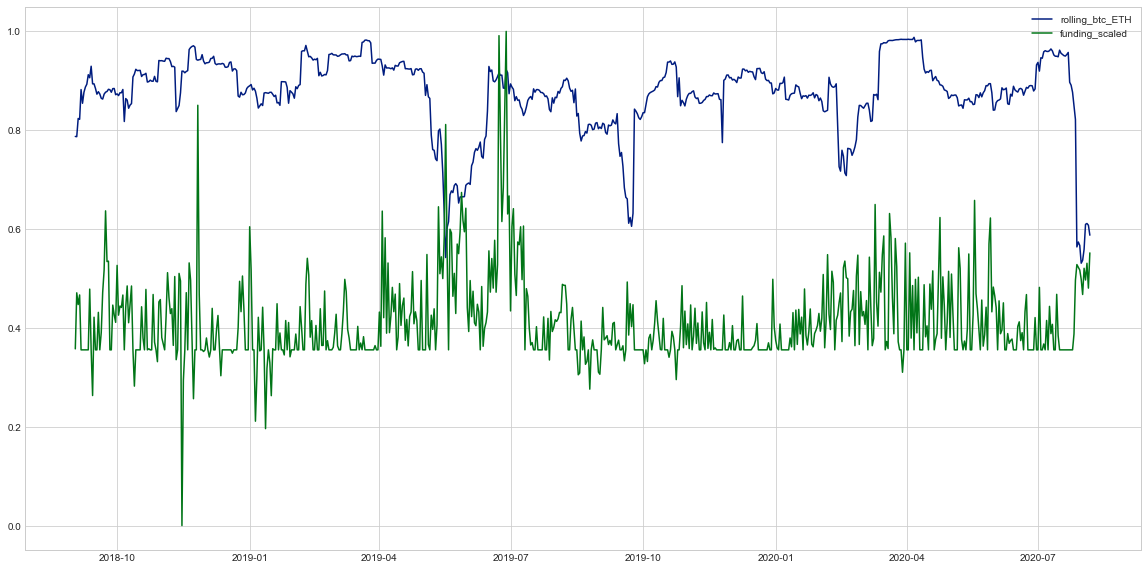

In [3]:
# Create rolling correlation between ether and bitcoin returns
window = 30 # Select n. of days for rolling window
rolling_btc_asset2 = df['return_XBT'].rolling(window).corr(df["return_ETH"]) #https://stackoverflow.com/questions/51957186/how-to-calculate-rolling-correlation-with-pandas
rolling_btc_asset2 = pd.DataFrame(rolling_btc_asset2, columns=["rolling_btc_ETH"]).dropna()

# Merge it with fundingRate of Ether (asset2)
rolling_btc_asset2 = pd.merge(rolling_btc_asset2, rates_asset2[["fundingRateDaily"]],right_index = True, left_index=True,how="left")

# scale both correlation and funding of ether
df_scaled = normalize(rolling_btc_asset2)

# Add them to our rolling_btc_asset2 dataframe
rolling_btc_asset2["rolling_btc_ETH_scaled"] = np.asarray(df_scaled["rolling_btc_ETH"])
rolling_btc_asset2["funding_scaled"] = np.asarray(df_scaled["fundingRateDaily"])

# Merge with data df
my_df = pd.merge(df, rolling_btc_asset2[["rolling_btc_ETH"]], right_index=True, left_index=True, how="left")

# PLot correlation and funding
plt.figure(figsize=(20,10))
plt.plot(rolling_btc_asset2.index, rolling_btc_asset2["rolling_btc_ETH"])
plt.plot(rolling_btc_asset2.index, rolling_btc_asset2["funding_scaled"])
plt.legend()

In [4]:
##### https://blog.bitmex.com/hedging-a-quanto-perpetual-swap/
#Binance is denominated in usd....
def check_quanto_returns(investment,df,date_start, date_end, strategy="long_short", TYPE="quanto",
                         comparison=True, complete=False, show_prices=True, show_hedge=True,
                        add_bias_eth=0, add_bias_btc= 0,  btc_fixed=False, eth_fixed=False, hedge_btc=True,
                        funding_analysis=True, show_roi=True, do_rebalancing=False, rebalancing_check=10, rebalancing_param=0.4): #rebalancing param = percentage of deviation
    
    # Subset for date 
    df = df[(df.index>=date_start) & (df.index<=date_end) ]
        
    # Transform price to fixed
    if btc_fixed:      df["close_XBT"] = df["close_XBT"][0]
    if eth_fixed:      df["close_ETH"] = df["close_ETH"][0]
    
    # Add daily bias
    if abs(add_bias_eth)>0: 
        df["multiplier_ETH"] = np.random.normal(add_bias_eth,abs(add_bias_eth)*3, len(df))
        df["multiplier_ETH"] = 1 + cumulative_return(df["multiplier_ETH"])
        df["close_ETH"] = np.multiply(df["close_ETH"],df["multiplier_ETH"])
        
    if abs(add_bias_btc)>0:
        df["multiplier_btc"] = np.random.normal(add_bias_btc,abs(add_bias_btc)*3, len(df))
        df["multiplier_btc"] = 1 + cumulative_return(df["multiplier_btc"])
        df["close_XBT"] = np.multiply(df["close_XBT"],df["multiplier_btc"])
    
    #Valid for both types
    price_eth,price_btc = df["close_ETH"][0], df["close_XBT"][0]
    n_contracts    = investment/(price_eth * 0.000001 * price_btc)
    number_of_eth  = investment/price_eth
    investment_btc = price_eth * 0.000001 *n_contracts # https://www.bitmex.com/app/seriesGuide/ETH
    value_of_pos   = number_of_eth*price_eth  

    list_of_results= []
    for i in track(range(len(df))):
        price_eth_after = df["close_ETH"][i]
        price_btc_after = df["close_XBT"][i]
        ret_spot        = (price_eth_after -  df["close_ETH"][i-1])* -number_of_eth
        if i==0: ret_spot=0

        if TYPE=="standard":
            ret                 = (price_eth_after -  price_eth)* number_of_eth
            if i== 0: ret=0
            return_dollar       = ret
            number_of_eth_after = number_of_eth

        if TYPE=="quanto": #https://www.bitmex.com/app/seriesGuide/ETH
            ret                 = (price_eth_after - price_eth)* 0.000001 * n_contracts
            if i== 0: ret=0
            return_dollar       = ret*price_btc_after                               #This is where the effect is magnified
            number_of_eth_after = investment_btc /(price_eth_after/price_btc_after)

        value_of_pos_after  = number_of_eth_after*price_eth_after 
        number_of_btc_after = value_of_pos_after / price_btc_after
        funding             = value_of_pos_after * -df["fundingRateDailyETH"][i]
        funding_btc         = investment * -df["fundingRateDailyBTC"][i]

        list_of_results.append([value_of_pos_after, return_dollar, ret_spot,funding, funding_btc,  number_of_eth_after,number_of_btc_after, price_eth_after, price_btc_after ])
 
        # Controls situation of the account
        if((i/rebalancing_check).is_integer()): #each n iteration (for speed of the loop)
            df_results = pd.DataFrame(list_of_results, columns=["value_of_short_position","total_return_dollar_from_short","return_dollar_from_spot","return_funding","return_funding_btc","ETH_number_position_short","btc_value_of_position_short","ETH_price","bitcoin_price"])
            df_results = calculate_ongoing_stats(df,df_results, investment, hedge_btc,exchanger,strategy) #Checks actual condition of bitmex account
            # print(df_results["value_of_bitmex_account_percent"][i])
            # Rebalancing
            if do_rebalancing: 
                if abs(df_results["value_of_bitmex_account_percent"][i]-1) > rebalancing_param: # If we have the condition
                    df_results = calculate_final_results(df_results, PRINT=False)
                    print("Rebalancing in date", df_results.index[i], "value of bitmex:",df_results["value_of_bitmex_account_percent"][i])
                    return df_results
                    break # Stops here the loop. Use this in a for loop :)
            
            # rebalancing when 40% away, rebalancingpar = 0.4
            # equity = 150% ... should rebalance
            
    if do_rebalancing==False:
        df_results = calculate_final_results(df_results, PRINT=True)

        Plot_results_arb(df_results, strategy,complete,comparison, hedge_btc,show_prices,show_hedge,funding_analysis,show_roi)

    return df_results

In [5]:
def calculate_ongoing_stats(df,df_results, investment, hedge_btc=False,exchanger="binance",strategy="long_short"):
    # In bitmex we can decide both to hedge or not btc
    if hedge_btc==False:
        df_results["return_from_btc_change_price"] = np.multiply((df_results["bitcoin_price"] - df_results["bitcoin_price"][0]),-df_results["btc_value_of_position_short"][0])
        if exchanger=="binance": df_results["return_from_btc_change_price"] =0
        df_results["value_of_future_collateral"] = -investment + df_results["return_from_btc_change_price"] # "-" because investment is short but collateral is positive
        df_results["btc_collateral_number"] = -investment/df_results["bitcoin_price"][0] 
        df_results["return_funding_btc"] = 0
    else: 
        df_results["return_from_btc_change_price"] = 0
        df_results["value_of_future_collateral"] = -investment
        df_results["btc_collateral_number"] = -investment/df_results["bitcoin_price"] # This varies!

    #Calculate statistics on the behaviour
    if exchanger == "binance": df_results["return_funding_btc"] = 0
    df_results["ETH_btc"]                = df_results["ETH_price"]/df_results["bitcoin_price"]
    df_results["return_dollar_from_short"] = df_results["total_return_dollar_from_short"] - df_results["total_return_dollar_from_short"].shift(1) # Need to calculate  first cumulative and then go back.
    df_results["total_return_dollar_spot"] = cumulative_return(df_results["return_dollar_from_spot"])
    df_results["return_funding_cum_eth"] = cumulative_return(df_results["return_funding"])
    df_results["return_funding_cum_btc"] = cumulative_return(df_results["return_funding_btc"])
    df_results["return_funding_cum"]     = df_results["return_funding_cum_btc"] + df_results["return_funding_cum_eth"]
    df_results["return_total_future"]    = df_results["return_funding_cum"] + df_results["total_return_dollar_from_short"] + df_results["return_from_btc_change_price"] # This is 0 for binance...
    df_results["hedge"]                  = df_results["ETH_number_position_short"] - df_results["ETH_number_position_short"][0]
    df_results["number_of_eth_spot"]     = -df_results["ETH_number_position_short"][0] #Useful... Will change with rebalancing

    df_results["value_of_hold_ether"]    = df_results["number_of_eth_spot"] * df_results["ETH_price"]
    df_results["value_of_bitmex_account"]= df_results["value_of_future_collateral"] + df_results["return_total_future"]

    # Binance has usd collateral, so need some changes
    if exchanger == "binance":
        #df_results["return_total_future"]    = df_results["return_funding_cum"] + df_results["total_return_dollar_from_short"]
        df_results["value_of_bitmex_account"]= -investment + df_results["return_total_future"] #Cause I hold cash

    # Return
    df_results["net_return"]     = df_results["return_total_future"] + df_results["total_return_dollar_spot"] # in dollars
    df_results["bitcoin_return"] = np.log(df_results["bitcoin_price"] / df_results["bitcoin_price"].shift(1)) # in percentage
    df_results["ether_return"]   = np.log(df_results["ETH_price"] / df_results["ETH_price"].shift(1))
    
    # Value of account
    df_results["value_of_bitmex_account_percent"] = df_results["value_of_bitmex_account"]/df_results["value_of_bitmex_account"][0]
    df_results["total_investment"] = df_results["value_of_bitmex_account"]+ df_results["value_of_hold_ether"]

    # If we do long short, we bought ether in the spot
    #if strategy == "short":
    #    df_results["total_return_dollar_spot"] = -df_results["total_return_dollar_spot"]
    
    # Data manipulation for easier accessing 
    df_results.index = df.index[:len(df_results)]
    df_results.index = pd.to_datetime(df_results.index,) #maybe not needed
    df_results.index = df_results.index.tz_localize(None)
    return df_results

In [6]:
def calculate_final_results(df_results, PRINT=True):
    # Calculate scalar statistics
    corr_coef                      = np.corrcoef(df_results["ETH_price"],df_results["bitcoin_price"])[0][1]
    df_results["net_return_day"]   = df_results["total_investment"]- df_results["total_investment"].shift(1) 
    df_results["ROI_day"]          = round(df_results["net_return_day"] / df_results["total_investment"][0],4)
    df_results["ROI_cum"]          = cumulative_return(df_results["ROI_day"])
    total_roi                      = round(df_results["ROI_cum"][-1],5)
    annual_roi                     = round(total_roi * 365 / len(df_results),5)
    annual_std                     = round(df_results["ROI_day"].std() * 365**0.5,5)
    sharpe                         = round(annual_roi/annual_std,4)
    
    if PRINT:
        #print("corrcoef ETH and btc: ", corr_coef)
        print("investment: ", df_results["total_investment"][0])
        print("total ROI:",total_roi)
        print("Annual ROI", annual_roi)
        print("STD", annual_std)
        print("sharpe", sharpe)
    
    return df_results

In [7]:
def output_stats(df_results, list_of_res):
    total_roi    = round(df_results["ROI_cum"][-1],5)
    annual_roi   = round(total_roi * 365 / len(df_results),5)
    annual_std   = round(df_results["ROI_day"].std() * 365**0.5,5)
    sharpe       = round(annual_roi/annual_std,4)
    n_days       = len(df_results)
    n_rebalance  = len(list_of_res)
    
    df_stats = pd.DataFrame([[ticker_asset2, total_roi, annual_roi, annual_std, sharpe, n_days,n_rebalance]],
                           columns=["asset","total return","annual return","annual std","sharpe","Number of days","Number of rebalances"])
    return(df_stats)

In [8]:
import matplotlib.ticker as ticker
import seaborn
seaborn.set_style({'legend.frameon':True})
def Plot_results_arb(df_results, strategy,complete,comparison, hedge_btc,show_prices,show_hedge,funding_analysis,show_roi,
                    reb = False, rebalancings=False):
#Plots
    fig, axs = plt.subplots(5, figsize=(12,36))    

    #Long short
    axs[0].plot(df_results.index,df_results.total_return_dollar_spot, label="Return from spot position(long)",color="#017517")
    axs[0].plot(df_results.index,df_results.total_return_dollar_from_short, label="Return from future position (short)", color="#8C0900")
    axs[0].plot(df_results.index,df_results.return_funding_cum, label="Return from collected funding rate", color="#B8860B")
    axs[0].plot(df_results.index,df_results.net_return, label="Net return", color="#001C7F")
    #axs[0].plot(df_results.index,df_results.value_of_bitmex_account, linestyle="dashed",label="value of bitmex account")
    axs[0].hlines(0,xmin=df_results.index.min(), xmax=df_results.index.max(), linestyle="dotted", colors="grey")
    if reb:
        axs[0].plot(rebalancings, [0]*len(rebalancings),"v", color="black", label="Rebalancing", markersize=2)
    formatter = ticker.FormatStrFormatter('%1.0f$')
    axs[0].fill_between(df_results.index, 0, df_results.net_return, alpha=0.12, color='#001C7F')
    axs[0].yaxis.set_major_formatter(formatter)
    axs[0].legend(loc="upper right") #bbox_to_anchor=(1.05, 1.0), loc='upper left'

    #Show standardized prices
    if show_prices:
        axs[1].plot(df_results.index,df_results["ETH_price"]/df_results["ETH_price"][0], label="Ethereum") # scaled
        axs[1].plot(df_results.index,df_results.bitcoin_price/df_results.bitcoin_price[0], label="Bitcoin")
        axs[1].plot(df_results.index,df_results["ETH_btc"]/df_results["ETH_btc"][0], label="Eth/Btc")
        axs[1].hlines(1,xmin=df_results.index.min(), xmax=df_results.index.max(), linestyle="dotted", colors="grey")
        axs[1].legend()

    # Show how well we are hedged
    if show_hedge:           
        axs[2].plot(df_results.index,df_results.number_of_eth_spot, label="Long position", color="#017517")
        axs[2].plot(df_results.index,- df_results.ETH_number_position_short, label="Short position",color="#8C0900")
        axs[2].plot(df_results.index,df_results.hedge, label="Excess position", color="#B8860B")
        axs[2].hlines(0,xmin=df_results.index.min(), xmax=df_results.index.max(), linestyle="dotted", colors="grey")
        if reb:
            axs[2].plot(rebalancings, [0]*len(rebalancings),"v", color="black", label="Rebalancing", markersize=2)
        axs[2].legend()

    # Analyze impact of funding
    if funding_analysis:       
        axs[3].plot(df_results.index,df_results["return_funding_cum_eth"], label="funding from eth")
        axs[3].plot(df_results.index,df_results["return_funding_cum_btc"], label="funding from btc")
        axs[3].legend()

    # Analyze ROI
    if show_roi:       
        axs[4].plot(df_results.index,df_results["ROI_cum"], label="Return on investment")
        axs[4].legend()
        
    #if strategy!="long_short": #Comparison between going long in spot and future
    #    if complete:
    #        axs[0].plot(df_results.index,df_results.return_total_future, label="return from quanto future")
    #        axs[0].plot(df_results.index,df_results.total_return_dollar_from_short, label="return from quanto future NO FUNDING")
    #        axs[0].plot(df_results.index,df_results.total_return_dollar_from_short, label="return from spot")
    #        axs[0].hlines(0,xmin=df_results.index.min(), xmax=df_results.index.max(), linestyle="dotted", colors="grey")
    #        if hedge_btc:  axs[0].hlines(investment,xmin=df_results.index.min(), xmax=df_results.index.max(), linestyle="dashed", colors="red", label="liquidation")
    #        else:          axs[0].plot(df_results.index,df_results["value_of_short_position"], linestyle="dashed", color="red", label="liquidation")##

    #    if comparison:
    #        axs[0].plot(df_results.index,df_results.return_funding_cum, label="return from funding")
    #        axs[0].plot(df_results.index,df_results.total_return_dollar_from_short-df_results.return_dollar_spot, label="difference future and spot (funding not considered)")
    #        axs[0].hlines(0,xmin=df_results.index.min(), xmax=df_results.index.max(), linestyle="dotted", colors="grey")


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-05 00:00:00 value of bitmex: 1.025723393072714
Reinvest: -1000.7456710005254


 [############################################################] 0/727 [0<0, 0.00s/it]

Rebalancing in date 2018-08-07 00:00:00 value of bitmex: 1.0102139842099374
Reinvest: -1001.5968624230354


 [############################################################] 0/725 [0<0, 0.00s/it]

Rebalancing in date 2018-08-09 00:00:00 value of bitmex: 1.0532405025355933
Reinvest: -998.6835378431313


 [############################################################] 0/723 [0<0, 0.00s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.0841920787853765
Reinvest: -996.51919441731


 [############################################################] 0/721 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1088864239313123
Reinvest: -1002.106769359057


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-17 00:00:00 value of bitmex: 0.9687339468631949
Reinvest: -1000.8329474987361


 [############################################################] 0/715 [0<0, 0.00s/it]

Rebalancing in date 2018-08-19 00:00:00 value of bitmex: 1.067034835153787
Reinvest: -998.7838680469549


 [############################################################] 0/713 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.0958403457216628
Reinvest: -997.320334458514


 [############################################################] 0/711 [0<0, 0.00s/it]

Rebalancing in date 2018-08-23 00:00:00 value of bitmex: 1.039504115200859
Reinvest: -998.4142003018316


 [############################################################] 0/709 [0<0, 0.00s/it]

Rebalancing in date 2018-08-25 00:00:00 value of bitmex: 0.9777714229809175
Reinvest: -998.8021629986235


 [############################################################] 0/707 [0<0, 0.00s/it]

Rebalancing in date 2018-08-27 00:00:00 value of bitmex: 1.0129586039283311
Reinvest: -999.7912187601084


 [############################################################] 0/705 [0<0, 0.00s/it]

Rebalancing in date 2018-08-29 00:00:00 value of bitmex: 0.9765270871748566
Reinvest: -1002.200565246005


 [############################################################] 0/703 [0<0, 0.00s/it]

Rebalancing in date 2018-08-31 00:00:00 value of bitmex: 1.0177366121537326
Reinvest: -1003.4883926106434


 [############################################################] 0/701 [0<0, 0.00s/it]

Rebalancing in date 2018-09-02 00:00:00 value of bitmex: 0.9454388599470986
Reinvest: -1004.7639055336446


 [############################################################] 0/699 [0<0, 0.00s/it]

Rebalancing in date 2018-09-04 00:00:00 value of bitmex: 1.0242115718758156
Reinvest: -1007.3440038367436


 [############################################################] 0/697 [0<0, 0.00s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.1794433781333298
Reinvest: -1000.0350933583914


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.0610926107773924
Reinvest: -999.5376097377897


 [############################################################] 0/693 [0<0, 0.00s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.0569321909784093
Reinvest: -999.1906217653798


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028875
Reinvest: -995.0443014855081


 [############################################################] 0/687 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.9393042028293088
Reinvest: -994.5356822236012


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.1078294176571752
Reinvest: -993.4174681364369


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-21 00:00:00 value of bitmex: 0.9261171741212378
Reinvest: -994.2638471246269


 [############################################################] 0/680 [0<0, 0.00s/it]

Rebalancing in date 2018-09-23 00:00:00 value of bitmex: 1.0348357624527627
Reinvest: -999.0742094730315


 [############################################################] 0/678 [0<0, 0.00s/it]

Rebalancing in date 2018-09-25 00:00:00 value of bitmex: 1.0707724674632186
Reinvest: -1002.5069283076713


 [############################################################] 0/676 [0<0, 0.00s/it]

Rebalancing in date 2018-09-27 00:00:00 value of bitmex: 1.023618953071755
Reinvest: -1002.8798392442466


 [############################################################] 0/674 [0<0, 0.00s/it]

Rebalancing in date 2018-09-29 00:00:00 value of bitmex: 1.0357955778764147
Reinvest: -1004.8875831620614


 [############################################################] 0/672 [0<0, 0.00s/it]

Rebalancing in date 2018-10-03 00:00:00 value of bitmex: 1.036204568481252
Reinvest: -1010.0492169213899


 [############################################################] 0/668 [0<0, 0.00s/it]

Rebalancing in date 2018-10-06 00:00:00 value of bitmex: 0.9727070693606796
Reinvest: -1013.5132554787884


 [############################################################] 0/665 [0<0, 0.00s/it]

Rebalancing in date 2018-10-09 00:00:00 value of bitmex: 0.9868435010311432
Reinvest: -1017.0405628531994


 [############################################################] 0/662 [0<0, 0.00s/it]

Rebalancing in date 2018-10-11 00:00:00 value of bitmex: 1.0161699659331926
Reinvest: -1020.2952117010132


 [############################################################] 0/660 [0<0, 0.00s/it]

Rebalancing in date 2018-10-13 00:00:00 value of bitmex: 0.9695913028917039
Reinvest: -1020.1033147686062


 [############################################################] 0/658 [0<0, 0.00s/it]

Rebalancing in date 2018-10-15 00:00:00 value of bitmex: 1.0272272039494776
Reinvest: -1019.6595459245827


 [############################################################] 0/656 [0<0, 0.00s/it]

Rebalancing in date 2018-10-19 00:00:00 value of bitmex: 1.0290069385590646
Reinvest: -1021.904821224138


 [############################################################] 9/652 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-30 00:00:00 value of bitmex: 1.0425097711757456
Reinvest: -1028.8755662284932


 [############################################################] 0/641 [0<0, 0.00s/it]

Rebalancing in date 2018-11-03 00:00:00 value of bitmex: 0.9806107974511732
Reinvest: -1031.9822486473295


 [############################################################] 0/637 [0<0, 0.00s/it]

Rebalancing in date 2018-11-05 00:00:00 value of bitmex: 0.9422183500745422
Reinvest: -1034.4207668655317


 [############################################################] 0/635 [0<0, 0.00s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.9561064941285419
Reinvest: -1037.4106408418495


 [############################################################] 0/633 [0<0, 0.00s/it]

Rebalancing in date 2018-11-09 00:00:00 value of bitmex: 1.0292801753275855
Reinvest: -1038.7447529058902


 [############################################################] 0/631 [0<0, 0.00s/it]

Rebalancing in date 2018-11-11 00:00:00 value of bitmex: 0.987732685456291
Reinvest: -1041.0602218909294


 [############################################################] 0/629 [0<0, 0.00s/it]

Rebalancing in date 2018-11-13 00:00:00 value of bitmex: 1.0104454948979495
Reinvest: -1043.8427822792792


 [############################################################] 0/627 [0<0, 0.00s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.098554927784372
Reinvest: -1032.852822715421


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-17 00:00:00 value of bitmex: 1.033445162063679
Reinvest: -1030.5684876593155


 [############################################################] 0/623 [0<0, 0.00s/it]

Rebalancing in date 2018-11-19 00:00:00 value of bitmex: 0.9800325347057206
Reinvest: -1031.4523298872418


 [############################################################] 0/621 [0<0, 0.00s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.1117445402658581
Reinvest: -1028.8236557539453


 [############################################################] 0/619 [0<0, 0.00s/it]

Rebalancing in date 2018-11-23 00:00:00 value of bitmex: 1.0769999547476135
Reinvest: -1024.7729109621441


 [############################################################] 0/617 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.0746433130247133
Reinvest: -1020.0175341893478


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.0591067463707065
Reinvest: -1022.9623038096299


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997075
Reinvest: -1009.9293664896277


 [############################################################] 0/611 [0<0, 0.00s/it]

Rebalancing in date 2018-12-01 00:00:00 value of bitmex: 1.0322535397783834
Reinvest: -1004.3521042596603


 [############################################################] 0/609 [0<0, 0.00s/it]

Rebalancing in date 2018-12-03 00:00:00 value of bitmex: 1.0142328947395272
Reinvest: -1003.8830368252093


 [############################################################] 0/607 [0<0, 0.00s/it]

Rebalancing in date 2018-12-05 00:00:00 value of bitmex: 0.9849408119098734
Reinvest: -1001.8811181719562


 [############################################################] 0/605 [0<0, 0.00s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.106958308944485
Reinvest: -997.7731451557213


 [############################################################] 0/603 [0<0, 0.00s/it]

Rebalancing in date 2018-12-09 00:00:00 value of bitmex: 1.0223369583328326
Reinvest: -996.4734639369668


 [############################################################] 0/601 [0<0, 0.00s/it]

Rebalancing in date 2018-12-11 00:00:00 value of bitmex: 1.0365244123502215
Reinvest: -996.204233173502


 [############################################################] 0/599 [0<0, 0.00s/it]

Rebalancing in date 2018-12-13 00:00:00 value of bitmex: 0.974105434366355
Reinvest: -994.5437938820635


 [############################################################] 0/597 [0<0, 0.00s/it]

Rebalancing in date 2018-12-15 00:00:00 value of bitmex: 1.0275547690677276
Reinvest: -993.995475993343


 [############################################################] 0/595 [0<0, 0.00s/it]

Rebalancing in date 2018-12-18 00:00:00 value of bitmex: 0.8544421286353925
Reinvest: -986.3747592352338


 [############################################################] 0/592 [0<0, 0.00s/it]

Rebalancing in date 2018-12-20 00:00:00 value of bitmex: 1.0135600302052117
Reinvest: -983.3113533879796


 [############################################################] 0/590 [0<0, 0.00s/it]

Rebalancing in date 2018-12-22 00:00:00 value of bitmex: 1.0543597550675061
Reinvest: -981.0667826887702


 [############################################################] 0/588 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.8824570337851271
Reinvest: -981.2093223503645


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-26 00:00:00 value of bitmex: 1.0704580378266755
Reinvest: -980.5399568869475


 [############################################################] 0/584 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1153347481838738
Reinvest: -978.7381663801783


 [############################################################] 0/582 [0<0, 0.00s/it]

Rebalancing in date 2018-12-30 00:00:00 value of bitmex: 1.0187579458452676
Reinvest: -978.0820838826971


 [############################################################] 0/580 [0<0, 0.00s/it]

Rebalancing in date 2019-01-01 00:00:00 value of bitmex: 1.0611312861886615
Reinvest: -979.7544159372841


 [############################################################] 0/578 [0<0, 0.00s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.9005665060453039
Reinvest: -980.3551536396673


 [############################################################] 0/576 [0<0, 0.00s/it]

Rebalancing in date 2019-01-05 00:00:00 value of bitmex: 0.953343041912454
Reinvest: -978.9348848387415


 [############################################################] 0/574 [0<0, 0.00s/it]

Rebalancing in date 2019-01-07 00:00:00 value of bitmex: 0.9890071887279296
Reinvest: -978.8435425906466


 [############################################################] 0/572 [0<0, 0.00s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1435874193802575
Reinvest: -970.6535863291994


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-13 00:00:00 value of bitmex: 1.0115409556500865
Reinvest: -966.8551616628656


 [############################################################] 0/566 [0<0, 0.00s/it]

Rebalancing in date 2019-01-15 00:00:00 value of bitmex: 0.8824780494640876
Reinvest: -964.5002642934971


 [############################################################] 0/564 [0<0, 0.00s/it]

Rebalancing in date 2019-01-17 00:00:00 value of bitmex: 0.9816199117637857
Reinvest: -963.9292509881825


 [############################################################] 0/562 [0<0, 0.00s/it]

Rebalancing in date 2019-01-19 00:00:00 value of bitmex: 1.0188087157778263
Reinvest: -963.0752957884063


 [############################################################] 0/560 [0<0, 0.00s/it]

Rebalancing in date 2019-01-21 00:00:00 value of bitmex: 1.0430066806919391
Reinvest: -961.7663668747366


 [############################################################] 0/558 [0<0, 0.00s/it]

Rebalancing in date 2019-01-23 00:00:00 value of bitmex: 0.980309617610946
Reinvest: -960.8349804616165


 [############################################################] 0/556 [0<0, 0.00s/it]

Rebalancing in date 2019-01-26 00:00:00 value of bitmex: 1.0114074226404248
Reinvest: -959.9575133510502


 [############################################################] 0/553 [0<0, 0.00s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.0323830168246393
Reinvest: -960.3063667503241


 [############################################################] 0/551 [0<0, 0.00s/it]

Rebalancing in date 2019-01-30 00:00:00 value of bitmex: 1.0120115878509535
Reinvest: -960.5313830499178


 [############################################################] 0/549 [0<0, 0.00s/it]

Rebalancing in date 2019-02-01 00:00:00 value of bitmex: 1.0167852137575952
Reinvest: -960.4103910899661


 [############################################################] 0/547 [0<0, 0.00s/it]

Rebalancing in date 2019-02-03 00:00:00 value of bitmex: 0.9670090057518743
Reinvest: -961.0160185610323


 [############################################################] 0/545 [0<0, 0.00s/it]

Rebalancing in date 2019-02-07 00:00:00 value of bitmex: 1.027678091304483
Reinvest: -962.5431100021196


 [############################################################] 0/541 [0<0, 0.00s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8408586926324285
Reinvest: -958.677794220053


 [############################################################] 0/539 [0<0, 0.00s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.9539856358254041
Reinvest: -962.2778780638296


 [############################################################] 0/537 [0<0, 0.00s/it]

Rebalancing in date 2019-02-17 00:00:00 value of bitmex: 0.9880505458533622
Reinvest: -965.2919913314457


 [############################################################] 0/531 [0<0, 0.00s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.9007287686744763
Reinvest: -963.6236327866723


 [############################################################] 0/529 [0<0, 0.00s/it]

Rebalancing in date 2019-02-21 00:00:00 value of bitmex: 0.9679917037708669
Reinvest: -963.7245534839125


 [############################################################] 0/527 [0<0, 0.00s/it]

Rebalancing in date 2019-02-23 00:00:00 value of bitmex: 0.983837723666245
Reinvest: -965.3431932788519


 [############################################################] 0/525 [0<0, 0.00s/it]

Rebalancing in date 2019-02-25 00:00:00 value of bitmex: 1.148737409193255
Reinvest: -958.4439940471651


 [############################################################] 0/523 [0<0, 0.00s/it]

Rebalancing in date 2019-02-27 00:00:00 value of bitmex: 1.0119342469247787
Reinvest: -957.9261330526958


 [############################################################] 0/521 [0<0, 0.00s/it]

Rebalancing in date 2019-03-03 00:00:00 value of bitmex: 1.0154814632831277
Reinvest: -958.3666429151224


 [############################################################] 0/517 [0<0, 0.00s/it]

Rebalancing in date 2019-03-05 00:00:00 value of bitmex: 1.0349990672864442
Reinvest: -958.1816500244856


 [############################################################] 0/515 [0<0, 0.00s/it]

Rebalancing in date 2019-03-09 00:00:00 value of bitmex: 1.0335146600227452
Reinvest: -961.4977771042197


 [############################################################] 0/511 [0<0, 0.00s/it]

Rebalancing in date 2019-03-11 00:00:00 value of bitmex: 1.0125959047788675
Reinvest: -961.2649979472976


 [############################################################] 0/509 [0<0, 0.00s/it]

Rebalancing in date 2019-03-16 00:00:00 value of bitmex: 0.9657737081429238
Reinvest: -959.1918472998311


 [############################################################] 0/504 [0<0, 0.00s/it]

Rebalancing in date 2019-03-18 00:00:00 value of bitmex: 1.0176181800953108
Reinvest: -960.0399581870822


 [############################################################] 0/502 [0<0, 0.00s/it]

Rebalancing in date 2019-03-21 00:00:00 value of bitmex: 0.9868257815278757
Reinvest: -959.4374252357898


 [############################################################] 0/499 [0<0, 0.00s/it]

Rebalancing in date 2019-03-23 00:00:00 value of bitmex: 0.9889792575900607
Reinvest: -958.5416285074325


 [############################################################] 0/497 [0<0, 0.00s/it]

Rebalancing in date 2019-03-26 00:00:00 value of bitmex: 1.0250985861083999
Reinvest: -957.3671232767272


 [############################################################] 0/494 [0<0, 0.00s/it]

Rebalancing in date 2019-03-28 00:00:00 value of bitmex: 0.9549216003751914
Reinvest: -956.2817151664617


 [############################################################] 0/492 [0<0, 0.00s/it]

Rebalancing in date 2019-03-30 00:00:00 value of bitmex: 0.9603726686751056
Reinvest: -955.0686256461756


 [############################################################] 0/490 [0<0, 0.00s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8148100180946095
Reinvest: -942.1685866281475


 [############################################################] 0/486 [0<0, 0.00s/it]

Rebalancing in date 2019-04-05 00:00:00 value of bitmex: 1.0268903446643085
Reinvest: -945.2601219151582


 [############################################################] 0/484 [0<0, 0.00s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9517830700996671
Reinvest: -947.6439294988634


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-10 00:00:00 value of bitmex: 1.0287821061763314
Reinvest: -949.424853504376


 [############################################################] 0/479 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0688651556151625
Reinvest: -949.928379428658


 [############################################################] 0/477 [0<0, 0.00s/it]

Rebalancing in date 2019-04-15 00:00:00 value of bitmex: 0.978444364104235
Reinvest: -951.8136219099551


 [############################################################] 0/474 [0<0, 0.00s/it]

Rebalancing in date 2019-04-17 00:00:00 value of bitmex: 0.962391530945765
Reinvest: -953.0639812188471


 [############################################################] 0/472 [0<0, 0.00s/it]

Rebalancing in date 2019-04-19 00:00:00 value of bitmex: 0.9528769746911635
Reinvest: -954.5727268412188


 [############################################################] 0/470 [0<0, 0.00s/it]

Rebalancing in date 2019-04-22 00:00:00 value of bitmex: 1.0243069479429745
Reinvest: -956.2393009394423


 [############################################################] 0/467 [0<0, 0.00s/it]

Rebalancing in date 2019-04-24 00:00:00 value of bitmex: 1.010298727128933
Reinvest: -958.1376611490409


 [############################################################] 0/465 [0<0, 0.00s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.080229939754387
Reinvest: -956.923386534171


 [############################################################] 0/463 [0<0, 0.00s/it]

Rebalancing in date 2019-04-28 00:00:00 value of bitmex: 0.9852351361757457
Reinvest: -956.894812109884


 [############################################################] 0/461 [0<0, 0.00s/it]

Rebalancing in date 2019-05-01 00:00:00 value of bitmex: 0.9535410501053992
Reinvest: -955.472816104582


 [############################################################] 0/458 [0<0, 0.00s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9566429686836095
Reinvest: -954.1931106516392


 [############################################################] 0/455 [0<0, 0.00s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.9421094370108977
Reinvest: -952.7754461100819


 [############################################################] 0/452 [0<0, 0.00s/it]

Rebalancing in date 2019-05-09 00:00:00 value of bitmex: 0.9776816070460911
Reinvest: -952.1919052975115


 [############################################################] 0/450 [0<0, 0.00s/it]

Rebalancing in date 2019-05-11 00:00:00 value of bitmex: 0.9878456418774629
Reinvest: -949.9360240679147


 [############################################################] 0/448 [0<0, 0.00s/it]

Rebalancing in date 2019-05-13 00:00:00 value of bitmex: 1.0287877329976174
Reinvest: -954.1562883615142


 [############################################################] 0/446 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8935611429974565
Reinvest: -956.7428609283777


 [############################################################] 0/444 [0<0, 0.00s/it]

Rebalancing in date 2019-05-17 00:00:00 value of bitmex: 0.9479098771595368
Reinvest: -965.0632175559344


 [############################################################] 0/442 [0<0, 0.00s/it]

Rebalancing in date 2019-05-19 00:00:00 value of bitmex: 1.042298561224053
Reinvest: -966.7020042836878


 [############################################################] 0/440 [0<0, 0.00s/it]

Rebalancing in date 2019-05-21 00:00:00 value of bitmex: 1.0372190310541314
Reinvest: -971.5141438518051


 [############################################################] 0/438 [0<0, 0.00s/it]

Rebalancing in date 2019-05-23 00:00:00 value of bitmex: 1.0463756549161742
Reinvest: -973.6130429805917


 [############################################################] 0/436 [0<0, 0.00s/it]

Rebalancing in date 2019-05-25 00:00:00 value of bitmex: 0.9892004323202875
Reinvest: -977.5605171903671


 [############################################################] 0/434 [0<0, 0.00s/it]

Rebalancing in date 2019-05-27 00:00:00 value of bitmex: 0.9348289113997185
Reinvest: -980.9254710415617


 [############################################################] 0/432 [0<0, 0.00s/it]

Rebalancing in date 2019-05-29 00:00:00 value of bitmex: 1.0113200647876437
Reinvest: -990.431576821763


 [############################################################] 0/430 [0<0, 0.00s/it]

Rebalancing in date 2019-05-31 00:00:00 value of bitmex: 1.0602154682270781
Reinvest: -996.1490894261203


 [############################################################] 0/428 [0<0, 0.00s/it]

Rebalancing in date 2019-06-02 00:00:00 value of bitmex: 1.0127695033216022
Reinvest: -998.3819441731403


 [############################################################] 0/426 [0<0, 0.00s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.0686766811624673
Reinvest: -998.8168766374442


 [############################################################] 0/424 [0<0, 0.00s/it]

Rebalancing in date 2019-06-06 00:00:00 value of bitmex: 0.978722669608389
Reinvest: -1000.517780808437


 [############################################################] 0/422 [0<0, 0.00s/it]

Rebalancing in date 2019-06-09 00:00:00 value of bitmex: 1.025957222353529
Reinvest: -1003.343937874567


 [############################################################] 0/419 [0<0, 0.00s/it]

Rebalancing in date 2019-06-11 00:00:00 value of bitmex: 0.929355049487862
Reinvest: -1002.5309028691163


 [############################################################] 0/417 [0<0, 0.00s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.9283750022452881
Reinvest: -1002.3402645949648


 [############################################################] 0/415 [0<0, 0.00s/it]

Rebalancing in date 2019-06-15 00:00:00 value of bitmex: 0.9662789961166012
Reinvest: -1003.021652450054


 [############################################################] 0/413 [0<0, 0.00s/it]

Rebalancing in date 2019-06-19 00:00:00 value of bitmex: 1.0350253416665207
Reinvest: -1014.7629795935331


 [############################################################] 0/409 [0<0, 0.00s/it]

Rebalancing in date 2019-06-21 00:00:00 value of bitmex: 0.9896255889595327
Reinvest: -1019.1008773508372


 [############################################################] 0/407 [0<0, 0.00s/it]

Rebalancing in date 2019-06-23 00:00:00 value of bitmex: 0.9734975626888103
Reinvest: -1030.4530533885575


 [############################################################] 0/405 [0<0, 0.00s/it]

Rebalancing in date 2019-06-26 00:00:00 value of bitmex: 0.9788221332982202
Reinvest: -1044.03020446737


 [############################################################] 0/402 [0<0, 0.00s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.1266565794529553
Reinvest: -1053.133847048727


 [############################################################] 0/400 [0<0, 0.00s/it]

Rebalancing in date 2019-06-30 00:00:00 value of bitmex: 0.9807264048186626
Reinvest: -1061.3353842720376


 [############################################################] 0/398 [0<0, 0.00s/it]

Rebalancing in date 2019-07-04 00:00:00 value of bitmex: 0.9718978092115876
Reinvest: -1068.9913900152646


 [############################################################] 0/394 [0<0, 0.00s/it]

Rebalancing in date 2019-07-06 00:00:00 value of bitmex: 0.9870496597651729
Reinvest: -1073.2378316093732


 [############################################################] 0/392 [0<0, 0.00s/it]

Rebalancing in date 2019-07-08 00:00:00 value of bitmex: 0.9385472617151616
Reinvest: -1078.549060418627


 [############################################################] 0/390 [0<0, 0.00s/it]

Rebalancing in date 2019-07-10 00:00:00 value of bitmex: 1.026596786635422
Reinvest: -1086.3584622925353


 [############################################################] 0/388 [0<0, 0.00s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.0684243576349164
Reinvest: -1086.4953296903996


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-14 00:00:00 value of bitmex: 1.0236110154940665
Reinvest: -1087.8412915866325


 [############################################################] 0/384 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.1115034602623122
Reinvest: -1082.479286597358


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342863
Reinvest: -1079.2197468466134


 [############################################################] 0/379 [0<0, 0.00s/it]

Rebalancing in date 2019-07-21 00:00:00 value of bitmex: 0.9666888909827108
Reinvest: -1079.4675576822297


 [############################################################] 0/377 [0<0, 0.00s/it]

Rebalancing in date 2019-07-23 00:00:00 value of bitmex: 1.0370716859663642
Reinvest: -1079.2961312092218


 [############################################################] 0/375 [0<0, 0.00s/it]

Rebalancing in date 2019-07-25 00:00:00 value of bitmex: 0.9789963906216229
Reinvest: -1080.4120088922402


 [############################################################] 0/373 [0<0, 0.00s/it]

Rebalancing in date 2019-07-28 00:00:00 value of bitmex: 1.0531550933169513
Reinvest: -1079.887993202239


 [############################################################] 0/370 [0<0, 0.00s/it]

Rebalancing in date 2019-07-31 00:00:00 value of bitmex: 1.0104090784486608
Reinvest: -1082.5525695373908


 [############################################################] 0/367 [0<0, 0.00s/it]

Rebalancing in date 2019-08-04 00:00:00 value of bitmex: 0.9882517714298147
Reinvest: -1086.063503985271


 [############################################################] 0/363 [0<0, 0.00s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.9552898306049604
Reinvest: -1087.808628568321


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-09 00:00:00 value of bitmex: 1.0296085977470684
Reinvest: -1095.3887836739464


 [############################################################] 0/358 [0<0, 0.00s/it]

Rebalancing in date 2019-08-11 00:00:00 value of bitmex: 1.020626871981456
Reinvest: -1096.0847402086213


 [############################################################] 0/356 [0<0, 0.00s/it]

Rebalancing in date 2019-08-13 00:00:00 value of bitmex: 1.0234805695687488
Reinvest: -1098.1904094897213


 [############################################################] 0/354 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.099043909284185
Reinvest: -1095.0182875044259


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-17 00:00:00 value of bitmex: 1.014784572135416
Reinvest: -1094.714659105331


 [############################################################] 0/350 [0<0, 0.00s/it]

Rebalancing in date 2019-08-19 00:00:00 value of bitmex: 0.9530278419324357
Reinvest: -1095.1481263840237


 [############################################################] 0/348 [0<0, 0.00s/it]

Rebalancing in date 2019-08-21 00:00:00 value of bitmex: 1.0295722612148448
Reinvest: -1095.8605835850744


 [############################################################] 0/346 [0<0, 0.00s/it]

Rebalancing in date 2019-08-23 00:00:00 value of bitmex: 0.9828049330606211
Reinvest: -1095.502448049357


 [############################################################] 0/344 [0<0, 0.00s/it]

Rebalancing in date 2019-08-25 00:00:00 value of bitmex: 1.017374838626192
Reinvest: -1094.5170933701197


 [############################################################] 0/342 [0<0, 0.00s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.0724208553880084
Reinvest: -1094.5627117894512


 [############################################################] 0/338 [0<0, 0.00s/it]

Rebalancing in date 2019-09-01 00:00:00 value of bitmex: 0.9787144785833042
Reinvest: -1093.1518649562481


 [############################################################] 0/335 [0<0, 0.00s/it]

Rebalancing in date 2019-09-03 00:00:00 value of bitmex: 0.9539839010197766
Reinvest: -1093.2158356698944


 [############################################################] 0/333 [0<0, 0.00s/it]

Rebalancing in date 2019-09-05 00:00:00 value of bitmex: 1.02426190046346
Reinvest: -1094.3766030466913


 [############################################################] 0/331 [0<0, 0.00s/it]

Rebalancing in date 2019-09-07 00:00:00 value of bitmex: 1.0299532972434071
Reinvest: -1095.2476521000854


 [############################################################] 0/329 [0<0, 0.00s/it]

Rebalancing in date 2019-09-09 00:00:00 value of bitmex: 0.9832475964600181
Reinvest: -1096.415971244623


 [############################################################] 0/327 [0<0, 0.00s/it]

Rebalancing in date 2019-09-12 00:00:00 value of bitmex: 1.0150297531606811
Reinvest: -1098.5902439717966


 [############################################################] 0/324 [0<0, 0.00s/it]

Rebalancing in date 2019-09-15 00:00:00 value of bitmex: 0.9604432885902207
Reinvest: -1100.3106770269903


 [############################################################] 0/321 [0<0, 0.00s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.9574321261359658
Reinvest: -1101.3076734964834


 [############################################################] 0/319 [0<0, 0.00s/it]

Rebalancing in date 2019-09-19 00:00:00 value of bitmex: 0.9897310145393797
Reinvest: -1101.8289768344475


 [############################################################] 0/317 [0<0, 0.00s/it]

Rebalancing in date 2019-09-21 00:00:00 value of bitmex: 1.0141062238423513
Reinvest: -1104.212967595029


 [############################################################] 0/315 [0<0, 0.00s/it]

Rebalancing in date 2019-09-23 00:00:00 value of bitmex: 1.0187870120114764
Reinvest: -1106.4442216164773


 [############################################################] 0/313 [0<0, 0.00s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.151851676484875
Reinvest: -1096.012142011707


 [############################################################] 0/311 [0<0, 0.00s/it]

Rebalancing in date 2019-09-27 00:00:00 value of bitmex: 1.0227849534926479
Reinvest: -1096.094153576616


 [############################################################] 0/309 [0<0, 0.00s/it]

Rebalancing in date 2019-09-30 00:00:00 value of bitmex: 1.027265136392419
Reinvest: -1095.7549092645863


 [############################################################] 0/306 [0<0, 0.00s/it]

Rebalancing in date 2019-10-02 00:00:00 value of bitmex: 1.02679698121222
Reinvest: -1094.9055334518534


 [############################################################] 0/304 [0<0, 0.00s/it]

Rebalancing in date 2019-10-04 00:00:00 value of bitmex: 1.0305398677922535
Reinvest: -1094.5468699230241


 [############################################################] 0/302 [0<0, 0.00s/it]

Rebalancing in date 2019-10-07 00:00:00 value of bitmex: 1.0343888929927894
Reinvest: -1094.8891999338562


 [############################################################] 0/299 [0<0, 0.00s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.9299085808339997
Reinvest: -1095.9033845472632


 [############################################################] 0/296 [0<0, 0.00s/it]

Rebalancing in date 2019-10-12 00:00:00 value of bitmex: 1.0562153371622582
Reinvest: -1096.3275867012972


 [############################################################] 0/294 [0<0, 0.00s/it]

Rebalancing in date 2019-10-15 00:00:00 value of bitmex: 0.9624708130932361
Reinvest: -1097.8707757200502


 [############################################################] 0/291 [0<0, 0.00s/it]

Rebalancing in date 2019-10-17 00:00:00 value of bitmex: 1.0341815037669875
Reinvest: -1098.1559246349789


 [############################################################] 0/289 [0<0, 0.00s/it]

Rebalancing in date 2019-10-19 00:00:00 value of bitmex: 1.0233189730315861
Reinvest: -1098.3179756141922


 [############################################################] 0/287 [0<0, 0.00s/it]

Rebalancing in date 2019-10-21 00:00:00 value of bitmex: 0.9803599946346282
Reinvest: -1099.0172822934824


 [############################################################] 0/285 [0<0, 0.00s/it]

Rebalancing in date 2019-10-23 00:00:00 value of bitmex: 1.0162762020619946
Reinvest: -1099.7536302569044


 [############################################################] 0/283 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8595409865992903
Reinvest: -1087.6043332871902


 [############################################################] 0/280 [0<0, 0.00s/it]

Rebalancing in date 2019-10-28 00:00:00 value of bitmex: 0.9797864773795685
Reinvest: -1089.805264965649


 [############################################################] 0/278 [0<0, 0.00s/it]

Rebalancing in date 2019-10-30 00:00:00 value of bitmex: 0.950547063075191
Reinvest: -1090.926823857313


 [############################################################] 0/276 [0<0, 0.00s/it]

Rebalancing in date 2019-11-04 00:00:00 value of bitmex: 1.0145918145743853
Reinvest: -1094.2780201325013


 [############################################################] 0/271 [0<0, 0.00s/it]

Rebalancing in date 2019-11-06 00:00:00 value of bitmex: 0.9897821653367185
Reinvest: -1096.2366453190152


 [############################################################] 0/269 [0<0, 0.00s/it]

Rebalancing in date 2019-11-08 00:00:00 value of bitmex: 1.0250651334627414
Reinvest: -1097.6093319902138


 [############################################################] 0/267 [0<0, 0.00s/it]

Rebalancing in date 2019-11-11 00:00:00 value of bitmex: 0.9721836684924636
Reinvest: -1098.9456250037797


 [############################################################] 0/264 [0<0, 0.00s/it]

Rebalancing in date 2019-11-13 00:00:00 value of bitmex: 0.9880211745852819
Reinvest: -1099.679686001434


 [############################################################] 0/262 [0<0, 0.00s/it]

Rebalancing in date 2019-11-15 00:00:00 value of bitmex: 1.0176408096357799
Reinvest: -1101.2555760858531


 [############################################################] 0/260 [0<0, 0.00s/it]

Rebalancing in date 2019-11-17 00:00:00 value of bitmex: 0.9869609239237889
Reinvest: -1102.274863222914


 [############################################################] 0/258 [0<0, 0.00s/it]

Rebalancing in date 2019-11-19 00:00:00 value of bitmex: 1.0323976385532914
Reinvest: -1102.889868597471


 [############################################################] 0/256 [0<0, 0.00s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.0803255826454479
Reinvest: -1100.994564519497


 [############################################################] 0/253 [0<0, 0.00s/it]

Rebalancing in date 2019-11-24 00:00:00 value of bitmex: 0.9861921176535876
Reinvest: -1100.5742584636141


 [############################################################] 0/251 [0<0, 0.00s/it]

Rebalancing in date 2019-11-26 00:00:00 value of bitmex: 0.9565979276717096
Reinvest: -1100.786764023354


 [############################################################] 0/249 [0<0, 0.00s/it]

Rebalancing in date 2019-11-28 00:00:00 value of bitmex: 0.9620519661907482
Reinvest: -1099.7843935291708


 [############################################################] 0/247 [0<0, 0.00s/it]

Rebalancing in date 2019-11-30 00:00:00 value of bitmex: 0.9742908134904215
Reinvest: -1099.6095034039777


 [############################################################] 0/245 [0<0, 0.00s/it]

Rebalancing in date 2019-12-03 00:00:00 value of bitmex: 1.0182147466839926
Reinvest: -1100.43198598147


 [############################################################] 0/242 [0<0, 0.00s/it]

Rebalancing in date 2019-12-05 00:00:00 value of bitmex: 1.012456442493469
Reinvest: -1100.9560999127584


 [############################################################] 0/240 [0<0, 0.00s/it]

Rebalancing in date 2019-12-09 00:00:00 value of bitmex: 0.9860134423138192
Reinvest: -1103.4630653860468


 [############################################################] 0/236 [0<0, 0.00s/it]

Rebalancing in date 2019-12-11 00:00:00 value of bitmex: 1.0112738654581004
Reinvest: -1104.0290387385357


 [############################################################] 0/234 [0<0, 0.00s/it]

Rebalancing in date 2019-12-13 00:00:00 value of bitmex: 0.9890810377708045
Reinvest: -1104.4346611324072


 [############################################################] 0/232 [0<0, 0.00s/it]

Rebalancing in date 2019-12-15 00:00:00 value of bitmex: 1.0199632875287596
Reinvest: -1104.0777997095524


 [############################################################] 0/230 [0<0, 0.00s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.0696036188915252
Reinvest: -1103.576428566424


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396783
Reinvest: -1098.6529369322411


 [############################################################] 0/226 [0<0, 0.00s/it]

Rebalancing in date 2019-12-22 00:00:00 value of bitmex: 1.011321849843948
Reinvest: -1098.9961183962494


 [############################################################] 0/223 [0<0, 0.00s/it]

Rebalancing in date 2019-12-24 00:00:00 value of bitmex: 1.0344136975753595
Reinvest: -1099.1488886792624


 [############################################################] 0/221 [0<0, 0.00s/it]

Rebalancing in date 2019-12-26 00:00:00 value of bitmex: 1.0211807804670339
Reinvest: -1099.7213952127381


 [############################################################] 0/219 [0<0, 0.00s/it]

Rebalancing in date 2019-12-29 00:00:00 value of bitmex: 0.9822007981005463
Reinvest: -1100.7134453605204


 [############################################################] 0/216 [0<0, 0.00s/it]

Rebalancing in date 2019-12-31 00:00:00 value of bitmex: 1.0246619131864196
Reinvest: -1103.1025414994992


 [############################################################] 0/214 [0<0, 0.00s/it]

Rebalancing in date 2020-01-02 00:00:00 value of bitmex: 0.9862632745663651
Reinvest: -1104.0002937802142


 [############################################################] 0/212 [0<0, 0.00s/it]

Rebalancing in date 2020-01-04 00:00:00 value of bitmex: 0.9396360706650603
Reinvest: -1103.268741019444


 [############################################################] 0/210 [0<0, 0.00s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.9229954966009029
Reinvest: -1101.980536931409


 [############################################################] 0/207 [0<0, 0.00s/it]

Rebalancing in date 2020-01-09 00:00:00 value of bitmex: 1.0164707168408007
Reinvest: -1102.5203940175975


 [############################################################] 0/205 [0<0, 0.00s/it]

Rebalancing in date 2020-01-11 00:00:00 value of bitmex: 0.9466409634683927
Reinvest: -1102.0219117470965


 [############################################################] 0/203 [0<0, 0.00s/it]

Rebalancing in date 2020-01-13 00:00:00 value of bitmex: 0.9720685616491503
Reinvest: -1103.2516564599127


 [############################################################] 0/201 [0<0, 0.00s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.832066054068937
Reinvest: -1097.0998839051354


 [############################################################] 0/199 [0<0, 0.00s/it]

Rebalancing in date 2020-01-17 00:00:00 value of bitmex: 1.0166612090597442
Reinvest: -1098.9544915946005


 [############################################################] 0/197 [0<0, 0.00s/it]

Rebalancing in date 2020-01-19 00:00:00 value of bitmex: 0.9736783396056423
Reinvest: -1100.6960649442449


 [############################################################] 0/195 [0<0, 0.00s/it]

Rebalancing in date 2020-01-24 00:00:00 value of bitmex: 1.0326455979382483
Reinvest: -1104.3385316803538


 [############################################################] 0/190 [0<0, 0.00s/it]

Rebalancing in date 2020-01-26 00:00:00 value of bitmex: 1.013570934898476
Reinvest: -1105.9321172695104


 [############################################################] 0/188 [0<0, 0.00s/it]

Rebalancing in date 2020-01-28 00:00:00 value of bitmex: 0.9867772782328845
Reinvest: -1106.7643620517517


 [############################################################] 0/186 [0<0, 0.00s/it]

Rebalancing in date 2020-01-30 00:00:00 value of bitmex: 1.0170443653172576
Reinvest: -1108.8810191857563


 [############################################################] 0/184 [0<0, 0.00s/it]

Rebalancing in date 2020-02-01 00:00:00 value of bitmex: 1.0280734120235417
Reinvest: -1110.834642213772


 [############################################################] 0/182 [0<0, 0.00s/it]

Rebalancing in date 2020-02-03 00:00:00 value of bitmex: 0.9802594775864976
Reinvest: -1114.651273469438


 [############################################################] 0/180 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.9277346433950249
Reinvest: -1117.9156443071163


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.9541897196061778
Reinvest: -1120.309274733112


 [############################################################] 0/175 [0<0, 0.00s/it]

Rebalancing in date 2020-02-10 00:00:00 value of bitmex: 0.9799860636312434
Reinvest: -1125.675758046984


 [############################################################] 0/173 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.933466574224522
Reinvest: -1126.0502295226206


 [############################################################] 0/171 [0<0, 0.00s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.9323779511875258
Reinvest: -1131.6130769368842


 [############################################################] 0/168 [0<0, 0.00s/it]

Rebalancing in date 2020-02-17 00:00:00 value of bitmex: 1.0277833393196176
Reinvest: -1134.7436422268738


 [############################################################] 0/166 [0<0, 0.00s/it]

Rebalancing in date 2020-02-19 00:00:00 value of bitmex: 0.9434394339318496
Reinvest: -1138.153069235566


 [############################################################] 0/164 [0<0, 0.00s/it]

Rebalancing in date 2020-02-22 00:00:00 value of bitmex: 0.9756484645165863
Reinvest: -1142.0191424090308


 [############################################################] 0/161 [0<0, 0.00s/it]

Rebalancing in date 2020-02-24 00:00:00 value of bitmex: 0.9499732107839488
Reinvest: -1144.1260530979787


 [############################################################] 0/159 [0<0, 0.00s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.0726987813774858
Reinvest: -1145.5913172944443


 [############################################################] 0/157 [0<0, 0.00s/it]

Rebalancing in date 2020-02-28 00:00:00 value of bitmex: 0.9825096662907776
Reinvest: -1148.5383327260026


 [############################################################] 0/155 [0<0, 0.00s/it]

Rebalancing in date 2020-03-01 00:00:00 value of bitmex: 1.0441534766636225
Reinvest: -1150.7734615543477


 [############################################################] 0/153 [0<0, 0.00s/it]

Rebalancing in date 2020-03-03 00:00:00 value of bitmex: 0.9334056804273558
Reinvest: -1151.2479567100868


 [############################################################] 0/151 [0<0, 0.00s/it]

Rebalancing in date 2020-03-06 00:00:00 value of bitmex: 0.9830781559593814
Reinvest: -1155.1665291261988


 [############################################################] 0/148 [0<0, 0.00s/it]

Rebalancing in date 2020-03-08 00:00:00 value of bitmex: 1.0319042380279542
Reinvest: -1156.418097181378


 [############################################################] 0/146 [0<0, 0.00s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.0349221683812804
Reinvest: -1162.7726565947087


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977996
Reinvest: -1107.0931216376393


 [############################################################] 0/140 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.082843205756174
Reinvest: -1104.8609908303274


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-19 00:00:00 value of bitmex: 0.9721133655712075
Reinvest: -1103.0994175844799


 [############################################################] 0/135 [0<0, 0.00s/it]

Rebalancing in date 2020-03-21 00:00:00 value of bitmex: 1.030366986612101
Reinvest: -1107.6040180601776


 [############################################################] 0/133 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.071542296772839
Reinvest: -1104.595968387831


 [############################################################] 0/131 [0<0, 0.00s/it]

Rebalancing in date 2020-03-25 00:00:00 value of bitmex: 0.9846605337919676
Reinvest: -1108.160161902924


 [############################################################] 0/129 [0<0, 0.00s/it]

Rebalancing in date 2020-03-27 00:00:00 value of bitmex: 0.9779894705149225
Reinvest: -1106.9965269113343


 [############################################################] 0/127 [0<0, 0.00s/it]

Rebalancing in date 2020-03-30 00:00:00 value of bitmex: 1.0452233983110109
Reinvest: -1103.3379304179084


 [############################################################] 0/124 [0<0, 0.00s/it]

Rebalancing in date 2020-04-02 00:00:00 value of bitmex: 0.9666253060525439
Reinvest: -1104.0486403550108


 [############################################################] 0/121 [0<0, 0.00s/it]

Rebalancing in date 2020-04-05 00:00:00 value of bitmex: 0.9794641108220474
Reinvest: -1107.3991467194378


 [############################################################] 0/118 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7865838253674228
Reinvest: -1100.3816534630344


 [############################################################] 0/116 [0<0, 0.00s/it]

Rebalancing in date 2020-04-09 00:00:00 value of bitmex: 0.9495347665264364
Reinvest: -1101.746545092705


 [############################################################] 0/114 [0<0, 0.00s/it]

Rebalancing in date 2020-04-11 00:00:00 value of bitmex: 1.0634355900537271
Reinvest: -1098.177450523919


 [############################################################] 0/112 [0<0, 0.00s/it]

Rebalancing in date 2020-04-14 00:00:00 value of bitmex: 1.01229713097193
Reinvest: -1099.0587042979716


 [############################################################] 0/109 [0<0, 0.00s/it]

Rebalancing in date 2020-04-16 00:00:00 value of bitmex: 1.0368434079438429
Reinvest: -1098.1938635845754


 [############################################################] 0/107 [0<0, 0.00s/it]

Rebalancing in date 2020-04-18 00:00:00 value of bitmex: 1.0121065935564855
Reinvest: -1100.743486565329


 [############################################################] 0/105 [0<0, 0.00s/it]

Rebalancing in date 2020-04-20 00:00:00 value of bitmex: 1.0397626082556997
Reinvest: -1102.5066557074592


 [############################################################] 0/103 [0<0, 0.00s/it]

Rebalancing in date 2020-04-23 00:00:00 value of bitmex: 0.926449666415815
Reinvest: -1102.4603532826661


 [############################################################] 0/100 [0<0, 0.00s/it]

Rebalancing in date 2020-04-25 00:00:00 value of bitmex: 0.9895288629602662
Reinvest: -1106.254690100713


 [############################################################] 0/98 [0<0, 0.00s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.9818222763738561
Reinvest: -1108.4997303889434


 [############################################################] 0/96 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.8976627535215579
Reinvest: -1104.2938425062575


 [############################################################] 0/93 [0<0, 0.00s/it]

Rebalancing in date 2020-05-02 00:00:00 value of bitmex: 0.9759528269707507
Reinvest: -1106.5745664513902


 [############################################################] 0/91 [0<0, 0.00s/it]

Rebalancing in date 2020-05-04 00:00:00 value of bitmex: 1.0195354920192896
Reinvest: -1107.6818732008269


 [############################################################] 0/89 [0<0, 0.00s/it]

Rebalancing in date 2020-05-07 00:00:00 value of bitmex: 1.0476696289554934
Reinvest: -1111.5829665994572


 [############################################################] 0/86 [0<0, 0.00s/it]

Rebalancing in date 2020-05-10 00:00:00 value of bitmex: 1.0119795515483776
Reinvest: -1113.9946866399139


 [############################################################] 0/83 [0<0, 0.00s/it]

Rebalancing in date 2020-05-13 00:00:00 value of bitmex: 0.9879357967704051
Reinvest: -1114.2717530336608


 [############################################################] 0/80 [0<0, 0.00s/it]

Rebalancing in date 2020-05-15 00:00:00 value of bitmex: 0.9828150685508463
Reinvest: -1116.5451582902574


 [############################################################] 0/78 [0<0, 0.00s/it]

Rebalancing in date 2020-05-17 00:00:00 value of bitmex: 0.9722910159056918
Reinvest: -1117.8846901378956


 [############################################################] 0/76 [0<0, 0.00s/it]

Rebalancing in date 2020-05-19 00:00:00 value of bitmex: 0.9657353171885389
Reinvest: -1123.3500672701325


 [############################################################] 0/74 [0<0, 0.00s/it]

Rebalancing in date 2020-05-21 00:00:00 value of bitmex: 1.0254642715713322
Reinvest: -1124.9727793959269


 [############################################################] 0/72 [0<0, 0.00s/it]

Rebalancing in date 2020-05-23 00:00:00 value of bitmex: 0.9562175300437357
Reinvest: -1126.1587713207446


 [############################################################] 0/70 [0<0, 0.00s/it]

Rebalancing in date 2020-05-25 00:00:00 value of bitmex: 1.0344127682292041
Reinvest: -1125.9524188747487


 [############################################################] 0/68 [0<0, 0.00s/it]

Rebalancing in date 2020-05-27 00:00:00 value of bitmex: 1.0147853957575912
Reinvest: -1126.8772743096683


 [############################################################] 0/66 [0<0, 0.00s/it]

Rebalancing in date 2020-05-29 00:00:00 value of bitmex: 0.9449309865661697
Reinvest: -1131.6261300461651


 [############################################################] 0/64 [0<0, 0.00s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8942280012399311
Reinvest: -1132.8627643548439


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119015
Reinvest: -1132.0404160381527


 [############################################################] 0/60 [0<0, 0.00s/it]

Rebalancing in date 2020-06-04 00:00:00 value of bitmex: 0.9735516984446448
Reinvest: -1133.5863801450312


 [############################################################] 0/58 [0<0, 0.00s/it]

Rebalancing in date 2020-06-06 00:00:00 value of bitmex: 1.0154402987282711
Reinvest: -1134.9056839666757


 [############################################################] 0/56 [0<0, 0.00s/it]

Rebalancing in date 2020-06-08 00:00:00 value of bitmex: 0.9873501711333255
Reinvest: -1136.0161916111297


 [############################################################] 0/54 [0<0, 0.00s/it]

Rebalancing in date 2020-06-10 00:00:00 value of bitmex: 1.0131613363990586
Reinvest: -1137.0574424618521


 [############################################################] 0/52 [0<0, 0.00s/it]

Rebalancing in date 2020-06-12 00:00:00 value of bitmex: 1.0699976128581088
Reinvest: -1135.376237641359


 [############################################################] 0/50 [0<0, 0.00s/it]

Rebalancing in date 2020-06-15 00:00:00 value of bitmex: 1.0248249040793318
Reinvest: -1136.0964038868508


 [############################################################] 0/47 [0<0, 0.00s/it]

Rebalancing in date 2020-06-17 00:00:00 value of bitmex: 0.9825407050757854
Reinvest: -1137.1427155107745


 [############################################################] 0/45 [0<0, 0.00s/it]

Rebalancing in date 2020-06-19 00:00:00 value of bitmex: 1.0104882644903905
Reinvest: -1138.6156172236683


 [############################################################] 0/43 [0<0, 0.00s/it]

Rebalancing in date 2020-06-23 00:00:00 value of bitmex: 0.9398569960505692
Reinvest: -1141.0082749324094


 [############################################################] 0/39 [0<0, 0.00s/it]

Rebalancing in date 2020-06-25 00:00:00 value of bitmex: 1.0360583108388688
Reinvest: -1140.9521618395052


 [############################################################] 0/37 [0<0, 0.00s/it]

Rebalancing in date 2020-06-27 00:00:00 value of bitmex: 1.013999967955043
Reinvest: -1141.558517354191


 [############################################################] 0/35 [0<0, 0.00s/it]

Rebalancing in date 2020-06-29 00:00:00 value of bitmex: 0.9831111205104375
Reinvest: -1142.846892639936


 [############################################################] 0/33 [0<0, 0.00s/it]

Rebalancing in date 2020-07-01 00:00:00 value of bitmex: 1.011056259384926
Reinvest: -1143.3710474276204


 [############################################################] 0/31 [0<0, 0.00s/it]

Rebalancing in date 2020-07-03 00:00:00 value of bitmex: 1.0201895675426693
Reinvest: -1144.9663645574187


 [############################################################] 0/29 [0<0, 0.00s/it]

Rebalancing in date 2020-07-05 00:00:00 value of bitmex: 0.9795232943780092
Reinvest: -1145.6437888709536


 [############################################################] 0/27 [0<0, 0.00s/it]

Rebalancing in date 2020-07-07 00:00:00 value of bitmex: 0.9404515019266279
Reinvest: -1145.921384585421


 [############################################################] 0/25 [0<0, 0.00s/it]

Rebalancing in date 2020-07-09 00:00:00 value of bitmex: 0.9687197796648552
Reinvest: -1147.2274558686015


 [############################################################] 0/23 [0<0, 0.00s/it]

Rebalancing in date 2020-07-12 00:00:00 value of bitmex: 1.0137698447984755
Reinvest: -1149.2100415685754


 [############################################################] 0/20 [0<0, 0.00s/it]

Rebalancing in date 2020-07-14 00:00:00 value of bitmex: 1.017874851457822
Reinvest: -1151.0810160130281


 [############################################################] 0/18 [0<0, 0.00s/it]

Rebalancing in date 2020-07-17 00:00:00 value of bitmex: 1.0304649120915177
Reinvest: -1152.2069262296402


 [############################################################] 0/15 [0<0, 0.00s/it]

Rebalancing in date 2020-07-19 00:00:00 value of bitmex: 0.9870471918570116
Reinvest: -1152.882842359181


 [############################################################] 0/13 [0<0, 0.00s/it]

Rebalancing in date 2020-07-21 00:00:00 value of bitmex: 1.014901959747881
Reinvest: -1153.5203234422058


 [############################################################] 0/11 [0<0, 0.00s/it]

Rebalancing in date 2020-07-23 00:00:00 value of bitmex: 0.9228144703242765
Reinvest: -1153.5349366535013


 [############################################################] 0/9 [0<0, 0.00s/it]

Rebalancing in date 2020-07-25 00:00:00 value of bitmex: 0.9847458503195052
Reinvest: -1154.2858098826914


 [############################################################] 0/7 [0<0, 0.00s/it]

Rebalancing in date 2020-07-27 00:00:00 value of bitmex: 0.9852065950332524
Reinvest: -1157.1962301185108


 [############################################################] 0/5 [0<0, 0.00s/it]

Rebalancing in date 2020-07-29 00:00:00 value of bitmex: 1.020142663456734
Reinvest: -1162.6898996682612


 [############################################################] 0/3 [0<0, 0.00s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.9494393058215304
Reinvest: -1167.354526839982
investment:  2001.2330000000002
total ROI: 0.1648
Annual ROI 0.08263
STD 0.05118
sharpe 1.6145


,asset,total return,annual return,annual std,sharpe,Number of days,Number of rebalances
0,ETHUSD,0.1648,0.08263,0.05118,1.6145,728,311


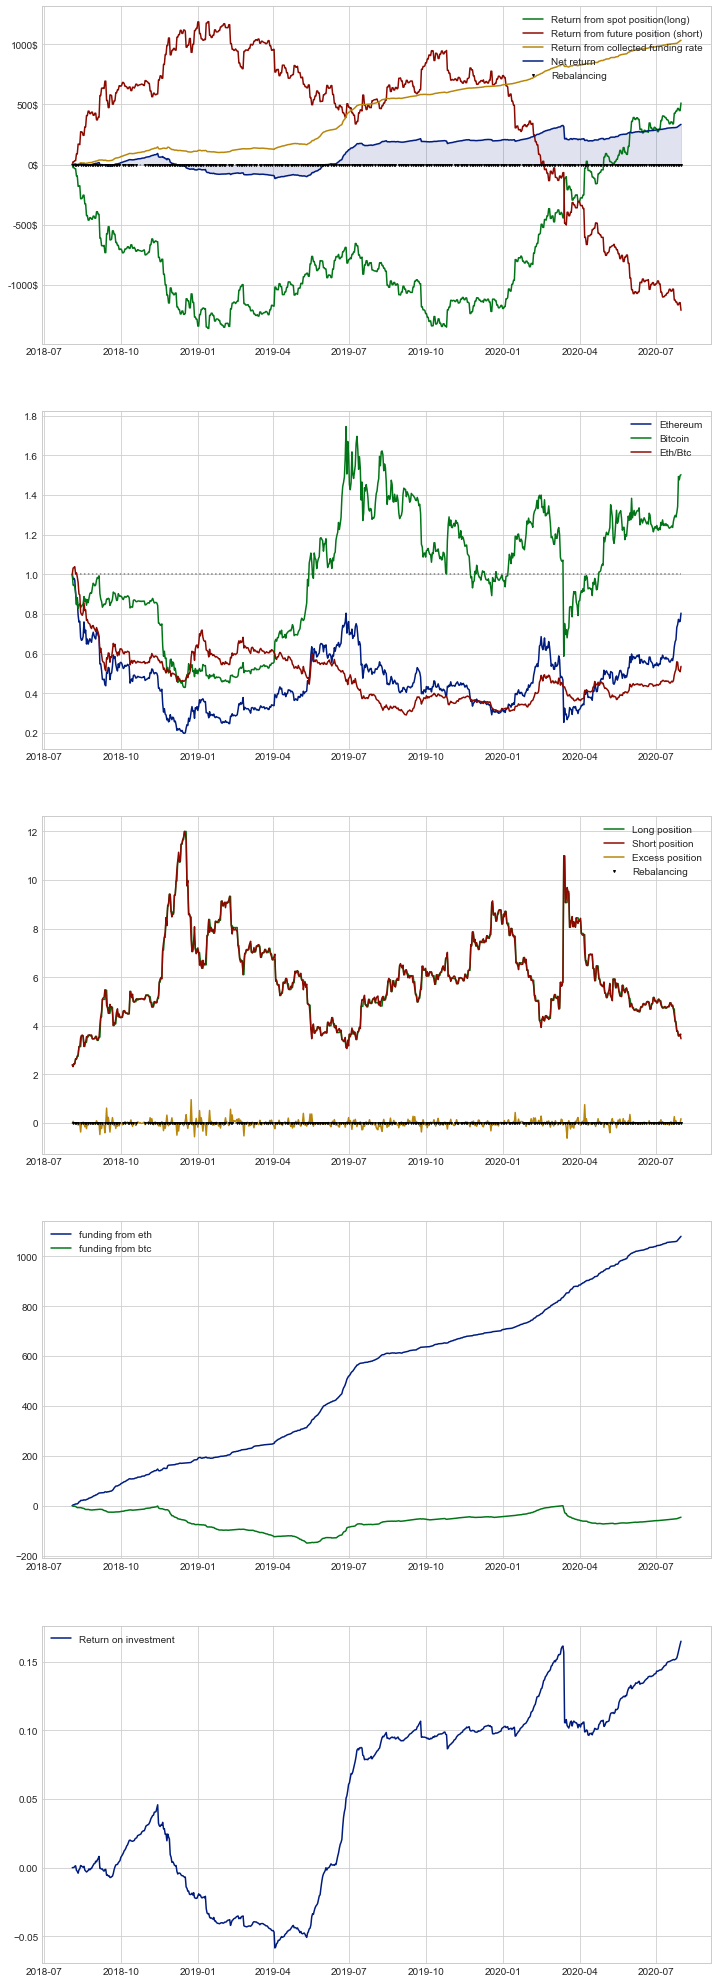

In [10]:
start_date = "2018-08-01"
end_date   = "2020-08-01"
investment = -1000
rebalancing_check = 1
list_of_res = []
while start_date < end_date:
    a= check_quanto_returns(investment,df,start_date, end_date , strategy="long_short",TYPE=structure, 
                           comparison=True, complete=True, show_prices=True,show_hedge=True,
                           btc_fixed=False, eth_fixed=False, add_bias_eth=0, add_bias_btc=0, hedge_btc=True, 
                           do_rebalancing=True, rebalancing_check=rebalancing_check, rebalancing_param=0.01)
    investment = - a["total_investment"][len(a)-1] / 2         # Reinvest everything in the two legs
    print("Reinvest:", investment)
    start_date = str( a.index[len(a)-1]  + timedelta(days=1) ) #Start the following day
    list_of_res.append(a)                                      #Stack together the results
    if str(a.index[len(a.index)-1]  + timedelta(days=rebalancing_check)) >= end_date: break # Close if bigger than today

# merge together all the result coming from each rebalancing
my_res = pd.DataFrame(list_of_res[0])
rebalancings = [list_of_res[0].index.max()]
for k in range(1,len(list_of_res)):
    my_res = my_res.append(pd.DataFrame(list_of_res[k]))
    rebalancings.append(list_of_res[k].index.max())

# Calculate again cumulative values from daily
my_res.return_funding_cum_eth         = cumulative_return(my_res.return_funding)
my_res.return_funding_cum_btc         = cumulative_return(my_res.return_funding_btc)
my_res.return_funding_cum             = my_res.return_funding_cum_btc + my_res.return_funding_cum_eth
my_res.total_return_dollar_spot       = cumulative_return(my_res.return_dollar_from_spot)
my_res.total_return_dollar_from_short = cumulative_return(my_res.return_dollar_from_short)
my_res.net_return                     = my_res.return_funding_cum + my_res.total_return_dollar_spot+my_res.total_return_dollar_from_short

my_res = calculate_final_results(my_res)
Plot_results_arb(my_res, strategy="long_short",complete=True,comparison=False, hedge_btc=True,show_prices=True,show_hedge=True,funding_analysis=True,show_roi=True, reb = True, rebalancings=rebalancings)
stats = output_stats(my_res, list_of_res)
stats
# when rebalancing happen
# broken line when rebalance for portfolio value bitmex
# btc and naming for non-eth non-quanto 

## Parameters selection

In [9]:
df_stats = pd.DataFrame(columns=["asset","total return","annual return","annual std","sharpe","Number of days","Number of rebalances"])
rebalancing_params = np.arange(0,100,1)/100

for rebalancing_param in rebalancing_params:

    start_date = "2018-08-01"
    end_date   = "2020-08-01"
    investment = -1000
    rebalancing_check = 1
    list_of_res = []
    while start_date < end_date:
        a= check_quanto_returns(investment,df,start_date, end_date , strategy="long_short",TYPE=structure, 
                               comparison=True, complete=True, show_prices=True,show_hedge=True,
                               btc_fixed=False, eth_fixed=False, add_bias_eth=0, add_bias_btc=0, hedge_btc=True, 
                               do_rebalancing=True, rebalancing_check=rebalancing_check, rebalancing_param=rebalancing_param)
        investment = - a["total_investment"][len(a)-1] / 2         # Reinvest everything in the two legs
        print("Reinvest:", investment)
        start_date = str( a.index[len(a)-1]  + timedelta(days=1) ) #Start the following day
        list_of_res.append(a)                                      #Stack together the results
        if str(a.index[len(a.index)-1]  + timedelta(days=rebalancing_check)) >= end_date: break # Close if bigger than today

    # merge together all the result coming from each rebalancing
    my_res = pd.DataFrame(list_of_res[0])
    rebalancings = [list_of_res[0].index.max()]
    for k in range(1,len(list_of_res)):
        my_res = my_res.append(pd.DataFrame(list_of_res[k]))
        rebalancings.append(list_of_res[k].index.max())

    # Calculate again cumulative values from daily
    my_res.return_funding_cum_eth         = cumulative_return(my_res.return_funding)
    my_res.return_funding_cum_btc         = cumulative_return(my_res.return_funding_btc)
    my_res.return_funding_cum             = my_res.return_funding_cum_btc + my_res.return_funding_cum_eth
    my_res.total_return_dollar_spot       = cumulative_return(my_res.return_dollar_from_spot)
    my_res.total_return_dollar_from_short = cumulative_return(my_res.return_dollar_from_short)
    my_res.net_return                     = my_res.return_funding_cum + my_res.total_return_dollar_spot+my_res.total_return_dollar_from_short

    my_res = calculate_final_results(my_res)
    #Plot_results_arb(my_res, strategy="long_short",complete=True,comparison=False, hedge_btc=True,show_prices=True,show_hedge=True,funding_analysis=True,show_roi=True)
    stats = output_stats(my_res, list_of_res)
    
    df_stats = df_stats.append(stats)
    # when rebalancing happen
    # broken line when rebalance for portfolio value bitmex
    # btc and naming for non-eth non-quanto 

 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-05 00:00:00 value of bitmex: 1.025723393072714
Reinvest: -1000.7456710005254


 [############################################################] 0/727 [0<0, 0.00s/it]

Rebalancing in date 2018-08-07 00:00:00 value of bitmex: 1.0102139842099374
Reinvest: -1001.5968624230354


 [############################################################] 0/725 [0<0, 0.00s/it]

Rebalancing in date 2018-08-09 00:00:00 value of bitmex: 1.0532405025355933
Reinvest: -998.6835378431313


 [############################################################] 0/723 [0<0, 0.00s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.0841920787853765
Reinvest: -996.51919441731


 [############################################################] 0/721 [0<0, 0.00s/it]

Rebalancing in date 2018-08-13 00:00:00 value of bitmex: 0.9963774288248138
Reinvest: -999.6835601245491


 [############################################################] 0/719 [0<0, 0.00s/it]

Rebalancing in date 2018-08-15 00:00:00 value of bitmex: 1.0190576542981147
Reinvest: -1001.5977403618597


 [############################################################] 0/717 [0<0, 0.00s/it]

Rebalancing in date 2018-08-17 00:00:00 value of bitmex: 0.9758281250039789
Reinvest: -1000.8801639049666


 [############################################################] 0/715 [0<0, 0.00s/it]

Rebalancing in date 2018-08-19 00:00:00 value of bitmex: 1.0670348351537868
Reinvest: -998.8309877835383


 [############################################################] 0/713 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.095840345721663
Reinvest: -997.367385149812


 [############################################################] 0/711 [0<0, 0.00s/it]

Rebalancing in date 2018-08-23 00:00:00 value of bitmex: 1.0395041152008593
Reinvest: -998.4613025985591


 [############################################################] 0/709 [0<0, 0.00s/it]

Rebalancing in date 2018-08-25 00:00:00 value of bitmex: 0.9777714229809173
Reinvest: -998.84928359831


 [############################################################] 0/707 [0<0, 0.00s/it]

Rebalancing in date 2018-08-27 00:00:00 value of bitmex: 1.0129586039283311
Reinvest: -999.8383860205874


 [############################################################] 0/705 [0<0, 0.00s/it]

Rebalancing in date 2018-08-29 00:00:00 value of bitmex: 0.9765270871748567
Reinvest: -1002.2478461724887


 [############################################################] 0/703 [0<0, 0.00s/it]

Rebalancing in date 2018-08-31 00:00:00 value of bitmex: 1.0177366121537326
Reinvest: -1003.5357342931006


 [############################################################] 0/701 [0<0, 0.00s/it]

Rebalancing in date 2018-09-02 00:00:00 value of bitmex: 0.9454388599470986
Reinvest: -1004.8113073911156


 [############################################################] 0/699 [0<0, 0.00s/it]

Rebalancing in date 2018-09-04 00:00:00 value of bitmex: 1.0242115718758156
Reinvest: -1007.3915274157966


 [############################################################] 0/697 [0<0, 0.00s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.1794433781333296
Reinvest: -1000.0822721241695


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.0610926107773924
Reinvest: -999.5847650337284


 [############################################################] 0/693 [0<0, 0.00s/it]

Rebalancing in date 2018-09-10 00:00:00 value of bitmex: 1.0006274470322005
Reinvest: -998.5696071995932


 [############################################################] 0/691 [0<0, 0.00s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.061551474472388
Reinvest: -998.6612846100213


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028873
Reinvest: -994.5171609093952


 [############################################################] 0/687 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.9393042028293087
Reinvest: -994.0088110966478


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.1078294176571752
Reinvest: -992.8911894012165


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-20 00:00:00 value of bitmex: 0.9951157018294141
Reinvest: -993.4678886865272


 [############################################################] 0/681 [0<0, 0.00s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.8948419803487198
Reinvest: -994.40182340458


 [############################################################] 0/679 [0<0, 0.00s/it]

Rebalancing in date 2018-09-24 00:00:00 value of bitmex: 0.9877666800074133
Reinvest: -999.4803755654771


 [############################################################] 0/677 [0<0, 0.00s/it]

Rebalancing in date 2018-09-26 00:00:00 value of bitmex: 1.0373260343317419
Reinvest: -1001.4035888977407


 [############################################################] 0/675 [0<0, 0.00s/it]

Rebalancing in date 2018-09-28 00:00:00 value of bitmex: 0.9293773298591262
Reinvest: -1001.3826070485844


 [############################################################] 0/673 [0<0, 0.00s/it]

Rebalancing in date 2018-09-30 00:00:00 value of bitmex: 0.9575242872702217
Reinvest: -1003.3466783891099


 [############################################################] 0/671 [0<0, 0.00s/it]

Rebalancing in date 2018-10-02 00:00:00 value of bitmex: 1.0096403959205678
Reinvest: -1006.6380183472933


 [############################################################] 0/669 [0<0, 0.00s/it]

Rebalancing in date 2018-10-04 00:00:00 value of bitmex: 1.0269729961326102
Reinvest: -1008.8822770791717


 [############################################################] 0/667 [0<0, 0.00s/it]

Rebalancing in date 2018-10-06 00:00:00 value of bitmex: 0.9792952817025415
Reinvest: -1011.4142158477307


 [############################################################] 0/665 [0<0, 0.00s/it]

Rebalancing in date 2018-10-08 00:00:00 value of bitmex: 0.9993352355831647
Reinvest: -1014.1527240110097


 [############################################################] 0/663 [0<0, 0.00s/it]

Rebalancing in date 2018-10-10 00:00:00 value of bitmex: 1.0097436196518443
Reinvest: -1016.7250647827282


 [############################################################] 0/661 [0<0, 0.00s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1479252188579285
Reinvest: -1014.0275969266493


 [############################################################] 0/659 [0<0, 0.00s/it]

Rebalancing in date 2018-10-14 00:00:00 value of bitmex: 0.9814226481585538
Reinvest: -1013.3392924936635


 [############################################################] 0/657 [0<0, 0.00s/it]

Rebalancing in date 2018-10-16 00:00:00 value of bitmex: 0.9347164468281728
Reinvest: -1012.161574037636


 [############################################################] 0/655 [0<0, 0.00s/it]

Rebalancing in date 2018-10-18 00:00:00 value of bitmex: 1.0139318800090877
Reinvest: -1013.6139881920528


 [############################################################] 0/653 [0<0, 0.00s/it]

Rebalancing in date 2018-10-20 00:00:00 value of bitmex: 0.9955885915533497
Reinvest: -1014.4617530145387


 [############################################################] 0/651 [0<0, 0.00s/it]

Rebalancing in date 2018-10-22 00:00:00 value of bitmex: 1.002322329280086
Reinvest: -1016.2856235588542


 [############################################################] 0/649 [0<0, 0.00s/it]

Rebalancing in date 2018-10-24 00:00:00 value of bitmex: 1.0008465917664717
Reinvest: -1016.9159761179445


 [############################################################] 0/647 [0<0, 0.00s/it]

Rebalancing in date 2018-10-26 00:00:00 value of bitmex: 1.0060134890298635
Reinvest: -1018.6325354274439


 [############################################################] 0/645 [0<0, 0.00s/it]

Rebalancing in date 2018-10-28 00:00:00 value of bitmex: 0.9953707201600556
Reinvest: -1019.5323011343698


 [############################################################] 0/643 [0<0, 0.00s/it]

Rebalancing in date 2018-10-30 00:00:00 value of bitmex: 1.0430517658381595
Reinvest: -1020.8911357468634


 [############################################################] 0/641 [0<0, 0.00s/it]

Rebalancing in date 2018-11-01 00:00:00 value of bitmex: 0.993909196067515
Reinvest: -1023.3460766336968


 [############################################################] 0/639 [0<0, 0.00s/it]

Rebalancing in date 2018-11-03 00:00:00 value of bitmex: 0.9894570131061492
Reinvest: -1024.0734760318521


 [############################################################] 0/637 [0<0, 0.00s/it]

Rebalancing in date 2018-11-05 00:00:00 value of bitmex: 0.9422183500745422
Reinvest: -1026.4933062482676


 [############################################################] 0/635 [0<0, 0.00s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.956106494128542
Reinvest: -1029.4602668135665


 [############################################################] 0/633 [0<0, 0.00s/it]

Rebalancing in date 2018-11-09 00:00:00 value of bitmex: 1.0292801753275858
Reinvest: -1030.7841546814334


 [############################################################] 0/631 [0<0, 0.00s/it]

Rebalancing in date 2018-11-11 00:00:00 value of bitmex: 0.987732685456291
Reinvest: -1033.0818786735476


 [############################################################] 0/629 [0<0, 0.00s/it]

Rebalancing in date 2018-11-13 00:00:00 value of bitmex: 1.0104454948979495
Reinvest: -1035.8431144340473


 [############################################################] 0/627 [0<0, 0.00s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.0985549277843718
Reinvest: -1024.9373783065494


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-17 00:00:00 value of bitmex: 1.0334451620636789
Reinvest: -1022.6705496431746


 [############################################################] 0/623 [0<0, 0.00s/it]

Rebalancing in date 2018-11-19 00:00:00 value of bitmex: 0.9800325347057205
Reinvest: -1023.5476183948927


 [############################################################] 0/621 [0<0, 0.00s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.1117445402658583
Reinvest: -1020.9390895557888


 [############################################################] 0/619 [0<0, 0.00s/it]

Rebalancing in date 2018-11-23 00:00:00 value of bitmex: 1.0769999547476137
Reinvest: -1016.9193883400993


 [############################################################] 0/617 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.0746433130247135
Reinvest: -1012.2004552112186


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.0591067463707067
Reinvest: -1015.1226570854351


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997076
Reinvest: -1002.1895999115408


 [############################################################] 0/611 [0<0, 0.00s/it]

Rebalancing in date 2018-12-01 00:00:00 value of bitmex: 1.0322535397783834
Reinvest: -996.655079985379


 [############################################################] 0/609 [0<0, 0.00s/it]

Rebalancing in date 2018-12-03 00:00:00 value of bitmex: 1.0142328947395274
Reinvest: -996.1896073295059


 [############################################################] 0/607 [0<0, 0.00s/it]

Rebalancing in date 2018-12-05 00:00:00 value of bitmex: 0.9849408119098733
Reinvest: -994.203030722537


 [############################################################] 0/605 [0<0, 0.00s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.106958308944485
Reinvest: -990.1265398607079


 [############################################################] 0/603 [0<0, 0.00s/it]

Rebalancing in date 2018-12-09 00:00:00 value of bitmex: 1.0223369583328326
Reinvest: -988.8368189714506


 [############################################################] 0/601 [0<0, 0.00s/it]

Rebalancing in date 2018-12-11 00:00:00 value of bitmex: 1.0365244123502217
Reinvest: -988.569651504028


 [############################################################] 0/599 [0<0, 0.00s/it]

Rebalancing in date 2018-12-13 00:00:00 value of bitmex: 0.9741054343663549
Reinvest: -986.9219372733306


 [############################################################] 0/597 [0<0, 0.00s/it]

Rebalancing in date 2018-12-15 00:00:00 value of bitmex: 1.0275547690677276
Reinvest: -986.3778215126106


 [############################################################] 0/595 [0<0, 0.00s/it]

Rebalancing in date 2018-12-17 00:00:00 value of bitmex: 0.990362323331558
Reinvest: -986.0088698516179


 [############################################################] 0/593 [0<0, 0.00s/it]

Rebalancing in date 2018-12-19 00:00:00 value of bitmex: 0.9157214221291458
Reinvest: -982.3048582109848


 [############################################################] 0/591 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8277322222730504
Reinvest: -972.0997680349897


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-23 00:00:00 value of bitmex: 0.9240149791107385
Reinvest: -969.9827373114249


 [############################################################] 0/587 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.9256424984455187
Reinvest: -969.7558485934202


 [############################################################] 0/585 [0<0, 0.00s/it]

Rebalancing in date 2018-12-27 00:00:00 value of bitmex: 0.9906683183193632
Reinvest: -972.4019293817738


 [############################################################] 0/583 [0<0, 0.00s/it]

Rebalancing in date 2018-12-29 00:00:00 value of bitmex: 0.7887804769742708
Reinvest: -963.9619231265425


 [############################################################] 0/581 [0<0, 0.00s/it]

Rebalancing in date 2018-12-31 00:00:00 value of bitmex: 0.9629202072259144
Reinvest: -963.8004589612234


 [############################################################] 0/579 [0<0, 0.00s/it]

Rebalancing in date 2019-01-02 00:00:00 value of bitmex: 0.9337939109823299
Reinvest: -966.9401808139671


 [############################################################] 0/577 [0<0, 0.00s/it]

Rebalancing in date 2019-01-04 00:00:00 value of bitmex: 1.0402449919677876
Reinvest: -966.3109053908232


 [############################################################] 0/575 [0<0, 0.00s/it]

Rebalancing in date 2019-01-06 00:00:00 value of bitmex: 0.9968167052219346
Reinvest: -964.3878928219292


 [############################################################] 0/573 [0<0, 0.00s/it]

Rebalancing in date 2019-01-08 00:00:00 value of bitmex: 1.033604549913534
Reinvest: -965.1858734556599


 [############################################################] 0/571 [0<0, 0.00s/it]

Rebalancing in date 2019-01-10 00:00:00 value of bitmex: 0.9992708309984466
Reinvest: -965.8468260658408


 [############################################################] 0/569 [0<0, 0.00s/it]

Rebalancing in date 2019-01-12 00:00:00 value of bitmex: 0.9957746638848738
Reinvest: -961.2464184692388


 [############################################################] 0/567 [0<0, 0.00s/it]

Rebalancing in date 2019-01-14 00:00:00 value of bitmex: 1.069874119552332
Reinvest: -960.0188410189211


 [############################################################] 0/565 [0<0, 0.00s/it]

Rebalancing in date 2019-01-16 00:00:00 value of bitmex: 1.0634350931036491
Reinvest: -958.1729213456514


 [############################################################] 0/563 [0<0, 0.00s/it]

Rebalancing in date 2019-01-18 00:00:00 value of bitmex: 0.9978266844055544
Reinvest: -957.9996891328055


 [############################################################] 0/561 [0<0, 0.00s/it]

Rebalancing in date 2019-01-20 00:00:00 value of bitmex: 0.9735032832121113
Reinvest: -958.5815851719292


 [############################################################] 0/559 [0<0, 0.00s/it]

Rebalancing in date 2019-01-22 00:00:00 value of bitmex: 1.0120236863083683
Reinvest: -957.0679516064192


 [############################################################] 0/557 [0<0, 0.00s/it]

Rebalancing in date 2019-01-24 00:00:00 value of bitmex: 1.0114309424406216
Reinvest: -955.596847708908


 [############################################################] 0/555 [0<0, 0.00s/it]

Rebalancing in date 2019-01-26 00:00:00 value of bitmex: 1.0112513666640168
Reinvest: -955.2683901254422


 [############################################################] 0/553 [0<0, 0.00s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.0323830168246393
Reinvest: -955.6155394736991


 [############################################################] 0/551 [0<0, 0.00s/it]

Rebalancing in date 2019-01-30 00:00:00 value of bitmex: 1.0120115878509532
Reinvest: -955.8394566317768


 [############################################################] 0/549 [0<0, 0.00s/it]

Rebalancing in date 2019-02-01 00:00:00 value of bitmex: 1.0167852137575952
Reinvest: -955.7190556836165


 [############################################################] 0/547 [0<0, 0.00s/it]

Rebalancing in date 2019-02-03 00:00:00 value of bitmex: 0.9670090057518742
Reinvest: -956.3217248343392


 [############################################################] 0/545 [0<0, 0.00s/it]

Rebalancing in date 2019-02-05 00:00:00 value of bitmex: 0.9997561632601647
Reinvest: -957.3458137633518


 [############################################################] 0/543 [0<0, 0.00s/it]

Rebalancing in date 2019-02-07 00:00:00 value of bitmex: 1.0260038596935952
Reinvest: -957.7828384461766


 [############################################################] 0/541 [0<0, 0.00s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8408586926324285
Reinvest: -953.9366386419616


 [############################################################] 0/539 [0<0, 0.00s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.9539856358254042
Reinvest: -957.518918216462


 [############################################################] 0/537 [0<0, 0.00s/it]

Rebalancing in date 2019-02-13 00:00:00 value of bitmex: 0.9917503701494268
Reinvest: -958.8916891341107


 [############################################################] 0/535 [0<0, 0.00s/it]

Rebalancing in date 2019-02-15 00:00:00 value of bitmex: 1.0117231394204755
Reinvest: -959.4408548963028


 [############################################################] 0/533 [0<0, 0.00s/it]

Rebalancing in date 2019-02-17 00:00:00 value of bitmex: 0.9902009294290613
Reinvest: -960.4602742693988


 [############################################################] 0/531 [0<0, 0.00s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.9007287686744762
Reinvest: -958.8002666034463


 [############################################################] 0/529 [0<0, 0.00s/it]

Rebalancing in date 2019-02-21 00:00:00 value of bitmex: 0.967991703770867
Reinvest: -958.9006821475731


 [############################################################] 0/527 [0<0, 0.00s/it]

Rebalancing in date 2019-02-23 00:00:00 value of bitmex: 0.983837723666245
Reinvest: -960.5112199282155


 [############################################################] 0/525 [0<0, 0.00s/it]

Rebalancing in date 2019-02-25 00:00:00 value of bitmex: 1.1487374091932552
Reinvest: -953.646554266621


 [############################################################] 0/523 [0<0, 0.00s/it]

Rebalancing in date 2019-02-27 00:00:00 value of bitmex: 1.0119342469247785
Reinvest: -953.1312853974623


 [############################################################] 0/521 [0<0, 0.00s/it]

Rebalancing in date 2019-03-01 00:00:00 value of bitmex: 0.9980657518969066
Reinvest: -953.079981192378


 [############################################################] 0/519 [0<0, 0.00s/it]

Rebalancing in date 2019-03-03 00:00:00 value of bitmex: 1.0178471828122018
Reinvest: -953.5666436116871


 [############################################################] 0/517 [0<0, 0.00s/it]

Rebalancing in date 2019-03-05 00:00:00 value of bitmex: 1.0349990672864442
Reinvest: -953.3825772617984


 [############################################################] 0/515 [0<0, 0.00s/it]

Rebalancing in date 2019-03-07 00:00:00 value of bitmex: 0.9955394421139964
Reinvest: -954.8198645631663


 [############################################################] 0/513 [0<0, 0.00s/it]

Rebalancing in date 2019-03-09 00:00:00 value of bitmex: 1.0279927546416305
Reinvest: -956.6530561400882


 [############################################################] 0/511 [0<0, 0.00s/it]

Rebalancing in date 2019-03-11 00:00:00 value of bitmex: 1.0125959047788677
Reinvest: -956.4214498928582


 [############################################################] 0/509 [0<0, 0.00s/it]

Rebalancing in date 2019-03-13 00:00:00 value of bitmex: 0.9918612177934336
Reinvest: -955.7886900430485


 [############################################################] 0/507 [0<0, 0.00s/it]

Rebalancing in date 2019-03-15 00:00:00 value of bitmex: 0.9977316831435399
Reinvest: -955.1857071609294


 [############################################################] 0/505 [0<0, 0.00s/it]

Rebalancing in date 2019-03-17 00:00:00 value of bitmex: 0.9657876774289454
Reinvest: -954.9027034451533


 [############################################################] 0/503 [0<0, 0.00s/it]

Rebalancing in date 2019-03-19 00:00:00 value of bitmex: 1.0089420416675547
Reinvest: -955.1955420650077


 [############################################################] 0/501 [0<0, 0.00s/it]

Rebalancing in date 2019-03-21 00:00:00 value of bitmex: 0.9946138854148026
Reinvest: -954.5399707134911


 [############################################################] 0/499 [0<0, 0.00s/it]

Rebalancing in date 2019-03-23 00:00:00 value of bitmex: 0.9889792575900607
Reinvest: -953.6487465853086


 [############################################################] 0/497 [0<0, 0.00s/it]

Rebalancing in date 2019-03-25 00:00:00 value of bitmex: 1.0086582467573368
Reinvest: -953.3622459572111


 [############################################################] 0/495 [0<0, 0.00s/it]

Rebalancing in date 2019-03-27 00:00:00 value of bitmex: 0.9961963631253911
Reinvest: -951.9836772073879


 [############################################################] 0/493 [0<0, 0.00s/it]

Rebalancing in date 2019-03-29 00:00:00 value of bitmex: 1.0107350722727197
Reinvest: -952.0338582563056


 [############################################################] 0/491 [0<0, 0.00s/it]

Rebalancing in date 2019-03-31 00:00:00 value of bitmex: 1.0033648788747371
Reinvest: -951.0980245588644


 [############################################################] 0/489 [0<0, 0.00s/it]

Rebalancing in date 2019-04-02 00:00:00 value of bitmex: 0.998548341194405
Reinvest: -949.9511174321378


 [############################################################] 0/487 [0<0, 0.00s/it]

Rebalancing in date 2019-04-04 00:00:00 value of bitmex: 1.0218721915908127
Reinvest: -953.8138503632742


 [############################################################] 0/485 [0<0, 0.00s/it]

Rebalancing in date 2019-04-06 00:00:00 value of bitmex: 0.9479306049179851
Reinvest: -956.302380460304


 [############################################################] 0/483 [0<0, 0.00s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9459694684189697
Reinvest: -958.0985825303483


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-10 00:00:00 value of bitmex: 1.0287821061763314
Reinvest: -959.8991541503008


 [############################################################] 0/479 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0688651556151627
Reinvest: -960.4082351028659


 [############################################################] 0/477 [0<0, 0.00s/it]

Rebalancing in date 2019-04-14 00:00:00 value of bitmex: 1.0006401417653787
Reinvest: -960.9808761713946


 [############################################################] 0/475 [0<0, 0.00s/it]

Rebalancing in date 2019-04-16 00:00:00 value of bitmex: 1.0482714908219828
Reinvest: -962.6194928970848


 [############################################################] 0/473 [0<0, 0.00s/it]

Rebalancing in date 2019-04-18 00:00:00 value of bitmex: 1.001752706016978
Reinvest: -965.0355852899775


 [############################################################] 0/471 [0<0, 0.00s/it]

Rebalancing in date 2019-04-20 00:00:00 value of bitmex: 1.0047491560011856
Reinvest: -966.1412428224754


 [############################################################] 0/469 [0<0, 0.00s/it]

Rebalancing in date 2019-04-22 00:00:00 value of bitmex: 1.0233967286992063
Reinvest: -967.1272463321883


 [############################################################] 0/467 [0<0, 0.00s/it]

Rebalancing in date 2019-04-24 00:00:00 value of bitmex: 1.010298727128933
Reinvest: -969.0472216775354


 [############################################################] 0/465 [0<0, 0.00s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.0802299397543873
Reinvest: -967.819121071948


 [############################################################] 0/463 [0<0, 0.00s/it]

Rebalancing in date 2019-04-28 00:00:00 value of bitmex: 0.9852351361757458
Reinvest: -967.790221293149


 [############################################################] 0/461 [0<0, 0.00s/it]

Rebalancing in date 2019-04-30 00:00:00 value of bitmex: 1.0090888726361928
Reinvest: -967.646813626361


 [############################################################] 0/459 [0<0, 0.00s/it]

Rebalancing in date 2019-05-02 00:00:00 value of bitmex: 1.0109132729623769
Reinvest: -966.0427458291933


 [############################################################] 0/457 [0<0, 0.00s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9614001163394201
Reinvest: -965.8518275086362


 [############################################################] 0/455 [0<0, 0.00s/it]

Rebalancing in date 2019-05-06 00:00:00 value of bitmex: 1.004007831108127
Reinvest: -964.1317953806408


 [############################################################] 0/453 [0<0, 0.00s/it]

Rebalancing in date 2019-05-08 00:00:00 value of bitmex: 1.0312909796443328
Reinvest: -964.4595496061237


 [############################################################] 0/451 [0<0, 0.00s/it]

Rebalancing in date 2019-05-10 00:00:00 value of bitmex: 0.9925414702016138
Reinvest: -962.4045433626839


 [############################################################] 0/449 [0<0, 0.00s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.8653906390816043
Reinvest: -956.8014321117944


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 0.9558078830876969
Reinvest: -958.256401340539


 [############################################################] 0/445 [0<0, 0.00s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.8597808509667878
Reinvest: -960.6320810312911


 [############################################################] 0/443 [0<0, 0.00s/it]

Rebalancing in date 2019-05-18 00:00:00 value of bitmex: 1.0757124381704923
Reinvest: -965.0078616150233


 [############################################################] 0/441 [0<0, 0.00s/it]

Rebalancing in date 2019-05-20 00:00:00 value of bitmex: 0.8737631366136547
Reinvest: -960.4163646471656


 [############################################################] 0/439 [0<0, 0.00s/it]

Rebalancing in date 2019-05-22 00:00:00 value of bitmex: 0.9932995099890123
Reinvest: -964.2568971379749


 [############################################################] 0/437 [0<0, 0.00s/it]

Rebalancing in date 2019-05-24 00:00:00 value of bitmex: 0.9930038295686017
Reinvest: -966.8778387851073


 [############################################################] 0/435 [0<0, 0.00s/it]

Rebalancing in date 2019-05-26 00:00:00 value of bitmex: 0.9967163320105304
Reinvest: -972.4673286615416


 [############################################################] 0/433 [0<0, 0.00s/it]

Rebalancing in date 2019-05-28 00:00:00 value of bitmex: 0.9989831972314067
Reinvest: -980.7915461388496


 [############################################################] 0/431 [0<0, 0.00s/it]

Rebalancing in date 2019-05-30 00:00:00 value of bitmex: 1.0133271863460034
Reinvest: -988.8662176569478


 [############################################################] 0/429 [0<0, 0.00s/it]

Rebalancing in date 2019-06-01 00:00:00 value of bitmex: 0.94855110071998
Reinvest: -992.6229843425922


 [############################################################] 0/427 [0<0, 0.00s/it]

Rebalancing in date 2019-06-03 00:00:00 value of bitmex: 0.9882558614146246
Reinvest: -995.7138858096955


 [############################################################] 0/425 [0<0, 0.00s/it]

Rebalancing in date 2019-06-05 00:00:00 value of bitmex: 1.0349236804553477
Reinvest: -996.9348804329692


 [############################################################] 0/423 [0<0, 0.00s/it]

Rebalancing in date 2019-06-07 00:00:00 value of bitmex: 0.9866539001545884
Reinvest: -997.9514516241237


 [############################################################] 0/421 [0<0, 0.00s/it]

Rebalancing in date 2019-06-09 00:00:00 value of bitmex: 1.0216968444037742
Reinvest: -1000.0313038536443


 [############################################################] 0/419 [0<0, 0.00s/it]

Rebalancing in date 2019-06-11 00:00:00 value of bitmex: 0.929355049487862
Reinvest: -999.2209531594428


 [############################################################] 0/417 [0<0, 0.00s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.928375002245288
Reinvest: -999.0309442954156


 [############################################################] 0/415 [0<0, 0.00s/it]

Rebalancing in date 2019-06-15 00:00:00 value of bitmex: 0.9662789961166012
Reinvest: -999.7100824846575


 [############################################################] 0/413 [0<0, 0.00s/it]

Rebalancing in date 2019-06-17 00:00:00 value of bitmex: 1.008450012604948
Reinvest: -1005.6565056322769


 [############################################################] 0/411 [0<0, 0.00s/it]

Rebalancing in date 2019-06-19 00:00:00 value of bitmex: 1.0388809308486238
Reinvest: -1010.561935186123


 [############################################################] 0/409 [0<0, 0.00s/it]

Rebalancing in date 2019-06-21 00:00:00 value of bitmex: 0.9896255889595327
Reinvest: -1014.8818743644488


 [############################################################] 0/407 [0<0, 0.00s/it]

Rebalancing in date 2019-06-23 00:00:00 value of bitmex: 0.9734975626888103
Reinvest: -1026.187053224883


 [############################################################] 0/405 [0<0, 0.00s/it]

Rebalancing in date 2019-06-25 00:00:00 value of bitmex: 0.9935335517031036
Reinvest: -1037.15897756184


 [############################################################] 0/403 [0<0, 0.00s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.9515246255500347
Reinvest: -1045.5563560936369


 [############################################################] 0/401 [0<0, 0.00s/it]

Rebalancing in date 2019-06-29 00:00:00 value of bitmex: 0.949335175249938
Reinvest: -1058.2064049641665


 [############################################################] 0/399 [0<0, 0.00s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.0802743117532718
Reinvest: -1058.9962097148587


 [############################################################] 0/397 [0<0, 0.00s/it]

Rebalancing in date 2019-07-03 00:00:00 value of bitmex: 1.0127014868669004
Reinvest: -1066.0145442233727


 [############################################################] 0/395 [0<0, 0.00s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.0627897628236338
Reinvest: -1066.9556413841365


 [############################################################] 0/393 [0<0, 0.00s/it]

Rebalancing in date 2019-07-07 00:00:00 value of bitmex: 1.0058649315677863
Reinvest: -1072.4207053715709


 [############################################################] 0/391 [0<0, 0.00s/it]

Rebalancing in date 2019-07-09 00:00:00 value of bitmex: 0.9822223327918599
Reinvest: -1078.3485923268854


 [############################################################] 0/389 [0<0, 0.00s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.060073399928843
Reinvest: -1082.0592454077384


 [############################################################] 0/387 [0<0, 0.00s/it]

Rebalancing in date 2019-07-13 00:00:00 value of bitmex: 0.9753954154768515
Reinvest: -1084.6338439873384


 [############################################################] 0/385 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.142679069052132
Reinvest: -1076.4400588501458


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.111071048071472
Reinvest: -1066.4082262507775


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342863
Reinvest: -1063.1970793521502


 [############################################################] 0/379 [0<0, 0.00s/it]

Rebalancing in date 2019-07-21 00:00:00 value of bitmex: 0.966688890982711
Reinvest: -1063.4412110569574


 [############################################################] 0/377 [0<0, 0.00s/it]

Rebalancing in date 2019-07-23 00:00:00 value of bitmex: 1.0370716859663642
Reinvest: -1063.2723296720883


 [############################################################] 0/375 [0<0, 0.00s/it]

Rebalancing in date 2019-07-25 00:00:00 value of bitmex: 0.9789963906216229
Reinvest: -1064.3716404444922


 [############################################################] 0/373 [0<0, 0.00s/it]

Rebalancing in date 2019-07-27 00:00:00 value of bitmex: 1.0004783159621167
Reinvest: -1065.6741803244315


 [############################################################] 0/371 [0<0, 0.00s/it]

Rebalancing in date 2019-07-29 00:00:00 value of bitmex: 0.9801768097764313
Reinvest: -1066.0834495147192


 [############################################################] 0/369 [0<0, 0.00s/it]

Rebalancing in date 2019-07-31 00:00:00 value of bitmex: 1.0041331204479935
Reinvest: -1067.604225562159


 [############################################################] 0/367 [0<0, 0.00s/it]

Rebalancing in date 2019-08-02 00:00:00 value of bitmex: 1.0055417698290534
Reinvest: -1069.5706883187459


 [############################################################] 0/365 [0<0, 0.00s/it]

Rebalancing in date 2019-08-04 00:00:00 value of bitmex: 0.9799687322052953
Reinvest: -1071.3725105261965


 [############################################################] 0/363 [0<0, 0.00s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.9552898306049603
Reinvest: -1073.0940291103884


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-08 00:00:00 value of bitmex: 1.0032218874872305
Reinvest: -1078.3378693817183


 [############################################################] 0/359 [0<0, 0.00s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.0491541498342736
Reinvest: -1080.5714029267203


 [############################################################] 0/357 [0<0, 0.00s/it]

Rebalancing in date 2019-08-12 00:00:00 value of bitmex: 0.9510330975799675
Reinvest: -1081.2936874819382


 [############################################################] 0/355 [0<0, 0.00s/it]

Rebalancing in date 2019-08-14 00:00:00 value of bitmex: 1.0152625553849992
Reinvest: -1083.1501440738796


 [############################################################] 0/353 [0<0, 0.00s/it]

Rebalancing in date 2019-08-16 00:00:00 value of bitmex: 0.9909906423617706
Reinvest: -1083.5321756903022


 [############################################################] 0/351 [0<0, 0.00s/it]

Rebalancing in date 2019-08-18 00:00:00 value of bitmex: 0.9961179189534264
Reinvest: -1082.8015468570713


 [############################################################] 0/349 [0<0, 0.00s/it]

Rebalancing in date 2019-08-20 00:00:00 value of bitmex: 0.9585540700215762
Reinvest: -1082.810513848427


 [############################################################] 0/347 [0<0, 0.00s/it]

Rebalancing in date 2019-08-22 00:00:00 value of bitmex: 1.04431315527874
Reinvest: -1081.413989259295


 [############################################################] 0/345 [0<0, 0.00s/it]

Rebalancing in date 2019-08-24 00:00:00 value of bitmex: 0.9781808480310615
Reinvest: -1081.4714843541942


 [############################################################] 0/343 [0<0, 0.00s/it]

Rebalancing in date 2019-08-26 00:00:00 value of bitmex: 1.0237113568228906
Reinvest: -1080.7538454724618


 [############################################################] 0/341 [0<0, 0.00s/it]

Rebalancing in date 2019-08-28 00:00:00 value of bitmex: 1.0070975041525112
Reinvest: -1081.7669917964427


 [############################################################] 0/339 [0<0, 0.00s/it]

Rebalancing in date 2019-08-30 00:00:00 value of bitmex: 1.0215158907774193
Reinvest: -1081.525121389846


 [############################################################] 0/337 [0<0, 0.00s/it]

Rebalancing in date 2019-09-01 00:00:00 value of bitmex: 0.9775632108732425
Reinvest: -1080.521797253402


 [############################################################] 0/335 [0<0, 0.00s/it]

Rebalancing in date 2019-09-03 00:00:00 value of bitmex: 0.9539839010197767
Reinvest: -1080.5850288616502


 [############################################################] 0/333 [0<0, 0.00s/it]

Rebalancing in date 2019-09-05 00:00:00 value of bitmex: 1.0242619004634599
Reinvest: -1081.7323849540444


 [############################################################] 0/331 [0<0, 0.00s/it]

Rebalancing in date 2019-09-07 00:00:00 value of bitmex: 1.029953297243407
Reinvest: -1082.5933700731675


 [############################################################] 0/329 [0<0, 0.00s/it]

Rebalancing in date 2019-09-09 00:00:00 value of bitmex: 0.9832475964600182
Reinvest: -1083.7481906816217


 [############################################################] 0/327 [0<0, 0.00s/it]

Rebalancing in date 2019-09-11 00:00:00 value of bitmex: 1.0067903337579471
Reinvest: -1085.6188901017508


 [############################################################] 0/325 [0<0, 0.00s/it]

Rebalancing in date 2019-09-13 00:00:00 value of bitmex: 0.9847243177211871
Reinvest: -1086.1624740390553


 [############################################################] 0/323 [0<0, 0.00s/it]

Rebalancing in date 2019-09-15 00:00:00 value of bitmex: 0.9595247748604684
Reinvest: -1087.293032517186


 [############################################################] 0/321 [0<0, 0.00s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.957432126135966
Reinvest: -1088.278233640248


 [############################################################] 0/319 [0<0, 0.00s/it]

Rebalancing in date 2019-09-19 00:00:00 value of bitmex: 0.9897310145393797
Reinvest: -1088.7933695005377


 [############################################################] 0/317 [0<0, 0.00s/it]

Rebalancing in date 2019-09-21 00:00:00 value of bitmex: 1.0141062238423513
Reinvest: -1091.1491555505008


 [############################################################] 0/315 [0<0, 0.00s/it]

Rebalancing in date 2019-09-23 00:00:00 value of bitmex: 1.0187870120114761
Reinvest: -1093.3540118714918


 [############################################################] 0/313 [0<0, 0.00s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.151851676484875
Reinvest: -1083.045352957467


 [############################################################] 0/311 [0<0, 0.00s/it]

Rebalancing in date 2019-09-27 00:00:00 value of bitmex: 1.0227849534926479
Reinvest: -1083.1263942533237


 [############################################################] 0/309 [0<0, 0.00s/it]

Rebalancing in date 2019-09-29 00:00:00 value of bitmex: 1.0032082573166288
Reinvest: -1083.124008876954


 [############################################################] 0/307 [0<0, 0.00s/it]

Rebalancing in date 2019-10-01 00:00:00 value of bitmex: 0.9274118381639098
Reinvest: -1081.7730805747387


 [############################################################] 0/305 [0<0, 0.00s/it]

Rebalancing in date 2019-10-03 00:00:00 value of bitmex: 0.9739548645141699
Reinvest: -1081.2288327083224


 [############################################################] 0/303 [0<0, 0.00s/it]

Rebalancing in date 2019-10-05 00:00:00 value of bitmex: 0.9952282874098969
Reinvest: -1080.8902260343978


 [############################################################] 0/301 [0<0, 0.00s/it]

Rebalancing in date 2019-10-07 00:00:00 value of bitmex: 1.0376469911172044
Reinvest: -1081.1355637230286


 [############################################################] 0/299 [0<0, 0.00s/it]

Rebalancing in date 2019-10-09 00:00:00 value of bitmex: 1.0002596415344471
Reinvest: -1082.4848951746885


 [############################################################] 0/297 [0<0, 0.00s/it]

Rebalancing in date 2019-10-11 00:00:00 value of bitmex: 1.0092229441100555
Reinvest: -1084.8111325262373


 [############################################################] 0/295 [0<0, 0.00s/it]

Rebalancing in date 2019-10-13 00:00:00 value of bitmex: 1.0069886957326732
Reinvest: -1085.8077751323276


 [############################################################] 0/293 [0<0, 0.00s/it]

Rebalancing in date 2019-10-15 00:00:00 value of bitmex: 0.9698503245446323
Reinvest: -1086.9784782381257


 [############################################################] 0/291 [0<0, 0.00s/it]

Rebalancing in date 2019-10-17 00:00:00 value of bitmex: 1.0341815037669875
Reinvest: -1087.2607981071624


 [############################################################] 0/289 [0<0, 0.00s/it]

Rebalancing in date 2019-10-19 00:00:00 value of bitmex: 1.0233189730315864
Reinvest: -1087.4212413311534


 [############################################################] 0/287 [0<0, 0.00s/it]

Rebalancing in date 2019-10-21 00:00:00 value of bitmex: 0.9803599946346282
Reinvest: -1088.1136099840835


 [############################################################] 0/285 [0<0, 0.00s/it]

Rebalancing in date 2019-10-23 00:00:00 value of bitmex: 1.0162762020619949
Reinvest: -1088.842652423718


 [############################################################] 0/283 [0<0, 0.00s/it]

Rebalancing in date 2019-10-25 00:00:00 value of bitmex: 1.0090256936571482
Reinvest: -1086.9981241760295


 [############################################################] 0/281 [0<0, 0.00s/it]

Rebalancing in date 2019-10-27 00:00:00 value of bitmex: 1.0116025731946898
Reinvest: -1088.5531677692102


 [############################################################] 0/279 [0<0, 0.00s/it]

Rebalancing in date 2019-10-29 00:00:00 value of bitmex: 1.0122552073699145
Reinvest: -1090.6027897731515


 [############################################################] 0/277 [0<0, 0.00s/it]

Rebalancing in date 2019-10-31 00:00:00 value of bitmex: 1.0405537718869131
Reinvest: -1091.5523619286519


 [############################################################] 0/275 [0<0, 0.00s/it]

Rebalancing in date 2019-11-02 00:00:00 value of bitmex: 0.9953974807890714
Reinvest: -1092.767199282917


 [############################################################] 0/273 [0<0, 0.00s/it]

Rebalancing in date 2019-11-04 00:00:00 value of bitmex: 1.0086665223199829
Reinvest: -1094.3411124784832


 [############################################################] 0/271 [0<0, 0.00s/it]

Rebalancing in date 2019-11-06 00:00:00 value of bitmex: 0.9897821653367184
Reinvest: -1096.2998505926585


 [############################################################] 0/269 [0<0, 0.00s/it]

Rebalancing in date 2019-11-08 00:00:00 value of bitmex: 1.0250651334627416
Reinvest: -1097.6726164082984


 [############################################################] 0/267 [0<0, 0.00s/it]

Rebalancing in date 2019-11-10 00:00:00 value of bitmex: 0.9943153239145576
Reinvest: -1098.3159184042615


 [############################################################] 0/265 [0<0, 0.00s/it]

Rebalancing in date 2019-11-12 00:00:00 value of bitmex: 1.023242483402853
Reinvest: -1099.4869433522103


 [############################################################] 0/263 [0<0, 0.00s/it]

Rebalancing in date 2019-11-14 00:00:00 value of bitmex: 0.9979494812695676
Reinvest: -1101.1870197973794


 [############################################################] 0/261 [0<0, 0.00s/it]

Rebalancing in date 2019-11-16 00:00:00 value of bitmex: 1.025932432145295
Reinvest: -1101.9708951106645


 [############################################################] 0/259 [0<0, 0.00s/it]

Rebalancing in date 2019-11-18 00:00:00 value of bitmex: 0.99301924893927
Reinvest: -1103.284767507866


 [############################################################] 0/257 [0<0, 0.00s/it]

Rebalancing in date 2019-11-20 00:00:00 value of bitmex: 1.0129542582670297
Reinvest: -1103.957925422299


 [############################################################] 0/255 [0<0, 0.00s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.074229136767991
Reinvest: -1102.12126274875


 [############################################################] 0/253 [0<0, 0.00s/it]

Rebalancing in date 2019-11-24 00:00:00 value of bitmex: 0.9861921176535877
Reinvest: -1101.7005265744049


 [############################################################] 0/251 [0<0, 0.00s/it]

Rebalancing in date 2019-11-26 00:00:00 value of bitmex: 0.9565979276717096
Reinvest: -1101.9132496008292


 [############################################################] 0/249 [0<0, 0.00s/it]

Rebalancing in date 2019-11-28 00:00:00 value of bitmex: 0.9620519661907481
Reinvest: -1100.9098533349506


 [############################################################] 0/247 [0<0, 0.00s/it]

Rebalancing in date 2019-11-30 00:00:00 value of bitmex: 0.9742908134904213
Reinvest: -1100.734784236672


 [############################################################] 0/245 [0<0, 0.00s/it]

Rebalancing in date 2019-12-02 00:00:00 value of bitmex: 1.0043510729396423
Reinvest: -1101.7351697784666


 [############################################################] 0/243 [0<0, 0.00s/it]

Rebalancing in date 2019-12-04 00:00:00 value of bitmex: 1.0111062231986316
Reinvest: -1102.0425110090673


 [############################################################] 0/241 [0<0, 0.00s/it]

Rebalancing in date 2019-12-06 00:00:00 value of bitmex: 0.9819868842757642
Reinvest: -1102.7475937899003


 [############################################################] 0/239 [0<0, 0.00s/it]

Rebalancing in date 2019-12-08 00:00:00 value of bitmex: 1.011138976898389
Reinvest: -1103.2966740916886


 [############################################################] 0/237 [0<0, 0.00s/it]

Rebalancing in date 2019-12-10 00:00:00 value of bitmex: 1.0228529851774963
Reinvest: -1104.8240976727166


 [############################################################] 0/235 [0<0, 0.00s/it]

Rebalancing in date 2019-12-12 00:00:00 value of bitmex: 1.0172254730295704
Reinvest: -1105.2047272003708


 [############################################################] 0/233 [0<0, 0.00s/it]

Rebalancing in date 2019-12-14 00:00:00 value of bitmex: 1.0011348113716727
Reinvest: -1105.770909966481


 [############################################################] 0/231 [0<0, 0.00s/it]

Rebalancing in date 2019-12-16 00:00:00 value of bitmex: 0.996079028447765
Reinvest: -1105.8351011159607


 [############################################################] 0/229 [0<0, 0.00s/it]

Rebalancing in date 2019-12-18 00:00:00 value of bitmex: 1.0759790861654657
Reinvest: -1104.6270093051803


 [############################################################] 0/227 [0<0, 0.00s/it]

Rebalancing in date 2019-12-20 00:00:00 value of bitmex: 1.0351645618494774
Reinvest: -1104.337172277999


 [############################################################] 0/225 [0<0, 0.00s/it]

Rebalancing in date 2019-12-22 00:00:00 value of bitmex: 1.0110306013171102
Reinvest: -1104.7474345113214


 [############################################################] 0/223 [0<0, 0.00s/it]

Rebalancing in date 2019-12-24 00:00:00 value of bitmex: 1.0344136975753595
Reinvest: -1104.9010042786786


 [############################################################] 0/221 [0<0, 0.00s/it]

Rebalancing in date 2019-12-26 00:00:00 value of bitmex: 1.0211807804670339
Reinvest: -1105.4765068791983


 [############################################################] 0/219 [0<0, 0.00s/it]

Rebalancing in date 2019-12-28 00:00:00 value of bitmex: 0.9933790497797743
Reinvest: -1106.266515466321


 [############################################################] 0/217 [0<0, 0.00s/it]

Rebalancing in date 2019-12-30 00:00:00 value of bitmex: 0.950414927413884
Reinvest: -1108.1645149804403


 [############################################################] 0/215 [0<0, 0.00s/it]

Rebalancing in date 2020-01-01 00:00:00 value of bitmex: 1.021734514448274
Reinvest: -1109.4453703480863


 [############################################################] 0/213 [0<0, 0.00s/it]

Rebalancing in date 2020-01-03 00:00:00 value of bitmex: 1.0266103363286552
Reinvest: -1109.4853154461284


 [############################################################] 0/211 [0<0, 0.00s/it]

Rebalancing in date 2020-01-05 00:00:00 value of bitmex: 1.0005994361131434
Reinvest: -1110.7187352628594


 [############################################################] 0/209 [0<0, 0.00s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.932074886871128
Reinvest: -1109.4007265770683


 [############################################################] 0/207 [0<0, 0.00s/it]

Rebalancing in date 2020-01-09 00:00:00 value of bitmex: 1.0164707168408007
Reinvest: -1109.9442187927596


 [############################################################] 0/205 [0<0, 0.00s/it]

Rebalancing in date 2020-01-11 00:00:00 value of bitmex: 0.9466409634683927
Reinvest: -1109.4423799902163


 [############################################################] 0/203 [0<0, 0.00s/it]

Rebalancing in date 2020-01-13 00:00:00 value of bitmex: 0.9720685616491503
Reinvest: -1110.6804051931856


 [############################################################] 0/201 [0<0, 0.00s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8320660540689369
Reinvest: -1104.4872096572544


 [############################################################] 0/199 [0<0, 0.00s/it]

Rebalancing in date 2020-01-17 00:00:00 value of bitmex: 1.016661209059744
Reinvest: -1106.354305353824


 [############################################################] 0/197 [0<0, 0.00s/it]

Rebalancing in date 2020-01-19 00:00:00 value of bitmex: 0.9736783396056424
Reinvest: -1108.1076055934661


 [############################################################] 0/195 [0<0, 0.00s/it]

Rebalancing in date 2020-01-21 00:00:00 value of bitmex: 1.0053640750101502
Reinvest: -1110.086732247941


 [############################################################] 0/193 [0<0, 0.00s/it]

Rebalancing in date 2020-01-23 00:00:00 value of bitmex: 1.0095732742853576
Reinvest: -1111.1399225519344


 [############################################################] 0/191 [0<0, 0.00s/it]

Rebalancing in date 2020-01-25 00:00:00 value of bitmex: 1.0034559062676482
Reinvest: -1113.5153041641995


 [############################################################] 0/189 [0<0, 0.00s/it]

Rebalancing in date 2020-01-27 00:00:00 value of bitmex: 0.953088750956341
Reinvest: -1113.5447545782927


 [############################################################] 0/187 [0<0, 0.00s/it]

Rebalancing in date 2020-01-29 00:00:00 value of bitmex: 0.9636910222582534
Reinvest: -1114.1389911495107


 [############################################################] 0/185 [0<0, 0.00s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9359416079677471
Reinvest: -1116.0506587524892


 [############################################################] 0/183 [0<0, 0.00s/it]

Rebalancing in date 2020-02-02 00:00:00 value of bitmex: 0.980941101658889
Reinvest: -1117.7861778399927


 [############################################################] 0/181 [0<0, 0.00s/it]

Rebalancing in date 2020-02-04 00:00:00 value of bitmex: 0.9922501801141465
Reinvest: -1120.9156812549454


 [############################################################] 0/179 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.9170190900815223
Reinvest: -1123.0675061316406


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.954189719606178
Reinvest: -1125.4721674912105


 [############################################################] 0/175 [0<0, 0.00s/it]

Rebalancing in date 2020-02-10 00:00:00 value of bitmex: 0.9799860636312435
Reinvest: -1130.8633819917845


 [############################################################] 0/173 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.9334665742245218
Reinvest: -1131.2395792016569


 [############################################################] 0/171 [0<0, 0.00s/it]

Rebalancing in date 2020-02-14 00:00:00 value of bitmex: 0.9949311272543201
Reinvest: -1134.7654544975712


 [############################################################] 0/169 [0<0, 0.00s/it]

Rebalancing in date 2020-02-16 00:00:00 value of bitmex: 1.0721554386907404
Reinvest: -1135.5306981637154


 [############################################################] 0/167 [0<0, 0.00s/it]

Rebalancing in date 2020-02-18 00:00:00 value of bitmex: 0.9701626899632675
Reinvest: -1141.3721620507783


 [############################################################] 0/165 [0<0, 0.00s/it]

Rebalancing in date 2020-02-20 00:00:00 value of bitmex: 1.085926996000643
Reinvest: -1142.5804458225655


 [############################################################] 0/163 [0<0, 0.00s/it]

Rebalancing in date 2020-02-22 00:00:00 value of bitmex: 0.9698480343950442
Reinvest: -1144.2845863984135


 [############################################################] 0/161 [0<0, 0.00s/it]

Rebalancing in date 2020-02-24 00:00:00 value of bitmex: 0.9499732107839486
Reinvest: -1146.3956766041306


 [############################################################] 0/159 [0<0, 0.00s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.0726987813774855
Reinvest: -1147.8638474716347


 [############################################################] 0/157 [0<0, 0.00s/it]

Rebalancing in date 2020-02-28 00:00:00 value of bitmex: 0.9825096662907777
Reinvest: -1150.8167089509066


 [############################################################] 0/155 [0<0, 0.00s/it]

Rebalancing in date 2020-03-01 00:00:00 value of bitmex: 1.0441534766636227
Reinvest: -1153.0562716446586


 [############################################################] 0/153 [0<0, 0.00s/it]

Rebalancing in date 2020-03-03 00:00:00 value of bitmex: 0.9334056804273558
Reinvest: -1153.531708065004


 [############################################################] 0/151 [0<0, 0.00s/it]

Rebalancing in date 2020-03-05 00:00:00 value of bitmex: 0.9965883728419205
Reinvest: -1155.3503733268005


 [############################################################] 0/149 [0<0, 0.00s/it]

Rebalancing in date 2020-03-07 00:00:00 value of bitmex: 0.926464353959068
Reinvest: -1158.7479856871767


 [############################################################] 0/147 [0<0, 0.00s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1454847468205707
Reinvest: -1150.7777525412785


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-11 00:00:00 value of bitmex: 1.011974916127085
Reinvest: -1155.8369490273476


 [############################################################] 0/143 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.240408716413727
Reinvest: -1031.757555664079


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-15 00:00:00 value of bitmex: 1.0935170016270077
Reinvest: -1023.0697019860695


 [############################################################] 0/139 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.0845504601058682
Reinvest: -1019.4016044967151


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-19 00:00:00 value of bitmex: 0.9721133655712076
Reinvest: -1017.7762863723908


 [############################################################] 0/135 [0<0, 0.00s/it]

Rebalancing in date 2020-03-21 00:00:00 value of bitmex: 1.0303669866121008
Reinvest: -1021.9324625707122


 [############################################################] 0/133 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.071542296772839
Reinvest: -1019.1570811536424


 [############################################################] 0/131 [0<0, 0.00s/it]

Rebalancing in date 2020-03-25 00:00:00 value of bitmex: 0.9846605337919676
Reinvest: -1022.4455894982914


 [############################################################] 0/129 [0<0, 0.00s/it]

Rebalancing in date 2020-03-27 00:00:00 value of bitmex: 0.9779894705149224
Reinvest: -1021.3719599762792


 [############################################################] 0/127 [0<0, 0.00s/it]

Rebalancing in date 2020-03-29 00:00:00 value of bitmex: 0.9971292017844828
Reinvest: -1020.4976080127897


 [############################################################] 0/125 [0<0, 0.00s/it]

Rebalancing in date 2020-03-31 00:00:00 value of bitmex: 0.9338572229028173
Reinvest: -1019.5921776560003


 [############################################################] 0/123 [0<0, 0.00s/it]

Rebalancing in date 2020-04-02 00:00:00 value of bitmex: 0.9737580477607611
Reinvest: -1018.0577707892094


 [############################################################] 0/121 [0<0, 0.00s/it]

Rebalancing in date 2020-04-04 00:00:00 value of bitmex: 1.0005079995444661
Reinvest: -1020.0397054825439


 [############################################################] 0/119 [0<0, 0.00s/it]

Rebalancing in date 2020-04-06 00:00:00 value of bitmex: 1.0125461189093556
Reinvest: -1021.3303740928443


 [############################################################] 0/117 [0<0, 0.00s/it]

Rebalancing in date 2020-04-08 00:00:00 value of bitmex: 1.0383648432238868
Reinvest: -1022.9255932986612


 [############################################################] 0/115 [0<0, 0.00s/it]

Rebalancing in date 2020-04-10 00:00:00 value of bitmex: 1.0194114849732914
Reinvest: -1024.1689933473604


 [############################################################] 0/113 [0<0, 0.00s/it]

Rebalancing in date 2020-04-12 00:00:00 value of bitmex: 0.9962201568526923
Reinvest: -1022.8504426296979


 [############################################################] 0/111 [0<0, 0.00s/it]

Rebalancing in date 2020-04-14 00:00:00 value of bitmex: 1.009988818268063
Reinvest: -1023.9591110479355


 [############################################################] 0/109 [0<0, 0.00s/it]

Rebalancing in date 2020-04-16 00:00:00 value of bitmex: 1.0368434079438427
Reinvest: -1023.1533656181198


 [############################################################] 0/107 [0<0, 0.00s/it]

Rebalancing in date 2020-04-18 00:00:00 value of bitmex: 1.0121065935564855
Reinvest: -1025.5287707449527


 [############################################################] 0/105 [0<0, 0.00s/it]

Rebalancing in date 2020-04-20 00:00:00 value of bitmex: 1.0397626082556997
Reinvest: -1027.1714610765453


 [############################################################] 0/103 [0<0, 0.00s/it]

Rebalancing in date 2020-04-22 00:00:00 value of bitmex: 0.9976026281706658
Reinvest: -1026.916797821125


 [############################################################] 0/101 [0<0, 0.00s/it]

Rebalancing in date 2020-04-24 00:00:00 value of bitmex: 0.9918201183754365
Reinvest: -1031.51679413347


 [############################################################] 0/99 [0<0, 0.00s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.9680188835174847
Reinvest: -1033.392547627723


 [############################################################] 0/97 [0<0, 0.00s/it]

Rebalancing in date 2020-04-28 00:00:00 value of bitmex: 1.0059200104558534
Reinvest: -1034.202487999587


 [############################################################] 0/95 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.8959306794184685
Reinvest: -1030.095864533403


 [############################################################] 0/93 [0<0, 0.00s/it]

Rebalancing in date 2020-05-02 00:00:00 value of bitmex: 0.9759528269707508
Reinvest: -1032.2233456562637


 [############################################################] 0/91 [0<0, 0.00s/it]

Rebalancing in date 2020-05-04 00:00:00 value of bitmex: 1.0195354920192896
Reinvest: -1033.2562519892158


 [############################################################] 0/89 [0<0, 0.00s/it]

Rebalancing in date 2020-05-06 00:00:00 value of bitmex: 1.0085039358115768
Reinvest: -1033.8491545218023


 [############################################################] 0/87 [0<0, 0.00s/it]

Rebalancing in date 2020-05-08 00:00:00 value of bitmex: 0.9260649394296933
Reinvest: -1034.9252570995163


 [############################################################] 0/85 [0<0, 0.00s/it]

Rebalancing in date 2020-05-10 00:00:00 value of bitmex: 1.0062610545275046
Reinvest: -1035.3956150591052


 [############################################################] 0/83 [0<0, 0.00s/it]

Rebalancing in date 2020-05-12 00:00:00 value of bitmex: 1.008981426424252
Reinvest: -1035.1299842310796


 [############################################################] 0/81 [0<0, 0.00s/it]

Rebalancing in date 2020-05-14 00:00:00 value of bitmex: 0.9493980553976098
Reinvest: -1036.474203069618


 [############################################################] 0/79 [0<0, 0.00s/it]

Rebalancing in date 2020-05-16 00:00:00 value of bitmex: 1.0416490992735143
Reinvest: -1035.9774560974652


 [############################################################] 0/77 [0<0, 0.00s/it]

Rebalancing in date 2020-05-18 00:00:00 value of bitmex: 0.9726659596125027
Reinvest: -1040.2669298746837


 [############################################################] 0/75 [0<0, 0.00s/it]

Rebalancing in date 2020-05-20 00:00:00 value of bitmex: 1.0008282141924507
Reinvest: -1042.8932011091088


 [############################################################] 0/73 [0<0, 0.00s/it]

Rebalancing in date 2020-05-22 00:00:00 value of bitmex: 1.0518217690874834
Reinvest: -1042.6183120066157


 [############################################################] 0/71 [0<0, 0.00s/it]

Rebalancing in date 2020-05-24 00:00:00 value of bitmex: 1.0041035561229668
Reinvest: -1043.9137595365714


 [############################################################] 0/69 [0<0, 0.00s/it]

Rebalancing in date 2020-05-26 00:00:00 value of bitmex: 0.9777667968713672
Reinvest: -1045.0956337202754


 [############################################################] 0/67 [0<0, 0.00s/it]

Rebalancing in date 2020-05-28 00:00:00 value of bitmex: 0.966678147327865
Reinvest: -1046.8886891835978


 [############################################################] 0/65 [0<0, 0.00s/it]

Rebalancing in date 2020-05-30 00:00:00 value of bitmex: 1.0033931422972602
Reinvest: -1051.0122895026725


 [############################################################] 0/63 [0<0, 0.00s/it]

Rebalancing in date 2020-06-01 00:00:00 value of bitmex: 1.0515952726575175
Reinvest: -1053.3411809693198


 [############################################################] 0/61 [0<0, 0.00s/it]

Rebalancing in date 2020-06-03 00:00:00 value of bitmex: 1.0449143303830206
Reinvest: -1053.0492750930264


 [############################################################] 0/59 [0<0, 0.00s/it]

Rebalancing in date 2020-06-05 00:00:00 value of bitmex: 1.0055884117450309
Reinvest: -1055.0768630735379


 [############################################################] 0/57 [0<0, 0.00s/it]

Rebalancing in date 2020-06-07 00:00:00 value of bitmex: 0.9930560639037492
Reinvest: -1057.0844036587941


 [############################################################] 0/55 [0<0, 0.00s/it]

Rebalancing in date 2020-06-09 00:00:00 value of bitmex: 0.9928251862758248
Reinvest: -1057.1807054832984


 [############################################################] 0/53 [0<0, 0.00s/it]

Rebalancing in date 2020-06-11 00:00:00 value of bitmex: 0.9834924423255886
Reinvest: -1058.193435765491


 [############################################################] 0/51 [0<0, 0.00s/it]

Rebalancing in date 2020-06-13 00:00:00 value of bitmex: 0.9671029284630884
Reinvest: -1058.8779238051625


 [############################################################] 0/49 [0<0, 0.00s/it]

Rebalancing in date 2020-06-15 00:00:00 value of bitmex: 1.0278391565609017
Reinvest: -1058.9563145716543


 [############################################################] 0/47 [0<0, 0.00s/it]

Rebalancing in date 2020-06-17 00:00:00 value of bitmex: 0.9825407050757853
Reinvest: -1059.931582425133


 [############################################################] 0/45 [0<0, 0.00s/it]

Rebalancing in date 2020-06-19 00:00:00 value of bitmex: 1.0104882644903908
Reinvest: -1061.3044752221494


 [############################################################] 0/43 [0<0, 0.00s/it]

Rebalancing in date 2020-06-21 00:00:00 value of bitmex: 0.9997225927936462
Reinvest: -1062.300600917782


 [############################################################] 0/41 [0<0, 0.00s/it]

Rebalancing in date 2020-06-23 00:00:00 value of bitmex: 0.9315405364022528
Reinvest: -1063.3730724951502


 [############################################################] 0/39 [0<0, 0.00s/it]

Rebalancing in date 2020-06-25 00:00:00 value of bitmex: 1.0360583108388686
Reinvest: -1063.3207773862366


 [############################################################] 0/37 [0<0, 0.00s/it]

Rebalancing in date 2020-06-27 00:00:00 value of bitmex: 1.0139999679550429
Reinvest: -1063.8858759405957


 [############################################################] 0/35 [0<0, 0.00s/it]

Rebalancing in date 2020-06-29 00:00:00 value of bitmex: 0.9831111205104374
Reinvest: -1065.0865890434086


 [############################################################] 0/33 [0<0, 0.00s/it]

Rebalancing in date 2020-07-01 00:00:00 value of bitmex: 1.011056259384926
Reinvest: -1065.5750798802312


 [############################################################] 0/31 [0<0, 0.00s/it]

Rebalancing in date 2020-07-03 00:00:00 value of bitmex: 1.020189567542669
Reinvest: -1067.0618502351772


 [############################################################] 0/29 [0<0, 0.00s/it]

Rebalancing in date 2020-07-05 00:00:00 value of bitmex: 0.979523294378009
Reinvest: -1067.693182005062


 [############################################################] 0/27 [0<0, 0.00s/it]

Rebalancing in date 2020-07-07 00:00:00 value of bitmex: 0.9404515019266279
Reinvest: -1067.9518898639706


 [############################################################] 0/25 [0<0, 0.00s/it]

Rebalancing in date 2020-07-09 00:00:00 value of bitmex: 0.9687197796648553
Reinvest: -1069.1690949130536


 [############################################################] 0/23 [0<0, 0.00s/it]

Rebalancing in date 2020-07-11 00:00:00 value of bitmex: 1.0039006971764717
Reinvest: -1070.7056752811077


 [############################################################] 0/21 [0<0, 0.00s/it]

Rebalancing in date 2020-07-13 00:00:00 value of bitmex: 0.9845963617623781
Reinvest: -1071.2821049986023


 [############################################################] 0/19 [0<0, 0.00s/it]

Rebalancing in date 2020-07-15 00:00:00 value of bitmex: 0.9953141847473386
Reinvest: -1073.3987917439968


 [############################################################] 0/17 [0<0, 0.00s/it]

Rebalancing in date 2020-07-17 00:00:00 value of bitmex: 1.0218259463865593
Reinvest: -1073.9700311207612


 [############################################################] 0/15 [0<0, 0.00s/it]

Rebalancing in date 2020-07-19 00:00:00 value of bitmex: 0.9870471918570114
Reinvest: -1074.6000513455601


 [############################################################] 0/13 [0<0, 0.00s/it]

Rebalancing in date 2020-07-21 00:00:00 value of bitmex: 1.014901959747881
Reinvest: -1075.194246331712


 [############################################################] 0/11 [0<0, 0.00s/it]

Rebalancing in date 2020-07-23 00:00:00 value of bitmex: 0.9228144703242767
Reinvest: -1075.2078672800264


 [############################################################] 0/9 [0<0, 0.00s/it]

Rebalancing in date 2020-07-25 00:00:00 value of bitmex: 0.9847458503195052
Reinvest: -1075.907754884382


 [############################################################] 0/7 [0<0, 0.00s/it]

Rebalancing in date 2020-07-27 00:00:00 value of bitmex: 0.9852065950332524
Reinvest: -1078.620552421076


 [############################################################] 0/5 [0<0, 0.00s/it]

Rebalancing in date 2020-07-29 00:00:00 value of bitmex: 1.0201426634567343
Reinvest: -1083.741192058801


 [############################################################] 0/3 [0<0, 0.00s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.9494393058215301
Reinvest: -1088.0890827672638
investment:  2001.2330000000002
total ROI: 0.0859
Annual ROI 0.04307
STD 0.09567
sharpe 0.4502


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-05 00:00:00 value of bitmex: 1.025723393072714
Reinvest: -1000.7456710005254


 [############################################################] 0/727 [0<0, 0.00s/it]

Rebalancing in date 2018-08-07 00:00:00 value of bitmex: 1.0102139842099374
Reinvest: -1001.5968624230354


 [############################################################] 0/725 [0<0, 0.00s/it]

Rebalancing in date 2018-08-09 00:00:00 value of bitmex: 1.0532405025355933
Reinvest: -998.6835378431313


 [############################################################] 0/723 [0<0, 0.00s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.0841920787853765
Reinvest: -996.51919441731


 [############################################################] 0/721 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1088864239313123
Reinvest: -1002.106769359057


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-17 00:00:00 value of bitmex: 0.9687339468631949
Reinvest: -1000.8329474987361


 [############################################################] 0/715 [0<0, 0.00s/it]

Rebalancing in date 2018-08-19 00:00:00 value of bitmex: 1.067034835153787
Reinvest: -998.7838680469549


 [############################################################] 0/713 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.0958403457216628
Reinvest: -997.320334458514


 [############################################################] 0/711 [0<0, 0.00s/it]

Rebalancing in date 2018-08-23 00:00:00 value of bitmex: 1.039504115200859
Reinvest: -998.4142003018316


 [############################################################] 0/709 [0<0, 0.00s/it]

Rebalancing in date 2018-08-25 00:00:00 value of bitmex: 0.9777714229809175
Reinvest: -998.8021629986235


 [############################################################] 0/707 [0<0, 0.00s/it]

Rebalancing in date 2018-08-27 00:00:00 value of bitmex: 1.0129586039283311
Reinvest: -999.7912187601084


 [############################################################] 0/705 [0<0, 0.00s/it]

Rebalancing in date 2018-08-29 00:00:00 value of bitmex: 0.9765270871748566
Reinvest: -1002.200565246005


 [############################################################] 0/703 [0<0, 0.00s/it]

Rebalancing in date 2018-08-31 00:00:00 value of bitmex: 1.0177366121537326
Reinvest: -1003.4883926106434


 [############################################################] 0/701 [0<0, 0.00s/it]

Rebalancing in date 2018-09-02 00:00:00 value of bitmex: 0.9454388599470986
Reinvest: -1004.7639055336446


 [############################################################] 0/699 [0<0, 0.00s/it]

Rebalancing in date 2018-09-04 00:00:00 value of bitmex: 1.0242115718758156
Reinvest: -1007.3440038367436


 [############################################################] 0/697 [0<0, 0.00s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.1794433781333298
Reinvest: -1000.0350933583914


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.0610926107773924
Reinvest: -999.5376097377897


 [############################################################] 0/693 [0<0, 0.00s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.0569321909784093
Reinvest: -999.1906217653798


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028875
Reinvest: -995.0443014855081


 [############################################################] 0/687 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.9393042028293088
Reinvest: -994.5356822236012


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.1078294176571752
Reinvest: -993.4174681364369


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-21 00:00:00 value of bitmex: 0.9261171741212378
Reinvest: -994.2638471246269


 [############################################################] 0/680 [0<0, 0.00s/it]

Rebalancing in date 2018-09-23 00:00:00 value of bitmex: 1.0348357624527627
Reinvest: -999.0742094730315


 [############################################################] 0/678 [0<0, 0.00s/it]

Rebalancing in date 2018-09-25 00:00:00 value of bitmex: 1.0707724674632186
Reinvest: -1002.5069283076713


 [############################################################] 0/676 [0<0, 0.00s/it]

Rebalancing in date 2018-09-27 00:00:00 value of bitmex: 1.023618953071755
Reinvest: -1002.8798392442466


 [############################################################] 0/674 [0<0, 0.00s/it]

Rebalancing in date 2018-09-29 00:00:00 value of bitmex: 1.0357955778764147
Reinvest: -1004.8875831620614


 [############################################################] 0/672 [0<0, 0.00s/it]

Rebalancing in date 2018-10-03 00:00:00 value of bitmex: 1.036204568481252
Reinvest: -1010.0492169213899


 [############################################################] 0/668 [0<0, 0.00s/it]

Rebalancing in date 2018-10-06 00:00:00 value of bitmex: 0.9727070693606796
Reinvest: -1013.5132554787884


 [############################################################] 0/665 [0<0, 0.00s/it]

Rebalancing in date 2018-10-09 00:00:00 value of bitmex: 0.9868435010311432
Reinvest: -1017.0405628531994


 [############################################################] 0/662 [0<0, 0.00s/it]

Rebalancing in date 2018-10-11 00:00:00 value of bitmex: 1.0161699659331926
Reinvest: -1020.2952117010132


 [############################################################] 0/660 [0<0, 0.00s/it]

Rebalancing in date 2018-10-13 00:00:00 value of bitmex: 0.9695913028917039
Reinvest: -1020.1033147686062


 [############################################################] 0/658 [0<0, 0.00s/it]

Rebalancing in date 2018-10-15 00:00:00 value of bitmex: 1.0272272039494776
Reinvest: -1019.6595459245827


 [############################################################] 0/656 [0<0, 0.00s/it]

Rebalancing in date 2018-10-19 00:00:00 value of bitmex: 1.0290069385590646
Reinvest: -1021.904821224138


 [############################################################] 10/652 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-30 00:00:00 value of bitmex: 1.0425097711757456
Reinvest: -1028.8755662284932


 [############################################################] 0/641 [0<0, 0.00s/it]

Rebalancing in date 2018-11-03 00:00:00 value of bitmex: 0.9806107974511732
Reinvest: -1031.9822486473295


 [############################################################] 0/637 [0<0, 0.00s/it]

Rebalancing in date 2018-11-05 00:00:00 value of bitmex: 0.9422183500745422
Reinvest: -1034.4207668655317


 [############################################################] 0/635 [0<0, 0.00s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.9561064941285419
Reinvest: -1037.4106408418495


 [############################################################] 0/633 [0<0, 0.00s/it]

Rebalancing in date 2018-11-09 00:00:00 value of bitmex: 1.0292801753275855
Reinvest: -1038.7447529058902


 [############################################################] 0/631 [0<0, 0.00s/it]

Rebalancing in date 2018-11-11 00:00:00 value of bitmex: 0.987732685456291
Reinvest: -1041.0602218909294


 [############################################################] 0/629 [0<0, 0.00s/it]

Rebalancing in date 2018-11-13 00:00:00 value of bitmex: 1.0104454948979495
Reinvest: -1043.8427822792792


 [############################################################] 0/627 [0<0, 0.00s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.098554927784372
Reinvest: -1032.852822715421


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-17 00:00:00 value of bitmex: 1.033445162063679
Reinvest: -1030.5684876593155


 [############################################################] 0/623 [0<0, 0.00s/it]

Rebalancing in date 2018-11-19 00:00:00 value of bitmex: 0.9800325347057206
Reinvest: -1031.4523298872418


 [############################################################] 0/621 [0<0, 0.00s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.1117445402658581
Reinvest: -1028.8236557539453


 [############################################################] 0/619 [0<0, 0.00s/it]

Rebalancing in date 2018-11-23 00:00:00 value of bitmex: 1.0769999547476135
Reinvest: -1024.7729109621441


 [############################################################] 0/617 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.0746433130247133
Reinvest: -1020.0175341893478


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.0591067463707065
Reinvest: -1022.9623038096299


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997075
Reinvest: -1009.9293664896277


 [############################################################] 0/611 [0<0, 0.00s/it]

Rebalancing in date 2018-12-01 00:00:00 value of bitmex: 1.0322535397783834
Reinvest: -1004.3521042596603


 [############################################################] 0/609 [0<0, 0.00s/it]

Rebalancing in date 2018-12-03 00:00:00 value of bitmex: 1.0142328947395272
Reinvest: -1003.8830368252093


 [############################################################] 0/607 [0<0, 0.00s/it]

Rebalancing in date 2018-12-05 00:00:00 value of bitmex: 0.9849408119098734
Reinvest: -1001.8811181719562


 [############################################################] 0/605 [0<0, 0.00s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.106958308944485
Reinvest: -997.7731451557213


 [############################################################] 0/603 [0<0, 0.00s/it]

Rebalancing in date 2018-12-09 00:00:00 value of bitmex: 1.0223369583328326
Reinvest: -996.4734639369668


 [############################################################] 0/601 [0<0, 0.00s/it]

Rebalancing in date 2018-12-11 00:00:00 value of bitmex: 1.0365244123502215
Reinvest: -996.204233173502


 [############################################################] 0/599 [0<0, 0.00s/it]

Rebalancing in date 2018-12-13 00:00:00 value of bitmex: 0.974105434366355
Reinvest: -994.5437938820635


 [############################################################] 0/597 [0<0, 0.00s/it]

Rebalancing in date 2018-12-15 00:00:00 value of bitmex: 1.0275547690677276
Reinvest: -993.995475993343


 [############################################################] 0/595 [0<0, 0.00s/it]

Rebalancing in date 2018-12-18 00:00:00 value of bitmex: 0.8544421286353925
Reinvest: -986.3747592352338


 [############################################################] 0/592 [0<0, 0.00s/it]

Rebalancing in date 2018-12-20 00:00:00 value of bitmex: 1.0135600302052117
Reinvest: -983.3113533879796


 [############################################################] 0/590 [0<0, 0.00s/it]

Rebalancing in date 2018-12-22 00:00:00 value of bitmex: 1.0543597550675061
Reinvest: -981.0667826887702


 [############################################################] 0/588 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.8824570337851271
Reinvest: -981.2093223503645


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-26 00:00:00 value of bitmex: 1.0704580378266755
Reinvest: -980.5399568869475


 [############################################################] 0/584 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1153347481838738
Reinvest: -978.7381663801783


 [############################################################] 0/582 [0<0, 0.00s/it]

Rebalancing in date 2018-12-30 00:00:00 value of bitmex: 1.0187579458452676
Reinvest: -978.0820838826971


 [############################################################] 0/580 [0<0, 0.00s/it]

Rebalancing in date 2019-01-01 00:00:00 value of bitmex: 1.0611312861886615
Reinvest: -979.7544159372841


 [############################################################] 0/578 [0<0, 0.00s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.9005665060453039
Reinvest: -980.3551536396673


 [############################################################] 0/576 [0<0, 0.00s/it]

Rebalancing in date 2019-01-05 00:00:00 value of bitmex: 0.953343041912454
Reinvest: -978.9348848387415


 [############################################################] 0/574 [0<0, 0.00s/it]

Rebalancing in date 2019-01-07 00:00:00 value of bitmex: 0.9890071887279296
Reinvest: -978.8435425906466


 [############################################################] 0/572 [0<0, 0.00s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1435874193802575
Reinvest: -970.6535863291994


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-13 00:00:00 value of bitmex: 1.0115409556500865
Reinvest: -966.8551616628656


 [############################################################] 0/566 [0<0, 0.00s/it]

Rebalancing in date 2019-01-15 00:00:00 value of bitmex: 0.8824780494640876
Reinvest: -964.5002642934971


 [############################################################] 0/564 [0<0, 0.00s/it]

Rebalancing in date 2019-01-17 00:00:00 value of bitmex: 0.9816199117637857
Reinvest: -963.9292509881825


 [############################################################] 0/562 [0<0, 0.00s/it]

Rebalancing in date 2019-01-19 00:00:00 value of bitmex: 1.0188087157778263
Reinvest: -963.0752957884063


 [############################################################] 0/560 [0<0, 0.00s/it]

Rebalancing in date 2019-01-21 00:00:00 value of bitmex: 1.0430066806919391
Reinvest: -961.7663668747366


 [############################################################] 0/558 [0<0, 0.00s/it]

Rebalancing in date 2019-01-23 00:00:00 value of bitmex: 0.980309617610946
Reinvest: -960.8349804616165


 [############################################################] 0/556 [0<0, 0.00s/it]

Rebalancing in date 2019-01-26 00:00:00 value of bitmex: 1.0114074226404248
Reinvest: -959.9575133510502


 [############################################################] 0/553 [0<0, 0.00s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.0323830168246393
Reinvest: -960.3063667503241


 [############################################################] 0/551 [0<0, 0.00s/it]

Rebalancing in date 2019-01-30 00:00:00 value of bitmex: 1.0120115878509535
Reinvest: -960.5313830499178


 [############################################################] 0/549 [0<0, 0.00s/it]

Rebalancing in date 2019-02-01 00:00:00 value of bitmex: 1.0167852137575952
Reinvest: -960.4103910899661


 [############################################################] 0/547 [0<0, 0.00s/it]

Rebalancing in date 2019-02-03 00:00:00 value of bitmex: 0.9670090057518743
Reinvest: -961.0160185610323


 [############################################################] 0/545 [0<0, 0.00s/it]

Rebalancing in date 2019-02-07 00:00:00 value of bitmex: 1.027678091304483
Reinvest: -962.5431100021196


 [############################################################] 0/541 [0<0, 0.00s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8408586926324285
Reinvest: -958.677794220053


 [############################################################] 0/539 [0<0, 0.00s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.9539856358254041
Reinvest: -962.2778780638296


 [############################################################] 5/537 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-17 00:00:00 value of bitmex: 0.9880505458533622
Reinvest: -965.2919913314457


 [############################################################] 0/531 [0<0, 0.00s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.9007287686744763
Reinvest: -963.6236327866723


 [############################################################] 0/529 [0<0, 0.00s/it]

Rebalancing in date 2019-02-21 00:00:00 value of bitmex: 0.9679917037708669
Reinvest: -963.7245534839125


 [############################################################] 0/527 [0<0, 0.00s/it]

Rebalancing in date 2019-02-23 00:00:00 value of bitmex: 0.983837723666245
Reinvest: -965.3431932788519


 [############################################################] 0/525 [0<0, 0.00s/it]

Rebalancing in date 2019-02-25 00:00:00 value of bitmex: 1.148737409193255
Reinvest: -958.4439940471651


 [############################################################] 0/523 [0<0, 0.00s/it]

Rebalancing in date 2019-02-27 00:00:00 value of bitmex: 1.0119342469247787
Reinvest: -957.9261330526958


 [############################################################] 0/521 [0<0, 0.00s/it]

Rebalancing in date 2019-03-03 00:00:00 value of bitmex: 1.0154814632831277
Reinvest: -958.3666429151224


 [############################################################] 0/517 [0<0, 0.00s/it]

Rebalancing in date 2019-03-05 00:00:00 value of bitmex: 1.0349990672864442
Reinvest: -958.1816500244856


 [############################################################] 0/515 [0<0, 0.00s/it]

Rebalancing in date 2019-03-09 00:00:00 value of bitmex: 1.0335146600227452
Reinvest: -961.4977771042197


 [############################################################] 0/511 [0<0, 0.00s/it]

Rebalancing in date 2019-03-11 00:00:00 value of bitmex: 1.0125959047788675
Reinvest: -961.2649979472976


 [############################################################] 0/509 [0<0, 0.00s/it]

Rebalancing in date 2019-03-16 00:00:00 value of bitmex: 0.9657737081429238
Reinvest: -959.1918472998311


 [############################################################] 0/504 [0<0, 0.00s/it]

Rebalancing in date 2019-03-18 00:00:00 value of bitmex: 1.0176181800953108
Reinvest: -960.0399581870822


 [############################################################] 0/502 [0<0, 0.00s/it]

Rebalancing in date 2019-03-21 00:00:00 value of bitmex: 0.9868257815278757
Reinvest: -959.4374252357898


 [############################################################] 0/499 [0<0, 0.00s/it]

Rebalancing in date 2019-03-23 00:00:00 value of bitmex: 0.9889792575900607
Reinvest: -958.5416285074325


 [############################################################] 0/497 [0<0, 0.00s/it]

Rebalancing in date 2019-03-26 00:00:00 value of bitmex: 1.0250985861083999
Reinvest: -957.3671232767272


 [############################################################] 0/494 [0<0, 0.00s/it]

Rebalancing in date 2019-03-28 00:00:00 value of bitmex: 0.9549216003751914
Reinvest: -956.2817151664617


 [############################################################] 0/492 [0<0, 0.00s/it]

Rebalancing in date 2019-03-30 00:00:00 value of bitmex: 0.9603726686751056
Reinvest: -955.0686256461756


 [############################################################] 0/490 [0<0, 0.00s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8148100180946095
Reinvest: -942.1685866281475


 [############################################################] 0/486 [0<0, 0.00s/it]

Rebalancing in date 2019-04-05 00:00:00 value of bitmex: 1.0268903446643085
Reinvest: -945.2601219151582


 [############################################################] 0/484 [0<0, 0.00s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9517830700996671
Reinvest: -947.6439294988634


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-10 00:00:00 value of bitmex: 1.0287821061763314
Reinvest: -949.424853504376


 [############################################################] 0/479 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0688651556151625
Reinvest: -949.928379428658


 [############################################################] 0/477 [0<0, 0.00s/it]

Rebalancing in date 2019-04-15 00:00:00 value of bitmex: 0.978444364104235
Reinvest: -951.8136219099551


 [############################################################] 0/474 [0<0, 0.00s/it]

Rebalancing in date 2019-04-17 00:00:00 value of bitmex: 0.962391530945765
Reinvest: -953.0639812188471


 [############################################################] 0/472 [0<0, 0.00s/it]

Rebalancing in date 2019-04-19 00:00:00 value of bitmex: 0.9528769746911635
Reinvest: -954.5727268412188


 [############################################################] 0/470 [0<0, 0.00s/it]

Rebalancing in date 2019-04-22 00:00:00 value of bitmex: 1.0243069479429745
Reinvest: -956.2393009394423


 [############################################################] 0/467 [0<0, 0.00s/it]

Rebalancing in date 2019-04-24 00:00:00 value of bitmex: 1.010298727128933
Reinvest: -958.1376611490409


 [############################################################] 0/465 [0<0, 0.00s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.080229939754387
Reinvest: -956.923386534171


 [############################################################] 0/463 [0<0, 0.00s/it]

Rebalancing in date 2019-04-28 00:00:00 value of bitmex: 0.9852351361757457
Reinvest: -956.894812109884


 [############################################################] 0/461 [0<0, 0.00s/it]

Rebalancing in date 2019-05-01 00:00:00 value of bitmex: 0.9535410501053992
Reinvest: -955.472816104582


 [############################################################] 0/458 [0<0, 0.00s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9566429686836095
Reinvest: -954.1931106516392


 [############################################################] 0/455 [0<0, 0.00s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.9421094370108977
Reinvest: -952.7754461100819


 [############################################################] 0/452 [0<0, 0.00s/it]

Rebalancing in date 2019-05-09 00:00:00 value of bitmex: 0.9776816070460911
Reinvest: -952.1919052975115


 [############################################################] 0/450 [0<0, 0.00s/it]

Rebalancing in date 2019-05-11 00:00:00 value of bitmex: 0.9878456418774629
Reinvest: -949.9360240679147


 [############################################################] 0/448 [0<0, 0.00s/it]

Rebalancing in date 2019-05-13 00:00:00 value of bitmex: 1.0287877329976174
Reinvest: -954.1562883615142


 [############################################################] 0/446 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8935611429974565
Reinvest: -956.7428609283777


 [############################################################] 0/444 [0<0, 0.00s/it]

Rebalancing in date 2019-05-17 00:00:00 value of bitmex: 0.9479098771595368
Reinvest: -965.0632175559344


 [############################################################] 0/442 [0<0, 0.00s/it]

Rebalancing in date 2019-05-19 00:00:00 value of bitmex: 1.042298561224053
Reinvest: -966.7020042836878


 [############################################################] 0/440 [0<0, 0.00s/it]

Rebalancing in date 2019-05-21 00:00:00 value of bitmex: 1.0372190310541314
Reinvest: -971.5141438518051


 [############################################################] 0/438 [0<0, 0.00s/it]

Rebalancing in date 2019-05-23 00:00:00 value of bitmex: 1.0463756549161742
Reinvest: -973.6130429805917


 [############################################################] 0/436 [0<0, 0.00s/it]

Rebalancing in date 2019-05-25 00:00:00 value of bitmex: 0.9892004323202875
Reinvest: -977.5605171903671


 [############################################################] 0/434 [0<0, 0.00s/it]

Rebalancing in date 2019-05-27 00:00:00 value of bitmex: 0.9348289113997185
Reinvest: -980.9254710415617


 [############################################################] 0/432 [0<0, 0.00s/it]

Rebalancing in date 2019-05-29 00:00:00 value of bitmex: 1.0113200647876437
Reinvest: -990.431576821763


 [############################################################] 0/430 [0<0, 0.00s/it]

Rebalancing in date 2019-05-31 00:00:00 value of bitmex: 1.0602154682270781
Reinvest: -996.1490894261203


 [############################################################] 0/428 [0<0, 0.00s/it]

Rebalancing in date 2019-06-02 00:00:00 value of bitmex: 1.0127695033216022
Reinvest: -998.3819441731403


 [############################################################] 0/426 [0<0, 0.00s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.0686766811624673
Reinvest: -998.8168766374442


 [############################################################] 0/424 [0<0, 0.00s/it]

Rebalancing in date 2019-06-06 00:00:00 value of bitmex: 0.978722669608389
Reinvest: -1000.517780808437


 [############################################################] 0/422 [0<0, 0.00s/it]

Rebalancing in date 2019-06-09 00:00:00 value of bitmex: 1.025957222353529
Reinvest: -1003.343937874567


 [############################################################] 0/419 [0<0, 0.00s/it]

Rebalancing in date 2019-06-11 00:00:00 value of bitmex: 0.929355049487862
Reinvest: -1002.5309028691163


 [############################################################] 0/417 [0<0, 0.00s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.9283750022452881
Reinvest: -1002.3402645949648


 [############################################################] 0/415 [0<0, 0.00s/it]

Rebalancing in date 2019-06-15 00:00:00 value of bitmex: 0.9662789961166012
Reinvest: -1003.021652450054


 [############################################################] 0/413 [0<0, 0.00s/it]

Rebalancing in date 2019-06-19 00:00:00 value of bitmex: 1.0350253416665207
Reinvest: -1014.7629795935331


 [############################################################] 0/409 [0<0, 0.00s/it]

Rebalancing in date 2019-06-21 00:00:00 value of bitmex: 0.9896255889595327
Reinvest: -1019.1008773508372


 [############################################################] 0/407 [0<0, 0.00s/it]

Rebalancing in date 2019-06-23 00:00:00 value of bitmex: 0.9734975626888103
Reinvest: -1030.4530533885575


 [############################################################] 0/405 [0<0, 0.00s/it]

Rebalancing in date 2019-06-26 00:00:00 value of bitmex: 0.9788221332982202
Reinvest: -1044.03020446737


 [############################################################] 0/402 [0<0, 0.00s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.1266565794529553
Reinvest: -1053.133847048727


 [############################################################] 0/400 [0<0, 0.00s/it]

Rebalancing in date 2019-06-30 00:00:00 value of bitmex: 0.9807264048186626
Reinvest: -1061.3353842720376


 [############################################################] 0/398 [0<0, 0.00s/it]

Rebalancing in date 2019-07-04 00:00:00 value of bitmex: 0.9718978092115876
Reinvest: -1068.9913900152646


 [############################################################] 0/394 [0<0, 0.00s/it]

Rebalancing in date 2019-07-06 00:00:00 value of bitmex: 0.9870496597651729
Reinvest: -1073.2378316093732


 [############################################################] 0/392 [0<0, 0.00s/it]

Rebalancing in date 2019-07-08 00:00:00 value of bitmex: 0.9385472617151616
Reinvest: -1078.549060418627


 [############################################################] 0/390 [0<0, 0.00s/it]

Rebalancing in date 2019-07-10 00:00:00 value of bitmex: 1.026596786635422
Reinvest: -1086.3584622925353


 [############################################################] 0/388 [0<0, 0.00s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.0684243576349164
Reinvest: -1086.4953296903996


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-14 00:00:00 value of bitmex: 1.0236110154940665
Reinvest: -1087.8412915866325


 [############################################################] 0/384 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.1115034602623122
Reinvest: -1082.479286597358


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342863
Reinvest: -1079.2197468466134


 [############################################################] 0/379 [0<0, 0.00s/it]

Rebalancing in date 2019-07-21 00:00:00 value of bitmex: 0.9666888909827108
Reinvest: -1079.4675576822297


 [############################################################] 0/377 [0<0, 0.00s/it]

Rebalancing in date 2019-07-23 00:00:00 value of bitmex: 1.0370716859663642
Reinvest: -1079.2961312092218


 [############################################################] 0/375 [0<0, 0.00s/it]

Rebalancing in date 2019-07-25 00:00:00 value of bitmex: 0.9789963906216229
Reinvest: -1080.4120088922402


 [############################################################] 0/373 [0<0, 0.00s/it]

Rebalancing in date 2019-07-28 00:00:00 value of bitmex: 1.0531550933169513
Reinvest: -1079.887993202239


 [############################################################] 0/370 [0<0, 0.00s/it]

Rebalancing in date 2019-07-31 00:00:00 value of bitmex: 1.0104090784486608
Reinvest: -1082.5525695373908


 [############################################################] 0/367 [0<0, 0.00s/it]

Rebalancing in date 2019-08-04 00:00:00 value of bitmex: 0.9882517714298147
Reinvest: -1086.063503985271


 [############################################################] 0/363 [0<0, 0.00s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.9552898306049604
Reinvest: -1087.808628568321


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-09 00:00:00 value of bitmex: 1.0296085977470684
Reinvest: -1095.3887836739464


 [############################################################] 0/358 [0<0, 0.00s/it]

Rebalancing in date 2019-08-11 00:00:00 value of bitmex: 1.020626871981456
Reinvest: -1096.0847402086213


 [############################################################] 0/356 [0<0, 0.00s/it]

Rebalancing in date 2019-08-13 00:00:00 value of bitmex: 1.0234805695687488
Reinvest: -1098.1904094897213


 [############################################################] 0/354 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.099043909284185
Reinvest: -1095.0182875044259


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-17 00:00:00 value of bitmex: 1.014784572135416
Reinvest: -1094.714659105331


 [############################################################] 0/350 [0<0, 0.00s/it]

Rebalancing in date 2019-08-19 00:00:00 value of bitmex: 0.9530278419324357
Reinvest: -1095.1481263840237


 [############################################################] 0/348 [0<0, 0.00s/it]

Rebalancing in date 2019-08-21 00:00:00 value of bitmex: 1.0295722612148448
Reinvest: -1095.8605835850744


 [############################################################] 0/346 [0<0, 0.00s/it]

Rebalancing in date 2019-08-23 00:00:00 value of bitmex: 0.9828049330606211
Reinvest: -1095.502448049357


 [############################################################] 0/344 [0<0, 0.00s/it]

Rebalancing in date 2019-08-25 00:00:00 value of bitmex: 1.017374838626192
Reinvest: -1094.5170933701197


 [############################################################] 0/342 [0<0, 0.00s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.0724208553880084
Reinvest: -1094.5627117894512


 [############################################################] 0/338 [0<0, 0.00s/it]

Rebalancing in date 2019-09-01 00:00:00 value of bitmex: 0.9787144785833042
Reinvest: -1093.1518649562481


 [############################################################] 0/335 [0<0, 0.00s/it]

Rebalancing in date 2019-09-03 00:00:00 value of bitmex: 0.9539839010197766
Reinvest: -1093.2158356698944


 [############################################################] 0/333 [0<0, 0.00s/it]

Rebalancing in date 2019-09-05 00:00:00 value of bitmex: 1.02426190046346
Reinvest: -1094.3766030466913


 [############################################################] 0/331 [0<0, 0.00s/it]

Rebalancing in date 2019-09-07 00:00:00 value of bitmex: 1.0299532972434071
Reinvest: -1095.2476521000854


 [############################################################] 0/329 [0<0, 0.00s/it]

Rebalancing in date 2019-09-09 00:00:00 value of bitmex: 0.9832475964600181
Reinvest: -1096.415971244623


 [############################################################] 0/327 [0<0, 0.00s/it]

Rebalancing in date 2019-09-12 00:00:00 value of bitmex: 1.0150297531606811
Reinvest: -1098.5902439717966


 [############################################################] 0/324 [0<0, 0.00s/it]

Rebalancing in date 2019-09-15 00:00:00 value of bitmex: 0.9604432885902207
Reinvest: -1100.3106770269903


 [############################################################] 0/321 [0<0, 0.00s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.9574321261359658
Reinvest: -1101.3076734964834


 [############################################################] 0/319 [0<0, 0.00s/it]

Rebalancing in date 2019-09-19 00:00:00 value of bitmex: 0.9897310145393797
Reinvest: -1101.8289768344475


 [############################################################] 0/317 [0<0, 0.00s/it]

Rebalancing in date 2019-09-21 00:00:00 value of bitmex: 1.0141062238423513
Reinvest: -1104.212967595029


 [############################################################] 0/315 [0<0, 0.00s/it]

Rebalancing in date 2019-09-23 00:00:00 value of bitmex: 1.0187870120114764
Reinvest: -1106.4442216164773


 [############################################################] 0/313 [0<0, 0.00s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.151851676484875
Reinvest: -1096.012142011707


 [############################################################] 0/311 [0<0, 0.00s/it]

Rebalancing in date 2019-09-27 00:00:00 value of bitmex: 1.0227849534926479
Reinvest: -1096.094153576616


 [############################################################] 0/309 [0<0, 0.00s/it]

Rebalancing in date 2019-09-30 00:00:00 value of bitmex: 1.027265136392419
Reinvest: -1095.7549092645863


 [############################################################] 0/306 [0<0, 0.00s/it]

Rebalancing in date 2019-10-02 00:00:00 value of bitmex: 1.02679698121222
Reinvest: -1094.9055334518534


 [############################################################] 0/304 [0<0, 0.00s/it]

Rebalancing in date 2019-10-04 00:00:00 value of bitmex: 1.0305398677922535
Reinvest: -1094.5468699230241


 [############################################################] 0/302 [0<0, 0.00s/it]

Rebalancing in date 2019-10-07 00:00:00 value of bitmex: 1.0343888929927894
Reinvest: -1094.8891999338562


 [############################################################] 0/299 [0<0, 0.00s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.9299085808339997
Reinvest: -1095.9033845472632


 [############################################################] 0/296 [0<0, 0.00s/it]

Rebalancing in date 2019-10-12 00:00:00 value of bitmex: 1.0562153371622582
Reinvest: -1096.3275867012972


 [############################################################] 0/294 [0<0, 0.00s/it]

Rebalancing in date 2019-10-15 00:00:00 value of bitmex: 0.9624708130932361
Reinvest: -1097.8707757200502


 [############################################################] 0/291 [0<0, 0.00s/it]

Rebalancing in date 2019-10-17 00:00:00 value of bitmex: 1.0341815037669875
Reinvest: -1098.1559246349789


 [############################################################] 0/289 [0<0, 0.00s/it]

Rebalancing in date 2019-10-19 00:00:00 value of bitmex: 1.0233189730315861
Reinvest: -1098.3179756141922


 [############################################################] 0/287 [0<0, 0.00s/it]

Rebalancing in date 2019-10-21 00:00:00 value of bitmex: 0.9803599946346282
Reinvest: -1099.0172822934824


 [############################################################] 0/285 [0<0, 0.00s/it]

Rebalancing in date 2019-10-23 00:00:00 value of bitmex: 1.0162762020619946
Reinvest: -1099.7536302569044


 [############################################################] 0/283 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8595409865992903
Reinvest: -1087.6043332871902


 [############################################################] 0/280 [0<0, 0.00s/it]

Rebalancing in date 2019-10-28 00:00:00 value of bitmex: 0.9797864773795685
Reinvest: -1089.805264965649


 [############################################################] 0/278 [0<0, 0.00s/it]

Rebalancing in date 2019-10-30 00:00:00 value of bitmex: 0.950547063075191
Reinvest: -1090.926823857313


 [############################################################] 0/276 [0<0, 0.00s/it]

Rebalancing in date 2019-11-04 00:00:00 value of bitmex: 1.0145918145743853
Reinvest: -1094.2780201325013


 [############################################################] 0/271 [0<0, 0.00s/it]

Rebalancing in date 2019-11-06 00:00:00 value of bitmex: 0.9897821653367185
Reinvest: -1096.2366453190152


 [############################################################] 0/269 [0<0, 0.00s/it]

Rebalancing in date 2019-11-08 00:00:00 value of bitmex: 1.0250651334627414
Reinvest: -1097.6093319902138


 [############################################################] 0/267 [0<0, 0.00s/it]

Rebalancing in date 2019-11-11 00:00:00 value of bitmex: 0.9721836684924636
Reinvest: -1098.9456250037797


 [############################################################] 0/264 [0<0, 0.00s/it]

Rebalancing in date 2019-11-13 00:00:00 value of bitmex: 0.9880211745852819
Reinvest: -1099.679686001434


 [############################################################] 0/262 [0<0, 0.00s/it]

Rebalancing in date 2019-11-15 00:00:00 value of bitmex: 1.0176408096357799
Reinvest: -1101.2555760858531


 [############################################################] 0/260 [0<0, 0.00s/it]

Rebalancing in date 2019-11-17 00:00:00 value of bitmex: 0.9869609239237889
Reinvest: -1102.274863222914


 [############################################################] 0/258 [0<0, 0.00s/it]

Rebalancing in date 2019-11-19 00:00:00 value of bitmex: 1.0323976385532914
Reinvest: -1102.889868597471


 [############################################################] 0/256 [0<0, 0.00s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.0803255826454479
Reinvest: -1100.994564519497


 [############################################################] 0/253 [0<0, 0.00s/it]

Rebalancing in date 2019-11-24 00:00:00 value of bitmex: 0.9861921176535876
Reinvest: -1100.5742584636141


 [############################################################] 0/251 [0<0, 0.00s/it]

Rebalancing in date 2019-11-26 00:00:00 value of bitmex: 0.9565979276717096
Reinvest: -1100.786764023354


 [############################################################] 0/249 [0<0, 0.00s/it]

Rebalancing in date 2019-11-28 00:00:00 value of bitmex: 0.9620519661907482
Reinvest: -1099.7843935291708


 [############################################################] 0/247 [0<0, 0.00s/it]

Rebalancing in date 2019-11-30 00:00:00 value of bitmex: 0.9742908134904215
Reinvest: -1099.6095034039777


 [############################################################] 0/245 [0<0, 0.00s/it]

Rebalancing in date 2019-12-03 00:00:00 value of bitmex: 1.0182147466839926
Reinvest: -1100.43198598147


 [############################################################] 0/242 [0<0, 0.00s/it]

Rebalancing in date 2019-12-05 00:00:00 value of bitmex: 1.012456442493469
Reinvest: -1100.9560999127584


 [############################################################] 0/240 [0<0, 0.00s/it]

Rebalancing in date 2019-12-09 00:00:00 value of bitmex: 0.9860134423138192
Reinvest: -1103.4630653860468


 [############################################################] 0/236 [0<0, 0.00s/it]

Rebalancing in date 2019-12-11 00:00:00 value of bitmex: 1.0112738654581004
Reinvest: -1104.0290387385357


 [############################################################] 0/234 [0<0, 0.00s/it]

Rebalancing in date 2019-12-13 00:00:00 value of bitmex: 0.9890810377708045
Reinvest: -1104.4346611324072


 [############################################################] 0/232 [0<0, 0.00s/it]

Rebalancing in date 2019-12-15 00:00:00 value of bitmex: 1.0199632875287596
Reinvest: -1104.0777997095524


 [############################################################] 0/230 [0<0, 0.00s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.0696036188915252
Reinvest: -1103.576428566424


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396783
Reinvest: -1098.6529369322411


 [############################################################] 0/226 [0<0, 0.00s/it]

Rebalancing in date 2019-12-22 00:00:00 value of bitmex: 1.011321849843948
Reinvest: -1098.9961183962494


 [############################################################] 0/223 [0<0, 0.00s/it]

Rebalancing in date 2019-12-24 00:00:00 value of bitmex: 1.0344136975753595
Reinvest: -1099.1488886792624


 [############################################################] 0/221 [0<0, 0.00s/it]

Rebalancing in date 2019-12-26 00:00:00 value of bitmex: 1.0211807804670339
Reinvest: -1099.7213952127381


 [############################################################] 0/219 [0<0, 0.00s/it]

Rebalancing in date 2019-12-29 00:00:00 value of bitmex: 0.9822007981005463
Reinvest: -1100.7134453605204


 [############################################################] 0/216 [0<0, 0.00s/it]

Rebalancing in date 2019-12-31 00:00:00 value of bitmex: 1.0246619131864196
Reinvest: -1103.1025414994992


 [############################################################] 0/214 [0<0, 0.00s/it]

Rebalancing in date 2020-01-02 00:00:00 value of bitmex: 0.9862632745663651
Reinvest: -1104.0002937802142


 [############################################################] 0/212 [0<0, 0.00s/it]

Rebalancing in date 2020-01-04 00:00:00 value of bitmex: 0.9396360706650603
Reinvest: -1103.268741019444


 [############################################################] 0/210 [0<0, 0.00s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.9229954966009029
Reinvest: -1101.980536931409


 [############################################################] 0/207 [0<0, 0.00s/it]

Rebalancing in date 2020-01-09 00:00:00 value of bitmex: 1.0164707168408007
Reinvest: -1102.5203940175975


 [############################################################] 0/205 [0<0, 0.00s/it]

Rebalancing in date 2020-01-11 00:00:00 value of bitmex: 0.9466409634683927
Reinvest: -1102.0219117470965


 [############################################################] 0/203 [0<0, 0.00s/it]

Rebalancing in date 2020-01-13 00:00:00 value of bitmex: 0.9720685616491503
Reinvest: -1103.2516564599127


 [############################################################] 0/201 [0<0, 0.00s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.832066054068937
Reinvest: -1097.0998839051354


 [############################################################] 0/199 [0<0, 0.00s/it]

Rebalancing in date 2020-01-17 00:00:00 value of bitmex: 1.0166612090597442
Reinvest: -1098.9544915946005


 [############################################################] 0/197 [0<0, 0.00s/it]

Rebalancing in date 2020-01-19 00:00:00 value of bitmex: 0.9736783396056423
Reinvest: -1100.6960649442449


 [############################################################] 3/195 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-01-24 00:00:00 value of bitmex: 1.0326455979382483
Reinvest: -1104.3385316803538


 [############################################################] 0/190 [0<0, 0.00s/it]

Rebalancing in date 2020-01-26 00:00:00 value of bitmex: 1.013570934898476
Reinvest: -1105.9321172695104


 [############################################################] 0/188 [0<0, 0.00s/it]

Rebalancing in date 2020-01-28 00:00:00 value of bitmex: 0.9867772782328845
Reinvest: -1106.7643620517517


 [############################################################] 0/186 [0<0, 0.00s/it]

Rebalancing in date 2020-01-30 00:00:00 value of bitmex: 1.0170443653172576
Reinvest: -1108.8810191857563


 [############################################################] 0/184 [0<0, 0.00s/it]

Rebalancing in date 2020-02-01 00:00:00 value of bitmex: 1.0280734120235417
Reinvest: -1110.834642213772


 [############################################################] 0/182 [0<0, 0.00s/it]

Rebalancing in date 2020-02-03 00:00:00 value of bitmex: 0.9802594775864976
Reinvest: -1114.651273469438


 [############################################################] 0/180 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.9277346433950249
Reinvest: -1117.9156443071163


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.9541897196061778
Reinvest: -1120.309274733112


 [############################################################] 0/175 [0<0, 0.00s/it]

Rebalancing in date 2020-02-10 00:00:00 value of bitmex: 0.9799860636312434
Reinvest: -1125.675758046984


 [############################################################] 0/173 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.933466574224522
Reinvest: -1126.0502295226206


 [############################################################] 0/171 [0<0, 0.00s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.9323779511875258
Reinvest: -1131.6130769368842


 [############################################################] 0/168 [0<0, 0.00s/it]

Rebalancing in date 2020-02-17 00:00:00 value of bitmex: 1.0277833393196176
Reinvest: -1134.7436422268738


 [############################################################] 0/166 [0<0, 0.00s/it]

Rebalancing in date 2020-02-19 00:00:00 value of bitmex: 0.9434394339318496
Reinvest: -1138.153069235566


 [############################################################] 0/164 [0<0, 0.00s/it]

Rebalancing in date 2020-02-22 00:00:00 value of bitmex: 0.9756484645165863
Reinvest: -1142.0191424090308


 [############################################################] 0/161 [0<0, 0.00s/it]

Rebalancing in date 2020-02-24 00:00:00 value of bitmex: 0.9499732107839488
Reinvest: -1144.1260530979787


 [############################################################] 0/159 [0<0, 0.00s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.0726987813774858
Reinvest: -1145.5913172944443


 [############################################################] 0/157 [0<0, 0.00s/it]

Rebalancing in date 2020-02-28 00:00:00 value of bitmex: 0.9825096662907776
Reinvest: -1148.5383327260026


 [############################################################] 0/155 [0<0, 0.00s/it]

Rebalancing in date 2020-03-01 00:00:00 value of bitmex: 1.0441534766636225
Reinvest: -1150.7734615543477


 [############################################################] 0/153 [0<0, 0.00s/it]

Rebalancing in date 2020-03-03 00:00:00 value of bitmex: 0.9334056804273558
Reinvest: -1151.2479567100868


 [############################################################] 0/151 [0<0, 0.00s/it]

Rebalancing in date 2020-03-06 00:00:00 value of bitmex: 0.9830781559593814
Reinvest: -1155.1665291261988


 [############################################################] 0/148 [0<0, 0.00s/it]

Rebalancing in date 2020-03-08 00:00:00 value of bitmex: 1.0319042380279542
Reinvest: -1156.418097181378


 [############################################################] 0/146 [0<0, 0.00s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.0349221683812804
Reinvest: -1162.7726565947087


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977996
Reinvest: -1107.0931216376393


 [############################################################] 0/140 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.082843205756174
Reinvest: -1104.8609908303274


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-19 00:00:00 value of bitmex: 0.9721133655712075
Reinvest: -1103.0994175844799


 [############################################################] 0/135 [0<0, 0.00s/it]

Rebalancing in date 2020-03-21 00:00:00 value of bitmex: 1.030366986612101
Reinvest: -1107.6040180601776


 [############################################################] 0/133 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.071542296772839
Reinvest: -1104.595968387831


 [############################################################] 0/131 [0<0, 0.00s/it]

Rebalancing in date 2020-03-25 00:00:00 value of bitmex: 0.9846605337919676
Reinvest: -1108.160161902924


 [############################################################] 0/129 [0<0, 0.00s/it]

Rebalancing in date 2020-03-27 00:00:00 value of bitmex: 0.9779894705149225
Reinvest: -1106.9965269113343


 [############################################################] 0/127 [0<0, 0.00s/it]

Rebalancing in date 2020-03-30 00:00:00 value of bitmex: 1.0452233983110109
Reinvest: -1103.3379304179084


 [############################################################] 0/124 [0<0, 0.00s/it]

Rebalancing in date 2020-04-02 00:00:00 value of bitmex: 0.9666253060525439
Reinvest: -1104.0486403550108


 [############################################################] 0/121 [0<0, 0.00s/it]

Rebalancing in date 2020-04-05 00:00:00 value of bitmex: 0.9794641108220474
Reinvest: -1107.3991467194378


 [############################################################] 0/118 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7865838253674228
Reinvest: -1100.3816534630344


 [############################################################] 0/116 [0<0, 0.00s/it]

Rebalancing in date 2020-04-09 00:00:00 value of bitmex: 0.9495347665264364
Reinvest: -1101.746545092705


 [############################################################] 0/114 [0<0, 0.00s/it]

Rebalancing in date 2020-04-11 00:00:00 value of bitmex: 1.0634355900537271
Reinvest: -1098.177450523919


 [############################################################] 0/112 [0<0, 0.00s/it]

Rebalancing in date 2020-04-14 00:00:00 value of bitmex: 1.01229713097193
Reinvest: -1099.0587042979716


 [############################################################] 0/109 [0<0, 0.00s/it]

Rebalancing in date 2020-04-16 00:00:00 value of bitmex: 1.0368434079438429
Reinvest: -1098.1938635845754


 [############################################################] 0/107 [0<0, 0.00s/it]

Rebalancing in date 2020-04-18 00:00:00 value of bitmex: 1.0121065935564855
Reinvest: -1100.743486565329


 [############################################################] 0/105 [0<0, 0.00s/it]

Rebalancing in date 2020-04-20 00:00:00 value of bitmex: 1.0397626082556997
Reinvest: -1102.5066557074592


 [############################################################] 0/103 [0<0, 0.00s/it]

Rebalancing in date 2020-04-23 00:00:00 value of bitmex: 0.926449666415815
Reinvest: -1102.4603532826661


 [############################################################] 0/100 [0<0, 0.00s/it]

Rebalancing in date 2020-04-25 00:00:00 value of bitmex: 0.9895288629602662
Reinvest: -1106.254690100713


 [############################################################] 0/98 [0<0, 0.00s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.9818222763738561
Reinvest: -1108.4997303889434


 [############################################################] 0/96 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.8976627535215579
Reinvest: -1104.2938425062575


 [############################################################] 0/93 [0<0, 0.00s/it]

Rebalancing in date 2020-05-02 00:00:00 value of bitmex: 0.9759528269707507
Reinvest: -1106.5745664513902


 [############################################################] 0/91 [0<0, 0.00s/it]

Rebalancing in date 2020-05-04 00:00:00 value of bitmex: 1.0195354920192896
Reinvest: -1107.6818732008269


 [############################################################] 0/89 [0<0, 0.00s/it]

Rebalancing in date 2020-05-07 00:00:00 value of bitmex: 1.0476696289554934
Reinvest: -1111.5829665994572


 [############################################################] 0/86 [0<0, 0.00s/it]

Rebalancing in date 2020-05-10 00:00:00 value of bitmex: 1.0119795515483776
Reinvest: -1113.9946866399139


 [############################################################] 0/83 [0<0, 0.00s/it]

Rebalancing in date 2020-05-13 00:00:00 value of bitmex: 0.9879357967704051
Reinvest: -1114.2717530336608


 [############################################################] 0/80 [0<0, 0.00s/it]

Rebalancing in date 2020-05-15 00:00:00 value of bitmex: 0.9828150685508463
Reinvest: -1116.5451582902574


 [############################################################] 0/78 [0<0, 0.00s/it]

Rebalancing in date 2020-05-17 00:00:00 value of bitmex: 0.9722910159056918
Reinvest: -1117.8846901378956


 [############################################################] 0/76 [0<0, 0.00s/it]

Rebalancing in date 2020-05-19 00:00:00 value of bitmex: 0.9657353171885389
Reinvest: -1123.3500672701325


 [############################################################] 0/74 [0<0, 0.00s/it]

Rebalancing in date 2020-05-21 00:00:00 value of bitmex: 1.0254642715713322
Reinvest: -1124.9727793959269


 [############################################################] 0/72 [0<0, 0.00s/it]

Rebalancing in date 2020-05-23 00:00:00 value of bitmex: 0.9562175300437357
Reinvest: -1126.1587713207446


 [############################################################] 0/70 [0<0, 0.00s/it]

Rebalancing in date 2020-05-25 00:00:00 value of bitmex: 1.0344127682292041
Reinvest: -1125.9524188747487


 [############################################################] 0/68 [0<0, 0.00s/it]

Rebalancing in date 2020-05-27 00:00:00 value of bitmex: 1.0147853957575912
Reinvest: -1126.8772743096683


 [############################################################] 0/66 [0<0, 0.00s/it]

Rebalancing in date 2020-05-29 00:00:00 value of bitmex: 0.9449309865661697
Reinvest: -1131.6261300461651


 [############################################################] 0/64 [0<0, 0.00s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8942280012399311
Reinvest: -1132.8627643548439


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119015
Reinvest: -1132.0404160381527


 [############################################################] 0/60 [0<0, 0.00s/it]

Rebalancing in date 2020-06-04 00:00:00 value of bitmex: 0.9735516984446448
Reinvest: -1133.5863801450312


 [############################################################] 0/58 [0<0, 0.00s/it]

Rebalancing in date 2020-06-06 00:00:00 value of bitmex: 1.0154402987282711
Reinvest: -1134.9056839666757


 [############################################################] 0/56 [0<0, 0.00s/it]

Rebalancing in date 2020-06-08 00:00:00 value of bitmex: 0.9873501711333255
Reinvest: -1136.0161916111297


 [############################################################] 0/54 [0<0, 0.00s/it]

Rebalancing in date 2020-06-10 00:00:00 value of bitmex: 1.0131613363990586
Reinvest: -1137.0574424618521


 [############################################################] 0/52 [0<0, 0.00s/it]

Rebalancing in date 2020-06-12 00:00:00 value of bitmex: 1.0699976128581088
Reinvest: -1135.376237641359


 [############################################################] 0/50 [0<0, 0.00s/it]

Rebalancing in date 2020-06-15 00:00:00 value of bitmex: 1.0248249040793318
Reinvest: -1136.0964038868508


 [############################################################] 0/47 [0<0, 0.00s/it]

Rebalancing in date 2020-06-17 00:00:00 value of bitmex: 0.9825407050757854
Reinvest: -1137.1427155107745


 [############################################################] 0/45 [0<0, 0.00s/it]

Rebalancing in date 2020-06-19 00:00:00 value of bitmex: 1.0104882644903905
Reinvest: -1138.6156172236683


 [############################################################] 0/43 [0<0, 0.00s/it]

Rebalancing in date 2020-06-23 00:00:00 value of bitmex: 0.9398569960505692
Reinvest: -1141.0082749324094


 [############################################################] 0/39 [0<0, 0.00s/it]

Rebalancing in date 2020-06-25 00:00:00 value of bitmex: 1.0360583108388688
Reinvest: -1140.9521618395052


 [############################################################] 0/37 [0<0, 0.00s/it]

Rebalancing in date 2020-06-27 00:00:00 value of bitmex: 1.013999967955043
Reinvest: -1141.558517354191


 [############################################################] 0/35 [0<0, 0.00s/it]

Rebalancing in date 2020-06-29 00:00:00 value of bitmex: 0.9831111205104375
Reinvest: -1142.846892639936


 [############################################################] 0/33 [0<0, 0.00s/it]

Rebalancing in date 2020-07-01 00:00:00 value of bitmex: 1.011056259384926
Reinvest: -1143.3710474276204


 [############################################################] 0/31 [0<0, 0.00s/it]

Rebalancing in date 2020-07-03 00:00:00 value of bitmex: 1.0201895675426693
Reinvest: -1144.9663645574187


 [############################################################] 0/29 [0<0, 0.00s/it]

Rebalancing in date 2020-07-05 00:00:00 value of bitmex: 0.9795232943780092
Reinvest: -1145.6437888709536


 [############################################################] 0/27 [0<0, 0.00s/it]

Rebalancing in date 2020-07-07 00:00:00 value of bitmex: 0.9404515019266279
Reinvest: -1145.921384585421


 [############################################################] 0/25 [0<0, 0.00s/it]

Rebalancing in date 2020-07-09 00:00:00 value of bitmex: 0.9687197796648552
Reinvest: -1147.2274558686015


 [############################################################] 0/23 [0<0, 0.00s/it]

Rebalancing in date 2020-07-12 00:00:00 value of bitmex: 1.0137698447984755
Reinvest: -1149.2100415685754


 [############################################################] 0/20 [0<0, 0.00s/it]

Rebalancing in date 2020-07-14 00:00:00 value of bitmex: 1.017874851457822
Reinvest: -1151.0810160130281


 [############################################################] 0/18 [0<0, 0.00s/it]

Rebalancing in date 2020-07-17 00:00:00 value of bitmex: 1.0304649120915177
Reinvest: -1152.2069262296402


 [############################################################] 0/15 [0<0, 0.00s/it]

Rebalancing in date 2020-07-19 00:00:00 value of bitmex: 0.9870471918570116
Reinvest: -1152.882842359181


 [############################################################] 0/13 [0<0, 0.00s/it]

Rebalancing in date 2020-07-21 00:00:00 value of bitmex: 1.014901959747881
Reinvest: -1153.5203234422058


 [############################################################] 0/11 [0<0, 0.00s/it]

Rebalancing in date 2020-07-23 00:00:00 value of bitmex: 0.9228144703242765
Reinvest: -1153.5349366535013


 [############################################################] 0/9 [0<0, 0.00s/it]

Rebalancing in date 2020-07-25 00:00:00 value of bitmex: 0.9847458503195052
Reinvest: -1154.2858098826914


 [############################################################] 0/7 [0<0, 0.00s/it]

Rebalancing in date 2020-07-27 00:00:00 value of bitmex: 0.9852065950332524
Reinvest: -1157.1962301185108


 [############################################################] 0/5 [0<0, 0.00s/it]

Rebalancing in date 2020-07-29 00:00:00 value of bitmex: 1.020142663456734
Reinvest: -1162.6898996682612


 [############################################################] 0/3 [0<0, 0.00s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.9494393058215304
Reinvest: -1167.354526839982
investment:  2001.2330000000002
total ROI: 0.1648
Annual ROI 0.08263
STD 0.05118
sharpe 1.6145


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-05 00:00:00 value of bitmex: 1.025723393072714
Reinvest: -1000.7456710005254


 [############################################################] 0/727 [0<0, 0.00s/it]

Rebalancing in date 2018-08-08 00:00:00 value of bitmex: 1.073437706484968
Reinvest: -1000.3398786327868


 [############################################################] 0/724 [0<0, 0.00s/it]

Rebalancing in date 2018-08-10 00:00:00 value of bitmex: 0.9771569134937562
Reinvest: -997.8922174368166


 [############################################################] 0/722 [0<0, 0.00s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.0501105929752559
Reinvest: -1002.0517491930603


 [############################################################] 0/720 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1111065811847092
Reinvest: -1004.5859724658308


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-17 00:00:00 value of bitmex: 0.9687339468631949
Reinvest: -1003.3089991817193


 [############################################################] 0/715 [0<0, 0.00s/it]

Rebalancing in date 2018-08-19 00:00:00 value of bitmex: 1.0670348351537868
Reinvest: -1001.2548503258604


 [############################################################] 0/713 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.0958403457216628
Reinvest: -999.7876959685252


 [############################################################] 0/711 [0<0, 0.00s/it]

Rebalancing in date 2018-08-23 00:00:00 value of bitmex: 1.0395041152008593
Reinvest: -1000.8842680260707


 [############################################################] 0/709 [0<0, 0.00s/it]

Rebalancing in date 2018-08-25 00:00:00 value of bitmex: 0.9777714229809175
Reinvest: -1001.2731905390747


 [############################################################] 0/707 [0<0, 0.00s/it]

Rebalancing in date 2018-08-28 00:00:00 value of bitmex: 0.9650638198022397
Reinvest: -1003.1775006416921


 [############################################################] 0/704 [0<0, 0.00s/it]

Rebalancing in date 2018-08-30 00:00:00 value of bitmex: 1.0252188822271682
Reinvest: -1005.5142340557472


 [############################################################] 0/702 [0<0, 0.00s/it]

Rebalancing in date 2018-09-02 00:00:00 value of bitmex: 0.9572651437728236
Reinvest: -1007.0817643348855


 [############################################################] 0/699 [0<0, 0.00s/it]

Rebalancing in date 2018-09-04 00:00:00 value of bitmex: 1.0242115718758154
Reinvest: -1009.6678145870214


 [############################################################] 0/697 [0<0, 0.00s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.1794433781333298
Reinvest: -1002.3420434089702


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.0610926107773926
Reinvest: -1001.8434121587791


 [############################################################] 0/693 [0<0, 0.00s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.0569321909784093
Reinvest: -1001.4956237305394


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028874
Reinvest: -997.3397384325568


 [############################################################] 0/687 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.9393042028293087
Reinvest: -996.8299458525935


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.107829417657175
Reinvest: -995.7091521919101


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-21 00:00:00 value of bitmex: 0.9261171741212378
Reinvest: -996.5574836656303


 [############################################################] 0/680 [0<0, 0.00s/it]

Rebalancing in date 2018-09-23 00:00:00 value of bitmex: 1.0348357624527624
Reinvest: -1001.3789428902712


 [############################################################] 0/678 [0<0, 0.00s/it]

Rebalancing in date 2018-09-25 00:00:00 value of bitmex: 1.0707724674632186
Reinvest: -1004.8195805579018


 [############################################################] 0/676 [0<0, 0.00s/it]

Rebalancing in date 2018-09-27 00:00:00 value of bitmex: 1.0236189530717548
Reinvest: -1005.1933517511918


 [############################################################] 0/674 [0<0, 0.00s/it]

Rebalancing in date 2018-09-29 00:00:00 value of bitmex: 1.035795577876415
Reinvest: -1007.205727271401


 [############################################################] 0/672 [0<0, 0.00s/it]

Rebalancing in date 2018-10-03 00:00:00 value of bitmex: 1.036204568481252
Reinvest: -1012.3792682441274


 [############################################################] 0/668 [0<0, 0.00s/it]

Rebalancing in date 2018-10-06 00:00:00 value of bitmex: 0.9727070693606796
Reinvest: -1015.8512978850172


 [############################################################] 0/665 [0<0, 0.00s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1604932342924585
Reinvest: -1018.2022803050388


 [############################################################] 0/659 [0<0, 0.00s/it]

Rebalancing in date 2018-10-16 00:00:00 value of bitmex: 0.9450133959413519
Reinvest: -1016.5730239423233


 [############################################################] 0/655 [0<0, 0.00s/it]

Rebalancing in date 2018-10-19 00:00:00 value of bitmex: 1.0351258372245165
Reinvest: -1018.4300742388066


 [############################################################] 6/652 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-30 00:00:00 value of bitmex: 1.0425097711757456
Reinvest: -1025.377116864343


 [############################################################] 0/641 [0<0, 0.00s/it]

Rebalancing in date 2018-11-05 00:00:00 value of bitmex: 0.9293314829013598
Reinvest: -1030.5375730916458


 [############################################################] 0/635 [0<0, 0.00s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.9561064941285419
Reinvest: -1033.5162231440233


 [############################################################] 0/633 [0<0, 0.00s/it]

Rebalancing in date 2018-11-09 00:00:00 value of bitmex: 1.0292801753275855
Reinvest: -1034.845326979472


 [############################################################] 0/631 [0<0, 0.00s/it]

Rebalancing in date 2018-11-14 00:00:00 value of bitmex: 1.0322696405342866
Reinvest: -1042.2599527807147


 [############################################################] 0/626 [0<0, 0.00s/it]

Rebalancing in date 2018-11-17 00:00:00 value of bitmex: 1.0293859820846571
Reinvest: -1032.9973102252443


 [############################################################] 0/623 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1387741358381702
Reinvest: -1024.5774539970616


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-22 00:00:00 value of bitmex: 0.9408687398521476
Reinvest: -1024.0080350947264


 [############################################################] 0/618 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.0885718353438523
Reinvest: -1016.990606794125


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.0591067463707065
Reinvest: -1019.9266377373378


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997075
Reinvest: -1006.9323759828939


 [############################################################] 0/611 [0<0, 0.00s/it]

Rebalancing in date 2018-12-01 00:00:00 value of bitmex: 1.0322535397783834
Reinvest: -1001.3716644172712


 [############################################################] 0/609 [0<0, 0.00s/it]

Rebalancing in date 2018-12-04 00:00:00 value of bitmex: 1.0723150871631437
Reinvest: -996.3943051469253


 [############################################################] 0/606 [0<0, 0.00s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.0697282560850216
Reinvest: -994.2763743022603


 [############################################################] 0/604 [0<0, 0.00s/it]

Rebalancing in date 2018-12-08 00:00:00 value of bitmex: 0.9604061841043366
Reinvest: -992.5631898876512


 [############################################################] 0/602 [0<0, 0.00s/it]

Rebalancing in date 2018-12-10 00:00:00 value of bitmex: 0.9720471800141384
Reinvest: -992.6027021317884


 [############################################################] 0/600 [0<0, 0.00s/it]

Rebalancing in date 2018-12-12 00:00:00 value of bitmex: 1.0246806403982698
Reinvest: -991.5664645507993


 [############################################################] 0/598 [0<0, 0.00s/it]

Rebalancing in date 2018-12-14 00:00:00 value of bitmex: 1.0400419024616965
Reinvest: -990.305424954686


 [############################################################] 0/596 [0<0, 0.00s/it]

Rebalancing in date 2018-12-18 00:00:00 value of bitmex: 0.8533993601369838
Reinvest: -982.6097946214338


 [############################################################] 0/592 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8459700792406306
Reinvest: -972.2178747143412


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-23 00:00:00 value of bitmex: 0.9240149791107384
Reinvest: -970.1005867790406


 [############################################################] 0/587 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.9256424984455187
Reinvest: -969.8736704948601


 [############################################################] 0/585 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1093261902112144
Reinvest: -969.7951594660849


 [############################################################] 0/582 [0<0, 0.00s/it]

Rebalancing in date 2019-01-01 00:00:00 value of bitmex: 1.0463395402705262
Reinvest: -971.1542259243765


 [############################################################] 0/578 [0<0, 0.00s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.9005665060453041
Reinvest: -971.7496904089979


 [############################################################] 0/576 [0<0, 0.00s/it]

Rebalancing in date 2019-01-05 00:00:00 value of bitmex: 0.953343041912454
Reinvest: -970.34188859098


 [############################################################] 0/574 [0<0, 0.00s/it]

Rebalancing in date 2019-01-08 00:00:00 value of bitmex: 1.0254221846660334
Reinvest: -971.3355821725181


 [############################################################] 0/571 [0<0, 0.00s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1388954211420987
Reinvest: -963.5792440495893


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-14 00:00:00 value of bitmex: 1.0802068436110916
Reinvest: -958.8196485222829


 [############################################################] 0/565 [0<0, 0.00s/it]

Rebalancing in date 2019-01-16 00:00:00 value of bitmex: 1.0634350931036494
Reinvest: -956.9760346506569


 [############################################################] 0/563 [0<0, 0.00s/it]

Rebalancing in date 2019-01-21 00:00:00 value of bitmex: 1.0361370061535764
Reinvest: -955.7545498164502


 [############################################################] 6/558 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.0361453323808134
Reinvest: -954.5183823566045


 [############################################################] 0/551 [0<0, 0.00s/it]

Rebalancing in date 2019-01-31 00:00:00 value of bitmex: 0.9781224546094006
Reinvest: -954.4262177136943


 [############################################################] 0/548 [0<0, 0.00s/it]

Rebalancing in date 2019-02-03 00:00:00 value of bitmex: 0.9675126272358673
Reinvest: -955.2121924992593


 [############################################################] 0/545 [0<0, 0.00s/it]

Rebalancing in date 2019-02-07 00:00:00 value of bitmex: 1.0276780913044827
Reinvest: -956.7300614373568


 [############################################################] 0/541 [0<0, 0.00s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8408586926324285
Reinvest: -952.8880893041364


 [############################################################] 0/539 [0<0, 0.00s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.9539856358254042
Reinvest: -956.4664313038297


 [############################################################] 6/537 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.9000271372269263
Reinvest: -959.2705584857185


 [############################################################] 5/530 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.9078693572949923
Reinvest: -959.9261895273237


 [############################################################] 0/524 [0<0, 0.00s/it]

Rebalancing in date 2019-02-26 00:00:00 value of bitmex: 0.9579784105654531
Reinvest: -959.2306551448979


 [############################################################] 0/522 [0<0, 0.00s/it]

Rebalancing in date 2019-03-03 00:00:00 value of bitmex: 1.0263621943802452
Reinvest: -959.5155312677716


 [############################################################] 0/517 [0<0, 0.00s/it]

Rebalancing in date 2019-03-05 00:00:00 value of bitmex: 1.0349990672864442
Reinvest: -959.3303166079625


 [############################################################] 0/515 [0<0, 0.00s/it]

Rebalancing in date 2019-03-09 00:00:00 value of bitmex: 1.033514660022745
Reinvest: -962.6504190553765


 [############################################################] 0/511 [0<0, 0.00s/it]

Rebalancing in date 2019-03-12 00:00:00 value of bitmex: 1.0321977713837895
Reinvest: -962.1562935857072


 [############################################################] 0/508 [0<0, 0.00s/it]

Rebalancing in date 2019-03-16 00:00:00 value of bitmex: 0.9741797715388986
Reinvest: -960.1609472713625


 [############################################################] 0/504 [0<0, 0.00s/it]

Rebalancing in date 2019-03-19 00:00:00 value of bitmex: 1.02637431416444
Reinvest: -961.1269471612031


 [############################################################] 0/501 [0<0, 0.00s/it]

Rebalancing in date 2019-03-22 00:00:00 value of bitmex: 1.0250814278605558
Reinvest: -960.1407810141379


 [############################################################] 0/498 [0<0, 0.00s/it]

Rebalancing in date 2019-03-28 00:00:00 value of bitmex: 0.9712937337870997
Reinvest: -957.9522277812141


 [############################################################] 0/492 [0<0, 0.00s/it]

Rebalancing in date 2019-03-30 00:00:00 value of bitmex: 0.9603726686751057
Reinvest: -956.7370191350321


 [############################################################] 0/490 [0<0, 0.00s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8148100180946095
Reinvest: -943.814445253513


 [############################################################] 0/486 [0<0, 0.00s/it]

Rebalancing in date 2019-04-05 00:00:00 value of bitmex: 1.0268903446643083
Reinvest: -946.9113810920703


 [############################################################] 0/484 [0<0, 0.00s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9517830700996671
Reinvest: -949.2993529095747


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-10 00:00:00 value of bitmex: 1.0287821061763314
Reinvest: -951.0833879815962


 [############################################################] 0/479 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0688651556151625
Reinvest: -951.587793506936


 [############################################################] 0/477 [0<0, 0.00s/it]

Rebalancing in date 2019-04-15 00:00:00 value of bitmex: 0.978444364104235
Reinvest: -953.4763292869516


 [############################################################] 0/474 [0<0, 0.00s/it]

Rebalancing in date 2019-04-17 00:00:00 value of bitmex: 0.962391530945765
Reinvest: -954.728872827713


 [############################################################] 0/472 [0<0, 0.00s/it]

Rebalancing in date 2019-04-19 00:00:00 value of bitmex: 0.9528769746911634
Reinvest: -956.2402540527054


 [############################################################] 0/470 [0<0, 0.00s/it]

Rebalancing in date 2019-04-22 00:00:00 value of bitmex: 1.0243069479429743
Reinvest: -957.9097394614877


 [############################################################] 0/467 [0<0, 0.00s/it]

Rebalancing in date 2019-04-25 00:00:00 value of bitmex: 1.036092327457185
Reinvest: -960.3291024565793


 [############################################################] 0/464 [0<0, 0.00s/it]

Rebalancing in date 2019-04-28 00:00:00 value of bitmex: 0.976142814880239
Reinvest: -960.9786386316348


 [############################################################] 0/461 [0<0, 0.00s/it]

Rebalancing in date 2019-05-01 00:00:00 value of bitmex: 0.9535410501053994
Reinvest: -959.5505738453896


 [############################################################] 0/458 [0<0, 0.00s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9566429686836094
Reinvest: -958.2654068777615


 [############################################################] 0/455 [0<0, 0.00s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.9421094370108978
Reinvest: -956.8416920410407


 [############################################################] 0/452 [0<0, 0.00s/it]

Rebalancing in date 2019-05-09 00:00:00 value of bitmex: 0.9776816070460911
Reinvest: -956.2556607985748


 [############################################################] 0/450 [0<0, 0.00s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.8456472536422026
Reinvest: -946.2441355779288


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 0.9558078830876969
Reinvest: -947.6830507529485


 [############################################################] 0/445 [0<0, 0.00s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.8597808509667878
Reinvest: -950.0325173193019


 [############################################################] 0/443 [0<0, 0.00s/it]

Rebalancing in date 2019-05-18 00:00:00 value of bitmex: 1.0757124381704921
Reinvest: -954.3600157708809


 [############################################################] 0/441 [0<0, 0.00s/it]

Rebalancing in date 2019-05-20 00:00:00 value of bitmex: 0.8737631366136547
Reinvest: -949.8191811383804


 [############################################################] 0/439 [0<0, 0.00s/it]

Rebalancing in date 2019-05-23 00:00:00 value of bitmex: 1.0400688315847644
Reinvest: -954.417767091702


 [############################################################] 0/436 [0<0, 0.00s/it]

Rebalancing in date 2019-05-27 00:00:00 value of bitmex: 0.914389802987313
Reinvest: -959.5140013065864


 [############################################################] 0/432 [0<0, 0.00s/it]

Rebalancing in date 2019-05-30 00:00:00 value of bitmex: 1.024529321635129
Reinvest: -972.3045125177571


 [############################################################] 0/429 [0<0, 0.00s/it]

Rebalancing in date 2019-06-01 00:00:00 value of bitmex: 0.94855110071998
Reinvest: -975.9983602149543


 [############################################################] 0/427 [0<0, 0.00s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.060810669723291
Reinvest: -978.5970933592546


 [############################################################] 0/424 [0<0, 0.00s/it]

Rebalancing in date 2019-06-06 00:00:00 value of bitmex: 0.978722669608389
Reinvest: -980.263564878458


 [############################################################] 0/422 [0<0, 0.00s/it]

Rebalancing in date 2019-06-09 00:00:00 value of bitmex: 1.025957222353529
Reinvest: -983.0325099723797


 [############################################################] 0/419 [0<0, 0.00s/it]

Rebalancing in date 2019-06-11 00:00:00 value of bitmex: 0.929355049487862
Reinvest: -982.2359338314038


 [############################################################] 0/417 [0<0, 0.00s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.928375002245288
Reinvest: -982.0491547877859


 [############################################################] 0/415 [0<0, 0.00s/it]

Rebalancing in date 2019-06-15 00:00:00 value of bitmex: 0.9662789961166012
Reinvest: -982.7167488083089


 [############################################################] 0/413 [0<0, 0.00s/it]

Rebalancing in date 2019-06-19 00:00:00 value of bitmex: 1.0350253416665205
Reinvest: -994.2203876469621


 [############################################################] 0/409 [0<0, 0.00s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.8947460270579563
Reinvest: -995.5685636191838


 [############################################################] 0/406 [0<0, 0.00s/it]

Rebalancing in date 2019-06-24 00:00:00 value of bitmex: 1.023098722017155
Reinvest: -1012.000922784655


 [############################################################] 0/404 [0<0, 0.00s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.9314860680297847
Reinvest: -1020.911103209617


 [############################################################] 0/401 [0<0, 0.00s/it]

Rebalancing in date 2019-06-29 00:00:00 value of bitmex: 0.9493351752499378
Reinvest: -1033.262972406146


 [############################################################] 0/399 [0<0, 0.00s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.080274311753272
Reinvest: -1034.0341603336547


 [############################################################] 0/397 [0<0, 0.00s/it]

Rebalancing in date 2019-07-04 00:00:00 value of bitmex: 0.9788107081655275
Reinvest: -1040.9348543779063


 [############################################################] 0/394 [0<0, 0.00s/it]

Rebalancing in date 2019-07-08 00:00:00 value of bitmex: 0.9287937005846495
Reinvest: -1049.5561629484723


 [############################################################] 0/390 [0<0, 0.00s/it]

Rebalancing in date 2019-07-10 00:00:00 value of bitmex: 1.026596786635422
Reinvest: -1057.155637248251


 [############################################################] 0/388 [0<0, 0.00s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.0684243576349166
Reinvest: -1057.288825460273


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-14 00:00:00 value of bitmex: 1.0236110154940665
Reinvest: -1058.5986060304185


 [############################################################] 0/384 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.1115034602623122
Reinvest: -1053.3807391861703


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342864
Reinvest: -1050.208820393305


 [############################################################] 0/379 [0<0, 0.00s/it]

Rebalancing in date 2019-07-21 00:00:00 value of bitmex: 0.9666888909827109
Reinvest: -1050.449969729308


 [############################################################] 0/377 [0<0, 0.00s/it]

Rebalancing in date 2019-07-23 00:00:00 value of bitmex: 1.0370716859663642
Reinvest: -1050.2831514381046


 [############################################################] 0/375 [0<0, 0.00s/it]

Rebalancing in date 2019-07-25 00:00:00 value of bitmex: 0.9789963906216229
Reinvest: -1051.3690327784066


 [############################################################] 0/373 [0<0, 0.00s/it]

Rebalancing in date 2019-07-28 00:00:00 value of bitmex: 1.0531550933169516
Reinvest: -1050.8591033583123


 [############################################################] 0/370 [0<0, 0.00s/it]

Rebalancing in date 2019-08-01 00:00:00 value of bitmex: 0.9697525760430896
Reinvest: -1053.395675317568


 [############################################################] 0/366 [0<0, 0.00s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.9303797297678591
Reinvest: -1055.0480842894644


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-09 00:00:00 value of bitmex: 1.0296085977470684
Reinvest: -1062.3999547497424


 [############################################################] 0/358 [0<0, 0.00s/it]

Rebalancing in date 2019-08-11 00:00:00 value of bitmex: 1.0206268719814562
Reinvest: -1063.0749517936838


 [############################################################] 0/356 [0<0, 0.00s/it]

Rebalancing in date 2019-08-13 00:00:00 value of bitmex: 1.023480569568749
Reinvest: -1065.1172065458782


 [############################################################] 0/354 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.0990439092841848
Reinvest: -1062.0406164767928


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-19 00:00:00 value of bitmex: 0.9649018974037817
Reinvest: -1062.3499541268275


 [############################################################] 0/348 [0<0, 0.00s/it]

Rebalancing in date 2019-08-21 00:00:00 value of bitmex: 1.029572261214845
Reinvest: -1063.0410742197346


 [############################################################] 0/346 [0<0, 0.00s/it]

Rebalancing in date 2019-08-24 00:00:00 value of bitmex: 0.9601198167380088
Reinvest: -1062.4292894789592


 [############################################################] 0/343 [0<0, 0.00s/it]

Rebalancing in date 2019-08-26 00:00:00 value of bitmex: 1.0237113568228906
Reinvest: -1061.7242865470728


 [############################################################] 0/341 [0<0, 0.00s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.078557543590512
Reinvest: -1060.2629874103868


 [############################################################] 0/338 [0<0, 0.00s/it]

Rebalancing in date 2019-09-01 00:00:00 value of bitmex: 0.978714478583304
Reinvest: -1058.8963515273635


 [############################################################] 0/335 [0<0, 0.00s/it]

Rebalancing in date 2019-09-03 00:00:00 value of bitmex: 0.9539839010197767
Reinvest: -1058.9583176250817


 [############################################################] 0/333 [0<0, 0.00s/it]

Rebalancing in date 2019-09-05 00:00:00 value of bitmex: 1.0242619004634599
Reinvest: -1060.082710657436


 [############################################################] 0/331 [0<0, 0.00s/it]

Rebalancing in date 2019-09-07 00:00:00 value of bitmex: 1.029953297243407
Reinvest: -1060.9264641140312


 [█###########################################################] 6/329 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-15 00:00:00 value of bitmex: 0.9504545587605533
Reinvest: -1066.0425471391989


 [############################################################] 0/321 [0<0, 0.00s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.957432126135966
Reinvest: -1067.0084931015692


 [############################################################] 0/319 [0<0, 0.00s/it]

Rebalancing in date 2019-09-20 00:00:00 value of bitmex: 0.9407712288171852
Reinvest: -1068.948683478172


 [############################################################] 0/316 [0<0, 0.00s/it]

Rebalancing in date 2019-09-23 00:00:00 value of bitmex: 1.0358992418898614
Reinvest: -1071.4047437568086


 [############################################################] 0/313 [0<0, 0.00s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.151851676484875
Reinvest: -1061.3030329272558


 [############################################################] 0/311 [0<0, 0.00s/it]

Rebalancing in date 2019-09-27 00:00:00 value of bitmex: 1.0227849534926479
Reinvest: -1061.3824473052873


 [############################################################] 0/309 [0<0, 0.00s/it]

Rebalancing in date 2019-09-30 00:00:00 value of bitmex: 1.027265136392419
Reinvest: -1061.0539463667853


 [############################################################] 0/306 [0<0, 0.00s/it]

Rebalancing in date 2019-10-02 00:00:00 value of bitmex: 1.0267969812122202
Reinvest: -1060.2314690496146


 [############################################################] 0/304 [0<0, 0.00s/it]

Rebalancing in date 2019-10-04 00:00:00 value of bitmex: 1.0305398677922533
Reinvest: -1059.8841638726408


 [############################################################] 0/302 [0<0, 0.00s/it]

Rebalancing in date 2019-10-07 00:00:00 value of bitmex: 1.0343888929927894
Reinvest: -1060.2156527903558


 [############################################################] 0/299 [0<0, 0.00s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.9299085808339997
Reinvest: -1061.197719653394


 [############################################################] 0/296 [0<0, 0.00s/it]

Rebalancing in date 2019-10-12 00:00:00 value of bitmex: 1.0562153371622582
Reinvest: -1061.6084879427165


 [############################################################] 0/294 [0<0, 0.00s/it]

Rebalancing in date 2019-10-15 00:00:00 value of bitmex: 0.9624708130932359
Reinvest: -1063.102806411649


 [############################################################] 0/291 [0<0, 0.00s/it]

Rebalancing in date 2019-10-17 00:00:00 value of bitmex: 1.0341815037669875
Reinvest: -1063.37892507553


 [############################################################] 0/289 [0<0, 0.00s/it]

Rebalancing in date 2019-10-19 00:00:00 value of bitmex: 1.0233189730315861
Reinvest: -1063.5358441361277


 [############################################################] 0/287 [0<0, 0.00s/it]

Rebalancing in date 2019-10-24 00:00:00 value of bitmex: 1.054504448657707
Reinvest: -1062.1295849732733


 [############################################################] 0/282 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8469093217641132
Reinvest: -1050.500222182722


 [############################################################] 0/280 [0<0, 0.00s/it]

Rebalancing in date 2019-10-28 00:00:00 value of bitmex: 0.9797864773795685
Reinvest: -1052.6260680868495


 [############################################################] 0/278 [0<0, 0.00s/it]

Rebalancing in date 2019-10-30 00:00:00 value of bitmex: 0.9505470630751908
Reinvest: -1053.7093644923748


 [█###########################################################] 6/276 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-11-06 00:00:00 value of bitmex: 0.9791782500662194
Reinvest: -1058.5204469019473


 [############################################################] 0/269 [0<0, 0.00s/it]

Rebalancing in date 2019-11-08 00:00:00 value of bitmex: 1.0250651334627416
Reinvest: -1059.8459060670446


 [############################################################] 0/267 [0<0, 0.00s/it]

Rebalancing in date 2019-11-11 00:00:00 value of bitmex: 0.9721836684924636
Reinvest: -1061.1362237041642


 [############################################################] 0/264 [0<0, 0.00s/it]

Rebalancing in date 2019-11-16 00:00:00 value of bitmex: 1.029925602054946
Reinvest: -1063.851351578451


 [############################################################] 0/259 [0<0, 0.00s/it]

Rebalancing in date 2019-11-19 00:00:00 value of bitmex: 1.0261605661135331
Reinvest: -1064.9747631088426


 [############################################################] 0/256 [0<0, 0.00s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.0803255826454479
Reinvest: -1063.1446157215732


 [############################################################] 0/253 [0<0, 0.00s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.064191562309283
Reinvest: -1061.2807605590483


 [############################################################] 0/250 [0<0, 0.00s/it]

Rebalancing in date 2019-11-28 00:00:00 value of bitmex: 0.9487498986671226
Reinvest: -1060.4450223022368


 [############################################################] 0/247 [0<0, 0.00s/it]

Rebalancing in date 2019-11-30 00:00:00 value of bitmex: 0.9742908134904215
Reinvest: -1060.2763880100956


 [############################################################] 0/245 [0<0, 0.00s/it]

Rebalancing in date 2019-12-04 00:00:00 value of bitmex: 1.02876272040104
Reinvest: -1061.0649473189465


 [############################################################] 0/241 [0<0, 0.00s/it]

Rebalancing in date 2019-12-07 00:00:00 value of bitmex: 0.976450570036018
Reinvest: -1061.7204127666232


 [############################################################] 0/238 [0<0, 0.00s/it]

Rebalancing in date 2019-12-09 00:00:00 value of bitmex: 0.979644556402576
Reinvest: -1063.3972701377506


 [############################################################] 0/236 [0<0, 0.00s/it]

Rebalancing in date 2019-12-12 00:00:00 value of bitmex: 1.0280135019952537
Reinvest: -1063.8305205076294


 [############################################################] 0/233 [0<0, 0.00s/it]

Rebalancing in date 2019-12-15 00:00:00 value of bitmex: 1.0212228556831784
Reinvest: -1063.8744099631563


 [############################################################] 0/230 [0<0, 0.00s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.0696036188915254
Reinvest: -1063.391295522119


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396783
Reinvest: -1058.6470856859528


 [############################################################] 0/226 [0<0, 0.00s/it]

Rebalancing in date 2019-12-23 00:00:00 value of bitmex: 0.9686852366946882
Reinvest: -1058.4769416212912


 [############################################################] 0/222 [0<0, 0.00s/it]

Rebalancing in date 2019-12-26 00:00:00 value of bitmex: 1.0219748100112642
Reinvest: -1059.2459068834428


 [############################################################] 0/219 [0<0, 0.00s/it]

Rebalancing in date 2019-12-30 00:00:00 value of bitmex: 0.9306548646533984
Reinvest: -1061.1747774154705


 [############################################################] 0/215 [0<0, 0.00s/it]

Rebalancing in date 2020-01-01 00:00:00 value of bitmex: 1.021734514448274
Reinvest: -1062.4013203982938


 [############################################################] 0/213 [0<0, 0.00s/it]

Rebalancing in date 2020-01-03 00:00:00 value of bitmex: 1.0266103363286552
Reinvest: -1062.4395716957779


 [############################################################] 0/211 [0<0, 0.00s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.9235678889463902
Reinvest: -1062.0051910821614


 [############################################################] 0/207 [0<0, 0.00s/it]

Rebalancing in date 2020-01-10 00:00:00 value of bitmex: 1.03501856102316
Reinvest: -1062.1580160565804


 [############################################################] 0/204 [0<0, 0.00s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8487168547427311
Reinvest: -1059.7884552133405


 [############################################################] 0/199 [0<0, 0.00s/it]

Rebalancing in date 2020-01-19 00:00:00 value of bitmex: 0.9580270237579828
Reinvest: -1063.0960428218573


 [############################################################] 0/195 [0<0, 0.00s/it]

Rebalancing in date 2020-01-24 00:00:00 value of bitmex: 1.0326455979382483
Reinvest: -1066.6140820850064


 [############################################################] 0/190 [0<0, 0.00s/it]

Rebalancing in date 2020-01-27 00:00:00 value of bitmex: 0.9683057834985987
Reinvest: -1068.2678359027036


 [############################################################] 0/187 [0<0, 0.00s/it]

Rebalancing in date 2020-01-29 00:00:00 value of bitmex: 0.9636910222582534
Reinvest: -1068.8379107141018


 [############################################################] 0/185 [0<0, 0.00s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9359416079677472
Reinvest: -1070.6718495879575


 [############################################################] 0/183 [0<0, 0.00s/it]

Rebalancing in date 2020-02-03 00:00:00 value of bitmex: 0.9607047604563539
Reinvest: -1075.0362218048424


 [############################################################] 0/180 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.9277346433950248
Reinvest: -1078.1845758913942


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.954189719606178
Reinvest: -1080.4931359503175


 [############################################################] 0/175 [0<0, 0.00s/it]

Rebalancing in date 2020-02-10 00:00:00 value of bitmex: 0.9799860636312435
Reinvest: -1085.6688927842613


 [############################################################] 0/173 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.9334665742245218
Reinvest: -1086.0300554276137


 [############################################################] 0/171 [0<0, 0.00s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.9323779511875256
Reinvest: -1091.3951975209723


 [############################################################] 0/168 [0<0, 0.00s/it]

Rebalancing in date 2020-02-17 00:00:00 value of bitmex: 1.0277833393196176
Reinvest: -1094.4145015504637


 [############################################################] 0/166 [0<0, 0.00s/it]

Rebalancing in date 2020-02-19 00:00:00 value of bitmex: 0.9434394339318497
Reinvest: -1097.7027564667615


 [############################################################] 0/164 [0<0, 0.00s/it]

Rebalancing in date 2020-02-22 00:00:00 value of bitmex: 0.9756484645165864
Reinvest: -1101.431428201632


 [############################################################] 0/161 [0<0, 0.00s/it]

Rebalancing in date 2020-02-24 00:00:00 value of bitmex: 0.9499732107839485
Reinvest: -1103.4634586318102


 [############################################################] 0/159 [0<0, 0.00s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.0726987813774855
Reinvest: -1104.8766468846807


 [############################################################] 0/157 [0<0, 0.00s/it]

Rebalancing in date 2020-03-01 00:00:00 value of bitmex: 1.033211264818539
Reinvest: -1109.962269066058


 [############################################################] 0/153 [0<0, 0.00s/it]

Rebalancing in date 2020-03-03 00:00:00 value of bitmex: 0.9334056804273558
Reinvest: -1110.4199366586124


 [############################################################] 0/151 [0<0, 0.00s/it]

Rebalancing in date 2020-03-07 00:00:00 value of bitmex: 0.9048855681405086
Reinvest: -1113.4601772096553


 [############################################################] 0/147 [0<0, 0.00s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1454847468205707
Reinvest: -1105.8014478563773


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.0430052595817754
Reinvest: -1111.5706686676149


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977994
Reinvest: -1058.3429482251793


 [############################################################] 0/140 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.082843205756174
Reinvest: -1056.209107942674


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-19 00:00:00 value of bitmex: 0.9721133655712075
Reinvest: -1054.525104505125


 [############################################################] 0/135 [0<0, 0.00s/it]

Rebalancing in date 2020-03-21 00:00:00 value of bitmex: 1.0303669866121008
Reinvest: -1058.8313476339545


 [############################################################] 0/133 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.071542296772839
Reinvest: -1055.9557556025184


 [############################################################] 0/131 [0<0, 0.00s/it]

Rebalancing in date 2020-03-28 00:00:00 value of bitmex: 1.0406716908238733
Reinvest: -1058.379910317897


 [############################################################] 0/126 [0<0, 0.00s/it]

Rebalancing in date 2020-03-30 00:00:00 value of bitmex: 1.048948231383766
Reinvest: -1055.295772258369


 [############################################################] 0/124 [0<0, 0.00s/it]

Rebalancing in date 2020-04-02 00:00:00 value of bitmex: 0.9666253060525439
Reinvest: -1055.9755360653126


 [############################################################] 0/121 [0<0, 0.00s/it]

Rebalancing in date 2020-04-05 00:00:00 value of bitmex: 0.9794641108220473
Reinvest: -1059.1801528049596


 [############################################################] 0/118 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7865838253674228
Reinvest: -1052.4682191705117


 [############################################################] 0/116 [0<0, 0.00s/it]

Rebalancing in date 2020-04-09 00:00:00 value of bitmex: 0.9495347665264363
Reinvest: -1053.7736799243505


 [############################################################] 0/114 [0<0, 0.00s/it]

Rebalancing in date 2020-04-11 00:00:00 value of bitmex: 1.0634355900537271
Reinvest: -1050.359992870373


 [############################################################] 0/112 [0<0, 0.00s/it]

Rebalancing in date 2020-04-16 00:00:00 value of bitmex: 1.0402730015104849
Reinvest: -1050.3377024990132


 [############################################################] 0/107 [0<0, 0.00s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.915784940788878
Reinvest: -1053.8617355158647


 [############################################################] 0/104 [0<0, 0.00s/it]

Rebalancing in date 2020-04-21 00:00:00 value of bitmex: 1.051064054682832
Reinvest: -1052.3985702921427


 [############################################################] 0/102 [0<0, 0.00s/it]

Rebalancing in date 2020-04-23 00:00:00 value of bitmex: 0.9293842533770691
Reinvest: -1052.8916485533991


 [############################################################] 0/100 [0<0, 0.00s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.9571917583847851
Reinvest: -1057.8142766487083


 [############################################################] 0/97 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.9040902752922905
Reinvest: -1054.5956904863856


 [############################################################] 0/93 [0<0, 0.00s/it]

Rebalancing in date 2020-05-02 00:00:00 value of bitmex: 0.9759528269707507
Reinvest: -1056.7737716737868


 [############################################################] 0/91 [0<0, 0.00s/it]

Rebalancing in date 2020-05-05 00:00:00 value of bitmex: 1.0336677405118695
Reinvest: -1058.0433448516676


 [############################################################] 0/88 [0<0, 0.00s/it]

Rebalancing in date 2020-05-07 00:00:00 value of bitmex: 1.0387257231078302
Reinvest: -1061.0051046642727


 [############################################################] 0/86 [0<0, 0.00s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1036070515826566
Reinvest: -1056.0491887979342


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-13 00:00:00 value of bitmex: 0.9779659063812128
Reinvest: -1055.5807510122186


 [############################################################] 0/80 [0<0, 0.00s/it]

Rebalancing in date 2020-05-16 00:00:00 value of bitmex: 1.0280761635997
Reinvest: -1058.5213952383115


 [############################################################] 0/77 [0<0, 0.00s/it]

Rebalancing in date 2020-05-18 00:00:00 value of bitmex: 0.9726659596125026
Reinvest: -1062.9042123940087


 [############################################################] 0/75 [0<0, 0.00s/it]

Rebalancing in date 2020-05-21 00:00:00 value of bitmex: 1.0265051711264004
Reinvest: -1066.0446476288894


 [############################################################] 0/72 [0<0, 0.00s/it]

Rebalancing in date 2020-05-23 00:00:00 value of bitmex: 0.956217530043736
Reinvest: -1067.1685151274987


 [############################################################] 0/70 [0<0, 0.00s/it]

Rebalancing in date 2020-05-25 00:00:00 value of bitmex: 1.034412768229204
Reinvest: -1066.9729718000438


 [############################################################] 0/68 [0<0, 0.00s/it]

Rebalancing in date 2020-05-29 00:00:00 value of bitmex: 0.9234784022297481
Reinvest: -1070.507408322179


 [############################################################] 0/64 [0<0, 0.00s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.894228001239931
Reinvest: -1071.6772524550393


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119016
Reinvest: -1070.8993188762138


 [############################################################] 0/60 [0<0, 0.00s/it]

Rebalancing in date 2020-06-04 00:00:00 value of bitmex: 0.9735516984446448
Reinvest: -1072.3617860157328


 [█████#######################################################] 5/58 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-06-12 00:00:00 value of bitmex: 1.059345980269787
Reinvest: -1075.165161408322


 [############################################################] 0/50 [0<0, 0.00s/it]

Rebalancing in date 2020-06-15 00:00:00 value of bitmex: 1.0248249040793318
Reinvest: -1075.8471359220598


 [██████######################################################] 5/47 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-06-22 00:00:00 value of bitmex: 1.0230693572138743
Reinvest: -1080.3857951505656


 [############################################################] 0/40 [0<0, 0.00s/it]

Rebalancing in date 2020-06-25 00:00:00 value of bitmex: 1.0361363075089507
Reinvest: -1081.707525267666


 [############################################################] 0/37 [0<0, 0.00s/it]

Rebalancing in date 2020-06-28 00:00:00 value of bitmex: 1.049731936637292
Reinvest: -1081.9671512659015


 [############################################################] 0/34 [0<0, 0.00s/it]

Rebalancing in date 2020-07-02 00:00:00 value of bitmex: 0.9760063642372206
Reinvest: -1085.0025616901892


 [############################################################] 0/30 [0<0, 0.00s/it]

Rebalancing in date 2020-07-07 00:00:00 value of bitmex: 0.9346027732284162
Reinvest: -1085.9500936965817


 [############################################################] 0/25 [0<0, 0.00s/it]

Rebalancing in date 2020-07-09 00:00:00 value of bitmex: 0.9687197796648553
Reinvest: -1087.1878123144757


 [███████████████#############################################] 6/23 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-16 00:00:00 value of bitmex: 1.021134266794851
Reinvest: -1091.8391712224684


 [############################################################] 0/16 [0<0, 0.00s/it]

Rebalancing in date 2020-07-20 00:00:00 value of bitmex: 0.9758745385492847
Reinvest: -1093.0161709829304


 [############################################################] 0/12 [0<0, 0.00s/it]

Rebalancing in date 2020-07-22 00:00:00 value of bitmex: 0.957843044601272
Reinvest: -1093.096069257727


 [############################################################] 0/10 [0<0, 0.00s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.959326699580468
Reinvest: -1093.5794112781473


 [############################################################] 0/8 [0<0, 0.00s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.9066780481357372
Reinvest: -1093.7203568506598


 [############################################################] 0/6 [0<0, 0.00s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.9658548294187361
Reinvest: -1096.6385148223007


 [############################################################] 0/4 [0<0, 0.00s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.9505404910851226
Reinvest: -1103.3325501406791
investment:  2001.2330000000002
total ROI: 0.1017
Annual ROI 0.05099
STD 0.05058
sharpe 1.0081


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-07 00:00:00 value of bitmex: 1.0304150506472476
Reinvest: -1001.3586967194653


 [############################################################] 0/725 [0<0, 0.00s/it]

Rebalancing in date 2018-08-09 00:00:00 value of bitmex: 1.0532405025355935
Reinvest: -998.4460648873367


 [############################################################] 0/723 [0<0, 0.00s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.0841920787853765
Reinvest: -996.282236112064


 [############################################################] 0/721 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1088864239313125
Reinvest: -1001.8684824067602


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-17 00:00:00 value of bitmex: 0.9687339468631949
Reinvest: -1000.5949634434342


 [############################################################] 0/715 [0<0, 0.00s/it]

Rebalancing in date 2018-08-19 00:00:00 value of bitmex: 1.067034835153787
Reinvest: -998.5463712340431


 [############################################################] 0/713 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.0958403457216628
Reinvest: -997.0831856533885


 [############################################################] 0/711 [0<0, 0.00s/it]

Rebalancing in date 2018-08-23 00:00:00 value of bitmex: 1.0395041152008593
Reinvest: -998.1767913907313


 [############################################################] 0/709 [0<0, 0.00s/it]

Rebalancing in date 2018-08-28 00:00:00 value of bitmex: 0.9579165618009523
Reinvest: -1000.0111170483843


 [############################################################] 0/704 [0<0, 0.00s/it]

Rebalancing in date 2018-08-31 00:00:00 value of bitmex: 1.0422568283767775
Reinvest: -1002.4279865818875


 [############################################################] 0/701 [0<0, 0.00s/it]

Rebalancing in date 2018-09-02 00:00:00 value of bitmex: 0.9454388599470986
Reinvest: -1003.7021516451593


 [############################################################] 0/699 [0<0, 0.00s/it]

Rebalancing in date 2018-09-05 00:00:00 value of bitmex: 1.0407294414562294
Reinvest: -1007.88213211267


 [############################################################] 0/696 [0<0, 0.00s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.0570878456671433
Reinvest: -1006.789279465511


 [############################################################] 0/693 [0<0, 0.00s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.0569321909784093
Reinvest: -1006.4397740869016


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028874
Reinvest: -1002.2633721523108


 [############################################################] 0/687 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.9393042028293087
Reinvest: -1001.7510628452585


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.107829417657175
Reinvest: -1000.6247360876293


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-21 00:00:00 value of bitmex: 0.9261171741212378
Reinvest: -1001.4772555760137


 [############################################################] 0/680 [0<0, 0.00s/it]

Rebalancing in date 2018-09-23 00:00:00 value of bitmex: 1.0348357624527627
Reinvest: -1006.3225172205342


 [############################################################] 0/678 [0<0, 0.00s/it]

Rebalancing in date 2018-09-25 00:00:00 value of bitmex: 1.0707724674632186
Reinvest: -1009.7801405140103


 [############################################################] 0/676 [0<0, 0.00s/it]

Rebalancing in date 2018-09-28 00:00:00 value of bitmex: 0.9553479904939381
Reinvest: -1010.4381048343872


 [############################################################] 0/673 [0<0, 0.00s/it]

Rebalancing in date 2018-09-30 00:00:00 value of bitmex: 0.9575242872702218
Reinvest: -1012.4199372619839


 [############################################################] 0/671 [0<0, 0.00s/it]

Rebalancing in date 2018-10-03 00:00:00 value of bitmex: 1.0357170190724465
Reinvest: -1016.68766356929


 [############################################################] 6/668 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1527534543915032
Reinvest: -1024.3630889065666


 [############################################################] 0/659 [0<0, 0.00s/it]

Rebalancing in date 2018-10-16 00:00:00 value of bitmex: 0.9450133959413519
Reinvest: -1022.7239744470784


 [############################################################] 0/655 [0<0, 0.00s/it]

Rebalancing in date 2018-10-19 00:00:00 value of bitmex: 1.0351258372245165
Reinvest: -1024.5922611468397


 [############################################################] 9/652 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-30 00:00:00 value of bitmex: 1.0425097711757456
Reinvest: -1031.5813380525879


 [############################################################] 0/641 [0<0, 0.00s/it]

Rebalancing in date 2018-11-05 00:00:00 value of bitmex: 0.9293314829013598
Reinvest: -1036.7730185108003


 [############################################################] 0/635 [0<0, 0.00s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.956106494128542
Reinvest: -1039.769691399326


 [############################################################] 0/633 [0<0, 0.00s/it]

Rebalancing in date 2018-11-10 00:00:00 value of bitmex: 1.0460986350401604
Reinvest: -1042.9286431445776


 [############################################################] 0/630 [0<0, 0.00s/it]

Rebalancing in date 2018-11-14 00:00:00 value of bitmex: 1.0439921845380193
Reinvest: -1048.0316782926175


 [############################################################] 0/626 [0<0, 0.00s/it]

Rebalancing in date 2018-11-18 00:00:00 value of bitmex: 1.0304718840642915
Reinvest: -1039.8681327862816


 [############################################################] 0/622 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1518688315313792
Reinvest: -1028.2757434799996


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-22 00:00:00 value of bitmex: 0.9408687398521478
Reinvest: -1027.7042692172527


 [############################################################] 0/618 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.0885718353438523
Reinvest: -1020.6615109807053


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.0591067463707067
Reinvest: -1023.6081397487254


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997075
Reinvest: -1010.5669742278579


 [############################################################] 0/611 [0<0, 0.00s/it]

Rebalancing in date 2018-12-01 00:00:00 value of bitmex: 1.0322535397783836
Reinvest: -1004.9861908550524


 [############################################################] 0/609 [0<0, 0.00s/it]

Rebalancing in date 2018-12-04 00:00:00 value of bitmex: 1.072315087163144
Reinvest: -999.9908654315666


 [############################################################] 0/606 [0<0, 0.00s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.0697282560850216
Reinvest: -997.8652897560125


 [############################################################] 0/604 [0<0, 0.00s/it]

Rebalancing in date 2018-12-08 00:00:00 value of bitmex: 0.9604061841043365
Reinvest: -996.1459214732361


 [############################################################] 0/602 [0<0, 0.00s/it]

Rebalancing in date 2018-12-12 00:00:00 value of bitmex: 1.0361368104870714
Reinvest: -995.611994539441


 [############################################################] 0/598 [0<0, 0.00s/it]

Rebalancing in date 2018-12-14 00:00:00 value of bitmex: 1.0400419024616967
Reinvest: -994.3458099795907


 [############################################################] 0/596 [0<0, 0.00s/it]

Rebalancing in date 2018-12-18 00:00:00 value of bitmex: 0.8533993601369839
Reinvest: -986.6187819494539


 [############################################################] 0/592 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8459700792406306
Reinvest: -976.184463650396


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-23 00:00:00 value of bitmex: 0.9240149791107384
Reinvest: -974.0585373109709


 [############################################################] 0/587 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.9256424984455187
Reinvest: -973.8306952223534


 [############################################################] 0/585 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1093261902112144
Reinvest: -973.7518638734255


 [############################################################] 0/582 [0<0, 0.00s/it]

Rebalancing in date 2019-01-01 00:00:00 value of bitmex: 1.0463395402705262
Reinvest: -975.1164752390029


 [############################################################] 0/578 [0<0, 0.00s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.900566506045304
Reinvest: -975.714369181977


 [############################################################] 0/576 [0<0, 0.00s/it]

Rebalancing in date 2019-01-05 00:00:00 value of bitmex: 0.953343041912454
Reinvest: -974.3008236194129


 [############################################################] 0/574 [0<0, 0.00s/it]

Rebalancing in date 2019-01-09 00:00:00 value of bitmex: 1.0326893532803745
Reinvest: -975.0334864140806


 [############################################################] 0/570 [0<0, 0.00s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1382710642622518
Reinvest: -967.4826883522185


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-14 00:00:00 value of bitmex: 1.0802068436110916
Reinvest: -962.7038117785855


 [############################################################] 0/565 [0<0, 0.00s/it]

Rebalancing in date 2019-01-16 00:00:00 value of bitmex: 1.0634350931036491
Reinvest: -960.8527294562764


 [############################################################] 0/563 [0<0, 0.00s/it]

Rebalancing in date 2019-01-21 00:00:00 value of bitmex: 1.0361370061535762
Reinvest: -959.6262964062937


 [############################################################] 5/558 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.0361453323808134
Reinvest: -958.3851212515874


 [############################################################] 5/551 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-03 00:00:00 value of bitmex: 0.9628037963976308
Reinvest: -959.1409436697724


 [############################################################] 5/545 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.878260344304857
Reinvest: -959.1319959913432


 [############################################################] 0/539 [0<0, 0.00s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.9539856358254042
Reinvest: -962.7337854806126


 [############################################################] 5/537 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.9000271372269262
Reinvest: -965.5562870221552


 [############################################################] 5/530 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.9078693572949922
Reinvest: -966.2162141601129


 [############################################################] 0/524 [0<0, 0.00s/it]

Rebalancing in date 2019-02-26 00:00:00 value of bitmex: 0.9579784105654532
Reinvest: -965.5161222101927


 [############################################################] 0/522 [0<0, 0.00s/it]

Rebalancing in date 2019-03-04 00:00:00 value of bitmex: 1.044970404744889
Reinvest: -965.7211594707967


 [############################################################] 0/516 [0<0, 0.00s/it]

Rebalancing in date 2019-03-06 00:00:00 value of bitmex: 0.9095647014663402
Reinvest: -964.827115092972


 [############################################################] 0/514 [0<0, 0.00s/it]

Rebalancing in date 2019-03-09 00:00:00 value of bitmex: 1.0377042926905073
Reinvest: -967.5477626975234


 [############################################################] 0/511 [0<0, 0.00s/it]

Rebalancing in date 2019-03-12 00:00:00 value of bitmex: 1.0321977713837895
Reinvest: -967.0511234365761


 [############################################################] 0/508 [0<0, 0.00s/it]

Rebalancing in date 2019-03-17 00:00:00 value of bitmex: 0.9382568117119683
Reinvest: -964.9738365910803


 [############################################################] 6/503 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-03-26 00:00:00 value of bitmex: 1.0332672560197036
Reinvest: -962.5323142997527


 [############################################################] 0/494 [0<0, 0.00s/it]

Rebalancing in date 2019-03-28 00:00:00 value of bitmex: 0.9549216003751915
Reinvest: -961.4410501912068


 [############################################################] 0/492 [0<0, 0.00s/it]

Rebalancing in date 2019-03-30 00:00:00 value of bitmex: 0.9603726686751057
Reinvest: -960.2214158053745


 [############################################################] 0/490 [0<0, 0.00s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8148100180946094
Reinvest: -947.2517784440229


 [############################################################] 0/486 [0<0, 0.00s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9258285519513556
Reinvest: -951.9945522794039


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0887491562607996
Reinvest: -954.4254321991114


 [############################################################] 6/477 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-19 00:00:00 value of bitmex: 0.9462818393350643
Reinvest: -958.9927361493994


 [############################################################] 0/470 [0<0, 0.00s/it]

Rebalancing in date 2019-04-25 00:00:00 value of bitmex: 1.0536682386502594
Reinvest: -963.5904974773571


 [############################################################] 0/464 [0<0, 0.00s/it]

Rebalancing in date 2019-05-01 00:00:00 value of bitmex: 0.9416068178725984
Reinvest: -962.6330546175134


 [############################################################] 0/458 [0<0, 0.00s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9566429686836095
Reinvest: -961.3437591520502


 [############################################################] 0/455 [0<0, 0.00s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.9421094370108978
Reinvest: -959.9154707433586


 [############################################################] 0/452 [0<0, 0.00s/it]

Rebalancing in date 2019-05-10 00:00:00 value of bitmex: 0.9692754173278578
Reinvest: -957.4555132651068


 [############################################################] 0/449 [0<0, 0.00s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.8653906390816043
Reinvest: -951.8812152263037


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 0.9558078830876969
Reinvest: -953.3287024802867


 [############################################################] 0/445 [0<0, 0.00s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.8597808509667877
Reinvest: -955.6921655721326


 [############################################################] 0/443 [0<0, 0.00s/it]

Rebalancing in date 2019-05-18 00:00:00 value of bitmex: 1.0757124381704923
Reinvest: -960.0454443192323


 [############################################################] 0/441 [0<0, 0.00s/it]

Rebalancing in date 2019-05-20 00:00:00 value of bitmex: 0.8737631366136547
Reinvest: -955.4775584791934


 [############################################################] 0/439 [0<0, 0.00s/it]

Rebalancing in date 2019-05-23 00:00:00 value of bitmex: 1.0400688315847644
Reinvest: -960.1035396831846


 [############################################################] 0/436 [0<0, 0.00s/it]

Rebalancing in date 2019-05-27 00:00:00 value of bitmex: 0.9143898029873131
Reinvest: -965.2301337989613


 [############################################################] 0/432 [0<0, 0.00s/it]

Rebalancing in date 2019-05-31 00:00:00 value of bitmex: 1.0829865095944227
Reinvest: -979.5373797973659


 [############################################################] 0/428 [0<0, 0.00s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.072487902190091
Reinvest: -983.06250913227


 [############################################################] 0/424 [0<0, 0.00s/it]

Rebalancing in date 2019-06-07 00:00:00 value of bitmex: 0.9648076083554752
Reinvest: -985.0179589600864


 [############################################################] 0/421 [0<0, 0.00s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.0700033045854795
Reinvest: -984.8594504012956


 [############################################################] 0/418 [0<0, 0.00s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.938459562157491
Reinvest: -986.7185327379643


 [############################################################] 0/415 [0<0, 0.00s/it]

Rebalancing in date 2019-06-15 00:00:00 value of bitmex: 0.9662789961166012
Reinvest: -987.389300987378


 [############################################################] 0/413 [0<0, 0.00s/it]

Rebalancing in date 2019-06-19 00:00:00 value of bitmex: 1.0350253416665205
Reinvest: -998.9476365153753


 [############################################################] 0/409 [0<0, 0.00s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.8947460270579563
Reinvest: -1000.3022226994758


 [############################################################] 0/406 [0<0, 0.00s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.9455163200493162
Reinvest: -1023.9161981813461


 [############################################################] 0/401 [0<0, 0.00s/it]

Rebalancing in date 2019-06-29 00:00:00 value of bitmex: 0.949335175249938
Reinvest: -1036.3044256267933


 [############################################################] 0/399 [0<0, 0.00s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.0802743117532718
Reinvest: -1037.0778835785538


 [############################################################] 0/397 [0<0, 0.00s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.0539228881738472
Reinvest: -1048.6101956832813


 [############################################################] 0/393 [0<0, 0.00s/it]

Rebalancing in date 2019-07-08 00:00:00 value of bitmex: 0.9430594304521687
Reinvest: -1055.6934493291333


 [############################################################] 0/390 [0<0, 0.00s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.0861883213636792
Reinvest: -1063.368776107565


 [############################################################] 0/387 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1448608205614
Reinvest: -1058.7584514896575


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.1110710480714723
Reinvest: -1048.8914018000944


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342863
Reinvest: -1045.7330012092357


 [############################################################] 0/379 [0<0, 0.00s/it]

Rebalancing in date 2019-07-21 00:00:00 value of bitmex: 0.9666888909827109
Reinvest: -1045.9731228059898


 [############################################################] 0/377 [0<0, 0.00s/it]

Rebalancing in date 2019-07-23 00:00:00 value of bitmex: 1.0370716859663645
Reinvest: -1045.8070154672118


 [############################################################] 0/375 [0<0, 0.00s/it]

Rebalancing in date 2019-07-26 00:00:00 value of bitmex: 0.9678283450170971
Reinvest: -1047.07462698942


 [############################################################] 0/372 [0<0, 0.00s/it]

Rebalancing in date 2019-07-28 00:00:00 value of bitmex: 1.0526262394380317
Reinvest: -1046.3009847941958


 [############################################################] 0/370 [0<0, 0.00s/it]

Rebalancing in date 2019-08-01 00:00:00 value of bitmex: 0.9697525760430896
Reinvest: -1048.8265543310529


 [############################################################] 0/366 [0<0, 0.00s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.9303797297678591
Reinvest: -1050.4717959519828


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.0796658290379062
Reinvest: -1059.45260620113


 [############################################################] 0/357 [0<0, 0.00s/it]

Rebalancing in date 2019-08-12 00:00:00 value of bitmex: 0.9510330975799673
Reinvest: -1060.1607743539905


 [############################################################] 0/355 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.107246871518959
Reinvest: -1055.0150461728285


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-19 00:00:00 value of bitmex: 0.9649018974037818
Reinvest: -1055.3223375043192


 [############################################################] 0/348 [0<0, 0.00s/it]

Rebalancing in date 2019-08-22 00:00:00 value of bitmex: 1.0702959858613181
Reinvest: -1052.8859189908108


 [█###########################################################] 6/345 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.0911107440443626
Reinvest: -1052.00335757538


 [############################################################] 0/338 [0<0, 0.00s/it]

Rebalancing in date 2019-09-03 00:00:00 value of bitmex: 0.93543069897359
Reinvest: -1049.3874813413063


 [############################################################] 0/333 [0<0, 0.00s/it]

Rebalancing in date 2019-09-06 00:00:00 value of bitmex: 1.0304338415693781
Reinvest: -1051.254534737601


 [############################################################] 0/330 [0<0, 0.00s/it]

Rebalancing in date 2019-09-08 00:00:00 value of bitmex: 0.9438342014422973
Reinvest: -1051.7437087060487


 [█###########################################################] 6/328 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-15 00:00:00 value of bitmex: 0.9675423836037197
Reinvest: -1056.0261056957434


 [############################################################] 0/321 [0<0, 0.00s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.957432126135966
Reinvest: -1056.9829757153236


 [############################################################] 0/319 [0<0, 0.00s/it]

Rebalancing in date 2019-09-20 00:00:00 value of bitmex: 0.9407712288171852
Reinvest: -1058.904936234827


 [############################################################] 0/316 [0<0, 0.00s/it]

Rebalancing in date 2019-09-23 00:00:00 value of bitmex: 1.0358992418898614
Reinvest: -1061.3379195884115


 [############################################################] 0/313 [0<0, 0.00s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.151851676484875
Reinvest: -1051.331123539957


 [############################################################] 0/311 [0<0, 0.00s/it]

Rebalancing in date 2019-10-01 00:00:00 value of bitmex: 0.9338674434896768
Reinvest: -1052.2880177039142


 [############################################################] 0/305 [0<0, 0.00s/it]

Rebalancing in date 2019-10-07 00:00:00 value of bitmex: 1.0349792188594618
Reinvest: -1051.4323194873919


 [############################################################] 0/299 [0<0, 0.00s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.9299085808339996
Reinvest: -1052.4062504390602


 [############################################################] 0/296 [0<0, 0.00s/it]

Rebalancing in date 2019-10-12 00:00:00 value of bitmex: 1.0562153371622582
Reinvest: -1052.8136157275062


 [############################################################] 0/294 [0<0, 0.00s/it]

Rebalancing in date 2019-10-15 00:00:00 value of bitmex: 0.962470813093236
Reinvest: -1054.2955545478844


 [############################################################] 0/291 [0<0, 0.00s/it]

Rebalancing in date 2019-10-17 00:00:00 value of bitmex: 1.0341815037669875
Reinvest: -1054.5693857127555


 [█###########################################################] 5/289 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-23 00:00:00 value of bitmex: 1.035876070415866
Reinvest: -1056.7364791703565


 [############################################################] 0/283 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8595409865992903
Reinvest: -1045.062405131454


 [############################################################] 0/280 [0<0, 0.00s/it]

Rebalancing in date 2019-10-30 00:00:00 value of bitmex: 0.9434748709765651
Reinvest: -1048.622977165594


 [█###########################################################] 6/276 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-11-07 00:00:00 value of bitmex: 0.9666835477688306
Reinvest: -1053.8566852612257


 [█###########################################################] 5/268 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-11-16 00:00:00 value of bitmex: 1.0417618638116606
Reinvest: -1057.8665827941763


 [############################################################] 0/259 [0<0, 0.00s/it]

Rebalancing in date 2019-11-20 00:00:00 value of bitmex: 1.0382127641323202
Reinvest: -1058.984378626997


 [############################################################] 0/255 [0<0, 0.00s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.074229136767991
Reinvest: -1057.2225387639862


 [############################################################] 0/253 [0<0, 0.00s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.064191562309283
Reinvest: -1055.36906590839


 [############################################################] 0/250 [0<0, 0.00s/it]

Rebalancing in date 2019-11-28 00:00:00 value of bitmex: 0.9487498986671226
Reinvest: -1054.537982997803


 [█###########################################################] 5/247 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-12-05 00:00:00 value of bitmex: 1.0387684746422434
Reinvest: -1056.0530924582454


 [█###########################################################] 5/240 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-12-12 00:00:00 value of bitmex: 1.03761832389326
Reinvest: -1058.8432042869572


 [############################################################] 0/233 [0<0, 0.00s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.0847288769866006
Reinvest: -1057.8296065564634


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396784
Reinvest: -1053.1102096180591


 [############################################################] 0/226 [0<0, 0.00s/it]

Rebalancing in date 2019-12-23 00:00:00 value of bitmex: 0.9686852366946884
Reinvest: -1052.9409554312542


 [█###########################################################] 5/222 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-12-30 00:00:00 value of bitmex: 0.9537669735618537
Reinvest: -1056.5132775287593


 [############################################################] 0/215 [0<0, 0.00s/it]

Rebalancing in date 2020-01-03 00:00:00 value of bitmex: 1.034497623199631
Reinvest: -1057.6445413587905


 [############################################################] 0/211 [0<0, 0.00s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.9235678889463901
Reinvest: -1057.212121203233


 [############################################################] 0/207 [0<0, 0.00s/it]

Rebalancing in date 2020-01-10 00:00:00 value of bitmex: 1.03501856102316
Reinvest: -1057.364256443941


 [############################################################] 0/204 [0<0, 0.00s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8487168547427312
Reinvest: -1055.0053899652858


 [############################################################] 0/199 [0<0, 0.00s/it]

Rebalancing in date 2020-01-19 00:00:00 value of bitmex: 0.9580270237579828
Reinvest: -1058.298049682045


 [############################################################] 0/195 [0<0, 0.00s/it]

Rebalancing in date 2020-01-24 00:00:00 value of bitmex: 1.0326455979382485
Reinvest: -1061.8002112374706


 [############################################################] 0/190 [0<0, 0.00s/it]

Rebalancing in date 2020-01-27 00:00:00 value of bitmex: 0.9683057834985989
Reinvest: -1063.4465012897576


 [############################################################] 0/187 [0<0, 0.00s/it]

Rebalancing in date 2020-01-29 00:00:00 value of bitmex: 0.9636910222582535
Reinvest: -1064.0140032244594


 [############################################################] 0/185 [0<0, 0.00s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9359416079677471
Reinvest: -1065.8396651169503


 [############################################################] 0/183 [0<0, 0.00s/it]

Rebalancing in date 2020-02-03 00:00:00 value of bitmex: 0.9607047604563539
Reinvest: -1070.1843399338704


 [############################################################] 0/180 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.9277346433950248
Reinvest: -1073.3184847856019


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.9541897196061778
Reinvest: -1075.616625790292


 [############################################################] 0/175 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.9411366587691399
Reinvest: -1081.6715499758973


 [############################################################] 0/171 [0<0, 0.00s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.9323779511875256
Reinvest: -1087.0151604358114


 [############################################################] 0/168 [0<0, 0.00s/it]

Rebalancing in date 2020-02-19 00:00:00 value of bitmex: 0.9411082264471203
Reinvest: -1093.622077914327


 [############################################################] 0/164 [0<0, 0.00s/it]

Rebalancing in date 2020-02-24 00:00:00 value of bitmex: 0.9393482981011899
Reinvest: -1098.9676185967164


 [############################################################] 0/159 [0<0, 0.00s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.0726987813774855
Reinvest: -1100.375049098141


 [############################################################] 0/157 [0<0, 0.00s/it]

Rebalancing in date 2020-03-01 00:00:00 value of bitmex: 1.0332112648185392
Reinvest: -1105.4399509342932


 [############################################################] 0/153 [0<0, 0.00s/it]

Rebalancing in date 2020-03-03 00:00:00 value of bitmex: 0.9334056804273559
Reinvest: -1105.8957538522454


 [############################################################] 0/151 [0<0, 0.00s/it]

Rebalancing in date 2020-03-07 00:00:00 value of bitmex: 0.9048855681405085
Reinvest: -1108.9236075543367


 [############################################################] 0/147 [0<0, 0.00s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1454847468205709
Reinvest: -1101.2960821541892


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.0430052595817751
Reinvest: -1107.0417974350066


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977996
Reinvest: -1054.0309426392491


 [############################################################] 0/140 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.0828432057561743
Reinvest: -1051.9057962600132


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828123
Reinvest: -1037.443427691795


 [############################################################] 0/134 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.0755162018753839
Reinvest: -1036.761567412103


 [█###########################################################] 3/131 [00:00<00:00, 0.04s/it]

Rebalancing in date 2020-03-28 00:00:00 value of bitmex: 1.0406716908238736
Reinvest: -1039.1416580825983


 [############################################################] 0/126 [0<0, 0.00s/it]

Rebalancing in date 2020-03-30 00:00:00 value of bitmex: 1.0489482313837661
Reinvest: -1036.1135806354641


 [############################################################] 0/124 [0<0, 0.00s/it]

Rebalancing in date 2020-04-02 00:00:00 value of bitmex: 0.9666253060525439
Reinvest: -1036.7809883239188


 [############################################################] 0/121 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.777974502170571
Reinvest: -1033.3442081086303


 [############################################################] 0/116 [0<0, 0.00s/it]

Rebalancing in date 2020-04-09 00:00:00 value of bitmex: 0.9495347665264362
Reinvest: -1034.6259478175552


 [############################################################] 0/114 [0<0, 0.00s/it]

Rebalancing in date 2020-04-11 00:00:00 value of bitmex: 1.0634355900537273
Reinvest: -1031.2742896094783


 [█###########################################################] 3/112 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-04-16 00:00:00 value of bitmex: 1.0402730015104849
Reinvest: -1031.2524042682187


 [############################################################] 0/107 [0<0, 0.00s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.915784940788878
Reinvest: -1034.7124033834575


 [############################################################] 0/104 [0<0, 0.00s/it]

Rebalancing in date 2020-04-21 00:00:00 value of bitmex: 1.051064054682832
Reinvest: -1033.2758247942907


 [############################################################] 0/102 [0<0, 0.00s/it]

Rebalancing in date 2020-04-23 00:00:00 value of bitmex: 0.9293842533770693
Reinvest: -1033.759943512683


 [############################################################] 0/100 [0<0, 0.00s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.9571917583847852
Reinvest: -1038.5931243520718


 [############################################################] 0/97 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.9040902752922906
Reinvest: -1035.4330219294484


 [############################################################] 0/93 [0<0, 0.00s/it]

Rebalancing in date 2020-05-03 00:00:00 value of bitmex: 0.9662440255421576
Reinvest: -1038.1792437802362


 [############################################################] 0/90 [0<0, 0.00s/it]

Rebalancing in date 2020-05-07 00:00:00 value of bitmex: 1.0619958024230347
Reinvest: -1042.0423687612504


 [############################################################] 0/86 [0<0, 0.00s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1036070515826564
Reinvest: -1037.1750271376914


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-14 00:00:00 value of bitmex: 0.9231743180611957
Reinvest: -1036.0685872313522


 [############################################################] 0/79 [0<0, 0.00s/it]

Rebalancing in date 2020-05-16 00:00:00 value of bitmex: 1.0416490992735146
Reinvest: -1035.5720346571295


 [############################################################] 0/77 [0<0, 0.00s/it]

Rebalancing in date 2020-05-19 00:00:00 value of bitmex: 0.9356682273493795
Reinvest: -1040.5495799446212


 [############################################################] 0/74 [0<0, 0.00s/it]

Rebalancing in date 2020-05-22 00:00:00 value of bitmex: 1.073397321630066
Reinvest: -1039.7335640549643


 [############################################################] 0/71 [0<0, 0.00s/it]

Rebalancing in date 2020-05-25 00:00:00 value of bitmex: 1.038195618641112
Reinvest: -1040.5034773409654


 [############################################################] 0/68 [0<0, 0.00s/it]

Rebalancing in date 2020-05-29 00:00:00 value of bitmex: 0.9234784022297479
Reinvest: -1043.9502314658785


 [############################################################] 0/64 [0<0, 0.00s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.894228001239931
Reinvest: -1045.0910540737225


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119014
Reinvest: -1044.3324194922461


 [██████######################################################] 6/60 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-06-09 00:00:00 value of bitmex: 0.9675318062600381
Reinvest: -1048.2126786836288


 [############################################################] 0/53 [0<0, 0.00s/it]

Rebalancing in date 2020-06-12 00:00:00 value of bitmex: 1.0565620281752028
Reinvest: -1048.1776369107056


 [███████#####################################################] 6/50 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-06-19 00:00:00 value of bitmex: 1.0310979112415763
Reinvest: -1051.3617976010066


 [############################################################] 0/43 [0<0, 0.00s/it]

Rebalancing in date 2020-06-23 00:00:00 value of bitmex: 0.939856996050569
Reinvest: -1053.5711023669464


 [############################################################] 0/39 [0<0, 0.00s/it]

Rebalancing in date 2020-06-25 00:00:00 value of bitmex: 1.036058310838869
Reinvest: -1053.519289304371


 [############################################################] 0/37 [0<0, 0.00s/it]

Rebalancing in date 2020-06-28 00:00:00 value of bitmex: 1.0497319366372917
Reinvest: -1053.7721497040231


 [██████████##################################################] 6/34 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-07 00:00:00 value of bitmex: 0.9318028339692205
Reinvest: -1057.8599909694567


 [############################################################] 0/25 [0<0, 0.00s/it]

Rebalancing in date 2020-07-09 00:00:00 value of bitmex: 0.9687197796648553
Reinvest: -1059.0656937117355


 [█████████████###############################################] 5/23 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-17 00:00:00 value of bitmex: 1.0424572565311288
Reinvest: -1063.740101099225


 [############################################################] 0/15 [0<0, 0.00s/it]

Rebalancing in date 2020-07-22 00:00:00 value of bitmex: 0.9444705891919485
Reinvest: -1064.556872860333


 [############################################################] 0/10 [0<0, 0.00s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.959326699580468
Reinvest: -1065.027595502424


 [############################################################] 0/8 [0<0, 0.00s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.9066780481357372
Reinvest: -1065.1648611848623


 [############################################################] 0/6 [0<0, 0.00s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.9658548294187361
Reinvest: -1068.0068301683498


 [############################################################] 0/4 [0<0, 0.00s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.9505404910851225
Reinvest: -1074.5260936674754
investment:  2001.2330000000002
total ROI: 0.073
Annual ROI 0.0366
STD 0.05166
sharpe 0.7085


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-08 00:00:00 value of bitmex: 1.0883701845535356
Reinvest: -998.1718493688992


 [############################################################] 0/724 [0<0, 0.00s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.0680245420157402
Reinvest: -996.6670815657562


 [############################################################] 0/721 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1088864239313123
Reinvest: -1002.2554857243708


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8522091902770971
Reinvest: -997.6717406980665


 [############################################################] 0/714 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.0789562664045416
Reinvest: -995.35457782666


 [############################################################] 6/711 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-29 00:00:00 value of bitmex: 0.9554785373280582
Reinvest: -998.9916821964835


 [############################################################] 5/703 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2107327718093162
Reinvest: -1001.6674036678098


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.0610926107773926
Reinvest: -1001.169108028062


 [############################################################] 0/693 [0<0, 0.00s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.0569321909784093
Reinvest: -1000.8215536834834


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028874
Reinvest: -996.6684655597792


 [############################################################] 0/687 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.9393042028293087
Reinvest: -996.1590161025417


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.107829417657175
Reinvest: -995.0389768070476


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-21 00:00:00 value of bitmex: 0.9261171741212378
Reinvest: -995.8867372999039


 [############################################################] 0/680 [0<0, 0.00s/it]

Rebalancing in date 2018-09-25 00:00:00 value of bitmex: 1.0923203763562048
Reinvest: -1003.8162304971133


 [############################################################] 0/676 [0<0, 0.00s/it]

Rebalancing in date 2018-09-28 00:00:00 value of bitmex: 0.955347990493938
Reinvest: -1004.4703087834482


 [############################################################] 0/673 [0<0, 0.00s/it]

Rebalancing in date 2018-09-30 00:00:00 value of bitmex: 0.9575242872702215
Reinvest: -1006.440436217262


 [############################################################] 0/671 [0<0, 0.00s/it]

Rebalancing in date 2018-10-04 00:00:00 value of bitmex: 1.0612805217411667
Reinvest: -1011.4729173897446


 [############################################################] 5/667 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1547367059610847
Reinvest: -1016.7121646523854


 [############################################################] 0/659 [0<0, 0.00s/it]

Rebalancing in date 2018-10-16 00:00:00 value of bitmex: 0.9450133959413519
Reinvest: -1015.0852926689383


 [█###########################################################] 11/655 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-30 00:00:00 value of bitmex: 1.0716730452786427
Reinvest: -1023.406858485924


 [############################################################] 0/641 [0<0, 0.00s/it]

Rebalancing in date 2018-11-05 00:00:00 value of bitmex: 0.9293314829013597
Reinvest: -1028.5573989154668


 [############################################################] 0/635 [0<0, 0.00s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.9561064941285419
Reinvest: -1031.530325502667


 [############################################################] 0/633 [0<0, 0.00s/it]

Rebalancing in date 2018-11-10 00:00:00 value of bitmex: 1.0460986350401604
Reinvest: -1034.6642450129011


 [############################################################] 0/630 [0<0, 0.00s/it]

Rebalancing in date 2018-11-14 00:00:00 value of bitmex: 1.0439921845380196
Reinvest: -1039.7268425773914


 [############################################################] 0/626 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1604718477030866
Reinvest: -1018.9931520054654


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-22 00:00:00 value of bitmex: 0.9408687398521477
Reinvest: -1018.426836633369


 [############################################################] 0/618 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.0885718353438523
Reinvest: -1011.4476557475259


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.0591067463707067
Reinvest: -1014.3676843051899


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997075
Reinvest: -1001.4442457779325


 [############################################################] 0/611 [0<0, 0.00s/it]

Rebalancing in date 2018-12-04 00:00:00 value of bitmex: 1.0614480293493107
Reinvest: -991.5114697873844


 [############################################################] 0/606 [0<0, 0.00s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.0697282560850216
Reinvest: -989.4039178735943


 [############################################################] 0/604 [0<0, 0.00s/it]

Rebalancing in date 2018-12-10 00:00:00 value of bitmex: 0.9540419565420394
Reinvest: -987.3295399564381


 [############################################################] 0/600 [0<0, 0.00s/it]

Rebalancing in date 2018-12-14 00:00:00 value of bitmex: 1.0406966111419773
Reinvest: -985.3702486059972


 [############################################################] 0/596 [0<0, 0.00s/it]

Rebalancing in date 2018-12-18 00:00:00 value of bitmex: 0.8533993601369838
Reinvest: -977.712969363077


 [############################################################] 0/592 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8459700792406306
Reinvest: -967.3728374761756


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-23 00:00:00 value of bitmex: 0.9240149791107384
Reinvest: -965.2661010223455


 [############################################################] 0/587 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.9256424984455187
Reinvest: -965.0403155730071


 [############################################################] 0/585 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1093261902112144
Reinvest: -964.9621958030925


 [############################################################] 0/582 [0<0, 0.00s/it]

Rebalancing in date 2019-01-01 00:00:00 value of bitmex: 1.0463395402705262
Reinvest: -966.3144893684238


 [############################################################] 0/578 [0<0, 0.00s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.900566506045304
Reinvest: -966.9069863622419


 [############################################################] 0/576 [0<0, 0.00s/it]

Rebalancing in date 2019-01-05 00:00:00 value of bitmex: 0.953343041912454
Reinvest: -965.5062003093212


 [############################################################] 5/574 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.171800056369841
Reinvest: -961.2690632563148


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-14 00:00:00 value of bitmex: 1.0802068436110916
Reinvest: -956.5208788570903


 [############################################################] 0/565 [0<0, 0.00s/it]

Rebalancing in date 2019-01-16 00:00:00 value of bitmex: 1.0634350931036491
Reinvest: -954.6816850488714


 [############################################################] 5/563 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-22 00:00:00 value of bitmex: 1.0473380972716706
Reinvest: -953.3420396222047


 [############################################################] 4/557 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.0539014171477052
Reinvest: -951.6853100800181


 [█###########################################################] 11/551 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8735713259674592
Reinvest: -952.6653038797724


 [############################################################] 0/539 [0<0, 0.00s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.9539856358254042
Reinvest: -956.2428092623961


 [############################################################] 5/537 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.9000271372269262
Reinvest: -959.0462808387932


 [############################################################] 0/530 [0<0, 0.00s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.9078693572949924
Reinvest: -959.7017585937307


 [############################################################] 0/524 [0<0, 0.00s/it]

Rebalancing in date 2019-02-26 00:00:00 value of bitmex: 0.9579784105654532
Reinvest: -959.0063868273816


 [############################################################] 5/522 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-03-04 00:00:00 value of bitmex: 1.0449704047448887
Reinvest: -959.2100416788476


 [############################################################] 0/516 [0<0, 0.00s/it]

Rebalancing in date 2019-03-06 00:00:00 value of bitmex: 0.9095647014663403
Reinvest: -958.3220251571988


 [############################################################] 0/514 [0<0, 0.00s/it]

Rebalancing in date 2019-03-12 00:00:00 value of bitmex: 1.0406294774992957
Reinvest: -960.8562839436897


 [############################################################] 0/508 [0<0, 0.00s/it]

Rebalancing in date 2019-03-17 00:00:00 value of bitmex: 0.9382568117119682
Reinvest: -958.7923040043922


 [█###########################################################] 10/503 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-03-30 00:00:00 value of bitmex: 0.9591567479051787
Reinvest: -954.7960984482681


 [############################################################] 0/490 [0<0, 0.00s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8148100180946095
Reinvest: -941.8997404342979


 [############################################################] 0/486 [0<0, 0.00s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9258285519513555
Reinvest: -946.6157172697513


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0887491562607996
Reinvest: -949.0328625499221


 [############################################################] 6/477 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-19 00:00:00 value of bitmex: 0.9462818393350643
Reinvest: -953.5743609172594


 [############################################################] 0/470 [0<0, 0.00s/it]

Rebalancing in date 2019-04-25 00:00:00 value of bitmex: 1.0536682386502594
Reinvest: -958.1461445759776


 [############################################################] 0/464 [0<0, 0.00s/it]

Rebalancing in date 2019-05-01 00:00:00 value of bitmex: 0.9416068178725983
Reinvest: -957.1941113344576


 [############################################################] 0/458 [0<0, 0.00s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9566429686836094
Reinvest: -955.9121004774734


 [############################################################] 0/455 [0<0, 0.00s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.9421094370108977
Reinvest: -954.4918819969952


 [############################################################] 0/452 [0<0, 0.00s/it]

Rebalancing in date 2019-05-11 00:00:00 value of bitmex: 0.955354316646987
Reinvest: -950.4213111692751


 [############################################################] 0/448 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8730000067798129
Reinvest: -952.5772059759325


 [############################################################] 0/444 [0<0, 0.00s/it]

Rebalancing in date 2019-05-17 00:00:00 value of bitmex: 0.9479098771595369
Reinvest: -960.8613358008581


 [############################################################] 0/442 [0<0, 0.00s/it]

Rebalancing in date 2019-05-19 00:00:00 value of bitmex: 1.042298561224053
Reinvest: -962.4929872571322


 [############################################################] 0/440 [0<0, 0.00s/it]

Rebalancing in date 2019-05-23 00:00:00 value of bitmex: 1.073682074800806
Reinvest: -968.2598720225219


 [############################################################] 0/436 [0<0, 0.00s/it]

Rebalancing in date 2019-05-27 00:00:00 value of bitmex: 0.914389802987313
Reinvest: -973.430017905008


 [############################################################] 0/432 [0<0, 0.00s/it]

Rebalancing in date 2019-05-31 00:00:00 value of bitmex: 1.0829865095944227
Reinvest: -987.8588077248864


 [############################################################] 0/428 [0<0, 0.00s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.072487902190091
Reinvest: -991.4138839615632


 [############################################################] 0/424 [0<0, 0.00s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.0450731982482404
Reinvest: -995.2229457980973


 [############################################################] 0/418 [0<0, 0.00s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.9384595621574912
Reinvest: -997.1015909172834


 [############################################################] 0/415 [0<0, 0.00s/it]

Rebalancing in date 2019-06-16 00:00:00 value of bitmex: 0.9496381154803856
Reinvest: -999.8088901871013


 [############################################################] 0/412 [0<0, 0.00s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.9064935323089582
Reinvest: -1007.7085174560609


 [############################################################] 0/406 [0<0, 0.00s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.9455163200493161
Reinvest: -1031.497332160343


 [############################################################] 0/401 [0<0, 0.00s/it]

Rebalancing in date 2019-06-29 00:00:00 value of bitmex: 0.9493351752499378
Reinvest: -1043.977282748947


 [############################################################] 0/399 [0<0, 0.00s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.080274311753272
Reinvest: -1044.7564674275332


 [############################################################] 0/397 [0<0, 0.00s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.0539228881738472
Reinvest: -1056.3741654293767


 [############################################################] 0/393 [0<0, 0.00s/it]

Rebalancing in date 2019-07-08 00:00:00 value of bitmex: 0.9430594304521688
Reinvest: -1063.5098638895524


 [############################################################] 0/390 [0<0, 0.00s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.0861883213636792
Reinvest: -1071.2420192255781


 [############################################################] 0/387 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1448608205614001
Reinvest: -1066.5975595010311


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.111071048071472
Reinvest: -1056.6574536123308


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342863
Reinvest: -1053.475668043208


 [############################################################] 0/379 [0<0, 0.00s/it]

Rebalancing in date 2019-07-24 00:00:00 value of bitmex: 1.0421020307285196
Reinvest: -1053.9798302472489


 [############################################################] 0/374 [0<0, 0.00s/it]

Rebalancing in date 2019-07-28 00:00:00 value of bitmex: 1.0439847005474718
Reinvest: -1053.9414049404086


 [############################################################] 6/370 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-04 00:00:00 value of bitmex: 0.9541188375858948
Reinvest: -1057.1932476304762


 [############################################################] 0/363 [0<0, 0.00s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.9552898306049604
Reinvest: -1058.891982482264


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.0796658290379062
Reinvest: -1067.9447795260899


 [############################################################] 0/357 [0<0, 0.00s/it]

Rebalancing in date 2019-08-12 00:00:00 value of bitmex: 0.9510330975799673
Reinvest: -1068.6586240883169


 [############################################################] 0/355 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.107246871518959
Reinvest: -1063.4716496868505


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-20 00:00:00 value of bitmex: 0.919708412923755
Reinvest: -1061.6505704047363


 [############################################################] 0/347 [0<0, 0.00s/it]

Rebalancing in date 2019-08-22 00:00:00 value of bitmex: 1.0443131552787404
Reinvest: -1060.2813362611123


 [############################################################] 5/345 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.0911107440443626
Reinvest: -1059.3925757790817


 [############################################################] 0/338 [0<0, 0.00s/it]

Rebalancing in date 2019-09-03 00:00:00 value of bitmex: 0.93543069897359
Reinvest: -1056.7583257630724


 [############################################################] 0/333 [0<0, 0.00s/it]

Rebalancing in date 2019-09-07 00:00:00 value of bitmex: 1.0587488579792748
Reinvest: -1058.2820280699746


 [############################################################] 4/329 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-15 00:00:00 value of bitmex: 0.9504545587605534
Reinvest: -1063.3853588876955


 [############################################################] 0/321 [0<0, 0.00s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.957432126135966
Reinvest: -1064.3488971598008


 [############################################################] 0/319 [0<0, 0.00s/it]

Rebalancing in date 2019-09-20 00:00:00 value of bitmex: 0.9407712288171853
Reinvest: -1066.2842514713811


 [############################################################] 0/316 [0<0, 0.00s/it]

Rebalancing in date 2019-09-24 00:00:00 value of bitmex: 1.0804438003206214
Reinvest: -1068.205005718408


 [############################################################] 0/312 [0<0, 0.00s/it]

Rebalancing in date 2019-09-28 00:00:00 value of bitmex: 0.9549209124594306
Reinvest: -1069.5308833340569


 [############################################################] 0/308 [0<0, 0.00s/it]

Rebalancing in date 2019-10-01 00:00:00 value of bitmex: 0.955402789108116
Reinvest: -1069.0960064232836


 [############################################################] 5/305 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.9058280223206112
Reinvest: -1070.25417530318


 [############################################################] 0/296 [0<0, 0.00s/it]

Rebalancing in date 2019-10-12 00:00:00 value of bitmex: 1.0562153371622582
Reinvest: -1070.668449164297


 [█###########################################################] 6/294 [00:00<00:00, 0.04s/it]

Rebalancing in date 2019-10-19 00:00:00 value of bitmex: 1.0404465289801812
Reinvest: -1072.4211316705016


 [############################################################] 4/287 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-10-24 00:00:00 value of bitmex: 1.0545044486577069
Reinvest: -1071.0031239454536


 [############################################################] 0/282 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8469093217641134
Reinvest: -1059.2766038914162


 [############################################################] 3/280 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-10-30 00:00:00 value of bitmex: 0.9434748709765652
Reinvest: -1062.885604304899


 [███#########################################################] 18/276 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-11-19 00:00:00 value of bitmex: 1.0501750875575095
Reinvest: -1074.0680417930553


 [############################################################] 0/256 [0<0, 0.00s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.0803255826454479
Reinvest: -1072.2222677066356


 [############################################################] 0/253 [0<0, 0.00s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.064191562309283
Reinvest: -1070.342498031385


 [############################################################] 0/250 [0<0, 0.00s/it]

Rebalancing in date 2019-11-28 00:00:00 value of bitmex: 0.9487498986671224
Reinvest: -1069.499623830005


 [██##########################################################] 11/247 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-12-11 00:00:00 value of bitmex: 1.0432940638156742
Reinvest: -1074.3416448982007


 [############################################################] 0/234 [0<0, 0.00s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.0751968646910481
Reinvest: -1073.5823162128993


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396784
Reinvest: -1068.7926401962168


 [██##########################################################] 10/226 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-12-30 00:00:00 value of bitmex: 0.9597493652290259
Reinvest: -1072.589945486272


 [█###########################################################] 5/215 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8995506671031026
Reinvest: -1072.3561000261616


 [█###########################################################] 5/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581647
Reinvest: -1069.6825695092152


 [############################################################] 0/199 [0<0, 0.00s/it]

Rebalancing in date 2020-01-19 00:00:00 value of bitmex: 0.9580270237579829
Reinvest: -1073.0210365349226


 [█###########################################################] 5/195 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-26 00:00:00 value of bitmex: 1.048575260696092
Reinvest: -1077.734412440821


 [############################################################] 0/188 [0<0, 0.00s/it]

Rebalancing in date 2020-01-29 00:00:00 value of bitmex: 0.947777319430585
Reinvest: -1077.2820786847954


 [############################################################] 0/185 [0<0, 0.00s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9359416079677472
Reinvest: -1079.1305062736785


 [############################################################] 0/183 [0<0, 0.00s/it]

Rebalancing in date 2020-02-04 00:00:00 value of bitmex: 0.9527625879612152
Reinvest: -1084.0397749333474


 [############################################################] 0/179 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.9170190900815224
Reinvest: -1086.1208090325556


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.954189719606178
Reinvest: -1088.4463617950082


 [############################################################] 0/175 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.9411366587691398
Reinvest: -1094.5735078828857


 [############################################################] 0/171 [0<0, 0.00s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.9323779511875256
Reinvest: -1099.9808558398493


 [############################################################] 0/168 [0<0, 0.00s/it]

Rebalancing in date 2020-02-19 00:00:00 value of bitmex: 0.9411082264471202
Reinvest: -1106.6665792841914


 [############################################################] 0/164 [0<0, 0.00s/it]

Rebalancing in date 2020-02-24 00:00:00 value of bitmex: 0.9393482981011899
Reinvest: -1112.0758804869306


 [############################################################] 0/159 [0<0, 0.00s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.0726987813774855
Reinvest: -1113.5000985326767


 [██##########################################################] 6/157 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-07 00:00:00 value of bitmex: 0.9181226054101342
Reinvest: -1124.3422436216758


 [############################################################] 0/147 [0<0, 0.00s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1454847468205707
Reinvest: -1116.6086639925102


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.0430052595817751
Reinvest: -1122.4342685391507


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977996
Reinvest: -1068.6863430631893


 [############################################################] 0/140 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.082843205756174
Reinvest: -1066.5316483378024


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828123
Reinvest: -1051.8681928812666


 [############################################################] 0/134 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.0755162018753837
Reinvest: -1051.1768519164941


 [############################################################] 0/131 [0<0, 0.00s/it]

Rebalancing in date 2020-03-28 00:00:00 value of bitmex: 1.0406716908238736
Reinvest: -1053.590035715863


 [############################################################] 0/126 [0<0, 0.00s/it]

Rebalancing in date 2020-03-30 00:00:00 value of bitmex: 1.048948231383766
Reinvest: -1050.519855436917


 [############################################################] 0/124 [0<0, 0.00s/it]

Rebalancing in date 2020-04-03 00:00:00 value of bitmex: 0.9300696710418168
Reinvest: -1052.1318647483224


 [############################################################] 0/120 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7741103813891925
Reinvest: -1045.2519220693616


 [############################################################] 0/116 [0<0, 0.00s/it]

Rebalancing in date 2020-04-09 00:00:00 value of bitmex: 0.9495347665264363
Reinvest: -1046.548431871065


 [############################################################] 0/114 [0<0, 0.00s/it]

Rebalancing in date 2020-04-11 00:00:00 value of bitmex: 1.0634355900537271
Reinvest: -1043.1581509205148


 [############################################################] 0/112 [0<0, 0.00s/it]

Rebalancing in date 2020-04-16 00:00:00 value of bitmex: 1.040273001510485
Reinvest: -1043.1360133841188


 [############################################################] 0/107 [0<0, 0.00s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.9157849407888778
Reinvest: -1046.6358837053365


 [############################################################] 0/104 [0<0, 0.00s/it]

Rebalancing in date 2020-04-21 00:00:00 value of bitmex: 1.0510640546828318
Reinvest: -1045.1827507417534


 [############################################################] 0/102 [0<0, 0.00s/it]

Rebalancing in date 2020-04-23 00:00:00 value of bitmex: 0.9293842533770692
Reinvest: -1045.6724481890692


 [############################################################] 0/100 [0<0, 0.00s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.9571917583847851
Reinvest: -1050.5613240567982


 [############################################################] 0/97 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.9040902752922906
Reinvest: -1047.364806279601


 [███#########################################################] 5/93 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-07 00:00:00 value of bitmex: 1.0521383701169675
Reinvest: -1055.3677100970306


 [############################################################] 0/86 [0<0, 0.00s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1036070515826564
Reinvest: -1050.4381262936179


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-14 00:00:00 value of bitmex: 0.9231743180611957
Reinvest: -1049.3175375485544


 [############################################################] 0/79 [0<0, 0.00s/it]

Rebalancing in date 2020-05-16 00:00:00 value of bitmex: 1.0416490992735143
Reinvest: -1048.8146352012886


 [############################################################] 0/77 [0<0, 0.00s/it]

Rebalancing in date 2020-05-19 00:00:00 value of bitmex: 0.9356682273493794
Reinvest: -1053.855831921734


 [############################################################] 0/74 [0<0, 0.00s/it]

Rebalancing in date 2020-05-22 00:00:00 value of bitmex: 1.0733973216300663
Reinvest: -1053.0293810530484


 [█████#######################################################] 6/71 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-29 00:00:00 value of bitmex: 0.9470640771047181
Reinvest: -1059.8795777725043


 [############################################################] 0/64 [0<0, 0.00s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.894228001239931
Reinvest: -1061.0378078753104


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119014
Reinvest: -1060.267597499697


 [█████#######################################################] 5/60 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-06-12 00:00:00 value of bitmex: 1.042731665227325
Reinvest: -1065.9754909175872


 [████########################################################] 4/50 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-06-20 00:00:00 value of bitmex: 1.0430923718122578
Reinvest: -1069.671179478366


 [############################################################] 0/42 [0<0, 0.00s/it]

Rebalancing in date 2020-06-23 00:00:00 value of bitmex: 0.9405819101938147
Reinvest: -1071.4680932676583


 [############################################################] 0/39 [0<0, 0.00s/it]

Rebalancing in date 2020-06-26 00:00:00 value of bitmex: 1.0437609963313639
Reinvest: -1071.4716993187592


 [███████████████#############################################] 9/36 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-07 00:00:00 value of bitmex: 0.9552418911340749
Reinvest: -1076.6421558784718


 [████████████████████████####################################] 10/25 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-18 00:00:00 value of bitmex: 1.0402386382590978
Reinvest: -1083.3583698605203


 [############################################################] 0/14 [0<0, 0.00s/it]

Rebalancing in date 2020-07-22 00:00:00 value of bitmex: 0.9584233821956862
Reinvest: -1084.110913811736


 [############################################################] 0/10 [0<0, 0.00s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.9593266995804679
Reinvest: -1084.5902828024205


 [############################################################] 0/8 [0<0, 0.00s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.906678048135737
Reinvest: -1084.7300698144786


 [############################################################] 0/6 [0<0, 0.00s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.9329328984050863
Reinvest: -1092.484557326467
investment:  2001.2330000000002
total ROI: 0.092
Annual ROI 0.04613
STD 0.05218
sharpe 0.8841


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-08 00:00:00 value of bitmex: 1.0883701845535356
Reinvest: -998.1718493688992


 [############################################################] 0/724 [0<0, 0.00s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.0680245420157402
Reinvest: -996.6670815657562


 [############################################################] 0/721 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1088864239313123
Reinvest: -1002.2554857243708


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8522091902770971
Reinvest: -997.6717406980665


 [############################################################] 0/714 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.0789562664045416
Reinvest: -995.35457782666


 [█###########################################################] 15/711 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2210877167225944
Reinvest: -1012.8663423422422


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.0610926107773924
Reinvest: -1012.3624756094441


 [############################################################] 0/693 [0<0, 0.00s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.0569321909784093
Reinvest: -1012.0110355042061


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028874
Reinvest: -1007.8115146234443


 [############################################################] 0/687 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.9393042028293087
Reinvest: -1007.2963693701688


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.1078294176571752
Reinvest: -1006.1638077031397


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-21 00:00:00 value of bitmex: 0.9261171741212378
Reinvest: -1007.0210464097577


 [############################################################] 0/680 [0<0, 0.00s/it]

Rebalancing in date 2018-09-25 00:00:00 value of bitmex: 1.092320376356205
Reinvest: -1015.0391936928542


 [█###########################################################] 16/676 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1716649398342123
Reinvest: -1031.223503087604


 [############################################################] 0/659 [0<0, 0.00s/it]

Rebalancing in date 2018-10-16 00:00:00 value of bitmex: 0.9450133959413519
Reinvest: -1029.5734110712278


 [█###########################################################] 11/655 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-30 00:00:00 value of bitmex: 1.071673045278643
Reinvest: -1038.0137490068912


 [############################################################] 0/641 [0<0, 0.00s/it]

Rebalancing in date 2018-11-05 00:00:00 value of bitmex: 0.9293314829013599
Reinvest: -1043.237802115731


 [############################################################] 6/635 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.1357061861434063
Reinvest: -1039.2468540801403


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1631334717594903
Reinvest: -1025.4723836901642


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-22 00:00:00 value of bitmex: 0.9408687398521478
Reinvest: -1024.902467421933


 [############################################################] 0/618 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.0885718353438523
Reinvest: -1017.8789096628597


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.0591067463707067
Reinvest: -1020.8175051181654


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997076
Reinvest: -1007.8118933670581


 [############################################################] 0/611 [0<0, 0.00s/it]

Rebalancing in date 2018-12-04 00:00:00 value of bitmex: 1.0614480293493105
Reinvest: -997.8159601739435


 [############################################################] 0/606 [0<0, 0.00s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.0697282560850219
Reinvest: -995.6950074663306


 [############################################################] 5/604 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-15 00:00:00 value of bitmex: 1.0595670644045942
Reinvest: -990.4967998212032


 [############################################################] 0/595 [0<0, 0.00s/it]

Rebalancing in date 2018-12-18 00:00:00 value of bitmex: 0.8544421286353925
Reinvest: -982.9029065454741


 [############################################################] 0/592 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8459700792406306
Reinvest: -972.5078867347829


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-23 00:00:00 value of bitmex: 0.9240149791107384
Reinvest: -970.389967213736


 [############################################################] 0/587 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.9256424984455187
Reinvest: -970.1629832405614


 [############################################################] 0/585 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1093261902112141
Reinvest: -970.0844487919925


 [############################################################] 5/582 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.8865642036263531
Reinvest: -973.8632467153665


 [############################################################] 0/576 [0<0, 0.00s/it]

Rebalancing in date 2019-01-07 00:00:00 value of bitmex: 0.9357853904960951
Reinvest: -971.0176977737995


 [############################################################] 0/572 [0<0, 0.00s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1435874193802575
Reinvest: -962.8932201347982


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-14 00:00:00 value of bitmex: 1.0802068436110916
Reinvest: -958.1370132196653


 [############################################################] 0/565 [0<0, 0.00s/it]

Rebalancing in date 2019-01-16 00:00:00 value of bitmex: 1.0634350931036491
Reinvest: -956.2947119159606


 [############################################################] 6/563 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-26 00:00:00 value of bitmex: 1.0509768632206085
Reinvest: -953.366423536945


 [############################################################] 0/553 [0<0, 0.00s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.083400936528597
Reinvest: -952.5425480531626


 [############################################################] 0/550 [0<0, 0.00s/it]

Rebalancing in date 2019-02-03 00:00:00 value of bitmex: 0.9493847872707903
Reinvest: -952.8206271176416


 [############################################################] 0/545 [0<0, 0.00s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.878260344304857
Reinvest: -952.8117384004739


 [############################################################] 6/539 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.8920227704278537
Reinvest: -959.7956954860056


 [############################################################] 0/530 [0<0, 0.00s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.9078693572949923
Reinvest: -960.4516854421165


 [############################################################] 6/524 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-03-05 00:00:00 value of bitmex: 1.0524540906114797
Reinvest: -960.4497140364297


 [██##########################################################] 24/515 [00:01<00:00, 0.02s/it]

Rebalancing in date 2019-03-30 00:00:00 value of bitmex: 0.9456164966858345
Reinvest: -957.6240099235021


 [############################################################] 0/490 [0<0, 0.00s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8148100180946095
Reinvest: -944.6894555251146


 [############################################################] 0/486 [0<0, 0.00s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9258285519513556
Reinvest: -949.4194001229328


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0887491562607996
Reinvest: -951.8437044948574


 [############################################################] 6/477 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-19 00:00:00 value of bitmex: 0.9462818393350642
Reinvest: -956.3986538548921


 [############################################################] 0/470 [0<0, 0.00s/it]

Rebalancing in date 2019-04-25 00:00:00 value of bitmex: 1.0536682386502594
Reinvest: -960.9839782051693


 [############################################################] 0/464 [0<0, 0.00s/it]

Rebalancing in date 2019-05-01 00:00:00 value of bitmex: 0.9416068178725984
Reinvest: -960.0291252351933


 [############################################################] 0/458 [0<0, 0.00s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.9095299073026549
Reinvest: -955.5676172256962


 [############################################################] 0/452 [0<0, 0.00s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7959211340241882
Reinvest: -936.7690128574757


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065499
Reinvest: -931.7716991602574


 [############################################################] 0/444 [0<0, 0.00s/it]

Rebalancing in date 2019-05-17 00:00:00 value of bitmex: 0.9479098771595368
Reinvest: -939.8748929744816


 [############################################################] 0/442 [0<0, 0.00s/it]

Rebalancing in date 2019-05-20 00:00:00 value of bitmex: 0.929555298390406
Reinvest: -940.9157007373402


 [█###########################################################] 9/439 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-05-31 00:00:00 value of bitmex: 1.0549336061754289
Reinvest: -972.708729249449


 [############################################################] 0/428 [0<0, 0.00s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.0724879021900908
Reinvest: -976.2092838444189


 [█###########################################################] 8/424 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.9131477844502528
Reinvest: -979.6060672379717


 [############################################################] 0/415 [0<0, 0.00s/it]

Rebalancing in date 2019-06-16 00:00:00 value of bitmex: 0.9496381154803857
Reinvest: -982.2658632053042


 [############################################################] 5/412 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.9064935323089583
Reinvest: -990.0268806102333


 [############################################################] 0/406 [0<0, 0.00s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.9455163200493162
Reinvest: -1013.3982877256069


 [############################################################] 0/401 [0<0, 0.00s/it]

Rebalancing in date 2019-06-29 00:00:00 value of bitmex: 0.9493351752499378
Reinvest: -1025.6592603554668


 [############################################################] 0/399 [0<0, 0.00s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.080274311753272
Reinvest: -1026.424773163384


 [############################################################] 0/397 [0<0, 0.00s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.0539228881738472
Reinvest: -1037.8386226182574


 [############################################################] 0/393 [0<0, 0.00s/it]

Rebalancing in date 2019-07-08 00:00:00 value of bitmex: 0.9430594304521689
Reinvest: -1044.8491153997784


 [############################################################] 0/390 [0<0, 0.00s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.0861883213636792
Reinvest: -1052.4455993979927


 [############################################################] 0/387 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1448608205614001
Reinvest: -1047.8826331299085


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.111071048071472
Reinvest: -1038.1169401190282


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342862
Reinvest: -1034.99098336943


 [█###########################################################] 8/379 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-28 00:00:00 value of bitmex: 1.0622634387431646
Reinvest: -1034.1249033183067


 [############################################################] 5/370 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.891446675281636
Reinvest: -1031.960676022933


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.0796658290379062
Reinvest: -1040.7832289478733


 [############################################################] 0/357 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.0914403955199237
Reinvest: -1038.9673703477288


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-20 00:00:00 value of bitmex: 0.919708412923755
Reinvest: -1037.1882519730264


 [############################################################] 5/347 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.1105015422739122
Reinvest: -1032.1069667022891


 [############################################################] 0/338 [0<0, 0.00s/it]

Rebalancing in date 2019-09-03 00:00:00 value of bitmex: 0.9354306989735899
Reinvest: -1029.5405641658554


 [############################################################] 0/333 [0<0, 0.00s/it]

Rebalancing in date 2019-09-07 00:00:00 value of bitmex: 1.0587488579792748
Reinvest: -1031.0250221487495


 [############################################################] 5/329 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-16 00:00:00 value of bitmex: 0.9488332111935482
Reinvest: -1036.6042848402005


 [############################################################] 0/320 [0<0, 0.00s/it]

Rebalancing in date 2019-09-18 00:00:00 value of bitmex: 0.94776461626807
Reinvest: -1037.308165034046


 [############################################################] 0/318 [0<0, 0.00s/it]

Rebalancing in date 2019-09-24 00:00:00 value of bitmex: 1.0523257376718902
Reinvest: -1042.1825887352302


 [█###########################################################] 6/312 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-01 00:00:00 value of bitmex: 0.9126885723842192
Reinvest: -1043.5725674102705


 [█###########################################################] 6/305 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.9058280223206114
Reinvest: -1044.7030863386237


 [############################################################] 0/296 [0<0, 0.00s/it]

Rebalancing in date 2019-10-12 00:00:00 value of bitmex: 1.056215337162258
Reinvest: -1045.1074698872098


 [█###########################################################] 9/294 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-10-23 00:00:00 value of bitmex: 1.052673558158515
Reinvest: -1048.707977908153


 [############################################################] 0/283 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8595409865992905
Reinvest: -1037.1225970486798


 [############################################################] 0/280 [0<0, 0.00s/it]

Rebalancing in date 2019-10-30 00:00:00 value of bitmex: 0.9434748709765652
Reinvest: -1040.6561178192042


 [████########################################################] 19/276 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-11-19 00:00:00 value of bitmex: 1.0501750875575093
Reinvest: -1051.6046826854968


 [############################################################] 0/256 [0<0, 0.00s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.0803255826454479
Reinvest: -1049.7975116340074


 [############################################################] 0/253 [0<0, 0.00s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.064191562309283
Reinvest: -1047.9570559869296


 [############################################################] 0/250 [0<0, 0.00s/it]

Rebalancing in date 2019-11-28 00:00:00 value of bitmex: 0.9487498986671226
Reinvest: -1047.131809892086


 [██##########################################################] 10/247 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-12-12 00:00:00 value of bitmex: 1.0593821135756831
Reinvest: -1051.6235514647162


 [############################################################] 0/233 [0<0, 0.00s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.0847288769866006
Reinvest: -1050.6168648837543


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396783
Reinvest: -1045.9296468433092


 [███#########################################################] 15/226 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8817820836408677
Reinvest: -1048.6053775340574


 [█###########################################################] 6/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581648
Reinvest: -1045.9910608187397


 [█###########################################################] 6/199 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-26 00:00:00 value of bitmex: 1.052067212953719
Reinvest: -1053.887886052743


 [############################################################] 0/188 [0<0, 0.00s/it]

Rebalancing in date 2020-01-29 00:00:00 value of bitmex: 0.9477773194305851
Reinvest: -1053.445560874642


 [############################################################] 0/185 [0<0, 0.00s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9359416079677471
Reinvest: -1055.2530891688882


 [############################################################] 0/183 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.8745617027134643
Reinvest: -1061.8750944513872


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-10 00:00:00 value of bitmex: 0.9354605856285902
Reinvest: -1068.1246655096468


 [############################################################] 0/173 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.933466574224522
Reinvest: -1068.4799918252384


 [############################################################] 0/171 [0<0, 0.00s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.9323779511875256
Reinvest: -1073.758434121935


 [############################################################] 0/168 [0<0, 0.00s/it]

Rebalancing in date 2020-02-19 00:00:00 value of bitmex: 0.9411082264471202
Reinvest: -1080.2847767382234


 [############################################################] 0/164 [0<0, 0.00s/it]

Rebalancing in date 2020-02-24 00:00:00 value of bitmex: 0.9393482981011899
Reinvest: -1085.5651257173085


 [############################################################] 0/159 [0<0, 0.00s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.0726987813774855
Reinvest: -1086.9553918574231


 [███#########################################################] 9/157 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-07 00:00:00 value of bitmex: 0.9181226054101344
Reinvest: -1097.5390712655503


 [############################################################] 0/147 [0<0, 0.00s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1454847468205704
Reinvest: -1089.9898522871617


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010874
Reinvest: -972.7467793252231


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-15 00:00:00 value of bitmex: 1.093517001627008
Reinvest: -964.5558224108413


 [############################################################] 0/139 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.0845504601058682
Reinvest: -961.0975196347363


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828123
Reinvest: -947.883649525476


 [############################################################] 0/134 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.0755162018753839
Reinvest: -947.2606524606442


 [██##########################################################] 5/131 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-30 00:00:00 value of bitmex: 1.0797719000564232
Reinvest: -944.4893541458562


 [############################################################] 0/124 [0<0, 0.00s/it]

Rebalancing in date 2020-04-03 00:00:00 value of bitmex: 0.9300696710418168
Reinvest: -945.9386610061946


 [############################################################] 0/120 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7741103813891925
Reinvest: -939.7531209768636


 [############################################################] 0/116 [0<0, 0.00s/it]

Rebalancing in date 2020-04-09 00:00:00 value of bitmex: 0.9495347665264363
Reinvest: -940.9187721531998


 [############################################################] 0/114 [0<0, 0.00s/it]

Rebalancing in date 2020-04-11 00:00:00 value of bitmex: 1.0634355900537271
Reinvest: -937.8706772040316


 [############################################################] 0/112 [0<0, 0.00s/it]

Rebalancing in date 2020-04-17 00:00:00 value of bitmex: 0.914339424603449
Reinvest: -938.7965015373567


 [############################################################] 0/106 [0<0, 0.00s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.900944998644507
Reinvest: -939.7988253112322


 [############################################################] 0/104 [0<0, 0.00s/it]

Rebalancing in date 2020-04-21 00:00:00 value of bitmex: 1.0510640546828318
Reinvest: -938.4940232559447


 [############################################################] 0/102 [0<0, 0.00s/it]

Rebalancing in date 2020-04-23 00:00:00 value of bitmex: 0.9293842533770692
Reinvest: -938.9337340406697


 [############################################################] 0/100 [0<0, 0.00s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.9370293371527072
Reinvest: -943.4068601303582


 [############################################################] 0/96 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.897662753521558
Reinvest: -939.8273703274399


 [███#########################################################] 6/93 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-07 00:00:00 value of bitmex: 1.0521383701169675
Reinvest: -947.0085816920218


 [############################################################] 0/86 [0<0, 0.00s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1036070515826564
Reinvest: -942.5851393966605


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-14 00:00:00 value of bitmex: 0.9231743180611955
Reinvest: -941.5796063033417


 [████████####################################################] 11/79 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-29 00:00:00 value of bitmex: 0.9481656527467942
Reinvest: -957.5730866538986


 [############################################################] 0/64 [0<0, 0.00s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.894228001239931
Reinvest: -958.6195168313063


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119015
Reinvest: -957.923652185722


 [████████████████############################################] 16/60 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-06-20 00:00:00 value of bitmex: 1.0553182929243698
Reinvest: -966.6957491496577


 [############################################################] 0/42 [0<0, 0.00s/it]

Rebalancing in date 2020-06-23 00:00:00 value of bitmex: 0.9405819101938147
Reinvest: -968.3196770959489


 [############################################################] 0/39 [0<0, 0.00s/it]

Rebalancing in date 2020-06-27 00:00:00 value of bitmex: 1.056221520177304
Reinvest: -968.0923216030751


 [██████████##################################################] 6/35 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-07 00:00:00 value of bitmex: 0.9120092347274585
Reinvest: -971.3331973612846


 [███████████████████████████████#############################] 13/25 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-07-23 00:00:00 value of bitmex: 0.9067819945147942
Reinvest: -977.4153500268384


 [############################################################] 0/9 [0<0, 0.00s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.8902621357024535
Reinvest: -978.0421200074686


 [############################################################] 0/6 [0<0, 0.00s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.9329328984050862
Reinvest: -985.0339197342831
investment:  2001.2330000000002
total ROI: -0.0169
Annual ROI -0.00847
STD 0.09669
sharpe -0.0876


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-08 00:00:00 value of bitmex: 1.0883701845535356
Reinvest: -998.1718493688992


 [############################################################] 0/724 [0<0, 0.00s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.0680245420157402
Reinvest: -996.6670815657562


 [############################################################] 0/721 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1088864239313123
Reinvest: -1002.2554857243708


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8522091902770971
Reinvest: -997.6717406980665


 [############################################################] 0/714 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.0789562664045416
Reinvest: -995.35457782666


 [█###########################################################] 13/711 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2210877167225944
Reinvest: -1012.8663423422422


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.0610926107773924
Reinvest: -1012.3624756094441


 [############################################################] 0/693 [0<0, 0.00s/it]

Rebalancing in date 2018-09-13 00:00:00 value of bitmex: 1.0688058495484956
Reinvest: -1012.4823267473696


 [############################################################] 0/688 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.0729844093493366
Reinvest: -1009.4893175094153


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-21 00:00:00 value of bitmex: 0.9261171741212378
Reinvest: -1010.3493895078923


 [############################################################] 0/680 [0<0, 0.00s/it]

Rebalancing in date 2018-09-25 00:00:00 value of bitmex: 1.092320376356205
Reinvest: -1018.3940378708468


 [█###########################################################] 13/676 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1716649398342125
Reinvest: -1034.6318386346838


 [############################################################] 0/659 [0<0, 0.00s/it]

Rebalancing in date 2018-10-17 00:00:00 value of bitmex: 0.9376498018036155
Reinvest: -1033.0367132645451


 [██##########################################################] 27/654 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.1457361480172166
Reinvest: -1045.3825952189122


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1631334717594903
Reinvest: -1031.5267999884472


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.1093996521051341
Reinvest: -1022.2738370615357


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.9155869403931532
Reinvest: -1018.775986793205


 [############################################################] 0/611 [0<0, 0.00s/it]

Rebalancing in date 2018-12-04 00:00:00 value of bitmex: 1.0614480293493105
Reinvest: -1008.6713067732944


 [############################################################] 0/606 [0<0, 0.00s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.0697282560850216
Reinvest: -1006.5272799942286


 [############################################################] 9/604 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-18 00:00:00 value of bitmex: 0.9383890390808228
Reinvest: -1001.9112156991591


 [############################################################] 0/592 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8459700792406306
Reinvest: -991.3151671307905


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-23 00:00:00 value of bitmex: 0.9240149791107384
Reinvest: -989.1562892722002


 [############################################################] 0/587 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.9256424984455187
Reinvest: -988.9249156675511


 [############################################################] 0/585 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1093261902112141
Reinvest: -988.8448624452888


 [############################################################] 5/582 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.8865642036263532
Reinvest: -992.6967383488766


 [############################################################] 0/576 [0<0, 0.00s/it]

Rebalancing in date 2019-01-07 00:00:00 value of bitmex: 0.9357853904960952
Reinvest: -989.7961594815324


 [############################################################] 0/572 [0<0, 0.00s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1435874193802575
Reinvest: -981.5145629840498


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-14 00:00:00 value of bitmex: 1.0802068436110916
Reinvest: -976.6663760260869


 [############################################################] 0/565 [0<0, 0.00s/it]

Rebalancing in date 2019-01-16 00:00:00 value of bitmex: 1.0634350931036494
Reinvest: -974.7884465514799


 [############################################################] 9/563 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.0805901450865174
Reinvest: -971.6813443401621


 [############################################################] 9/551 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8735713259674592
Reinvest: -972.6819289690351


 [############################################################] 5/539 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.8920227704278537
Reinvest: -979.8115313616291


 [############################################################] 4/530 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.9078693572949923
Reinvest: -980.4812015075549


 [██##########################################################] 20/524 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-03-17 00:00:00 value of bitmex: 0.935981249178432
Reinvest: -980.8523481567174


 [█###########################################################] 14/503 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.7606895434254289
Reinvest: -957.4113919889262


 [############################################################] 4/486 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9258285519513555
Reinvest: -962.2050337671234


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0887491562607996
Reinvest: -964.6619857419278


 [█###########################################################] 13/477 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.0961393853157553
Reinvest: -975.7599044136995


 [############################################################] 5/463 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9143855725789374
Reinvest: -971.2071170357403


 [############################################################] 5/455 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-11 00:00:00 value of bitmex: 0.9259235367975345
Reinvest: -964.0242736881764


 [############################################################] 0/448 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8730000067798127
Reinvest: -966.2110248696908


 [############################################################] 0/444 [0<0, 0.00s/it]

Rebalancing in date 2019-05-19 00:00:00 value of bitmex: 1.0666186826611674
Reinvest: -971.7078424564058


 [############################################################] 0/440 [0<0, 0.00s/it]

Rebalancing in date 2019-05-23 00:00:00 value of bitmex: 1.073682074800806
Reinvest: -977.5299390610169


 [############################################################] 0/436 [0<0, 0.00s/it]

Rebalancing in date 2019-05-27 00:00:00 value of bitmex: 0.914389802987313
Reinvest: -982.7495836373085


 [############################################################] 0/432 [0<0, 0.00s/it]

Rebalancing in date 2019-05-31 00:00:00 value of bitmex: 1.0829865095944227
Reinvest: -997.3165139014825


 [############################################################] 0/428 [0<0, 0.00s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.0724879021900908
Reinvest: -1000.9056262435408


 [############################################################] 6/424 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.9131477844502527
Reinvest: -1004.3883421590756


 [############################################################] 0/415 [0<0, 0.00s/it]

Rebalancing in date 2019-06-18 00:00:00 value of bitmex: 0.9374389930060939
Reinvest: -1010.3132699057508


 [############################################################] 0/410 [0<0, 0.00s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.8775496404528543
Reinvest: -1011.9996292292826


 [############################################################] 0/406 [0<0, 0.00s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.1202545487974103
Reinvest: -1057.494278103792


 [############################################################] 0/400 [0<0, 0.00s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.0623745608813895
Reinvest: -1061.8901726999325


 [############################################################] 6/397 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.0665943117993262
Reinvest: -1092.030251376465


 [############################################################] 0/387 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1448608205614001
Reinvest: -1087.295662525879


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.111071048071472
Reinvest: -1077.1626616376266


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342862
Reinvest: -1073.9191312005112


 [############################################################] 6/379 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-28 00:00:00 value of bitmex: 1.0622634387431644
Reinvest: -1073.020476090469


 [############################################################] 6/370 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.8914466752816361
Reinvest: -1070.7748477380349


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.0796658290379062
Reinvest: -1079.929235094413


 [############################################################] 0/357 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.091440395519924
Reinvest: -1078.0450783031124


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-20 00:00:00 value of bitmex: 0.919708412923755
Reinvest: -1076.1990436129906


 [█###########################################################] 6/347 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.1105015422739122
Reinvest: -1070.926640711888


 [############################################################] 0/338 [0<0, 0.00s/it]

Rebalancing in date 2019-09-03 00:00:00 value of bitmex: 0.93543069897359
Reinvest: -1068.263710477206


 [█###########################################################] 11/333 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.9146863150186032
Reinvest: -1078.174490662932


 [############################################################] 5/319 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.1790852194552874
Reinvest: -1066.5381845210297


 [############################################################] 0/311 [0<0, 0.00s/it]

Rebalancing in date 2019-10-01 00:00:00 value of bitmex: 0.9338674434896768
Reinvest: -1067.5089197552052


 [█###########################################################] 6/305 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.9058280223206112
Reinvest: -1068.6653693186163


 [############################################################] 0/296 [0<0, 0.00s/it]

Rebalancing in date 2019-10-13 00:00:00 value of bitmex: 1.0628589092449248
Reinvest: -1069.4346951348089


 [██##########################################################] 10/293 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-24 00:00:00 value of bitmex: 1.0990556272413288
Reinvest: -1066.700939012369


 [############################################################] 0/282 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8469093217641133
Reinvest: -1055.0215240103769


 [████########################################################] 23/280 [00:01<00:00, 0.02s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.1199077832354185
Reinvest: -1062.8124378492435


 [############################################################] 0/253 [0<0, 0.00s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.064191562309283
Reinvest: -1060.9491650453488


 [############################################################] 0/250 [0<0, 0.00s/it]

Rebalancing in date 2019-11-30 00:00:00 value of bitmex: 0.9357824466458272
Reinvest: -1059.2201237730994


 [██##########################################################] 11/245 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-12-12 00:00:00 value of bitmex: 1.0603486236852273
Reinvest: -1062.760282527784


 [############################################################] 0/233 [0<0, 0.00s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.0847288769866006
Reinvest: -1061.7429350998855


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396783
Reinvest: -1057.0060792525678


 [████########################################################] 16/226 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8817820836408677
Reinvest: -1059.7101460271347


 [█###########################################################] 6/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581647
Reinvest: -1057.0681436041968


 [███#########################################################] 11/199 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9068866297342699
Reinvest: -1066.319373061363


 [############################################################] 0/183 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.8745617027134643
Reinvest: -1073.0108223390002


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-10 00:00:00 value of bitmex: 0.9354605856285902
Reinvest: -1079.3259317294824


 [############################################################] 0/173 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.933466574224522
Reinvest: -1079.6849842998683


 [############################################################] 0/171 [0<0, 0.00s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.9323779511875258
Reinvest: -1085.018780844342


 [██##########################################################] 6/168 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.0949564992027516
Reinvest: -1099.729786014538


 [███#########################################################] 9/157 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-03-07 00:00:00 value of bitmex: 0.9181226054101342
Reinvest: -1110.4378496369623


 [############################################################] 0/147 [0<0, 0.00s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1454847468205707
Reinvest: -1102.7999088034444


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -984.1789419210864


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-15 00:00:00 value of bitmex: 1.0935170016270077
Reinvest: -975.8917211554627


 [############################################################] 0/139 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.084550460105868
Reinvest: -972.3927748321546


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828122
Reinvest: -959.0236093111589


 [############################################################] 0/134 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.0755162018753839
Reinvest: -958.3932905014565


 [██##########################################################] 5/131 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-30 00:00:00 value of bitmex: 1.0797719000564232
Reinvest: -955.5894226283726


 [############################################################] 0/124 [0<0, 0.00s/it]

Rebalancing in date 2020-04-03 00:00:00 value of bitmex: 0.9300696710418168
Reinvest: -957.055762402138


 [############################################################] 0/120 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7741103813891925
Reinvest: -950.7975270929444


 [██##########################################################] 5/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-16 00:00:00 value of bitmex: 1.0714130245638342
Reinvest: -949.1172636647493


 [############################################################] 0/107 [0<0, 0.00s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.915784940788878
Reinvest: -952.3016876514921


 [██##########################################################] 5/104 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.9306782362969052
Reinvest: -956.4812226899838


 [############################################################] 0/97 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.9040902752922905
Reinvest: -953.5709601837672


 [███#########################################################] 6/93 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1090851014027134
Reinvest: -963.3390833125021


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-14 00:00:00 value of bitmex: 0.9231743180611957
Reinvest: -962.3114102802515


 [████████████################################################] 16/79 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.839953584580695
Reinvest: -981.1632011335016


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119015
Reinvest: -980.4509719630855


 [████████████████############################################] 16/60 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-06-22 00:00:00 value of bitmex: 1.0626542069288998
Reinvest: -990.6570417258752


 [############################################################] 0/40 [0<0, 0.00s/it]

Rebalancing in date 2020-06-28 00:00:00 value of bitmex: 1.0879669674625856
Reinvest: -990.2313050847304


 [██████████##################################################] 6/34 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-07 00:00:00 value of bitmex: 0.9318028339692205
Reinvest: -994.07265579075


 [████████████████████████████████████########################] 15/25 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-23 00:00:00 value of bitmex: 0.9067819945147944
Reinvest: -1000.2971950833394


 [############################################################] 0/9 [0<0, 0.00s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.8902621357024535
Reinvest: -1000.9386381030031


 [############################################################] 0/6 [0<0, 0.00s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.9329328984050862
Reinvest: -1008.0941198080174
investment:  2001.2330000000002
total ROI: 0.006
Annual ROI 0.00301
STD 0.09925
sharpe 0.0303


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-08 00:00:00 value of bitmex: 1.0883701845535356
Reinvest: -998.1718493688992


 [############################################################] 0/724 [0<0, 0.00s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.1153941862334456
Reinvest: -999.5713131856268


 [############################################################] 0/720 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1111065811847094
Reinvest: -1002.0992633505846


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8522091902770972
Reinvest: -997.5162327963278


 [############################################################] 0/714 [0<0, 0.00s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.0789562664045413
Reinvest: -995.1994311029736


 [############################################################] 11/711 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2210877167225942
Reinvest: -1012.7084660456466


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.1364537173064324
Reinvest: -1009.2762154391943


 [############################################################] 4/692 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.9121708833144445
Reinvest: -1004.6414563718884


 [############################################################] 6/687 [00:00<00:00, 0.04s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.81638451028626
Reinvest: -1005.1306798588021


 [############################################################] 0/679 [0<0, 0.00s/it]

Rebalancing in date 2018-09-26 00:00:00 value of bitmex: 1.0931850954870097
Reinvest: -1010.7204620439826


 [############################################################] 0/675 [0<0, 0.00s/it]

Rebalancing in date 2018-09-28 00:00:00 value of bitmex: 0.9293773298591261
Reinvest: -1010.6992849835957


 [█###########################################################] 12/673 [00:00<00:00, 0.04s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1698528869192661
Reinvest: -1022.5948715024786


 [██##########################################################] 23/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.9054597816042872
Reinvest: -1038.1767158947782


 [############################################################] 5/633 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-14 00:00:00 value of bitmex: 1.076193404566735
Reinvest: -1045.8744609459288


 [############################################################] 5/626 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1604718477030869
Reinvest: -1025.01817777392


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.1093996521051341
Reinvest: -1015.8235982453427


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.9155869403931532
Reinvest: -1012.3478183545917


 [############################################################] 4/611 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.1069902949898873
Reinvest: -997.1680308741544


 [############################################################] 9/604 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-19 00:00:00 value of bitmex: 0.8456470945234353
Reinvest: -987.5241008183481


 [############################################################] 0/591 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8277322222730505
Reinvest: -977.2647883293782


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-23 00:00:00 value of bitmex: 0.9240149791107384
Reinvest: -975.1365092679262


 [############################################################] 0/587 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.9256424984455187
Reinvest: -974.908415030826


 [############################################################] 0/585 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1093261902112144
Reinvest: -974.8294964407517


 [############################################################] 5/582 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.8865642036263532
Reinvest: -978.6267778850436


 [############################################################] 5/576 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1322323584016893
Reinvest: -974.1206688827622


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-14 00:00:00 value of bitmex: 1.0802068436110916
Reinvest: -969.3090040328783


 [############################################################] 5/565 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-21 00:00:00 value of bitmex: 1.0800721466342926
Reinvest: -965.881600327824


 [############################################################] 5/558 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.0868855468412457
Reinvest: -963.5234621882202


 [############################################################] 8/550 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8574224219290054
Reinvest: -963.242999942481


 [############################################################] 8/539 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.8920227704278537
Reinvest: -970.3034165005624


 [############################################################] 4/530 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.9078693572949923
Reinvest: -970.9665881511523


 [███#########################################################] 33/524 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-03-30 00:00:00 value of bitmex: 0.910665512623135
Reinvest: -966.3871178339605


 [############################################################] 0/490 [0<0, 0.00s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8148100180946095
Reinvest: -953.3342008059896


 [############################################################] 0/486 [0<0, 0.00s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.9258285519513556
Reinvest: -958.1074285864468


 [############################################################] 0/481 [0<0, 0.00s/it]

Rebalancing in date 2019-04-12 00:00:00 value of bitmex: 1.0887491562607996
Reinvest: -960.5539174907128


 [█###########################################################] 11/477 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.0961393853157555
Reinvest: -971.6045750409477


 [############################################################] 6/463 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9143855725789374
Reinvest: -967.0711759684866


 [############################################################] 5/455 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-11 00:00:00 value of bitmex: 0.9259235367975346
Reinvest: -959.9189211702237


 [############################################################] 0/448 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8730000067798128
Reinvest: -962.0963599467353


 [██##########################################################] 17/444 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.0935382262877005
Reinvest: -1011.018956185295


 [############################################################] 6/424 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.9131477844502527
Reinvest: -1014.5368620870019


 [############################################################] 6/415 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.8401877927984827
Reinvest: -1015.7689620887854


 [############################################################] 0/406 [0<0, 0.00s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.1202545487974105
Reinvest: -1061.4330620875653


 [############################################################] 6/400 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.1044230081333821
Reinvest: -1074.8596125486465


 [############################################################] 0/393 [0<0, 0.00s/it]

Rebalancing in date 2019-07-09 00:00:00 value of bitmex: 0.9177863010459654
Reinvest: -1081.638734870396


 [############################################################] 0/389 [0<0, 0.00s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.118092188145721
Reinvest: -1081.3971186990286


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1551213486910539
Reinvest: -1070.3560372664138


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.111071048071472
Reinvest: -1060.3809044206052


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-19 00:00:00 value of bitmex: 0.9244250012342864
Reinvest: -1057.1879068716603


 [███#########################################################] 19/379 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.093974689838247
Reinvest: -1081.1913749623168


 [############################################################] 0/357 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.091440395519924
Reinvest: -1079.305016110616


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-20 00:00:00 value of bitmex: 0.919708412923755
Reinvest: -1077.4568239143314


 [█###########################################################] 6/347 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.1105015422739124
Reinvest: -1072.1782590262349


 [█###########################################################] 6/338 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-09 00:00:00 value of bitmex: 0.9248634383236874
Reinvest: -1072.4226962361429


 [█###########################################################] 6/327 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.914460797633292
Reinvest: -1077.2994130578186


 [█###########################################################] 6/319 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.1790852194552877
Reinvest: -1065.672551278586


 [██##########################################################] 11/311 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.8643503657408755
Reinvest: -1067.5267807966322


 [█###########################################################] 6/296 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-17 00:00:00 value of bitmex: 1.089311147441704
Reinvest: -1067.9831683720715


 [█###########################################################] 6/289 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-24 00:00:00 value of bitmex: 1.0791976399517986
Reinvest: -1065.4452898597037


 [############################################################] 0/282 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8469093217641134
Reinvest: -1053.7796230855556


 [█████#######################################################] 26/280 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.1199077832354185
Reinvest: -1061.5613659806247


 [█████#######################################################] 22/253 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.1257721112350267
Reinvest: -1065.107638080929


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396782
Reinvest: -1060.3557709606719


 [███#########################################################] 15/226 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8817820836408677
Reinvest: -1063.0684070237517


 [█###########################################################] 6/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581648
Reinvest: -1060.4180319965476


 [████########################################################] 15/199 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9068866297342701
Reinvest: -1069.6985789450798


 [############################################################] 0/183 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.8745617027134643
Reinvest: -1076.4112336751741


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.8932831196308985
Reinvest: -1082.9592865533468


 [███#########################################################] 11/171 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.1034416399381268
Reinvest: -1100.5878195793528


 [██##########################################################] 6/157 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-07 00:00:00 value of bitmex: 0.9181226054101344
Reinvest: -1111.3042378704592


 [############################################################] 0/147 [0<0, 0.00s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1454847468205707
Reinvest: -1103.660337746137


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -984.9468201550775


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-15 00:00:00 value of bitmex: 1.0935170016270077
Reinvest: -976.6531335160489


 [############################################################] 0/139 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.084550460105868
Reinvest: -973.1514572372325


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828123
Reinvest: -959.7718607968452


 [############################################################] 0/134 [0<0, 0.00s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.0755162018753839
Reinvest: -959.1410501984307


 [██##########################################################] 6/131 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-30 00:00:00 value of bitmex: 1.0797719000564232
Reinvest: -956.3349946854585


 [############################################################] 0/124 [0<0, 0.00s/it]

Rebalancing in date 2020-04-05 00:00:00 value of bitmex: 0.9059198911719348
Reinvest: -957.5735702109772


 [############################################################] 0/118 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7865838253674229
Reinvest: -951.5055087614336


 [███#########################################################] 6/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-16 00:00:00 value of bitmex: 1.0714130245638342
Reinvest: -949.823994177581


 [############################################################] 0/107 [0<0, 0.00s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.915784940788878
Reinvest: -953.0107893461402


 [███#########################################################] 6/104 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.9080105445897727
Reinvest: -956.4299269330007


 [############################################################] 0/96 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.897662753521558
Reinvest: -952.8010247961332


 [███#########################################################] 6/93 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1090851014027132
Reinvest: -962.5612609149007


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-14 00:00:00 value of bitmex: 0.9231743180611958
Reinvest: -961.5344176497755


 [███████████#################################################] 15/79 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8399535845806951
Reinvest: -980.3709871283149


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119014
Reinvest: -979.6593330283083


 [████████████████████████####################################] 24/60 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-06-28 00:00:00 value of bitmex: 1.0939672883349911
Reinvest: -991.300529344807


 [█████████████████###########################################] 10/34 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-09 00:00:00 value of bitmex: 0.9078332220497201
Reinvest: -995.7968553442963


 [█████████████████████████████████###########################] 13/23 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-23 00:00:00 value of bitmex: 0.9143802638749509
Reinvest: -1000.6514994974248


 [############################################################] 0/9 [0<0, 0.00s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.8902621357024535
Reinvest: -1001.2931697156595


 [██████████████████████████████████████████████████##########] 5/6 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.892637581439314
Reinvest: -1006.5006925923819
investment:  2001.2330000000002
total ROI: 0.0051
Annual ROI 0.00255
STD 0.09925
sharpe 0.0257


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-08 00:00:00 value of bitmex: 1.0883701845535356
Reinvest: -998.1718493688992


 [############################################################] 0/724 [0<0, 0.00s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.1153941862334456
Reinvest: -999.5713131856268


 [############################################################] 0/720 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1111065811847094
Reinvest: -1002.0992633505846


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8522091902770972
Reinvest: -997.5162327963278


 [############################################################] 0/714 [0<0, 0.00s/it]

Rebalancing in date 2018-08-23 00:00:00 value of bitmex: 1.083952413395921
Reinvest: -997.2589960879425


 [############################################################] 11/709 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.1993018893536225
Reinvest: -1012.2780379994158


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.1364537173064322
Reinvest: -1008.8472461908034


 [############################################################] 0/692 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.9121708833144445
Reinvest: -1004.2144570194317


 [############################################################] 6/687 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.8163845102862601
Reinvest: -1004.7034725733453


 [############################################################] 0/679 [0<0, 0.00s/it]

Rebalancing in date 2018-09-26 00:00:00 value of bitmex: 1.0931850954870097
Reinvest: -1010.2908789523531


 [█###########################################################] 15/675 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1513845860570933
Reinvest: -1026.2769060072271


 [██##########################################################] 22/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.9054597816042872
Reinvest: -1041.9148555984661


 [############################################################] 6/633 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.1574689278224664
Reinvest: -1031.1536331257162


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1631334717594903
Reinvest: -1017.4864325648077


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.1093996521051341
Reinvest: -1008.3594140139925


 [############################################################] 0/615 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.9155869403931532
Reinvest: -1004.9091738542509


 [############################################################] 6/611 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.1069902949898873
Reinvest: -989.8409261436539


 [█###########################################################] 11/604 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-19 00:00:00 value of bitmex: 0.8456470945234353
Reinvest: -980.2678588545476


 [############################################################] 0/591 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8277322222730504
Reinvest: -970.0839309093478


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -966.5491297898939


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1620804679854038
Reinvest: -960.2009941060899


 [############################################################] 0/582 [0<0, 0.00s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.8865642036263532
Reinvest: -963.9412927234607


 [############################################################] 6/576 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1322323584016893
Reinvest: -959.5028033677954


 [############################################################] 0/568 [0<0, 0.00s/it]

Rebalancing in date 2019-01-14 00:00:00 value of bitmex: 1.0802068436110916
Reinvest: -954.7633434016857


 [############################################################] 5/565 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-21 00:00:00 value of bitmex: 1.0800721466342926
Reinvest: -951.3873720581718


 [############################################################] 5/558 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.0868855468412455
Reinvest: -949.0646206496901


 [█###########################################################] 10/550 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8574224219290054
Reinvest: -948.7883670810904


 [############################################################] 5/539 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.8920227704278536
Reinvest: -955.7428335007314


 [############################################################] 5/530 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.9078693572949923
Reinvest: -956.3960534540508


 [███#########################################################] 32/524 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-03-30 00:00:00 value of bitmex: 0.9106655126231351
Reinvest: -951.8853036592386


 [############################################################] 0/490 [0<0, 0.00s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8148100180946094
Reinvest: -939.0282615282779


 [############################################################] 0/486 [0<0, 0.00s/it]

Rebalancing in date 2019-04-09 00:00:00 value of bitmex: 0.8875453468042507
Reinvest: -942.5933204393679


 [############################################################] 6/480 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-16 00:00:00 value of bitmex: 1.0972290207628
Reinvest: -947.7955070462054


 [█###########################################################] 8/473 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.0980178277687982
Reinvest: -954.7244000659259


 [############################################################] 5/463 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-04 00:00:00 value of bitmex: 0.9143855725789374
Reinvest: -950.2697620157373


 [############################################################] 5/455 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7586031517487406
Reinvest: -926.7010409027478


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065499
Reinvest: -921.7574360851594


 [██##########################################################] 18/444 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.0935382262877003
Reinvest: -968.6287981990133


 [############################################################] 5/424 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-13 00:00:00 value of bitmex: 0.9131477844502528
Reinvest: -971.9992048020752


 [############################################################] 6/415 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.8401877927984825
Reinvest: -973.1796451258565


 [############################################################] 0/406 [0<0, 0.00s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.1202545487974105
Reinvest: -1016.9291337304512


 [############################################################] 6/400 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.1044230081333817
Reinvest: -1029.7927337228255


 [############################################################] 0/393 [0<0, 0.00s/it]

Rebalancing in date 2019-07-09 00:00:00 value of bitmex: 0.9177863010459653
Reinvest: -1036.2876199632738


 [############################################################] 0/389 [0<0, 0.00s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.1180921881457213
Reinvest: -1036.0561343118275


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1551213486910539
Reinvest: -1025.4779850363245


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.1110710480714723
Reinvest: -1015.9210910916574


 [############################################################] 0/381 [0<0, 0.00s/it]

Rebalancing in date 2019-07-21 00:00:00 value of bitmex: 0.9111983288291486
Reinvest: -1012.3973662663655


 [██##########################################################] 18/377 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.1129013184899466
Reinvest: -1035.5965714797553


 [############################################################] 0/357 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.091440395519924
Reinvest: -1033.7897620613303


 [############################################################] 0/352 [0<0, 0.00s/it]

Rebalancing in date 2019-08-20 00:00:00 value of bitmex: 0.9197084129237552
Reinvest: -1032.0195097764613


 [############################################################] 5/347 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.1105015422739122
Reinvest: -1026.9635466722082


 [██##########################################################] 14/338 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-15 00:00:00 value of bitmex: 0.8860038670206324
Reinvest: -1029.150589099197


 [############################################################] 0/321 [0<0, 0.00s/it]

Rebalancing in date 2019-09-18 00:00:00 value of bitmex: 0.903516241851351
Reinvest: -1030.7068188208057


 [############################################################] 5/318 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.185926392234683
Reinvest: -1018.9700313902183


 [██##########################################################] 13/311 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.8643503657408755
Reinvest: -1020.743000308242


 [█###########################################################] 5/296 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-17 00:00:00 value of bitmex: 1.089311147441704
Reinvest: -1021.1793869464393


 [█###########################################################] 5/289 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-25 00:00:00 value of bitmex: 1.0862623756720116
Reinvest: -1017.8950877023434


 [█████#######################################################] 27/281 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.136636911866732
Reinvest: -1029.1499816082887


 [█████#######################################################] 23/253 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.1257721112350267
Reinvest: -1032.5879796211825


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396783
Reinvest: -1027.981195580111


 [████########################################################] 18/226 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8817820836408677
Reinvest: -1030.6110099685138


 [█###########################################################] 5/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581648
Reinvest: -1028.0415556741946


 [███#########################################################] 13/199 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9068866297342699
Reinvest: -1037.0387507751807


 [█###########################################################] 4/183 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.8745617027134641
Reinvest: -1043.5464560415999


 [█###########################################################] 3/177 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.8932831196308986
Reinvest: -1049.8945850477044


 [████########################################################] 12/171 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.1034416399381268
Reinvest: -1066.9848871450645


 [███#########################################################] 9/157 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-03-07 00:00:00 value of bitmex: 0.9181226054101344
Reinvest: -1077.3741138451253


 [############################################################] 0/147 [0<0, 0.00s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1454847468205707
Reinvest: -1069.9635957870432


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -954.874616138057


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-15 00:00:00 value of bitmex: 1.0935170016270075
Reinvest: -946.8341507202745


 [############################################################] 0/139 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.084550460105868
Reinvest: -943.4393869379535


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828123
Reinvest: -930.4682937239203


 [█████#######################################################] 13/134 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-04-05 00:00:00 value of bitmex: 0.9196181883039567
Reinvest: -934.0190953043123


 [############################################################] 0/118 [0<0, 0.00s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7865838253674228
Reinvest: -928.1002965386937


 [████########################################################] 9/116 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.8695306066477757
Reinvest: -932.6298762587799


 [██##########################################################] 5/104 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.9080105445897727
Reinvest: -935.975892799404


 [############################################################] 0/96 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.8976627535215579
Reinvest: -932.4245976947766


 [██████######################################################] 10/93 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1090851014027132
Reinvest: -941.97610320286


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-15 00:00:00 value of bitmex: 0.8985678697700842
Reinvest: -938.0027553117393


 [############################################################] 0/78 [0<0, 0.00s/it]

Rebalancing in date 2020-05-19 00:00:00 value of bitmex: 0.904079332345319
Reinvest: -941.9163379559676


 [███████#####################################################] 9/74 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8898320199539922
Reinvest: -953.8672490161007


 [############################################################] 0/62 [0<0, 0.00s/it]

Rebalancing in date 2020-06-02 00:00:00 value of bitmex: 0.9181282266119014
Reinvest: -953.1748340552981


 [█████████████████████████###################################] 25/60 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-06-28 00:00:00 value of bitmex: 1.0939672883349911
Reinvest: -964.5013176533093


 [███████████████#############################################] 9/34 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-07-09 00:00:00 value of bitmex: 0.90783322204972
Reinvest: -968.8760881923431


 [█████████████████████████████████###########################] 13/23 [00:01<00:00, 0.05s/it]

Rebalancing in date 2020-07-23 00:00:00 value of bitmex: 0.9143802638749509
Reinvest: -973.59948996993


 [############################################################] 0/9 [0<0, 0.00s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.8902621357024535
Reinvest: -974.2238130209782


 [██████████████████████████████##############################] 3/6 [00:00<00:00, 0.05s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.8926375814393142
Reinvest: -979.290553658783
investment:  2001.2330000000002
total ROI: -0.0231
Annual ROI -0.01157
STD 0.0977
sharpe -0.1184


 [############################################################] 5/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-09 00:00:00 value of bitmex: 1.126058996759246
Reinvest: -989.9267302701579


 [############################################################] 0/723 [0<0, 0.00s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.1290979179799803
Reinvest: -989.883395457441


 [############################################################] 0/720 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1111065811847094
Reinvest: -992.3868445458912


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8522091902770972
Reinvest: -987.848233056457


 [█###########################################################] 17/714 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2637541089598685
Reinvest: -1005.8670458484344


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.1364537173064322
Reinvest: -1002.4579820419431


 [############################################################] 5/692 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.8580491198475384
Reinvest: -996.2449029930442


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.1078294176571752
Reinvest: -995.1247671299432


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.8065499463757158
Reinvest: -992.6769040262329


 [############################################################] 0/679 [0<0, 0.00s/it]

Rebalancing in date 2018-09-26 00:00:00 value of bitmex: 1.0931850954870097
Reinvest: -998.1974276605781


 [█###########################################################] 14/675 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1513845860570935
Reinvest: -1013.9920977077185


 [██##########################################################] 23/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-07 00:00:00 value of bitmex: 0.9054597816042873
Reinvest: -1029.4428568713047


 [############################################################] 5/633 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.1574689278224661
Reinvest: -1018.8104491018498


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1631334717594903
Reinvest: -1005.3068485770514


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.1093996521051341
Reinvest: -996.2890828727013


 [############################################################] 8/615 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.1659385819121835
Reinvest: -974.9981205574529


 [############################################################] 5/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-15 00:00:00 value of bitmex: 1.0959337503578381
Reinvest: -969.8599748616798


 [############################################################] 0/595 [0<0, 0.00s/it]

Rebalancing in date 2018-12-18 00:00:00 value of bitmex: 0.8544421286353925
Reinvest: -962.4242990040393


 [############################################################] 0/592 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8459700792406306
Reinvest: -952.2458575854466


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454345
Reinvest: -948.7760550084334


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1620804679854038
Reinvest: -942.5446499560621


 [############################################################] 5/582 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.8865642036263531
Reinvest: -946.2161713069883


 [############################################################] 5/576 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1322323584016893
Reinvest: -941.8592976714178


 [█###########################################################] 13/568 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.105199328141346
Reinvest: -933.7561173253948


 [############################################################] 9/551 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8735713259674592
Reinvest: -934.7176486170615


 [############################################################] 5/539 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.8920227704278537
Reinvest: -941.5689789291645


 [############################################################] 5/530 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.9078693572949923
Reinvest: -942.2125115018443


 [████########################################################] 37/524 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.6803354639344557
Reinvest: -907.6459341634687


 [############################################################] 5/486 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-09 00:00:00 value of bitmex: 0.8875453468042507
Reinvest: -911.0918487948745


 [############################################################] 6/480 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-16 00:00:00 value of bitmex: 1.0972290207628
Reinvest: -916.120178309442


 [############################################################] 5/473 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.098017827768798
Reinvest: -922.8175077033068


 [############################################################] 6/463 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.8644295205609892
Reinvest: -914.703508860875


 [############################################################] 0/452 [0<0, 0.00s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7959211340241883
Reinvest: -896.7088122351968


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065499
Reinvest: -891.9252047841665


 [██##########################################################] 16/444 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-04 00:00:00 value of bitmex: 1.0935382262877005
Reinvest: -937.2795980499993


 [############################################################] 6/424 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-15 00:00:00 value of bitmex: 0.9055100885486335
Reinvest: -938.9943021298955


 [############################################################] 6/413 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-23 00:00:00 value of bitmex: 0.8725498853814987
Reinvest: -952.1066192720316


 [############################################################] 0/405 [0<0, 0.00s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.0967066115171493
Reinvest: -984.9980001879512


 [############################################################] 6/400 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.104423008133382
Reinvest: -997.4576887222213


 [############################################################] 5/393 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.0989441514084182
Reinvest: -1016.6300372755836


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1551213486910539
Reinvest: -1006.2502287535249


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.1110710480714723
Reinvest: -996.8725269809668


 [██##########################################################] 18/381 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-08-06 00:00:00 value of bitmex: 0.9000443583779144
Reinvest: -998.5900692998287


 [############################################################] 0/361 [0<0, 0.00s/it]

Rebalancing in date 2019-08-11 00:00:00 value of bitmex: 1.0960371592441225
Reinvest: -1005.5066027629763


 [############################################################] 0/356 [0<0, 0.00s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.1247481265452188
Reinvest: -999.6510730838895


 [█###########################################################] 11/352 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-30 00:00:00 value of bitmex: 1.0970841807013396
Reinvest: -997.2103804805147


 [██##########################################################] 15/337 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-15 00:00:00 value of bitmex: 0.8851157488779712
Reinvest: -999.9981225005829


 [############################################################] 0/321 [0<0, 0.00s/it]

Rebalancing in date 2019-09-18 00:00:00 value of bitmex: 0.9035162418513508
Reinvest: -1001.5102693295037


 [█###########################################################] 6/318 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.185926392234683
Reinvest: -990.1059466588547


 [██##########################################################] 11/311 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.8643503657408755
Reinvest: -991.8286931723924


 [█###########################################################] 6/296 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-19 00:00:00 value of bitmex: 1.0971691590878483
Reinvest: -992.0238269320485


 [█###########################################################] 6/287 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-30 00:00:00 value of bitmex: 0.8780237439503186
Reinvest: -986.7998770485409


 [████########################################################] 20/276 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.127243776352796
Reinvest: -989.3811901203982


 [█████#######################################################] 23/253 [00:01<00:00, 0.02s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.1257721112350267
Reinvest: -992.6863357516625


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396784
Reinvest: -988.2575687510935


 [████########################################################] 16/226 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8817820836408679
Reinvest: -990.7857608862453


 [█###########################################################] 6/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581647
Reinvest: -988.3155963882576


 [████########################################################] 15/199 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.9068866297342701
Reinvest: -996.9651185724275


 [############################################################] 0/183 [0<0, 0.00s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.8745617027134642
Reinvest: -1003.2213507023458


 [############################################################] 0/177 [0<0, 0.00s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.8932831196308986
Reinvest: -1009.3241729763962


 [███#########################################################] 11/171 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.1034416399381268
Reinvest: -1025.754065344639


 [████########################################################] 11/157 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1193763917208888
Reinvest: -1034.116317742044


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010874
Reinvest: -922.8831951237428


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-15 00:00:00 value of bitmex: 1.093517001627008
Reinvest: -915.1121115807991


 [############################################################] 0/139 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.8688657087666553
Reinvest: -907.1597538863662


 [███████#####################################################] 16/134 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6808475675248215
Reinvest: -893.0605909798041


 [█████#######################################################] 11/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.8695306066477757
Reinvest: -897.4191599370566


 [███#########################################################] 6/104 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.9080105445897727
Reinvest: -900.6388502230552


 [############################################################] 0/96 [0<0, 0.00s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.8976627535215579
Reinvest: -897.2216315057353


 [███#########################################################] 6/93 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1090851014027132
Reinvest: -906.4125273449117


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-15 00:00:00 value of bitmex: 0.8985678697700841
Reinvest: -902.589190116116


 [############################################################] 0/78 [0<0, 0.00s/it]

Rebalancing in date 2020-05-19 00:00:00 value of bitmex: 0.9040793323453191
Reinvest: -906.3550184884779


 [████████####################################################] 11/74 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8898320199539922
Reinvest: -917.8547321874321


 [██████████████████████████████████████████████████##########] 52/62 [00:02<00:00, 0.03s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.8633881764099275
Reinvest: -943.198871115191


 [############################################################] 0/8 [0<0, 0.00s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.9066780481357372
Reinvest: -943.3204349481521


 [############################################################] 0/6 [0<0, 0.00s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.8926375814393142
Reinvest: -948.2264533787654
investment:  2001.2330000000002
total ROI: -0.0521
Annual ROI -0.02609
STD 0.09697
sharpe -0.2691


 [############################################################] 5/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-09 00:00:00 value of bitmex: 1.126058996759246
Reinvest: -989.9267302701579


 [############################################################] 0/723 [0<0, 0.00s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.1290979179799803
Reinvest: -989.883395457441


 [############################################################] 0/720 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1111065811847094
Reinvest: -992.3868445458912


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8522091902770972
Reinvest: -987.848233056457


 [█###########################################################] 15/714 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2637541089598685
Reinvest: -1005.8670458484344


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.1364537173064322
Reinvest: -1002.4579820419431


 [############################################################] 6/692 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.8580491198475384
Reinvest: -996.2449029930442


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-18 00:00:00 value of bitmex: 1.1078294176571752
Reinvest: -995.1247671299432


 [############################################################] 0/683 [0<0, 0.00s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.8065499463757158
Reinvest: -992.6769040262329


 [############################################################] 0/679 [0<0, 0.00s/it]

Rebalancing in date 2018-09-27 00:00:00 value of bitmex: 1.1140008354681292
Reinvest: -997.968118696951


 [############################################################] 11/674 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1969364907849436
Reinvest: -1008.9380337300615


 [██##########################################################] 31/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.1169427548665731
Reinvest: -1025.724701864407


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1631334717594903
Reinvest: -1012.1294578868788


 [############################################################] 0/620 [0<0, 0.00s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.1093996521051341
Reinvest: -1003.0504922689547


 [█###########################################################] 11/615 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.1659385819121837
Reinvest: -981.615036839079


 [█###########################################################] 11/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-19 00:00:00 value of bitmex: 0.8899622752509744
Reinvest: -972.7717722404


 [############################################################] 0/591 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8277322222730504
Reinvest: -962.6657205667316


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -959.15794999318


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1620804679854038
Reinvest: -952.8583583624063


 [############################################################] 0/582 [0<0, 0.00s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.8865642036263532
Reinvest: -956.570054999058


 [############################################################] 6/576 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1322323584016893
Reinvest: -952.1655066732301


 [█###########################################################] 15/568 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.105199328141346
Reinvest: -943.9736580192848


 [█###########################################################] 11/551 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8735713259674592
Reinvest: -944.9457107789439


 [############################################################] 6/539 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.8920227704278537
Reinvest: -951.8720111447602


 [█###########################################################] 11/530 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-03-04 00:00:00 value of bitmex: 1.1059615534688807
Reinvest: -954.1904570707236


 [█###########################################################] 11/516 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-03-17 00:00:00 value of bitmex: 0.8714492052603757
Reinvest: -952.0658538106932


 [█###########################################################] 15/503 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.7606895434254289
Reinvest: -929.3128533310925


 [############################################################] 5/486 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-04-09 00:00:00 value of bitmex: 0.8875453468042506
Reinvest: -932.8410273006025


 [█###########################################################] 13/480 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.1602291797346234
Reinvest: -945.9800603673796


 [############################################################] 6/463 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.8644295205609891
Reinvest: -937.6624016204324


 [############################################################] 0/452 [0<0, 0.00s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7959211340241882
Reinvest: -919.2160413616014


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065499
Reinvest: -914.3123662280838


 [██##########################################################] 18/444 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-05 00:00:00 value of bitmex: 1.1281361319766352
Reinvest: -960.9095771700541


 [█###########################################################] 11/423 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-18 00:00:00 value of bitmex: 0.8962858661584393
Reinvest: -965.8119485680049


 [############################################################] 0/410 [0<0, 0.00s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.8775496404528543
Reinvest: -967.4240287343855


 [############################################################] 0/406 [0<0, 0.00s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.1202545487974105
Reinvest: -1010.9147724351053


 [############################################################] 6/400 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.104423008133382
Reinvest: -1023.7022940309159


 [############################################################] 6/393 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-14 00:00:00 value of bitmex: 1.1009590361774892
Reinvest: -1045.3048439727734


 [############################################################] 0/384 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.1115034602623122
Reinvest: -1040.1525025126327


 [████########################################################] 27/381 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.1733696041392776
Reinvest: -1068.4539232082761


 [███#########################################################] 19/352 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-07 00:00:00 value of bitmex: 1.1102940413817057
Reinvest: -1073.3307197727272


 [█###########################################################] 6/329 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-18 00:00:00 value of bitmex: 0.848918679574018
Reinvest: -1081.6880515453863


 [█###########################################################] 6/318 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.185926392234683
Reinvest: -1069.370734442819


 [██##########################################################] 11/311 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.8643503657408756
Reinvest: -1071.231398658257


 [█###########################################################] 6/296 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-20 00:00:00 value of bitmex: 1.1019464196288227
Reinvest: -1071.6341976019398


 [██████######################################################] 31/286 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.1137183141323614
Reinvest: -1088.2287947205978


 [█████#######################################################] 24/253 [00:01<00:00, 0.02s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.1257721112350265
Reinvest: -1091.8641525408218


 [############################################################] 0/228 [0<0, 0.00s/it]

Rebalancing in date 2019-12-19 00:00:00 value of bitmex: 0.8982674763396784
Reinvest: -1086.9929140098557


 [███#########################################################] 15/226 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8817820836408677
Reinvest: -1089.7736940646328


 [█###########################################################] 6/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581647
Reinvest: -1087.0567391020268


 [████########################################################] 15/199 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-03 00:00:00 value of bitmex: 0.8969901121601377
Reinvest: -1101.7932224046203


 [############################################################] 0/180 [0<0, 0.00s/it]

Rebalancing in date 2020-02-07 00:00:00 value of bitmex: 0.8805560860540489
Reinvest: -1104.56729257605


 [############################################################] 0/176 [0<0, 0.00s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.8128954999555035
Reinvest: -1109.0426690854297


 [███#########################################################] 11/170 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-26 00:00:00 value of bitmex: 1.1083543154157383
Reinvest: -1125.6453385480374


 [████########################################################] 11/157 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1193763917208888
Reinvest: -1134.8219343314902


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -1012.7565677902768


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.1601669861487702
Reinvest: -998.3470019244164


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828122
Reinvest: -984.6209987479517


 [███████#####################################################] 16/134 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6808475675248212
Reinvest: -969.3179258293219


 [█████#######################################################] 11/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.8695306066477757
Reinvest: -974.0486675773066


 [███#########################################################] 6/104 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.7783098645151195
Reinvest: -961.6203288007673


 [███#########################################################] 6/93 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-11 00:00:00 value of bitmex: 1.1090851014027132
Reinvest: -971.4709074855568


 [############################################################] 0/82 [0<0, 0.00s/it]

Rebalancing in date 2020-05-15 00:00:00 value of bitmex: 0.8985678697700842
Reinvest: -967.3731476077655


 [████████####################################################] 11/78 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-29 00:00:00 value of bitmex: 0.8943136764853293
Reinvest: -981.4605073933121


 [############################################################] 0/64 [0<0, 0.00s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8942280012399308
Reinvest: -982.5330416021203


 [███████████████████████████████████████████████████#########] 53/62 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.8633881764099274
Reinvest: -1009.6631015497684


 [############################################################] 0/8 [0<0, 0.00s/it]

Rebalancing in date 2020-07-27 00:00:00 value of bitmex: 0.8875759291070482
Reinvest: -1010.4210212143105


 [████████████████████████████████████████████████████████████] 5/5 [00:00<00:00, 0.02s/it]

Reinvest: -1019.8324379562796
investment:  2001.2330000000002
total ROI: 0.0188
Annual ROI 0.00941
STD 0.1037
sharpe 0.0907


 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-08-09 00:00:00 value of bitmex: 1.126058996759246
Reinvest: -989.9267302701579


 [############################################################] 0/723 [0<0, 0.00s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.1290979179799803
Reinvest: -989.883395457441


 [############################################################] 0/720 [0<0, 0.00s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.1111065811847094
Reinvest: -992.3868445458912


 [############################################################] 0/718 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8522091902770972
Reinvest: -987.848233056457


 [█###########################################################] 15/714 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2637541089598685
Reinvest: -1005.8670458484344


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.1364537173064322
Reinvest: -1002.4579820419431


 [############################################################] 6/692 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.8580491198475384
Reinvest: -996.2449029930442


 [############################################################] 0/685 [0<0, 0.00s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.8793844614274533
Reinvest: -998.4334704499747


 [############################################################] 0/679 [0<0, 0.00s/it]

Rebalancing in date 2018-09-27 00:00:00 value of bitmex: 1.1140008354681292
Reinvest: -1003.7553690507718


 [############################################################] 11/674 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1969364907849438
Reinvest: -1014.7888989864703


 [██##########################################################] 31/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.1169427548665731
Reinvest: -1031.6729135683427


 [############################################################] 0/625 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.1631334717594903
Reinvest: -1017.9988303182512


 [############################################################] 6/620 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.143859856402728
Reinvest: -1009.8546612946661


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997075
Reinvest: -996.9887204345279


 [############################################################] 6/611 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.1796337736938
Reinvest: -968.1223478702982


 [█###########################################################] 11/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-19 00:00:00 value of bitmex: 0.8899622752509744
Reinvest: -959.4006374595854


 [############################################################] 0/591 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8277322222730505
Reinvest: -949.4334974843097


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -945.9739426119713


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.162080467985404
Reinvest: -939.760941372863


 [############################################################] 4/582 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.8865642036263532
Reinvest: -943.4216192634836


 [############################################################] 5/576 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1322323584016893
Reinvest: -939.0776132056305


 [█###########################################################] 14/568 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.148747201840947
Reinvest: -928.3840102331333


 [############################################################] 6/550 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8574224219290055
Reinvest: -928.1137763731015


 [############################################################] 6/539 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.7731851219339461
Reinvest: -929.0041569753395


 [█###########################################################] 12/529 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-03-05 00:00:00 value of bitmex: 1.1223777716198242
Reinvest: -928.5956821570805


 [███#########################################################] 28/515 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.7353669741334307
Reinvest: -903.0654514645865


 [############################################################] 4/486 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-04-09 00:00:00 value of bitmex: 0.8875453468042506
Reinvest: -906.4939761074993


 [██##########################################################] 16/480 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-04-26 00:00:00 value of bitmex: 1.1602291797346234
Reinvest: -919.2619118846985


 [█###########################################################] 9/463 [00:00<00:00, 0.04s/it]

Rebalancing in date 2019-05-07 00:00:00 value of bitmex: 0.8644295205609892
Reinvest: -911.1791761036149


 [############################################################] 4/452 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7959211340241882
Reinvest: -893.2538126532886


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065499
Reinvest: -888.4886363378932


 [██##########################################################] 19/444 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-05 00:00:00 value of bitmex: 1.1281361319766352
Reinvest: -933.7697611877923


 [██##########################################################] 16/423 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.7839365703305714
Reinvest: -928.6590683240439


 [############################################################] 5/406 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.1202545487974103
Reinvest: -970.4071253561472


 [█###########################################################] 9/400 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.1213046632029775
Reinvest: -1000.9626274653747


 [############################################################] 0/387 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1448608205614001
Reinvest: -996.6228699450335


 [############################################################] 0/383 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.111071048071472
Reinvest: -987.3348898909742


 [████########################################################] 26/381 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.1733696041392778
Reinvest: -1014.1992006711637


 [███#########################################################] 22/352 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-09-07 00:00:00 value of bitmex: 1.1102940413817057
Reinvest: -1018.8283597486563


 [█###########################################################] 6/329 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-18 00:00:00 value of bitmex: 0.848918679574018
Reinvest: -1026.7613169117726


 [█###########################################################] 6/318 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.1859263922346828
Reinvest: -1015.0694574047885


 [██##########################################################] 14/311 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.8643503657408755
Reinvest: -1016.8356394731254


 [██##########################################################] 13/296 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-10-24 00:00:00 value of bitmex: 1.14126690016575
Reinvest: -1010.8965481237673


 [############################################################] 0/282 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8469093217641133
Reinvest: -999.828140965009


 [█████#######################################################] 24/280 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.1199077832354185
Reinvest: -1007.2114736484243


 [█████#######################################################] 24/253 [00:01<00:00, 0.02s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.1257721112350265
Reinvest: -1010.576183464146


 [█████#######################################################] 19/228 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8018574285659458
Reinvest: -1003.1709942061937


 [█###########################################################] 4/207 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581647
Reinvest: -1000.6699516265319


 [█████#######################################################] 19/199 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-02-04 00:00:00 value of bitmex: 0.8882155071295963
Reinvest: -1014.6481045892037


 [############################################################] 0/179 [0<0, 0.00s/it]

Rebalancing in date 2020-02-07 00:00:00 value of bitmex: 0.8688178550195439
Reinvest: -1015.8023940818792


 [█###########################################################] 5/176 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.8128954999555034
Reinvest: -1019.9181217547882


 [████########################################################] 13/170 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-27 00:00:00 value of bitmex: 1.1802360723452436
Reinvest: -1028.796217544355


 [███#########################################################] 10/156 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1330624941663185
Reinvest: -1033.9106068571134


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -922.69961121205


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.1601669861487702
Reinvest: -909.5713815416432


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828122
Reinvest: -897.0659303826812


 [██████######################################################] 14/134 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6808475675248212
Reinvest: -883.1236466380517


 [█████#######################################################] 11/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.8695306066477757
Reinvest: -887.433718485953


 [███#########################################################] 6/104 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.7783098645151195
Reinvest: -876.1105400224991


 [███████#####################################################] 11/93 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-12 00:00:00 value of bitmex: 1.115577470414123
Reinvest: -883.7967036273683


 [███#########################################################] 5/81 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-05-19 00:00:00 value of bitmex: 0.875411303231589
Reinvest: -886.6046339946137


 [██████######################################################] 8/74 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8898320199539921
Reinvest: -897.8537574033497


 [███████████████████████████████████████████████████#########] 53/62 [00:03<00:00, 0.05s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.8633881764099275
Reinvest: -922.6456221358114


 [############################################################] 0/8 [0<0, 0.00s/it]

Rebalancing in date 2020-07-27 00:00:00 value of bitmex: 0.8875759291070481
Reinvest: -923.3382207455329


 [████████████████████████████████████████████████████████████] 5/5 [00:00<00:00, 0.02s/it]

Reinvest: -931.9385176581812
investment:  2001.2330000000002
total ROI: -0.0694
Annual ROI -0.03475
STD 0.09899
sharpe -0.351


 [############################################################] 5/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-09 00:00:00 value of bitmex: 1.126058996759246
Reinvest: -989.9267302701579


 [############################################################] 0/723 [0<0, 0.00s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.1290979179799803
Reinvest: -989.883395457441


 [############################################################] 0/720 [0<0, 0.00s/it]

Rebalancing in date 2018-08-15 00:00:00 value of bitmex: 1.1270232710698116
Reinvest: -991.4212039098672


 [############################################################] 0/717 [0<0, 0.00s/it]

Rebalancing in date 2018-08-18 00:00:00 value of bitmex: 0.8615075799785095
Reinvest: -988.244066291086


 [█###########################################################] 17/714 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2637541089598687
Reinvest: -1006.2700992659954


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.1364537173064322
Reinvest: -1002.85966943919


 [############################################################] 5/692 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.8580491198475384
Reinvest: -996.6441007941218


 [############################################################] 5/685 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.8793844614274532
Reinvest: -998.8335452154549


 [█###########################################################] 19/679 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.24213077448212
Reinvest: -1015.2964149335558


 [███#########################################################] 35/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-17 00:00:00 value of bitmex: 1.1393620974118213
Reinvest: -1027.9908637286073


 [############################################################] 0/623 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.13877413583817
Reinvest: -1019.6118145376729


 [############################################################] 5/620 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.1438598564027282
Reinvest: -1011.4547413576938


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997075
Reinvest: -998.5684148556888


 [############################################################] 6/611 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.1796337736937998
Reinvest: -969.6563045145272


 [█###########################################################] 11/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.6955047615717651
Reinvest: -938.4314459539339


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -935.0119804623458


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1620804679854038
Reinvest: -928.8709755873557


 [############################################################] 9/582 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-07 00:00:00 value of bitmex: 0.8628124040260429
Reinvest: -929.1140664008325


 [############################################################] 0/572 [0<0, 0.00s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1435874193802573
Reinvest: -921.3401952614481


 [█###########################################################] 16/568 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.148747201840947
Reinvest: -910.848574428217


 [█###########################################################] 10/550 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8574224219290055
Reinvest: -910.5834447798611


 [############################################################] 6/539 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.7731851219339461
Reinvest: -911.4570077595201


 [█###########################################################] 10/529 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-03-05 00:00:00 value of bitmex: 1.1223777716198242
Reinvest: -911.0562482658192


 [███#########################################################] 27/515 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.7353669741334309
Reinvest: -886.008235832643


 [████########################################################] 38/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7565061731912567
Reinvest: -866.7608625916931


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.82979085480655
Reinvest: -862.1370162951234


 [██##########################################################] 17/444 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-05 00:00:00 value of bitmex: 1.1281361319766352
Reinvest: -906.075151546335


 [█###########################################################] 14/423 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.7839365703305714
Reinvest: -901.1160363516673


 [############################################################] 5/406 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.1202545487974103
Reinvest: -941.625890787316


 [█###########################################################] 9/400 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.1213046632029775
Reinvest: -971.2751494749989


 [############################################################] 0/387 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1448608205614001
Reinvest: -967.0641045082872


 [███#########################################################] 24/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.1234769478796993
Reinvest: -988.7064265295273


 [██##########################################################] 17/357 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.1491044825113441
Reinvest: -982.7639509632445


 [██##########################################################] 15/338 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.8327986765879338
Reinvest: -984.191200612325


 [█###########################################################] 6/319 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.1790852194552877
Reinvest: -973.5692185383014


 [██##########################################################] 11/311 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.8643503657408755
Reinvest: -975.2631917768059


 [██##########################################################] 13/296 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-10-24 00:00:00 value of bitmex: 1.1412669001657498
Reinvest: -969.5669150524473


 [############################################################] 0/282 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8469093217641133
Reinvest: -958.9510301694891


 [█████#######################################################] 27/280 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.1624202525113656
Reinvest: -957.4367073822398


 [█████#######################################################] 22/252 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.1359467485110553
Reinvest: -960.3584222257091


 [████########################################################] 18/228 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8018574285659458
Reinvest: -953.321213167732


 [█###########################################################] 5/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581647
Reinvest: -950.9444529144971


 [█████#######################################################] 19/199 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.7947798043779288
Reinvest: -961.7316938935716


 [█###########################################################] 5/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.7537541108891332
Reinvest: -964.7062962399672


 [████########################################################] 12/170 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-27 00:00:00 value of bitmex: 1.1802360723452434
Reinvest: -973.103788866219


 [███#########################################################] 9/156 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1330624941663185
Reinvest: -977.9413179444862


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -872.7505723135322


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.1601669861487702
Reinvest: -860.3330207950478


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828122
Reinvest: -848.5045345538038


 [██████######################################################] 15/134 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6808475675248215
Reinvest: -835.3169966274583


 [█████#######################################################] 11/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.8695306066477758
Reinvest: -839.3937488296481


 [█████#######################################################] 10/104 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.7783098645151195
Reinvest: -828.6835346230913


 [██████████████████##########################################] 29/93 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8608087857229727
Reinvest: -846.5254308432595


 [██████████████████████████████████████████████████##########] 52/62 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.8633881764099275
Reinvest: -869.8999991412757


 [############################################################] 0/8 [0<0, 0.00s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.8338786031972816
Reinvest: -864.3483291922043


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -869.7531391565449
investment:  2001.2330000000002
total ROI: -0.1312
Annual ROI -0.06569
STD 0.0975
sharpe -0.6737


 [############################################################] 5/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.172110103567675
Reinvest: -983.8928120797328


 [############################################################] 5/721 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.1479607798418827
Reinvest: -987.8543097512295


 [█###########################################################] 14/711 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2210877167225944
Reinvest: -1005.2341183475176


 [############################################################] 0/695 [0<0, 0.00s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.1364537173064322
Reinvest: -1001.8271996458334


 [############################################################] 6/692 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.8580491198475383
Reinvest: -995.6180300883643


 [██##########################################################] 23/685 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1983359437421244
Reinvest: -1022.5021190873151


 [███#########################################################] 35/659 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-11-17 00:00:00 value of bitmex: 1.1393620974118213
Reinvest: -1035.2866622046422


 [############################################################] 0/623 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.13877413583817
Reinvest: -1026.8481457008409


 [############################################################] 5/620 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.143859856402728
Reinvest: -1018.6331806035546


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997076
Reinvest: -1005.6553979956909


 [############################################################] 5/611 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.1796337736938
Reinvest: -976.5380942641905


 [█###########################################################] 13/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.6955047615717651
Reinvest: -945.0916284077168


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -941.6478944795085


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.162080467985404
Reinvest: -935.4633060128843


 [############################################################] 9/582 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-01-07 00:00:00 value of bitmex: 0.862812404026043
Reinvest: -935.7081220767005


 [############################################################] 0/572 [0<0, 0.00s/it]

Rebalancing in date 2019-01-11 00:00:00 value of bitmex: 1.1435874193802575
Reinvest: -927.879078659806


 [█###########################################################] 15/568 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.148747201840947
Reinvest: -917.3129972900207


 [############################################################] 8/550 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-09 00:00:00 value of bitmex: 0.8574224219290055
Reinvest: -917.0459859785561


 [############################################################] 7/539 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.773185121933946
Reinvest: -917.9257487598677


 [████########################################################] 42/529 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8146945424158174
Reinvest: -902.9741235036241


 [████########################################################] 36/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7565061731912567
Reinvest: -883.3581884828161


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065499
Reinvest: -878.6458016358284


 [███#########################################################] 25/444 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.1687067706343148
Reinvest: -924.3099900654627


 [█###########################################################] 10/418 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.7917472802929264
Reinvest: -920.7559293736173


 [############################################################] 5/406 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.1469950860008378
Reinvest: -969.7920586534503


 [############################################################] 6/397 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.1420610594440532
Reinvest: -1000.7307912230256


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1551213486910537
Reinvest: -990.5133142509108


 [███#########################################################] 24/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-11 00:00:00 value of bitmex: 1.1400451766169808
Reinvest: -1011.2361295961044


 [############################################################] 5/356 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-08-17 00:00:00 value of bitmex: 1.1332223538679074
Reinvest: -1006.7184236860751


 [█████#######################################################] 32/350 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-09-20 00:00:00 value of bitmex: 0.8332144570776219
Reinvest: -1018.3550064528855


 [############################################################] 0/316 [0<0, 0.00s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.204933932197164
Reinvest: -1002.2303715225912


 [██##########################################################] 13/311 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-10 00:00:00 value of bitmex: 0.8643503657408755
Reinvest: -1003.9742140720964


 [██##########################################################] 11/296 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-10-24 00:00:00 value of bitmex: 1.14126690016575
Reinvest: -998.1102432017758


 [############################################################] 0/282 [0<0, 0.00s/it]

Rebalancing in date 2019-10-26 00:00:00 value of bitmex: 0.8469093217641134
Reinvest: -987.1818345712497


 [█████#######################################################] 26/280 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.1624202525113656
Reinvest: -985.6229312485373


 [█████#######################################################] 22/252 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.135946748511055
Reinvest: -988.63065920182


 [████########################################################] 17/228 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-01-07 00:00:00 value of bitmex: 0.8018574285659458
Reinvest: -981.3862799482856


 [█###########################################################] 5/207 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.8317565344581647
Reinvest: -978.9395496426623


 [██████######################################################] 21/199 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.7947798043779288
Reinvest: -990.0443589652018


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.7537541108891331
Reinvest: -993.1065313901229


 [████########################################################] 12/170 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-27 00:00:00 value of bitmex: 1.1802360723452436
Reinvest: -1001.7512399474688


 [███#########################################################] 8/156 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.1330624941663185
Reinvest: -1006.7311822803233


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -898.4436994111205


 [############################################################] 0/141 [0<0, 0.00s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.16016698614877
Reinvest: -885.6605844206357


 [############################################################] 0/137 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.7923372485828122
Reinvest: -873.4838763506018


 [██████######################################################] 15/134 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6808475675248212
Reinvest: -859.9081071256533


 [█████#######################################################] 10/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.8695306066477758
Reinvest: -864.1048758775871


 [█████#######################################################] 9/104 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.7783098645151195
Reinvest: -853.0793609384029


 [███████████████████#########################################] 30/93 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.8608087857229727
Reinvest: -871.4465093002359


 [███████████████████████████████████████████████████#########] 53/62 [00:03<00:00, 0.06s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.8633881764099275
Reinvest: -895.509207486887


 [############################################################] 0/8 [0<0, 0.00s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.8338786031972816
Reinvest: -889.7941005076602


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -895.3580240535409
investment:  2001.2330000000002
total ROI: -0.1055
Annual ROI -0.05282
STD 0.09957
sharpe -0.5305


 [############################################################] 6/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.172110103567675
Reinvest: -983.8928120797328


 [############################################################] 6/721 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.1479607798418827
Reinvest: -987.8543097512295


 [█###########################################################] 15/711 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.2210877167225944
Reinvest: -1005.2341183475176


 [############################################################] 5/695 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.1846297597271862
Reinvest: -1001.1537554982231


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028874
Reinvest: -996.9992888436445


 [############################################################] 5/687 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.81638451028626
Reinvest: -997.4847908756831


 [█###########################################################] 19/679 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.24213077448212
Reinvest: -1013.9254302961695


 [███#########################################################] 36/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-18 00:00:00 value of bitmex: 1.1402626928483472
Reinvest: -1027.5815655377708


 [############################################################] 0/622 [0<0, 0.00s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.151868831531379
Reinvest: -1016.1261461667061


 [############################################################] 6/620 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.143859856402728
Reinvest: -1007.9969589444785


 [############################################################] 0/613 [0<0, 0.00s/it]

Rebalancing in date 2018-11-29 00:00:00 value of bitmex: 0.8548569161997076
Reinvest: -995.1546859342689


 [############################################################] 5/611 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.1796337736937998
Reinvest: -966.3414151976677


 [############################################################] 10/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.695504761571765
Reinvest: -935.2233026558248


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -931.8155270275157


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.162080467985404
Reinvest: -925.695515932858


 [███#########################################################] 30/582 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.1591669507998672
Reinvest: -913.304316324323


 [█###########################################################] 11/551 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.8279333470072822
Reinvest: -916.1649112390259


 [############################################################] 6/537 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.7820423504476888
Reinvest: -912.9638236736391


 [████########################################################] 42/529 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8146945424158173
Reinvest: -898.0930206892831


 [████########################################################] 37/486 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7565061731912566
Reinvest: -878.5831212603528


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065499
Reinvest: -873.896207618081


 [███#########################################################] 23/444 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.1687067706343148
Reinvest: -919.3135544241773


 [█###########################################################] 11/418 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.7917472802929263
Reinvest: -915.7787055072807


 [############################################################] 6/406 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.1469950860008373
Reinvest: -964.5497658527977


 [█###########################################################] 9/397 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.1420610594440535
Reinvest: -995.3212564929681


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.1551213486910539
Reinvest: -985.1590109547406


 [████########################################################] 26/383 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-08-11 00:00:00 value of bitmex: 1.140045176616981
Reinvest: -1005.7698073730685


 [██##########################################################] 15/356 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.1772908510255569
Reinvest: -994.6554454431023


 [███#########################################################] 17/338 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-09-17 00:00:00 value of bitmex: 0.8327986765879339
Reinvest: -996.0999648865285


 [############################################################] 5/319 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.1790852194552877
Reinvest: -985.3494562817193


 [██████████##################################################] 57/311 [00:03<00:00, 0.05s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.1504382920413678
Reinvest: -1002.1008073513585


 [█████#######################################################] 23/252 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-18 00:00:00 value of bitmex: 1.1933301589907241
Reinvest: -999.4946857649626


 [██████######################################################] 25/227 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.7248072396928843
Reinvest: -985.7639962612832


 [█████#######################################################] 19/199 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.794779804377929
Reinvest: -996.9462201478366


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.7537541108891331
Reinvest: -1000.0297397869534


 [███#########################################################] 11/170 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-27 00:00:00 value of bitmex: 1.1802360723452436
Reinvest: -1008.73471289496


 [████########################################################] 11/156 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.1607882868216068
Reinvest: -1016.6913097926132


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977996
Reinvest: -968.00690101925


 [############################################################] 0/140 [0<0, 0.00s/it]

Rebalancing in date 2020-03-20 00:00:00 value of bitmex: 0.8536426446375697
Reinvest: -956.2513925564824


 [██████######################################################] 15/134 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6808475675248215
Reinvest: -941.3892427471231


 [█████████###################################################] 18/116 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.8361767262548544
Reinvest: -948.6871247901648


 [████████████████████########################################] 33/97 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.7870590679144182
Reinvest: -957.9228260531534


 [████████████████████████████████████████████████████########] 54/62 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-07-25 00:00:00 value of bitmex: 0.8460944239669455
Reinvest: -985.1630999444562


 [████████████████████████████████████████████████████████████] 7/7 [00:00<00:00, 0.02s/it]

Reinvest: -987.8934094873293
investment:  2001.2330000000002
total ROI: -0.0129
Annual ROI -0.00646
STD 0.06873
sharpe -0.094


 [############################################################] 5/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.172110103567675
Reinvest: -983.8928120797328


 [############################################################] 11/721 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-23 00:00:00 value of bitmex: 1.1540058684006589
Reinvest: -990.454901751962


 [############################################################] 10/709 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.1993018893536223
Reinvest: -1005.3714718096815


 [############################################################] 5/695 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.1846297597271862
Reinvest: -1001.2905514266205


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028874
Reinvest: -997.1355171128587


 [############################################################] 5/687 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.81638451028626
Reinvest: -997.6210854830604


 [█###########################################################] 19/679 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.24213077448212
Reinvest: -1014.0639713242595


 [███#########################################################] 38/659 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2366936295309114
Reinvest: -1005.6162755812853


 [█###########################################################] 14/620 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.1602101637010354
Reinvest: -981.3422811588964


 [█###########################################################] 11/604 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-19 00:00:00 value of bitmex: 0.8456470945234353
Reinvest: -971.8514069759312


 [############################################################] 0/591 [0<0, 0.00s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.8277322222730505
Reinvest: -961.7549169067281


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454345
Reinvest: -958.2504651282769


 [############################################################] 0/586 [0<0, 0.00s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1620804679854038
Reinvest: -951.9568337088116


 [███#########################################################] 30/582 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.1591669507998674
Reinvest: -939.2141046557192


 [█###########################################################] 11/551 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.8279333470072822
Reinvest: -942.1558525962175


 [############################################################] 6/537 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.7820423504476888
Reinvest: -938.8639524727744


 [████########################################################] 41/529 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8146945424158174
Reinvest: -923.5712754747344


 [████########################################################] 38/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7565061731912567
Reinvest: -903.5078941936601


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065498
Reinvest: -898.6880161733291


 [███#########################################################] 23/444 [00:01<00:00, 0.02s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.1687067706343148
Reinvest: -945.3938205299769


 [█###########################################################] 10/418 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.7917472802929264
Reinvest: -941.758690484892


 [█###########################################################] 9/406 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-03 00:00:00 value of bitmex: 1.1547256965946666
Reinvest: -998.2067441507928


 [█###########################################################] 9/395 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2526953422419458
Reinvest: -1001.656442813735


 [████########################################################] 29/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.2151219418737893
Reinvest: -1017.0126910047177


 [█████#######################################################] 35/352 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-09-20 00:00:00 value of bitmex: 0.8479435943000396
Reinvest: -1029.184024157409


 [############################################################] 0/316 [0<0, 0.00s/it]

Rebalancing in date 2019-09-25 00:00:00 value of bitmex: 1.2049339321971642
Reinvest: -1012.8879225420857


 [███████████#################################################] 58/311 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.150438292041368
Reinvest: -1030.1074390055414


 [█████#######################################################] 23/252 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-18 00:00:00 value of bitmex: 1.1933301589907244
Reinvest: -1027.4284817455477


 [██████######################################################] 25/227 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.7248072396928844
Reinvest: -1013.3140480511977


 [██████######################################################] 20/199 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.7947798043779288
Reinvest: -1024.808791819152


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.7537541108891331
Reinvest: -1027.9784894137179


 [███#########################################################] 11/170 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-27 00:00:00 value of bitmex: 1.1802360723452436
Reinvest: -1036.9267484003576


 [████########################################################] 11/156 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.1607882868216068
Reinvest: -1045.1057156193383


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977996
Reinvest: -995.0606789592248


 [██##########################################################] 6/140 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-25 00:00:00 value of bitmex: 0.8325763671363515
Reinvest: -980.8533695795046


 [████########################################################] 10/129 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7257287345454267
Reinvest: -972.5906582718317


 [█████████###################################################] 18/116 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.8361767262548544
Reinvest: -980.1304213984204


 [███████████████████#########################################] 32/97 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.7870590679144182
Reinvest: -989.6722308467199


 [████████████████████████████████████████████████████########] 54/62 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-07-25 00:00:00 value of bitmex: 0.8460944239669455
Reinvest: -1017.8153566786391


 [████████████████████████████████████████████████████████████] 7/7 [00:00<00:00, 0.02s/it]

Reinvest: -1020.6361596313474
investment:  2001.2330000000002
total ROI: 0.0198
Annual ROI 0.00991
STD 0.06955
sharpe 0.1425


 [############################################################] 6/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.172110103567675
Reinvest: -983.8928120797328


 [█###########################################################] 24/721 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.3293490282154559
Reinvest: -1012.1945688188048


 [############################################################] 5/695 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.1846297597271862
Reinvest: -1008.0859526870172


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-14 00:00:00 value of bitmex: 0.8343311143028874
Reinvest: -1003.9027196397585


 [############################################################] 7/687 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.81638451028626
Reinvest: -1004.3915833890188


 [█###########################################################] 19/679 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.2421307744821197
Reinvest: -1020.9460612221833


 [███#########################################################] 37/659 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2366936295309114
Reinvest: -1012.4410339861499


 [█###########################################################] 13/620 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-06 00:00:00 value of bitmex: 1.1602101637010354
Reinvest: -988.0023006355273


 [█###########################################################] 14/604 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.6441413745941955
Reinvest: -954.3845234869548


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -950.9069280186443


 [############################################################] 3/586 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-28 00:00:00 value of bitmex: 1.1620804679854038
Reinvest: -944.6615277428779


 [███#########################################################] 30/582 [00:01<00:00, 0.05s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.194451201433349
Reinvest: -927.4149388027463


 [█###########################################################] 12/550 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.8105456306011862
Reinvest: -928.7989304612728


 [############################################################] 7/537 [00:00<00:00, 0.04s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.7820423504476888
Reinvest: -925.5536995311522


 [████########################################################] 42/529 [00:02<00:00, 0.05s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8146945424158174
Reinvest: -910.4778264677637


 [████########################################################] 36/486 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7565061731912566
Reinvest: -890.6988832876646


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065498
Reinvest: -885.9473365686147


 [███#########################################################] 25/444 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.1687067706343146
Reinvest: -931.9909937971388


 [█###########################################################] 11/418 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.7917472802929263
Reinvest: -928.4073989081842


 [█###########################################################] 10/406 [00:00<00:00, 0.04s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.194683894259442
Reinvest: -988.6517867702885


 [█###########################################################] 7/393 [00:00<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2316825746108526
Reinvest: -1001.0951914768041


 [████########################################################] 30/383 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.215121941873789
Reinvest: -1016.4428352057586


 [████████████████############################################] 97/352 [00:06<00:00, 0.06s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.18038736950842
Reinvest: -1034.832108957325


 [█████#######################################################] 25/253 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-18 00:00:00 value of bitmex: 1.1849161212744896
Reinvest: -1032.8148439218376


 [██████######################################################] 26/227 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.7248072396928842
Reinvest: -1018.6264143697301


 [██████######################################################] 21/199 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.794779804377929
Reinvest: -1030.1814200966996


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.7537541108891331
Reinvest: -1033.3677350418031


 [███#########################################################] 10/170 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-27 00:00:00 value of bitmex: 1.1802360723452436
Reinvest: -1042.3629058715596


 [████########################################################] 11/156 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.1607882868216068
Reinvest: -1050.5847518703797


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977997
Reinvest: -1000.2773507757906


 [███#########################################################] 9/140 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-25 00:00:00 value of bitmex: 0.8325763671363515
Reinvest: -985.9955586313531


 [████########################################################] 10/129 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.7257287345454269
Reinvest: -977.6895295098841


 [████████####################################################] 17/116 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.8361767262548545
Reinvest: -985.2688203463279


 [████████████████████########################################] 33/97 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.7870590679144182
Reinvest: -994.8606533655316


 [████████████████████████████████████████████████████########] 54/62 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.7284738024965401
Reinvest: -1020.4088532084614


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.03s/it]

Reinvest: -1025.7157928814868
investment:  2001.2330000000002
total ROI: 0.0242
Annual ROI 0.01212
STD 0.07286
sharpe 0.1663


 [############################################################] 6/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-11 00:00:00 value of bitmex: 1.172110103567675
Reinvest: -983.8928120797328


 [█###########################################################] 24/721 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.3293490282154559
Reinvest: -1012.1945688188048


 [############################################################] 5/695 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.1846297597271862
Reinvest: -1008.0859526870172


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.7769668494635992
Reinvest: -1002.3940501016854


 [██##########################################################] 23/685 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1983359437421246
Reinvest: -1029.4611079899005


 [███#########################################################] 36/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2366936295309112
Reinvest: -1020.8851458559072


 [█###########################################################] 15/620 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.2190337249965273
Reinvest: -979.6461097650993


 [█###########################################################] 13/603 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.695504761571765
Reinvest: -948.0995596375616


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -944.6448653807264


 [███#########################################################] 34/586 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.2014477856300099
Reinvest: -925.821667966553


 [█###########################################################] 11/550 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.8105456306011862
Reinvest: -927.2032819692375


 [############################################################] 6/537 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.7820423504476888
Reinvest: -923.9636262477763


 [████########################################################] 40/529 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8146945424158175
Reinvest: -908.9136530786823


 [████########################################################] 37/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7565061731912566
Reinvest: -889.1686895251999


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.8297908548065498
Reinvest: -884.4253058198103


 [█████#######################################################] 41/444 [00:02<00:00, 0.05s/it]

Rebalancing in date 2019-06-26 00:00:00 value of bitmex: 0.8175252772986246
Reinvest: -927.067430729386


 [█###########################################################] 8/402 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.187029678951809
Reinvest: -948.1332017125095


 [█###########################################################] 8/393 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2316825746108528
Reinvest: -960.0666299452491


 [████########################################################] 29/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.2151219418737893
Reinvest: -974.7852708076842


 [████████████████############################################] 98/352 [00:06<00:00, 0.07s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.1803873695084202
Reinvest: -992.4208845116747


 [█████#######################################################] 24/253 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-18 00:00:00 value of bitmex: 1.1849161212744896
Reinvest: -990.4862944139338


 [██████######################################################] 26/227 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.7248072396928843
Reinvest: -976.8793588694601


 [██████######################################################] 21/199 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.794779804377929
Reinvest: -987.9607979790862


 [█###########################################################] 5/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.7537541108891332
Reinvest: -991.0165260230668


 [████########################################################] 13/170 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-27 00:00:00 value of bitmex: 1.1802360723452434
Reinvest: -999.6430416809499


 [████########################################################] 12/156 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2839658776321388
Reinvest: -874.0577584413452


 [██████████##################################################] 24/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030933
Reinvest: -844.2002539754507


 [████████####################################################] 17/116 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.8093600015818823
Reinvest: -849.1465082681896


 [████████████████████########################################] 32/96 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.779886401509061
Reinvest: -856.9217199116185


 [█████████████████████████████████████████████████████#######] 55/62 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.72847380249654
Reinvest: -878.927623226809


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -883.4987476920211
investment:  2001.2330000000002
total ROI: -0.1174
Annual ROI -0.05878
STD 0.11527
sharpe -0.5099


 [############################################################] 6/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.2087826326317481
Reinvest: -984.5954726331673


 [█###########################################################] 23/720 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.329284534680167
Reinvest: -1008.8143561628293


 [############################################################] 5/695 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.1846297597271864
Reinvest: -1004.7194607095308


 [############################################################] 0/689 [0<0, 0.00s/it]

Rebalancing in date 2018-09-16 00:00:00 value of bitmex: 0.7769668494635991
Reinvest: -999.0465661704267


 [██##########################################################] 25/685 [00:01<00:00, 0.05s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.1983359437421244
Reinvest: -1026.0232339158251


 [███#########################################################] 37/659 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2366936295309117
Reinvest: -1017.4759111132762


 [█###########################################################] 15/620 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.2190337249965273
Reinvest: -976.3745923309862


 [█###########################################################] 12/603 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.6955047615717651
Reinvest: -944.933391561446


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -941.490234218174


 [███#########################################################] 34/586 [00:02<00:00, 0.05s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.2014477856300096
Reinvest: -922.7298966652222


 [█###########################################################] 12/550 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-11 00:00:00 value of bitmex: 0.8105456306011862
Reinvest: -924.106896783105


 [############################################################] 4/537 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-19 00:00:00 value of bitmex: 0.7820423504476888
Reinvest: -920.8780598563775


 [████########################################################] 42/529 [00:02<00:00, 0.06s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.8146945424158174
Reinvest: -905.8783459075414


 [████########################################################] 37/486 [00:02<00:00, 0.05s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7565061731912567
Reinvest: -886.1993204431888


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.6383176835841239
Reinvest: -869.2132126947006


 [███#########################################################] 24/443 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.2178894189870444
Reinvest: -914.0292252492382


 [█###########################################################] 8/418 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.7917472802929264
Reinvest: -910.5146950855794


 [█###########################################################] 9/406 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.1946838942594422
Reinvest: -969.5980247847926


 [█###########################################################] 8/393 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2316825746108528
Reinvest: -981.8016143463402


 [████########################################################] 29/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.2151219418737893
Reinvest: -996.8534710706458


 [████████████████############################################] 98/352 [00:07<00:00, 0.07s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.1803873695084202
Reinvest: -1014.8883380939415


 [█████#######################################################] 23/253 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-12-18 00:00:00 value of bitmex: 1.1849161212744896
Reinvest: -1012.9099507385048


 [██████######################################################] 26/227 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.7248072396928843
Reinvest: -998.9949672705004


 [█████#######################################################] 18/199 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.794779804377929
Reinvest: -1010.3272794952593


 [█###########################################################] 5/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.7537541108891332
Reinvest: -1013.4521862809004


 [████########################################################] 13/170 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-27 00:00:00 value of bitmex: 1.1802360723452436
Reinvest: -1022.2739979499266


 [█████#######################################################] 14/156 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2839658776321385
Reinvest: -893.845584778418


 [█████████###################################################] 22/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030933
Reinvest: -863.3121351504063


 [█████████###################################################] 19/116 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.8093600015818821
Reinvest: -868.3703678793736


 [████████████████████########################################] 32/96 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.7798864015090609
Reinvest: -876.3216028304711


 [████████████████████████████████████████████████████########] 54/62 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.72847380249654
Reinvest: -898.8256986151935


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -903.5003089384157
investment:  2001.2330000000002
total ROI: -0.0974
Annual ROI -0.04877
STD 0.11799
sharpe -0.4133


 [############################################################] 6/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.2087826326317481
Reinvest: -984.5954726331673


 [█###########################################################] 22/720 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.329284534680167
Reinvest: -1008.8143561628293


 [############################################################] 6/695 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-13 00:00:00 value of bitmex: 1.1953218857460168
Reinvest: -1005.3813653234668


 [█████#######################################################] 62/688 [00:03<00:00, 0.05s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.2389447249141494
Reinvest: -1042.6073944448985


 [############################################################] 4/625 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.227769516879389
Reinvest: -1010.8497317441563


 [█###########################################################] 13/619 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.2370839356473657
Reinvest: -959.463753554523


 [############################################################] 10/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.695504761571765
Reinvest: -928.5671153753332


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -925.1835936259934


 [███#########################################################] 35/586 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.2014477856300096
Reinvest: -906.7481857119751


 [██##########################################################] 19/550 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.7348339647173003
Reinvest: -909.4957801807261


 [█████#######################################################] 48/530 [00:03<00:00, 0.05s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.7471088846008417
Reinvest: -889.2776025447855


 [████########################################################] 35/481 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.7309581199788848
Reinvest: -862.0108400093519


 [█████#######################################################] 42/444 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.6821323472582547
Reinvest: -876.7767587779913


 [██##########################################################] 17/401 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2798838603732818
Reinvest: -911.7654800359178


 [████########################################################] 30/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.2151219418737893
Reinvest: -925.7436230447835


 [████████████████############################################] 99/352 [00:06<00:00, 0.06s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.2155317182097978
Reinvest: -931.9423788916662


 [█████#######################################################] 24/252 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-12-18 00:00:00 value of bitmex: 1.1933301589907241
Reinvest: -929.5187153908591


 [██████######################################################] 25/227 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.7248072396928843
Reinvest: -916.7493299697423


 [██████######################################################] 21/199 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.7947798043779288
Reinvest: -927.1486712871872


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-13 00:00:00 value of bitmex: 0.7537541108891331
Reinvest: -930.0163095594614


 [████########################################################] 13/170 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-01 00:00:00 value of bitmex: 1.2008980454770155
Reinvest: -936.6779453568786


 [███#########################################################] 9/153 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2751311005396908
Reinvest: -826.0141899251184


 [████████####################################################] 21/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030933
Reinvest: -797.7978367992553


 [████████####################################################] 16/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-27 00:00:00 value of bitmex: 0.8093600015818821
Reinvest: -802.4722146573799


 [████████████████████########################################] 33/96 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-05-31 00:00:00 value of bitmex: 0.779886401509061
Reinvest: -809.8200530411912


 [█████████████████████████████████████████████████████#######] 55/62 [00:03<00:00, 0.05s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.7284738024965399
Reinvest: -830.6163771112181


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -834.9362445750252
investment:  2001.2330000000002
total ROI: -0.1656
Annual ROI -0.08291
STD 0.10919
sharpe -0.7593


 [############################################################] 7/729 [00:00<00:00, 0.04s/it]

Rebalancing in date 2018-08-12 00:00:00 value of bitmex: 1.2087826326317481
Reinvest: -984.5954726331673


 [█###########################################################] 22/720 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.329284534680167
Reinvest: -1008.8143561628293


 [███#########################################################] 35/695 [00:02<00:00, 0.06s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.2238452280015297
Reinvest: -1031.8681302169034


 [███#########################################################] 37/659 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2366936295309114
Reinvest: -1023.2721162992009


 [█###########################################################] 14/620 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.219033724996527
Reinvest: -981.9366576473845


 [█###########################################################] 12/603 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.6955047615717651
Reinvest: -950.3163473294396


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7940190712454344
Reinvest: -946.8535755203793


 [███#########################################################] 35/586 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-01-29 00:00:00 value of bitmex: 1.2014477856300099
Reinvest: -927.9863668713884


 [██##########################################################] 19/550 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.7348339647173004
Reinvest: -930.7983164830551


 [█████#######################################################] 47/530 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.7471088846008417
Reinvest: -910.1065814404258


 [████########################################################] 35/481 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.7309581199788849
Reinvest: -882.2011670152137


 [█████#######################################################] 41/444 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.6821323472582544
Reinvest: -897.3129384282091


 [██##########################################################] 16/401 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2798838603732818
Reinvest: -933.1211780621536


 [████########################################################] 29/383 [00:01<00:00, 0.05s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.2151219418737893
Reinvest: -947.4267221490389


 [████████████████############################################] 99/352 [00:07<00:00, 0.07s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.215531718209798
Reinvest: -953.7706674781986


 [███████████████#############################################] 67/252 [00:03<00:00, 0.05s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.7890902077166412
Reinvest: -955.9839254092271


 [█###########################################################] 5/183 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.7658998580608947
Reinvest: -960.3519128557914


 [█###########################################################] 5/175 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.7249773317054815
Reinvest: -965.5511136629211


 [███████#####################################################] 20/168 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.2526027911389395
Reinvest: -969.30355017995


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.255197549401087
Reinvest: -865.0419126816274


 [█████████###################################################] 22/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030934
Reinvest: -835.4923863240844


 [██████████##################################################] 20/116 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215461
Reinvest: -819.862397855521


 [██████████████████████████████████████████████████████######] 84/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.7552114001702499
Reinvest: -856.8946448140581


 [█████████████████████████████████████#######################] 5/8 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.7930282064966547
Reinvest: -853.9584441413153
investment:  2001.2330000000002
total ROI: -0.1465
Annual ROI -0.07345
STD 0.10641
sharpe -0.6903


 [############################################################] 9/729 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.2800873501317478
Reinvest: -981.1488651968566


 [█###########################################################] 21/718 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.220799212324932
Reinvest: -1001.2502610803881


 [██##########################################################] 34/695 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.2238452280015295
Reinvest: -1024.1311778214304


 [███#########################################################] 38/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2366936295309114
Reinvest: -1015.5996168590276


 [█###########################################################] 14/620 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.2190337249965273
Reinvest: -974.5740916826903


 [█###########################################################] 13/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.6955047615717652
Reinvest: -943.1908706094812


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.697424697056823
Reinvest: -936.1933147314805


 [█###########################################################] 11/585 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-01-07 00:00:00 value of bitmex: 0.7880237919035777
Reinvest: -934.8501436707181


 [█###########################################################] 19/572 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-01-28 00:00:00 value of bitmex: 1.2122258426801718
Reinvest: -913.1220090121396


 [█###########################################################] 18/551 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-02-18 00:00:00 value of bitmex: 0.7539525623398514
Reinvest: -917.7480063596776


 [█████#######################################################] 47/530 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.7471088846008417
Reinvest: -897.3463809514504


 [████########################################################] 35/481 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.7309581199788848
Reinvest: -869.8322159579589


 [█████#######################################################] 41/444 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.6821323472582546
Reinvest: -884.7321119303128


 [██##########################################################] 15/401 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2798838603732818
Reinvest: -920.038300127421


 [████########################################################] 30/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.2151219418737893
Reinvest: -934.1432725292148


 [████████████████############################################] 99/352 [00:06<00:00, 0.06s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.215531718209798
Reinvest: -940.3982722162464


 [████████████████############################################] 68/252 [00:03<00:00, 0.05s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.7890902077166413
Reinvest: -942.5804990400293


 [█###########################################################] 5/183 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.7658998580608948
Reinvest: -946.8872448730417


 [█###########################################################] 5/175 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.7249773317054815
Reinvest: -952.0135499929693


 [███████#####################################################] 20/168 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.2526027911389395
Reinvest: -955.7133752628586


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -852.9135439144068


 [█████████###################################################] 23/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030935
Reinvest: -823.7783183523592


 [███████████#################################################] 22/116 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215463
Reinvest: -808.3674710157977


 [██████████████████████████████████████████████████████######] 84/93 [00:05<00:00, 0.06s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.7552114001702499
Reinvest: -844.8805052739934


 [█████████████████████████████████████████████###############] 6/8 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.7430023068471201
Reinvest: -838.0391914523723
investment:  2001.2330000000002
total ROI: -0.1628
Annual ROI -0.08151
STD 0.10514
sharpe -0.7753


 [############################################################] 10/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.2800873501317478
Reinvest: -981.1488651968566


 [█###########################################################] 20/718 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.220799212324932
Reinvest: -1001.2502610803881


 [███#########################################################] 35/695 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.2238452280015295
Reinvest: -1024.1311778214304


 [███#########################################################] 37/659 [00:02<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2366936295309114
Reinvest: -1015.5996168590276


 [██##########################################################] 21/620 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-12-12 00:00:00 value of bitmex: 1.2211797050788409
Reinvest: -967.0988761224207


 [############################################################] 5/598 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.6489036282053097
Reinvest: -936.4651270132498


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.6974246970568229
Reinvest: -929.5174695896364


 [██████######################################################] 59/585 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-02-24 00:00:00 value of bitmex: 0.7781218991551616
Reinvest: -932.4063101047454


 [████########################################################] 36/524 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.6803354639344555
Reinvest: -898.1994889942384


 [████########################################################] 37/486 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.7565061731912566
Reinvest: -878.6872766802571


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.6383176835841239
Reinvest: -861.8451550326665


 [███████#####################################################] 55/443 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.328444513940898
Reinvest: -1015.2928550866611


 [############################################################] 0/386 [0<0, 0.00s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.2218513628137744
Reinvest: -987.9271897469948


 [██████######################################################] 42/381 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.2378553799566927
Reinvest: -1014.7342325480299


 [███#########################################################] 18/338 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-18 00:00:00 value of bitmex: 0.7680106293747337
Reinvest: -1014.7553030389518


 [████████████################################################] 64/318 [00:03<00:00, 0.04s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.2299214242472767
Reinvest: -1012.5171460137134


 [████████████████############################################] 68/253 [00:03<00:00, 0.05s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.7654033442482462
Reinvest: -1010.9958398832255


 [█###########################################################] 5/183 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-08 00:00:00 value of bitmex: 0.7658998580608948
Reinvest: -1015.6151823426169


 [█###########################################################] 5/175 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.7249773317054815
Reinvest: -1021.1135701784538


 [███████#####################################################] 22/168 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.2526027911389395
Reinvest: -1025.0819399463012


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010874
Reinvest: -914.8205862053428


 [█████████###################################################] 23/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030934
Reinvest: -883.5706379332446


 [███████████#################################################] 22/116 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215461
Reinvest: -867.0412247295905


 [█████████████████████████████████████████████████████#######] 83/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.75521140017025
Reinvest: -906.2044853467421


 [█████████████████████████████████████#######################] 5/8 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.7430023068471202
Reinvest: -898.8666082953509
investment:  2001.2330000000002
total ROI: -0.1016
Annual ROI -0.05087
STD 0.12841
sharpe -0.3962


 [############################################################] 9/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.2800873501317478
Reinvest: -981.1488651968566


 [█###########################################################] 22/718 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.2631044140770755
Reinvest: -997.8651948170801


 [█###########################################################] 13/693 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.7179039920092083
Reinvest: -987.5846302992604


 [█###########################################################] 18/679 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.2421307744821197
Reinvest: -1003.8620943292738


 [███#########################################################] 36/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2366936295309114
Reinvest: -995.4993856830687


 [██##########################################################] 24/620 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-12-15 00:00:00 value of bitmex: 1.232249202227069
Reinvest: -937.6579552443296


 [############################################################] 0/595 [0<0, 0.00s/it]

Rebalancing in date 2018-12-19 00:00:00 value of bitmex: 0.7434047428458195
Reinvest: -920.0184639363558


 [############################################################] 0/591 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.6707279676351171
Reinvest: -907.1120896406912


 [██████████##################################################] 104/586 [00:05<00:00, 0.05s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.7104680862619264
Reinvest: -892.6516375827293


 [████########################################################] 34/481 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.7309581199788848
Reinvest: -865.2814213991857


 [█████#######################################################] 42/444 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.6821323472582547
Reinvest: -880.1033639866531


 [██##########################################################] 16/401 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2798838603732816
Reinvest: -915.2248370097417


 [██████######################################################] 42/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.2665883738652457
Reinvest: -925.4574952287321


 [██##########################################################] 16/338 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-18 00:00:00 value of bitmex: 0.7680106293747339
Reinvest: -925.476711929151


 [████████████################################################] 65/318 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.2580967694112
Reinvest: -912.5105155069814


 [████████████████############################################] 71/252 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-04 00:00:00 value of bitmex: 0.7658614780959959
Reinvest: -918.575255231319


 [██##########################################################] 6/179 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.7299038036430716
Reinvest: -916.3031818651874


 [███████#####################################################] 22/171 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.2525279824681117
Reinvest: -919.048948256715


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010874
Reinvest: -820.1928693033603


 [█████████###################################################] 22/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030935
Reinvest: -792.1753704348766


 [█████████###################################################] 19/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215461
Reinvest: -777.3557358006786


 [██████████████████████████████████████████████████████######] 84/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.75521140017025
Reinvest: -812.4680054426376


 [█████████████████████████████████████████████###############] 6/8 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.74300230684712
Reinvest: -805.8891477691998
investment:  2001.2330000000002
total ROI: -0.1945
Annual ROI -0.09738
STD 0.10514
sharpe -0.9262


 [############################################################] 6/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.2800873501317478
Reinvest: -981.1488651968566


 [██##########################################################] 24/718 [00:01<00:00, 0.02s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.2631044140770755
Reinvest: -997.8651948170801


 [############################################################] 11/693 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.7179039920092083
Reinvest: -987.5846302992604


 [█###########################################################] 16/679 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.2421307744821197
Reinvest: -1003.8620943292738


 [███#########################################################] 39/659 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.284740568387504
Reinvest: -974.059438188608


 [█###########################################################] 20/619 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-15 00:00:00 value of bitmex: 1.245582368660718
Reinvest: -906.2660534287421


 [############################################################] 0/595 [0<0, 0.00s/it]

Rebalancing in date 2018-12-19 00:00:00 value of bitmex: 0.7434047428458195
Reinvest: -889.217115612177


 [############################################################] 0/591 [0<0, 0.00s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.6707279676351172
Reinvest: -876.742834525362


 [██████████##################################################] 103/586 [00:05<00:00, 0.05s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.7104680862619265
Reinvest: -862.7665047303999


 [████########################################################] 36/481 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.7309581199788848
Reinvest: -836.312617507006


 [█████#######################################################] 42/444 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.6821323472582546
Reinvest: -850.6383354703237


 [██##########################################################] 14/401 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2798838603732816
Reinvest: -884.5839747828431


 [██████######################################################] 43/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.2665883738652457
Reinvest: -894.4740532793171


 [███#########################################################] 19/338 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-19 00:00:00 value of bitmex: 0.7547248241094966
Reinvest: -894.6460674276804


 [███████████#################################################] 63/317 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.2509388597845086
Reinvest: -886.8682051075677


 [████████████████############################################] 71/253 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-02-03 00:00:00 value of bitmex: 0.7532744897457345
Reinvest: -889.7702891976846


 [█###########################################################] 5/180 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.7448029949057815
Reinvest: -889.8531828382578


 [████████####################################################] 25/171 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.2525279824681117
Reinvest: -892.5196899629602


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -796.5171896546124


 [█████████###################################################] 23/141 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030933
Reinvest: -769.3084436448712


 [█████████###################################################] 19/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215463
Reinvest: -754.9165924445975


 [██████████████████████████████████████████████████████######] 84/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-24 00:00:00 value of bitmex: 0.75521140017025
Reinvest: -789.015311641416


 [█████████████████████████████████████#######################] 5/8 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.74300230684712
Reinvest: -782.6263592116843
investment:  2001.2330000000002
total ROI: -0.217
Annual ROI -0.10865
STD 0.10474
sharpe -1.0373


 [############################################################] 6/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.2800873501317478
Reinvest: -981.1488651968566


 [██##########################################################] 24/718 [00:01<00:00, 0.02s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.2631044140770755
Reinvest: -997.8651948170801


 [############################################################] 11/693 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.7179039920092083
Reinvest: -987.5846302992604


 [████########################################################] 52/679 [00:02<00:00, 0.04s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.2984390424665735
Reinvest: -1010.2868914234434


 [############################################################] 5/625 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-25 00:00:00 value of bitmex: 1.2585979173373485
Reinvest: -948.5167764012378


 [██##########################################################] 27/615 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.7385790778458576
Reinvest: -931.5622070322347


 [██████████##################################################] 98/585 [00:05<00:00, 0.05s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.667303393865834
Reinvest: -906.7664652288823


 [████########################################################] 39/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 0.7130938475236197
Reinvest: -876.1997166841396


 [████########################################################] 37/445 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.6964400270852281
Reinvest: -902.4488792650686


 [██##########################################################] 18/406 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.2791771565267855
Reinvest: -979.6951181045343


 [████########################################################] 27/386 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.2738782395766428
Reinvest: -999.5276263460084


 [█████████████████###########################################] 106/357 [00:06<00:00, 0.05s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.2710214475054933
Reinvest: -975.072165102751


 [███████████████#############################################] 65/250 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.7141646433571254
Reinvest: -965.6267570541737


 [█###########################################################] 6/183 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-10 00:00:00 value of bitmex: 0.7333794585397606
Reinvest: -969.3540803694267


 [############################################################] 0/173 [0<0, 0.00s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.7150804567870604
Reinvest: -968.9630307054115


 [██████######################################################] 19/168 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-03-09 00:00:00 value of bitmex: 1.2526027911389395
Reinvest: -972.7287270094388


 [############################################################] 0/145 [0<0, 0.00s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.2551975494010872
Reinvest: -868.0986656619541


 [██████████##################################################] 24/141 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030933
Reinvest: -838.4447217017071


 [█████████###################################################] 19/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215463
Reinvest: -822.7595023672939


 [██████████████████████████████████████████████████████######] 85/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-25 00:00:00 value of bitmex: 0.7347099603722806
Reinvest: -860.2428758876425


 [████████████████████████████████████████████████████████████] 7/7 [00:00<00:00, 0.02s/it]

Reinvest: -862.6269779042093
investment:  2001.2330000000002
total ROI: -0.1376
Annual ROI -0.06889
STD 0.11731
sharpe -0.5872


 [############################################################] 6/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.2800873501317478
Reinvest: -981.1488651968566


 [█###########################################################] 23/718 [00:01<00:00, 0.02s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.2631044140770755
Reinvest: -997.8651948170801


 [############################################################] 11/693 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.7179039920092083
Reinvest: -987.5846302992604


 [████########################################################] 53/679 [00:02<00:00, 0.03s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.2984390424665735
Reinvest: -1010.2868914234434


 [############################################################] 6/625 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-26 00:00:00 value of bitmex: 1.2639446609503588
Reinvest: -960.0006955626111


 [██##########################################################] 24/614 [00:01<00:00, 0.02s/it]

Rebalancing in date 2018-12-24 00:00:00 value of bitmex: 0.7360359362157592
Reinvest: -934.6423970508754


 [██████████##################################################] 103/586 [00:05<00:00, 0.05s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.7104680862619265
Reinvest: -919.7430789531019


 [████########################################################] 34/481 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.7309581199788849
Reinvest: -891.5421931378542


 [█████#######################################################] 42/444 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.6821323472582547
Reinvest: -906.8139727857126


 [██##########################################################] 15/401 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.2798838603732818
Reinvest: -943.0013614327536


 [██████######################################################] 42/383 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.2665883738652457
Reinvest: -953.5445746863527


 [███#########################################################] 20/338 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-09-20 00:00:00 value of bitmex: 0.6861540788873276
Reinvest: -951.4075367012396


 [███████████#################################################] 63/316 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.2714931105385452
Reinvest: -932.5149868687247


 [█████████████████###########################################] 74/252 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.6366437261439087
Reinvest: -923.5085836159836


 [█###########################################################] 5/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.6618382920907201
Reinvest: -926.9118740823209


 [████████####################################################] 23/168 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.273715988898451
Reinvest: -931.5654518370754


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977996
Reinvest: -886.9573069463414


 [█████████###################################################] 22/140 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.452552961330747
Reinvest: -823.695966552765


 [██████████##################################################] 20/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215461
Reinvest: -808.2866598139385


 [██████████████████████████████████████████████████████######] 85/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-25 00:00:00 value of bitmex: 0.7347099603722805
Reinvest: -845.1106778825814


 [████████████████████████████████████████████████████████████] 7/7 [00:00<00:00, 0.03s/it]

Reinvest: -847.452842087409
investment:  2001.2330000000002
total ROI: -0.1531
Annual ROI -0.07666
STD 0.09121
sharpe -0.8405


 [############################################################] 8/729 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.2800873501317478
Reinvest: -981.1488651968566


 [██##########################################################] 24/718 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.3218996113028252
Reinvest: -993.935583623257


 [█###########################################################] 12/692 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.7182040520858078
Reinvest: -984.7683438107586


 [████########################################################] 52/679 [00:02<00:00, 0.04s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.2984390424665737
Reinvest: -1007.4058650946272


 [█###########################################################] 11/625 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-11-27 00:00:00 value of bitmex: 1.2766907394588551
Reinvest: -943.156358949082


 [██##########################################################] 24/613 [00:01<00:00, 0.02s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.6642841079052317
Reinvest: -915.7390045870886


 [██████████##################################################] 98/585 [00:05<00:00, 0.05s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.667303393865834
Reinvest: -891.3644349173525


 [████########################################################] 38/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 0.7130938475236198
Reinvest: -861.3168828864468


 [████########################################################] 36/445 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.6964400270852282
Reinvest: -887.1201860170909


 [██##########################################################] 19/406 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.2791771565267855
Reinvest: -963.0543462148339


 [████########################################################] 28/386 [00:01<00:00, 0.02s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.2738782395766426
Reinvest: -982.5499861392692


 [█████████████████###########################################] 106/357 [00:06<00:00, 0.06s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.2710214475054933
Reinvest: -958.5099171384411


 [███████████████#############################################] 66/250 [00:04<00:00, 0.06s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.7141646433571254
Reinvest: -949.2249456153061


 [██##########################################################] 8/183 [00:00<00:00, 0.03s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.6780155852787322
Reinvest: -950.5984024966119


 [█████████###################################################] 27/171 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-03-12 00:00:00 value of bitmex: 1.2725828545543216
Reinvest: -954.0941383571537


 [############################################################] 0/142 [0<0, 0.00s/it]

Rebalancing in date 2020-03-14 00:00:00 value of bitmex: 0.6256043497977996
Reinvest: -908.407204090425


 [█████████###################################################] 21/140 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.452552961330747
Reinvest: -843.615971295025


 [███████████#################################################] 22/116 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215463
Reinvest: -827.8340107181605


 [███████████████████████████████████████████████████████#####] 86/93 [00:05<00:00, 0.06s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.5875259813215272
Reinvest: -856.7631310415206


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -861.2189824742215
investment:  2001.2330000000002
total ROI: -0.1396
Annual ROI -0.0699
STD 0.09913
sharpe -0.7051


 [############################################################] 9/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-14 00:00:00 value of bitmex: 1.2800873501317478
Reinvest: -981.1488651968566


 [█###########################################################] 23/718 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.3218996113028252
Reinvest: -993.935583623257


 [############################################################] 11/692 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.7182040520858078
Reinvest: -984.7683438107586


 [████########################################################] 53/679 [00:02<00:00, 0.04s/it]

Rebalancing in date 2018-11-15 00:00:00 value of bitmex: 1.2984390424665737
Reinvest: -1007.4058650946272


 [█###########################################################] 19/625 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-12-07 00:00:00 value of bitmex: 1.2920313951953528
Reinvest: -900.3730181672896


 [############################################################] 10/603 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-12-21 00:00:00 value of bitmex: 0.6955047615717651
Reinvest: -871.3792190106662


 [############################################################] 0/589 [0<0, 0.00s/it]

Rebalancing in date 2018-12-25 00:00:00 value of bitmex: 0.697424697056823
Reinvest: -864.9144355124804


 [██████████##################################################] 98/585 [00:05<00:00, 0.05s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.6673033938658341
Reinvest: -841.8926825226474


 [████########################################################] 39/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 0.7130938475236197
Reinvest: -813.5128042241785


 [█████#######################################################] 38/445 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.6964400270852282
Reinvest: -837.8839943228918


 [██##########################################################] 18/406 [00:00<00:00, 0.03s/it]

Rebalancing in date 2019-07-14 00:00:00 value of bitmex: 1.281561848610208
Reinvest: -911.2979426438876


 [██████######################################################] 44/384 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-30 00:00:00 value of bitmex: 1.2874567806700852
Reinvest: -926.617807674268


 [███#########################################################] 19/337 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-09-20 00:00:00 value of bitmex: 0.6863085579857835
Reinvest: -925.957549630858


 [████████████################################################] 65/316 [00:03<00:00, 0.05s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.2918004536979668
Reinvest: -895.7701509318174


 [███████████████#############################################] 66/250 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-01-31 00:00:00 value of bitmex: 0.7141646433571254
Reinvest: -887.0929320591046


 [███#########################################################] 11/183 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.6780155852787321
Reinvest: -888.3764886043919


 [█████████###################################################] 28/171 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.3094035666604535
Reinvest: -759.6806782679363


 [█████████###################################################] 23/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030934
Reinvest: -733.7302544830295


 [███████████#################################################] 22/116 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215461
Reinvest: -720.003982880409


 [██████████████████████████████████████████████████████######] 85/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.5875259813215271
Reinvest: -745.1649228567412


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -749.0403746225908
investment:  2001.2330000000002
total ROI: -0.2522
Annual ROI -0.12627
STD 0.12611
sharpe -1.0013


 [█###########################################################] 14/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.3035627242527499
Reinvest: -976.8009530036215


 [█###########################################################] 18/711 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.3160074315020385
Reinvest: -984.3150370590033


 [██████######################################################] 71/692 [00:04<00:00, 0.05s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.2989908360880142
Reinvest: -1002.3079460633479


 [████████████################################################] 133/620 [00:09<00:00, 0.06s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.654724778791367
Reinvest: -976.3372283631722


 [█████#######################################################] 41/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.49986471823829903
Reinvest: -903.4177960732416


 [█████#######################################################] 42/444 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.6821323472582546
Reinvest: -918.8930002955178


 [██##########################################################] 16/401 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.3408396023222637
Reinvest: -940.8778877646314


 [████████████████████########################################] 127/381 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.316170922026125
Reinvest: -976.8460172186792


 [█████████████████###########################################] 74/253 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.6090811158957157
Reinvest: -962.7587171129644


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.6618382920907201
Reinvest: -966.3066511781838


 [████████####################################################] 24/168 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.3152358907305952
Reinvest: -828.9099639927081


 [██████████##################################################] 24/141 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030934
Reinvest: -800.5946922469707


 [██████████##################################################] 20/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215463
Reinvest: -785.6175530023297


 [███████████████████████████████████████████████████████#####] 86/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.5875259813215271
Reinvest: -813.0713957107635


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -817.300015281568
investment:  2001.2330000000002
total ROI: -0.1835
Annual ROI -0.09188
STD 0.13413
sharpe -0.685


 [█###########################################################] 16/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-21 00:00:00 value of bitmex: 1.3035627242527499
Reinvest: -976.8009530036215


 [█###########################################################] 17/711 [00:00<00:00, 0.03s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.3160074315020385
Reinvest: -984.3150370590033


 [██████######################################################] 71/692 [00:03<00:00, 0.05s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.345569011677884
Reinvest: -980.9649714809079


 [█████████████###############################################] 137/619 [00:09<00:00, 0.07s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.653941765479167
Reinvest: -957.28390219891


 [████########################################################] 37/481 [00:02<00:00, 0.06s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.4645273859952181
Reinvest: -882.4075560497151


 [███████#####################################################] 55/443 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 1.328444513940898
Reinvest: -1039.5163002312183


 [█████#######################################################] 33/386 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.3179098083421446
Reinvest: -1038.0125872427354


 [█████████████████████#######################################] 124/352 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-12-18 00:00:00 value of bitmex: 1.3087641670165955
Reinvest: -1015.6961287634156


 [███████#####################################################] 30/227 [00:01<00:00, 0.05s/it]

Rebalancing in date 2020-01-18 00:00:00 value of bitmex: 0.6955063899339115
Reinvest: -1000.3973839154792


 [██████######################################################] 21/196 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-02-10 00:00:00 value of bitmex: 0.6965319606665067
Reinvest: -1005.562288514783


 [███████████#################################################] 34/173 [00:02<00:00, 0.05s/it]

Rebalancing in date 2020-03-17 00:00:00 value of bitmex: 1.305217422411388
Reinvest: -907.9852055270603


 [████████####################################################] 19/137 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.3695582511140418
Reinvest: -838.9016579877072


 [██████████##################################################] 21/116 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.654181912821546
Reinvest: -823.2078905097106


 [███████████████████████████████████████████████████████#####] 86/93 [00:05<00:00, 0.05s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.5875259813215271
Reinvest: -851.9753484872286


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -856.4062996330462
investment:  2001.2330000000002
total ROI: -0.1436
Annual ROI -0.0719
STD 0.16176
sharpe -0.4445


 [█###########################################################] 19/729 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-08-23 00:00:00 value of bitmex: 1.3112548232907015
Reinvest: -980.3524868610989


 [█###########################################################] 16/709 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.338286599779097
Reinvest: -985.9711966926561


 [############################################################] 6/689 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.6262678921403186
Reinvest: -976.5569167685434


 [████########################################################] 55/679 [00:02<00:00, 0.04s/it]

Rebalancing in date 2018-11-17 00:00:00 value of bitmex: 1.3118683298605587
Reinvest: -993.5278910354916


 [█████████████████###########################################] 178/623 [00:16<00:00, 0.09s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.6367129088172818
Reinvest: -945.7591875095625


 [█████#######################################################] 42/444 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.6821323472582546
Reinvest: -961.9596837090174


 [██##########################################################] 16/401 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.340839602322264
Reinvest: -984.974959034181


 [███████████████████#########################################] 126/381 [00:07<00:00, 0.06s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.316170922026125
Reinvest: -1022.6288430251282


 [█████████████████###########################################] 75/253 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.6090811158957156
Reinvest: -1007.8812992418484


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.6618382920907202
Reinvest: -1011.5955179050674


 [████████####################################################] 24/168 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.3152358907305952
Reinvest: -867.7593218462217


 [██████████##################################################] 24/141 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.6742677756030935
Reinvest: -838.1169697509239


 [█████████###################################################] 19/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215461
Reinvest: -822.4378818418776


 [██████████████████████████████████████████████████████######] 85/93 [00:04<00:00, 0.04s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.5875259813215272
Reinvest: -851.1784314378683


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -855.605237979597
investment:  2001.2330000000002
total ROI: -0.1449
Annual ROI -0.07255
STD 0.15084
sharpe -0.481


 [█###########################################################] 23/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-08-27 00:00:00 value of bitmex: 1.3222244716267757
Reinvest: -990.4526445618886


 [█###########################################################] 15/705 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.3408604115305458
Reinvest: -983.7691624564534


 [############################################################] 5/689 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.6262678921403185
Reinvest: -974.3759080620636


 [█████#######################################################] 57/679 [00:02<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.362447400933481
Reinvest: -961.5302099974423


 [████████████################################################] 133/620 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.6547247787913673
Reinvest: -936.6160808197657


 [████########################################################] 40/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.499864718238299
Reinvest: -866.66329104292


 [███████#####################################################] 59/444 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.465993186875531
Reinvest: -1032.914228838602


 [████████████████████########################################] 129/383 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-11-22 00:00:00 value of bitmex: 1.3233776582456078
Reinvest: -1046.9931335484791


 [█████████████████###########################################] 74/253 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.6090811158957156
Reinvest: -1031.8942272511335


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.6618382920907202
Reinvest: -1035.6969377490932


 [██████████##################################################] 28/168 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-03-15 00:00:00 value of bitmex: 1.3204159669486804
Reinvest: -922.9653606732394


 [████████####################################################] 20/139 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.48974259455415053
Reinvest: -868.0891880623279


 [██████████##################################################] 20/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215463
Reinvest: -851.8493943536206


 [██████████████████████████████████████████████████████######] 85/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.5875259813215271
Reinvest: -881.6177456264306


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -886.202860873125
investment:  2001.2330000000002
total ROI: -0.114
Annual ROI -0.05708
STD 0.1672
sharpe -0.3414


 [██##########################################################] 27/729 [00:01<00:00, 0.02s/it]

Rebalancing in date 2018-09-01 00:00:00 value of bitmex: 1.33178819852908
Reinvest: -1003.6196235862278


 [############################################################] 6/700 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.3342354066020492
Reinvest: -983.0733327965692


 [############################################################] 6/689 [00:00<00:00, 0.02s/it]

Rebalancing in date 2018-09-22 00:00:00 value of bitmex: 0.6262678921403186
Reinvest: -973.686722343929


 [█████#######################################################] 57/679 [00:02<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.362447400933481
Reinvest: -960.8501101686163


 [████████████################################################] 132/620 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.6547247787913671
Reinvest: -935.9536030009533


 [████########################################################] 40/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.4998647182382991
Reinvest: -866.050291524278


 [███████#####################################################] 59/444 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.465993186875531
Reinvest: -1032.1836383871307


 [████████████████████########################################] 129/383 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.345071104663817
Reinvest: -1032.820557492996


 [█████████████████###########################################] 74/252 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.6366437261439087
Reinvest: -1022.8453843756847


 [██##########################################################] 6/177 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.66183829209072
Reinvest: -1026.6147483068276


 [███████████#################################################] 31/168 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-03-18 00:00:00 value of bitmex: 1.3358606312941996
Reinvest: -910.9934157147163


 [███████#####################################################] 16/136 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-07 00:00:00 value of bitmex: 0.43180382756638974
Reinvest: -852.8265592542411


 [█████████###################################################] 19/116 [00:00<00:00, 0.02s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.6541819128215463
Reinvest: -836.8722914416104


 [███████████████████████████████████████████████████████#####] 86/93 [00:04<00:00, 0.05s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.5875259813215272
Reinvest: -866.1172595160652


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -870.6217598754704
investment:  2001.2330000000002
total ROI: -0.1299
Annual ROI -0.06504
STD 0.16791
sharpe -0.3874


 [██##########################################################] 31/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-05 00:00:00 value of bitmex: 1.3468861864656478
Reinvest: -1015.3675352318506


 [██████######################################################] 74/696 [00:03<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.3515609627958964
Reinvest: -1008.4987058686677


 [████████████################################################] 133/620 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-04-03 00:00:00 value of bitmex: 0.6547247787913671
Reinvest: -982.3675799068544


 [████########################################################] 40/486 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.499864718238299
Reinvest: -908.9977603958903


 [████████####################################################] 60/444 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.465993186875531
Reinvest: -1083.3696666273581


 [████████████████████########################################] 130/383 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-11-23 00:00:00 value of bitmex: 1.3450711046638173
Reinvest: -1084.038170577361


 [█████████████████###########################################] 74/252 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.6366437261439087
Reinvest: -1073.568328223012


 [██████████████████████████████████████████████████████████##] 172/177 [00:13<00:00, 0.07s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.6354478187846685
Reinvest: -1154.7160405394761


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1161.9365331940107
investment:  2001.2330000000002
total ROI: 0.1622
Annual ROI 0.08121
STD 0.175
sharpe 0.4641


 [██##########################################################] 31/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [██████######################################################] 73/695 [00:03<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.363875300664185
Reinvest: -993.0292316501954


 [█████████████###############################################] 136/620 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-04-06 00:00:00 value of bitmex: 0.6416041825587818
Reinvest: -966.2305736217154


 [████########################################################] 37/483 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-15 00:00:00 value of bitmex: 0.5531954248220697
Reinvest: -903.217928901245


 [████████####################################################] 60/444 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.465993186875531
Reinvest: -1076.4810972685193


 [████████████████████########################################] 132/383 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.3617952952120351
Reinvest: -1062.5835309844585


 [█████████████████###########################################] 71/250 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.5494257652977714
Reinvest: -1035.7858569441512


 [██████████████████████████████████████████████████████████##] 172/177 [00:13<00:00, 0.08s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.6354478187846684
Reinvest: -1114.0777090146105


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1121.0440883079668
investment:  2001.2330000000002
total ROI: 0.1191
Annual ROI 0.05963
STD 0.17158
sharpe 0.3475


 [██##########################################################] 31/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [██████######################################################] 73/695 [00:03<00:00, 0.04s/it]

Rebalancing in date 2018-11-20 00:00:00 value of bitmex: 1.363875300664185
Reinvest: -993.0292316501954


 [█████████████###############################################] 138/620 [00:09<00:00, 0.06s/it]

Rebalancing in date 2019-04-08 00:00:00 value of bitmex: 0.5561682939706405
Reinvest: -957.4575717594225


 [████########################################################] 36/481 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.4645273859952182
Reinvest: -882.5676416127337


 [███████#####################################################] 58/443 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.5400952594378927
Reinvest: -1063.7928450492604


 [████████████████████########################################] 132/383 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-11-25 00:00:00 value of bitmex: 1.3617952952120351
Reinvest: -1050.0590864035255


 [█████████████████###########################################] 71/250 [00:03<00:00, 0.04s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.5494257652977714
Reinvest: -1023.5772708097581


 [██████████████████████████████████████████████████████████##] 172/177 [00:13<00:00, 0.07s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.6354478187846684
Reinvest: -1100.9463135821225


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1107.8305816542477
investment:  2001.2330000000002
total ROI: 0.1057
Annual ROI 0.05292
STD 0.16813
sharpe 0.3148


 [██##########################################################] 31/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [██████######################################################] 74/695 [00:03<00:00, 0.04s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.3932030283007437
Reinvest: -969.427953079802


 [█████████████###############################################] 138/619 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-04-09 00:00:00 value of bitmex: 0.599165149868263
Reinvest: -940.3423457980703


 [████########################################################] 34/480 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.3937538748938278
Reinvest: -851.3200714267623


 [███████#####################################################] 59/443 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.5400952594378925
Reinvest: -1026.128942565515


 [███████████████████████#####################################] 149/383 [00:11<00:00, 0.08s/it]

Rebalancing in date 2019-12-12 00:00:00 value of bitmex: 1.3705675648590798
Reinvest: -1024.7920189435501


 [█████████████###############################################] 54/233 [00:03<00:00, 0.05s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.5280583232586084
Reinvest: -993.2824810564308


 [███████████████████████████████████████████████████████████#] 175/177 [00:15<00:00, 0.09s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.5766109274596649
Reinvest: -1069.5806652052593
investment:  2001.2330000000002
total ROI: 0.0686
Annual ROI 0.03439
STD 0.16784
sharpe 0.2049


 [██##########################################################] 32/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [██████######################################################] 74/695 [00:04<00:00, 0.05s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.3932030283007437
Reinvest: -969.427953079802


 [█████████████###############################################] 138/619 [00:09<00:00, 0.07s/it]

Rebalancing in date 2019-04-09 00:00:00 value of bitmex: 0.599165149868263
Reinvest: -940.3423457980703


 [████########################################################] 34/480 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.3937538748938278
Reinvest: -851.3200714267623


 [███████#####################################################] 58/443 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.5400952594378925
Reinvest: -1026.128942565515


 [████████████████████████####################################] 154/383 [00:14<00:00, 0.09s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.3912633223630624
Reinvest: -1010.7024846421612


 [███████#####################################################] 28/228 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.5417854222405802
Reinvest: -962.684374730667


 [███████#####################################################] 26/199 [00:01<00:00, 0.05s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.5619605407449242
Reinvest: -958.6986741306841


 [████████████████████████████████████████████████████████████] 171/171 [00:14<00:00, 0.08s/it]

Reinvest: -1042.8249307125388
investment:  2001.2330000000002
total ROI: 0.0418
Annual ROI 0.02093
STD 0.1725
sharpe 0.1213


 [██##########################################################] 31/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [██████######################################################] 74/695 [00:04<00:00, 0.05s/it]

Rebalancing in date 2018-11-21 00:00:00 value of bitmex: 1.3932030283007437
Reinvest: -969.427953079802


 [█████████████###############################################] 138/619 [00:09<00:00, 0.07s/it]

Rebalancing in date 2019-04-09 00:00:00 value of bitmex: 0.599165149868263
Reinvest: -940.3423457980703


 [████########################################################] 34/480 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-05-16 00:00:00 value of bitmex: 0.3937538748938278
Reinvest: -851.3200714267623


 [███████#####################################################] 58/443 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-15 00:00:00 value of bitmex: 1.5400952594378925
Reinvest: -1026.128942565515


 [████████████████████████####################################] 154/383 [00:11<00:00, 0.07s/it]

Rebalancing in date 2019-12-17 00:00:00 value of bitmex: 1.3912633223630624
Reinvest: -1010.7024846421612


 [██████######################################################] 26/228 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-01-15 00:00:00 value of bitmex: 0.5417854222405802
Reinvest: -962.684374730667


 [████████####################################################] 27/199 [00:01<00:00, 0.02s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.5619605407449242
Reinvest: -958.6986741306841


 [████████████████████████████████████████████████████████████] 171/171 [00:14<00:00, 0.08s/it]

Reinvest: -1042.8249307125388
investment:  2001.2330000000002
total ROI: 0.0418
Annual ROI 0.02093
STD 0.1725
sharpe 0.1213


 [██##########################################################] 32/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [██████######################################################] 78/695 [00:04<00:00, 0.05s/it]

Rebalancing in date 2018-11-24 00:00:00 value of bitmex: 1.4043271067325662
Reinvest: -961.6166043701032


 [███#########################################################] 38/616 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-01-03 00:00:00 value of bitmex: 0.5913140465431684
Reinvest: -948.5828477638921


 [█████████████###############################################] 128/576 [00:08<00:00, 0.06s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 0.48215660719429426
Reinvest: -852.8022940627509


 [############################################################] 0/447 [0<0, 0.00s/it]

Rebalancing in date 2019-05-17 00:00:00 value of bitmex: 0.5680495251253278
Reinvest: -842.8146530514302


 [█████#######################################################] 40/442 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.5811934497830352
Reinvest: -824.6942538430758


 [██████######################################################] 43/401 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.4064205339171298
Reinvest: -888.4236811038945


 [█████████████████████████████████████#######################] 225/357 [00:28<00:00, 0.12s/it]

Rebalancing in date 2020-03-23 00:00:00 value of bitmex: 1.4010967313476912
Reinvest: -886.9996512107625


 [██████████████##############################################] 32/131 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.5511028172456993
Reinvest: -876.0248890113733


 [███████████████████████████████████████████████████████#####] 90/97 [00:08<00:00, 0.09s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.46345207181565806
Reinvest: -879.6969920313186


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -884.2721178277802
investment:  2001.2330000000002
total ROI: -0.1159
Annual ROI -0.05803
STD 0.15523
sharpe -0.3738


 [██##########################################################] 31/729 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [█████████████████████████###################################] 293/695 [00:42<00:00, 0.14s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.4484198770096642
Reinvest: -951.5024534825978


 [███████#####################################################] 48/401 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.4397772334110672
Reinvest: -1002.1497904692958


 [███████████████████████████████████████████████████████████#] 347/352 [01:02<00:01, 0.18s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.5787015607356545
Reinvest: -1149.969987978548


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.03s/it]

Reinvest: -1157.1608033475413
investment:  2001.2330000000002
total ROI: 0.1575
Annual ROI 0.07886
STD 0.1818
sharpe 0.4338


 [██##########################################################] 32/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [█████████████████████████###################################] 293/695 [00:43<00:00, 0.15s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.4484198770096642
Reinvest: -951.5024534825978


 [███████#####################################################] 48/401 [00:02<00:00, 0.05s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.4397772334110672
Reinvest: -1002.1497904692958


 [███████████████████████████████████████████████████████████#] 347/352 [01:02<00:00, 0.18s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.5787015607356545
Reinvest: -1149.969987978548


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1157.1608033475413
investment:  2001.2330000000002
total ROI: 0.1575
Annual ROI 0.07886
STD 0.1818
sharpe 0.4338


 [██##########################################################] 33/729 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [█████████████████████████###################################] 293/695 [00:45<00:00, 0.15s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.4484198770096642
Reinvest: -951.5024534825978


 [███████#####################################################] 48/401 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.4397772334110672
Reinvest: -1002.1497904692958


 [███████████████████████████████████████████████████████████#] 350/352 [00:59<00:00, 0.17s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.5127858097600155
Reinvest: -1151.82682626399
investment:  2001.2330000000002
total ROI: 0.1522
Annual ROI 0.07631
STD 0.18201
sharpe 0.4193


 [██##########################################################] 32/729 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-09-06 00:00:00 value of bitmex: 1.440219722074228
Reinvest: -994.8186806039845


 [█████████████████████████###################################] 293/695 [00:43<00:00, 0.15s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.4484198770096642
Reinvest: -951.5024534825978


 [███████#####################################################] 48/401 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-16 00:00:00 value of bitmex: 1.4433746942360874
Reinvest: -1006.6524206937734


 [███████████████████████████████████████████████████████████#] 346/351 [00:57<00:00, 0.16s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.5523859465660574
Reinvest: -1155.2822908604408


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1162.5063243043467
investment:  2001.2330000000002
total ROI: 0.1623
Annual ROI 0.08126
STD 0.18239
sharpe 0.4455


 [██##########################################################] 35/729 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-09-08 00:00:00 value of bitmex: 1.4505407634938905
Reinvest: -983.5862345734138


 [████████████████████████####################################] 286/693 [00:41<00:00, 0.14s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.45025753996910517
Reinvest: -964.0986741080299


 [███#########################################################] 24/406 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.453764784939086
Reinvest: -1023.6466141015312


 [█████████████████████████████████████#######################] 239/381 [00:29<00:00, 0.12s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.5064565543343333
Reinvest: -1026.661781431866


 [███████████████#############################################] 36/141 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-04-19 00:00:00 value of bitmex: 0.5359545508719024
Reinvest: -983.1989066334845


 [█████████████████████████████████████████████████████#######] 93/104 [00:05<00:00, 0.06s/it]

Rebalancing in date 2020-07-23 00:00:00 value of bitmex: 0.5449940785010438
Reinvest: -989.6326933970839


 [████████████████████████████████████████████████████████████] 9/9 [00:00<00:00, 0.02s/it]

Reinvest: -980.9774750226809
investment:  2001.2330000000002
total ROI: -0.0184
Annual ROI -0.00921
STD 0.18619
sharpe -0.0495


 [██##########################################################] 36/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.4735011433221605
Reinvest: -972.8157962243894


 [████████████████████████####################################] 285/692 [00:40<00:00, 0.14s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.4484279090545909
Reinvest: -954.202657415432


 [██████######################################################] 46/406 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-08 00:00:00 value of bitmex: 1.4748126254148286
Reinvest: -1065.486668872182


 [████████████████████████████████████████████████████████████] 359/359 [01:00<00:00, 0.17s/it]

Reinvest: -1256.2309221975206
investment:  2001.2330000000002
total ROI: 0.2555
Annual ROI 0.12793
STD 0.20508
sharpe 0.6238


 [██##########################################################] 36/729 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-09-09 00:00:00 value of bitmex: 1.4735011433221605
Reinvest: -972.8157962243894


 [████████████████████████####################################] 285/692 [00:40<00:00, 0.14s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.4484279090545909
Reinvest: -954.202657415432


 [██████######################################################] 46/406 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-08 00:00:00 value of bitmex: 1.4748126254148286
Reinvest: -1065.486668872182


 [████████████████████████████████████████████████████████████] 359/359 [01:00<00:00, 0.17s/it]

Reinvest: -1256.2309221975206
investment:  2001.2330000000002
total ROI: 0.2555
Annual ROI 0.12793
STD 0.20508
sharpe 0.6238


 [███#########################################################] 37/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.5011827494510863
Reinvest: -973.0873590378146


 [██████████████████████######################################] 256/689 [00:32<00:00, 0.13s/it]

Rebalancing in date 2019-05-27 00:00:00 value of bitmex: 0.5175953680831044
Reinvest: -967.0221337407149


 [██████######################################################] 49/432 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.5612770689252113
Reinvest: -1116.3290520457076


 [█████████████████████████████████████#######################] 239/381 [00:29<00:00, 0.12s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.5064565543343333
Reinvest: -1119.6172169663585


 [█████████████████###########################################] 42/141 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.4689512925942037
Reinvest: -1061.6239758748916


 [███████████████████████████████████████████████████████#####] 90/97 [00:05<00:00, 0.06s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.4634520718156581
Reinvest: -1066.0740693103144


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.03s/it]

Reinvest: -1071.6185045188265
investment:  2001.2330000000002
total ROI: 0.0708
Annual ROI 0.03545
STD 0.1834
sharpe 0.1933


 [███#########################################################] 38/729 [00:01<00:00, 0.03s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.5011827494510863
Reinvest: -973.0873590378146


 [██████████████████████######################################] 257/689 [00:33<00:00, 0.13s/it]

Rebalancing in date 2019-05-28 00:00:00 value of bitmex: 0.5051297103417969
Reinvest: -969.0667048987699


 [██████######################################################] 49/431 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.5544383233947123
Reinvest: -1115.2595782525277


 [█████████████████████████████████████#######################] 239/381 [00:28<00:00, 0.12s/it]

Rebalancing in date 2020-03-13 00:00:00 value of bitmex: 1.5064565543343333
Reinvest: -1118.5445930211656


 [██████████████████##########################################] 43/141 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-04-26 00:00:00 value of bitmex: 0.46895129259420365
Reinvest: -1060.6069110423236


 [███████████████████████████████████████████████████████#####] 90/97 [00:05<00:00, 0.06s/it]

Rebalancing in date 2020-07-26 00:00:00 value of bitmex: 0.46345207181565795
Reinvest: -1065.0527411664066


 [████████████████████████████████████████████████████████████] 6/6 [00:00<00:00, 0.02s/it]

Reinvest: -1070.591864654201
investment:  2001.2330000000002
total ROI: 0.0697
Annual ROI 0.0349
STD 0.1837
sharpe 0.19


 [███#########################################################] 39/729 [00:01<00:00, 0.04s/it]

Rebalancing in date 2018-09-12 00:00:00 value of bitmex: 1.5011827494510863
Reinvest: -973.0873590378146


 [████████████████████████####################################] 282/689 [00:40<00:00, 0.14s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.280714395132646
Reinvest: -925.5377492864544


 [██████######################################################] 47/406 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.5321473768736251
Reinvest: -1037.0712551756328


 [████████████████████████████████████████████████████████████] 357/357 [00:59<00:00, 0.17s/it]

Reinvest: -1211.8951129708491
investment:  2001.2330000000002
total ROI: 0.2113
Annual ROI 0.10579
STD 0.19961
sharpe 0.53


 [█████#######################################################] 68/729 [00:03<00:00, 0.05s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.535243075899583
Reinvest: -994.1485755167611


 [██████████████████████######################################] 252/659 [00:32<00:00, 0.13s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.36127910784389194
Reinvest: -939.5203243236565


 [██████######################################################] 47/406 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.5321473768736253
Reinvest: -1052.7388242786737


 [████████████████████████████████████████████████████████████] 357/357 [01:01<00:00, 0.17s/it]

Reinvest: -1230.2038360536162
investment:  2001.2330000000002
total ROI: 0.2295
Annual ROI 0.11491
STD 0.20069
sharpe 0.5726


 [█████#######################################################] 68/729 [00:03<00:00, 0.05s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.535243075899583
Reinvest: -994.1485755167611


 [██████████████████████######################################] 252/659 [00:32<00:00, 0.13s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.36127910784389194
Reinvest: -939.5203243236565


 [███████#####################################################] 48/406 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.5321473768736253
Reinvest: -1052.7388242786737


 [████████████████████████████████████████████████████████████] 357/357 [01:03<00:00, 0.18s/it]

Reinvest: -1230.2038360536162
investment:  2001.2330000000002
total ROI: 0.2295
Annual ROI 0.11491
STD 0.20069
sharpe 0.5726


 [█████#######################################################] 69/729 [00:04<00:00, 0.05s/it]

Rebalancing in date 2018-10-12 00:00:00 value of bitmex: 1.535243075899583
Reinvest: -994.1485755167611


 [██████████████████████######################################] 252/659 [00:33<00:00, 0.13s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.36127910784389194
Reinvest: -939.5203243236565


 [███████#####################################################] 48/406 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-10 00:00:00 value of bitmex: 1.5321473768736253
Reinvest: -1052.7388242786737


 [████████████████████████████████████████████████████████████] 357/357 [00:59<00:00, 0.16s/it]

Reinvest: -1230.2038360536162
investment:  2001.2330000000002
total ROI: 0.2295
Annual ROI 0.11491
STD 0.20069
sharpe 0.5726


 [██████######################################################] 84/729 [00:05<00:00, 0.06s/it]

Rebalancing in date 2018-10-27 00:00:00 value of bitmex: 1.5403136544790066
Reinvest: -1011.2309218691606


 [██████████████████████######################################] 237/644 [00:28<00:00, 0.12s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.4596229153276644
Reinvest: -976.3495245873781


 [███████#####################################################] 52/406 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.556764909409212
Reinvest: -1068.205211000702


 [███████████████████████████████████████████████████████████#] 351/352 [00:59<00:00, 0.17s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.43112567522636003
Reinvest: -1216.4881958109058
investment:  2001.2330000000002
total ROI: 0.2149
Annual ROI 0.1076
STD 0.19115
sharpe 0.5629


 [███████#####################################################] 89/729 [00:05<00:00, 0.06s/it]

Rebalancing in date 2018-11-02 00:00:00 value of bitmex: 1.5506571795543378
Reinvest: -1012.7581155352591


 [█████████████████████#######################################] 231/638 [00:29<00:00, 0.12s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.4229688070659357
Reinvest: -966.3378264121974


 [███████#####################################################] 53/406 [00:03<00:00, 0.05s/it]

Rebalancing in date 2019-08-15 00:00:00 value of bitmex: 1.5567649094092115
Reinvest: -1057.2516048459654


 [███████████████████████████████████████████████████████████#] 351/352 [00:60<00:00, 0.17s/it]

Rebalancing in date 2020-08-01 00:00:00 value of bitmex: 0.43112567522636003
Reinvest: -1204.014064013406
investment:  2001.2330000000002
total ROI: 0.2026
Annual ROI 0.10144
STD 0.19112
sharpe 0.5308


 [██████████████████████######################################] 279/729 [00:39<00:00, 0.14s/it]

Rebalancing in date 2019-05-10 00:00:00 value of bitmex: 1.568100696417591
Reinvest: -988.9912264107129


 [############################################################] 5/449 [00:00<00:00, 0.02s/it]

Rebalancing in date 2019-05-17 00:00:00 value of bitmex: 0.36744382819790466
Reinvest: -942.7650240367544


 [████████####################################################] 60/442 [00:03<00:00, 0.05s/it]

Rebalancing in date 2019-07-17 00:00:00 value of bitmex: 1.6094584487968016
Reinvest: -1145.5277755722875


 [████████████████████████████████████████████████████████████] 381/381 [01:10<00:00, 0.18s/it]

Reinvest: -1332.8771563597993
investment:  2001.2330000000002
total ROI: 0.3333
Annual ROI 0.16688
STD 0.21488
sharpe 0.7766


 [███████████████████████#####################################] 280/729 [00:39<00:00, 0.14s/it]

Rebalancing in date 2019-05-11 00:00:00 value of bitmex: 1.5788623445334022
Reinvest: -996.47348990857


 [█████#######################################################] 42/448 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-06-23 00:00:00 value of bitmex: 0.3246649141708723
Reinvest: -960.3901461159769


 [█████████###################################################] 67/405 [00:03<00:00, 0.05s/it]

Rebalancing in date 2019-08-31 00:00:00 value of bitmex: 1.5705086504043588
Reinvest: -1027.9383918229762


 [███████████████████████████████████████████████████████████#] 331/336 [00:54<00:00, 0.16s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.36239519866666176
Reinvest: -1150.2200164236642


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1157.4123952320556
investment:  2001.2330000000002
total ROI: 0.1572
Annual ROI 0.07871
STD 0.18187
sharpe 0.4328


 [███████████████████████#####################################] 281/729 [00:40<00:00, 0.14s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 1.6045700695030334
Reinvest: -1034.9596723573734


 [█████#######################################################] 39/447 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.3431831084277624
Reinvest: -992.8271455393033


 [█████████###################################################] 66/406 [00:03<00:00, 0.05s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.5876607061498162
Reinvest: -1079.9950953651835


 [██████████████████████████████##############################] 169/338 [00:16<00:00, 0.09s/it]

Rebalancing in date 2020-02-15 00:00:00 value of bitmex: 0.4150362388631134
Reinvest: -1140.2477095904362


 [████████████████████████████████████████████████████████████] 168/168 [00:16<00:00, 0.09s/it]

Reinvest: -1231.1968278165384
investment:  2001.2330000000002
total ROI: 0.2306
Annual ROI 0.11546
STD 0.2057
sharpe 0.5613


 [███████████████████████#####################################] 281/729 [00:40<00:00, 0.14s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 1.6045700695030334
Reinvest: -1034.9596723573734


 [█████#######################################################] 39/447 [00:01<00:00, 0.04s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.3431831084277624
Reinvest: -992.8271455393033


 [██████████##################################################] 69/406 [00:03<00:00, 0.05s/it]

Rebalancing in date 2019-08-31 00:00:00 value of bitmex: 1.5929077492769153
Reinvest: -1075.6805085288368


 [███████████████████████████████████████████████████████████#] 331/336 [00:54<00:00, 0.16s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.3623951986666616
Reinvest: -1203.6414458579025


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1211.1678713282286
investment:  2001.2330000000002
total ROI: 0.2107
Annual ROI 0.10549
STD 0.19213
sharpe 0.5491


 [███████████████████████#####################################] 281/729 [00:41<00:00, 0.15s/it]

Rebalancing in date 2019-05-12 00:00:00 value of bitmex: 1.6045700695030334
Reinvest: -1034.9596723573734


 [█████#######################################################] 38/447 [00:01<00:00, 0.03s/it]

Rebalancing in date 2019-06-22 00:00:00 value of bitmex: 0.3431831084277624
Reinvest: -992.8271455393033


 [██████████##################################################] 72/406 [00:04<00:00, 0.05s/it]

Rebalancing in date 2019-09-04 00:00:00 value of bitmex: 1.6065723746138523
Reinvest: -1099.8965085344078


 [███████████████████████████████████████████████████████████#] 330/332 [00:53<00:00, 0.16s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.3810773881166512
Reinvest: -1265.1173871710162
investment:  2001.2330000000002
total ROI: 0.2649
Annual ROI 0.13281
STD 0.20081
sharpe 0.6614


 [███████████████████████#####################################] 283/729 [00:39<00:00, 0.14s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 1.6485766072524404
Reinvest: -1060.7607200535977


 [█████#######################################################] 43/445 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.36824057826221185
Reinvest: -1013.0222467564531


 [████████████████████████████████████████####################] 271/401 [00:37<00:00, 0.14s/it]

Rebalancing in date 2020-03-25 00:00:00 value of bitmex: 1.6179046010419793
Reinvest: -1077.6425279270807


 [███████████████#############################################] 34/129 [00:01<00:00, 0.04s/it]

Rebalancing in date 2020-04-30 00:00:00 value of bitmex: 0.27743398824021726
Reinvest: -1001.728466664168


 [██████████████████████████████████████████████████████████##] 90/93 [00:05<00:00, 0.06s/it]

Rebalancing in date 2020-07-31 00:00:00 value of bitmex: 0.3487084367256947
Reinvest: -989.3720689164466
investment:  2001.2330000000002
total ROI: -0.0112
Annual ROI -0.00562
STD 0.20256
sharpe -0.0277


 [███████████████████████#####################################] 283/729 [00:41<00:00, 0.15s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 1.6485766072524404
Reinvest: -1060.7607200535977


 [█████#######################################################] 43/445 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.36824057826221185
Reinvest: -1013.0222467564531


 [████████████████████████████████████████████████████████████] 401/401 [01:17<00:00, 0.19s/it]

Reinvest: -1255.4680173776756
investment:  2001.2330000000002
total ROI: 0.2552
Annual ROI 0.12778
STD 0.20277
sharpe 0.6302


 [███████████████████████#####################################] 283/729 [00:39<00:00, 0.14s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 1.6485766072524404
Reinvest: -1060.7607200535977


 [█████#######################################################] 43/445 [00:02<00:00, 0.04s/it]

Rebalancing in date 2019-06-27 00:00:00 value of bitmex: 0.36824057826221185
Reinvest: -1013.0222467564531


 [████████████████████████████████████████████████████████████] 401/401 [01:17<00:00, 0.19s/it]

Reinvest: -1255.4680173776756
investment:  2001.2330000000002
total ROI: 0.2552
Annual ROI 0.12778
STD 0.20277
sharpe 0.6302


 [███████████████████████#####################################] 283/729 [00:40<00:00, 0.14s/it]

Rebalancing in date 2019-05-14 00:00:00 value of bitmex: 1.6485766072524404
Reinvest: -1060.7607200535977


 [██████████████##############################################] 105/445 [00:07<00:00, 0.06s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.6802614705028032
Reinvest: -1314.6145450253296


 [███████████████████████████████████████████████████████████#] 333/338 [00:53<00:00, 0.16s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.31077777941521384
Reinvest: -1460.7748536539816


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1469.909146181701
investment:  2001.2330000000002
total ROI: 0.47
Annual ROI 0.23532
STD 0.24138
sharpe 0.9749


 [█████████████████████████###################################] 309/729 [00:47<00:00, 0.15s/it]

Rebalancing in date 2019-06-09 00:00:00 value of bitmex: 1.6565347788549414
Reinvest: -1122.0226627499492


 [███████████#################################################] 80/419 [00:05<00:00, 0.06s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.6550601616911982
Reinvest: -1346.2024939611906


 [███████████████████████████████████████████████████████████#] 333/338 [00:54<00:00, 0.16s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.31077777941521406
Reinvest: -1495.8747859182508


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1505.2285599411525
investment:  2001.2330000000002
total ROI: 0.5061
Annual ROI 0.2534
STD 0.2463
sharpe 1.0288


 [█████████████████████████###################################] 310/729 [00:47<00:00, 0.15s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.671136211179868
Reinvest: -1113.5315667141144


 [███████████#################################################] 78/418 [00:04<00:00, 0.05s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.6798798563999822
Reinvest: -1326.6608531764005


 [███████████████████████████████████████████████████████████#] 333/338 [00:52<00:00, 0.15s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.31077777941521384
Reinvest: -1474.160483756007


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1483.378477246071
investment:  2001.2330000000002
total ROI: 0.4825
Annual ROI 0.24158
STD 0.228
sharpe 1.0596


 [█████████████████████████###################################] 310/729 [00:46<00:00, 0.15s/it]

Rebalancing in date 2019-06-10 00:00:00 value of bitmex: 1.671136211179868
Reinvest: -1113.5315667141144


 [███████████#################################################] 79/418 [00:05<00:00, 0.06s/it]

Rebalancing in date 2019-08-29 00:00:00 value of bitmex: 1.6798798563999822
Reinvest: -1326.6608531764005


 [███████████████████████████████████████████████████████████#] 333/338 [00:53<00:00, 0.16s/it]

Rebalancing in date 2020-07-28 00:00:00 value of bitmex: 0.31077777941521384
Reinvest: -1474.160483756007


 [████████████████████████████████████████████████████████████] 4/4 [00:00<00:00, 0.02s/it]

Reinvest: -1483.378477246071
investment:  2001.2330000000002
total ROI: 0.4825
Annual ROI 0.24158
STD 0.228
sharpe 1.0596


 [██████████████████████████##################################] 319/729 [00:54<00:00, 0.17s/it]

Rebalancing in date 2019-06-19 00:00:00 value of bitmex: 1.6958321092126378
Reinvest: -1165.6960335455078


 [████████████████████████####################################] 168/409 [00:16<00:00, 0.09s/it]

Rebalancing in date 2019-12-05 00:00:00 value of bitmex: 1.680313867601618
Reinvest: -1300.4014838395076


 [████████████████############################################] 67/240 [00:03<00:00, 0.05s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.26124142848304216
Reinvest: -1214.081268453042


 [████████████████████████████████████████████████████████████] 171/171 [00:15<00:00, 0.09s/it]

Reinvest: -1320.617467007523
investment:  2001.2330000000002
total ROI: 0.3218
Annual ROI 0.16112
STD 0.22201
sharpe 0.7257


 [██████████████████████████##################################] 319/729 [00:47<00:00, 0.15s/it]

Rebalancing in date 2019-06-19 00:00:00 value of bitmex: 1.6958321092126378
Reinvest: -1165.6960335455078


 [█████████████████████████###################################] 171/409 [00:13<00:00, 0.08s/it]

Rebalancing in date 2019-12-08 00:00:00 value of bitmex: 1.6916185293900892
Reinvest: -1311.1452838844823


 [████████████████############################################] 65/237 [00:02<00:00, 0.04s/it]

Rebalancing in date 2020-02-12 00:00:00 value of bitmex: 0.3088273970478026
Reinvest: -1237.5417282850817


 [████████████████████████████████████████████████████████████] 171/171 [00:13<00:00, 0.07s/it]

Reinvest: -1346.1365931511104
investment:  2001.2330000000002
total ROI: 0.3464
Annual ROI 0.17344
STD 0.22355
sharpe 0.7758


 [██████████████████████████##################################] 321/729 [00:39<00:00, 0.12s/it]

Rebalancing in date 2019-06-21 00:00:00 value of bitmex: 1.7041681477801942
Reinvest: -1179.3855913267253


 [███████████████████████████#################################] 184/407 [00:14<00:00, 0.08s/it]

Rebalancing in date 2019-12-23 00:00:00 value of bitmex: 1.7048204088837413
Reinvest: -1272.8353783349346


 [███████████#################################################] 43/222 [00:01<00:00, 0.03s/it]

Rebalancing in date 2020-02-06 00:00:00 value of bitmex: 0.283064932580386
Reinvest: -1198.5239214632682


 [████████████████████████████████████████████████████████████] 177/177 [00:13<00:00, 0.08s/it]

Reinvest: -1279.0124904044826
investment:  2001.2330000000002
total ROI: 0.2792
Annual ROI 0.13979
STD 0.21291
sharpe 0.6566


 [██████████████████████████##################################] 328/729 [00:42<00:00, 0.13s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [00:59<00:00, 0.15s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:41<00:00, 0.12s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:06<00:00, 0.17s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:46<00:00, 0.14s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:06<00:00, 0.17s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:46<00:00, 0.14s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:04<00:00, 0.16s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:44<00:00, 0.13s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:03<00:00, 0.16s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:44<00:00, 0.13s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:03<00:00, 0.16s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:44<00:00, 0.13s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:04<00:00, 0.16s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:43<00:00, 0.13s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:05<00:00, 0.16s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:45<00:00, 0.14s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:07<00:00, 0.17s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:46<00:00, 0.14s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:07<00:00, 0.17s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:45<00:00, 0.14s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:07<00:00, 0.17s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [██████████████████████████##################################] 328/729 [00:47<00:00, 0.14s/it]

Rebalancing in date 2019-06-28 00:00:00 value of bitmex: 1.8236646918832675
Reinvest: -1264.6444494449124


 [████████████████████████████████████████████████████████████] 400/400 [01:08<00:00, 0.17s/it]

Reinvest: -1535.4203779415557
investment:  2001.2330000000002
total ROI: 0.5356
Annual ROI 0.26817
STD 0.23999
sharpe 1.1174


 [███████████████████████████#################################] 331/729 [00:48<00:00, 0.15s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.8446061144873003
Reinvest: -1271.1778676386325


 [████████████████████████████████████████████████████████████] 397/397 [01:08<00:00, 0.17s/it]

Reinvest: -1557.6328705128894
investment:  2001.2330000000002
total ROI: 0.5571
Annual ROI 0.27893
STD 0.23259
sharpe 1.1992


 [███████████████████████████#################################] 331/729 [00:48<00:00, 0.14s/it]

Rebalancing in date 2019-07-01 00:00:00 value of bitmex: 1.8446061144873003
Reinvest: -1271.1778676386325


 [████████████████████████████████████████████████████████████] 397/397 [01:06<00:00, 0.17s/it]

Reinvest: -1557.6328705128894
investment:  2001.2330000000002
total ROI: 0.5571
Annual ROI 0.27893
STD 0.23259
sharpe 1.1992


 [███████████████████████████#################################] 333/729 [00:48<00:00, 0.15s/it]

Rebalancing in date 2019-07-03 00:00:00 value of bitmex: 1.859771271687003
Reinvest: -1280.8047488736743


 [████████████████████████████████████████████████████████████] 395/395 [01:06<00:00, 0.17s/it]

Reinvest: -1543.2308518532823
investment:  2001.2330000000002
total ROI: 0.5431
Annual ROI 0.27192
STD 0.24052
sharpe 1.1306


 [███████████████████████████#################################] 334/729 [00:49<00:00, 0.15s/it]

Rebalancing in date 2019-07-04 00:00:00 value of bitmex: 1.8728405811147604
Reinvest: -1299.3776260071434


 [████████████████████████████████████████████████████████████] 394/394 [01:06<00:00, 0.17s/it]

Reinvest: -1573.1851148316778
investment:  2001.2330000000002
total ROI: 0.5738
Annual ROI 0.28729
STD 0.23685
sharpe 1.213


 [███████████████████████████#################################] 334/729 [00:49<00:00, 0.15s/it]

Rebalancing in date 2019-07-04 00:00:00 value of bitmex: 1.8728405811147604
Reinvest: -1299.3776260071434


 [████████████████████████████████████████████████████████████] 394/394 [01:07<00:00, 0.17s/it]

Reinvest: -1573.1851148316778
investment:  2001.2330000000002
total ROI: 0.5738
Annual ROI 0.28729
STD 0.23685
sharpe 1.213


 [███████████████████████████#################################] 335/729 [00:49<00:00, 0.14s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.9161186316697667
Reinvest: -1297.5815175032685


 [████████████████████████████████████████████████████████████] 393/393 [01:07<00:00, 0.17s/it]

Reinvest: -1571.0121774275676
investment:  2001.2330000000002
total ROI: 0.5707
Annual ROI 0.28574
STD 0.23688
sharpe 1.2063


 [███████████████████████████#################################] 335/729 [00:49<00:00, 0.15s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.9161186316697667
Reinvest: -1297.5815175032685


 [████████████████████████████████████████████████████████████] 393/393 [01:06<00:00, 0.17s/it]

Reinvest: -1571.0121774275676
investment:  2001.2330000000002
total ROI: 0.5707
Annual ROI 0.28574
STD 0.23688
sharpe 1.2063


 [███████████████████████████#################################] 335/729 [00:53<00:00, 0.16s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.9161186316697667
Reinvest: -1297.5815175032685


 [████████████████████████████████████████████████████████████] 393/393 [01:10<00:00, 0.18s/it]

Reinvest: -1571.0121774275676
investment:  2001.2330000000002
total ROI: 0.5707
Annual ROI 0.28574
STD 0.23688
sharpe 1.2063


 [███████████████████████████#################################] 335/729 [00:48<00:00, 0.14s/it]

Rebalancing in date 2019-07-05 00:00:00 value of bitmex: 1.9161186316697667
Reinvest: -1297.5815175032685


 [████████████████████████████████████████████████████████████] 393/393 [01:06<00:00, 0.17s/it]

Reinvest: -1571.0121774275676
investment:  2001.2330000000002
total ROI: 0.5707
Annual ROI 0.28574
STD 0.23688
sharpe 1.2063


 [████████████████████████████################################] 341/729 [00:50<00:00, 0.15s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.9773451173524605
Reinvest: -1335.8935071912576


 [████████████████████████████████████████████████████████████] 387/387 [01:06<00:00, 0.17s/it]

Reinvest: -1591.8714449048434
investment:  2001.2330000000002
total ROI: 0.5921
Annual ROI 0.29646
STD 0.24051
sharpe 1.2326


 [████████████████████████████################################] 341/729 [00:51<00:00, 0.15s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.9773451173524605
Reinvest: -1335.8935071912576


 [████████████████████████████████████████████████████████████] 387/387 [01:05<00:00, 0.17s/it]

Reinvest: -1591.8714449048434
investment:  2001.2330000000002
total ROI: 0.5921
Annual ROI 0.29646
STD 0.24051
sharpe 1.2326


 [████████████████████████████################################] 341/729 [00:50<00:00, 0.15s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.9773451173524605
Reinvest: -1335.8935071912576


 [████████████████████████████████████████████████████████████] 387/387 [01:03<00:00, 0.16s/it]

Reinvest: -1591.8714449048434
investment:  2001.2330000000002
total ROI: 0.5921
Annual ROI 0.29646
STD 0.24051
sharpe 1.2326


 [████████████████████████████################################] 341/729 [00:49<00:00, 0.14s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.9773451173524605
Reinvest: -1335.8935071912576


 [████████████████████████████████████████████████████████████] 387/387 [01:01<00:00, 0.16s/it]

Reinvest: -1591.8714449048434
investment:  2001.2330000000002
total ROI: 0.5921
Annual ROI 0.29646
STD 0.24051
sharpe 1.2326


 [████████████████████████████################################] 341/729 [00:49<00:00, 0.14s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.9773451173524605
Reinvest: -1335.8935071912576


 [████████████████████████████████████████████████████████████] 387/387 [01:01<00:00, 0.16s/it]

Reinvest: -1591.8714449048434
investment:  2001.2330000000002
total ROI: 0.5921
Annual ROI 0.29646
STD 0.24051
sharpe 1.2326


 [████████████████████████████################################] 341/729 [00:49<00:00, 0.15s/it]

Rebalancing in date 2019-07-11 00:00:00 value of bitmex: 1.9773451173524605
Reinvest: -1335.8935071912576


 [████████████████████████████████████████████████████████████] 387/387 [01:06<00:00, 0.17s/it]

Reinvest: -1591.8714449048434
investment:  2001.2330000000002
total ROI: 0.5921
Annual ROI 0.29646
STD 0.24051
sharpe 1.2326


 [████████████████████████████################################] 342/729 [00:50<00:00, 0.14s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 2.0245975724972047
Reinvest: -1335.3089808172372


 [████████████████████████████████████████████████████████████] 386/386 [01:02<00:00, 0.16s/it]

Reinvest: -1586.6380053106604
investment:  2001.2330000000002
total ROI: 0.5864
Annual ROI 0.2936
STD 0.24434
sharpe 1.2016


 [████████████████████████████################################] 342/729 [00:47<00:00, 0.14s/it]

Rebalancing in date 2019-07-12 00:00:00 value of bitmex: 2.0245975724972047
Reinvest: -1335.3089808172372


 [████████████████████████████████████████████████████████████] 386/386 [01:02<00:00, 0.16s/it]

Reinvest: -1586.6380053106604
investment:  2001.2330000000002
total ROI: 0.5864
Annual ROI 0.2936
STD 0.24434
sharpe 1.2016


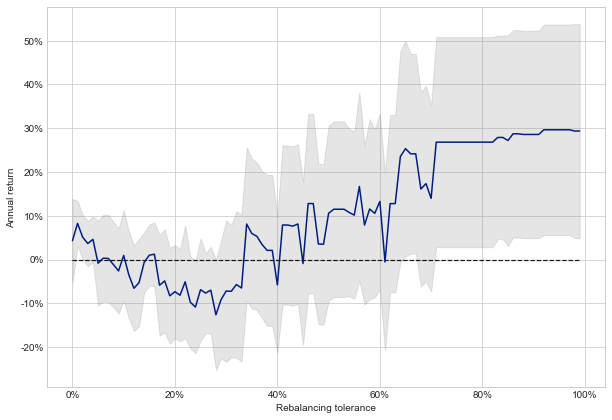

In [10]:
import matplotlib.ticker as mtick
col1 = "Rebalancing_tolerance"
col2 = "annual return"
col3 = "annual std"
df_stats["Rebalancing_tolerance"] = rebalancing_params
df_res = 100*df_stats

fig, ax1 = plt.subplots(1,1, figsize=(10,7))
ax1.plot(df_res[col1], df_res[col2])
ax1.hlines(0, df_res[col1].min(), df_res[col1].max(), linestyle="dashed", linewidth=1.2, alpha=0.9)
ax1.fill_between(df_res[col1], df_res[col2]-df_res[col3], df_res[col2]+df_res[col3], alpha=0.2, color="grey")
ax1.set_xlabel("Rebalancing tolerance")
ax1.set_ylabel("Annual return")
ax1.yaxis.set_major_formatter(mtick.PercentFormatter())
ax1.xaxis.set_major_formatter(mtick.PercentFormatter())
plt.show()

## Not used

In [120]:
import math
def quantilePlot(df, x="rolling_btc_ETH",y="bitcoin_return", n_split=8,function = pd.qcut):
    # choose function between qcut and cut
    n_cols = 4
    n_rows = math.ceil(n_split/n_cols)
    cut      = function(df[y],n_split,duplicates="drop").sort_values() #https://stackoverflow.com/questions/20158597/how-to-qcut-with-non-unique-bin-edges/40548606#40548606
    df["cut"] = cut
    cut_ranges = cut.unique().dropna()
    
    plt.figure(0, figsize=(25,15))
    k = 0
    for i in range(n_rows):
        for j in range(n_cols):
            plt.subplot2grid((n_rows,n_cols), (i,j))
            if (k < len(cut_ranges)):
                df_cut  = df[df["cut"]==cut_ranges[k]]
                plt.scatter(df_cut[x],df_cut[y])
                plt.title(df_cut["cut"][i])
                plt.xlabel(x)
                plt.ylabel(y)
                k = k+1

    plt.show()

In [81]:
a = check_quanto_returns(investment,df, date_start="2018-08-01", date_end="2020-08-01",strategy="long_short",TYPE=structure, 
                           comparison=True, complete=True, show_prices=True,show_hedge=True,
                           btc_fixed=True, eth_fixed=False, add_bias_eth=0, add_bias_btc=0, hedge_btc=True, 
                           do_rebalancing=True, rebalancing_check=30, rebalancing_param=rebalancing_param)

 [############################################################] 0/729 [0<0, 0.00s/it]

Rebalancing in date 2018-09-03 00:00:00 value of bitmex: 1.3240323393250375


In [ ]:
quantilePlot(dfff, y="ROI", n_split=8)

In [46]:
# https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html
import statsmodels.api as sm
import statsmodels.formula.api as smf

def quantileRegr(df,x="fundingRateDaily" ,y= "ether_return"):
    
    mod = smf.quantreg('%s ~ %s'%(x,y), df)
    res = mod.fit(q=.9)
    print(res.summary())

    quantiles = np.arange(.05, .96, .1)
    def fit_model(q):
        res = mod.fit(q=q)
        return [q, res.params['Intercept'], res.params[y]] + \
                res.conf_int().loc[y].tolist()

    models = [fit_model(x) for x in quantiles]
    models = pd.DataFrame(models, columns=['quantile', 'alpha', 'beta', 'lb', 'ub'])

    ols = smf.ols('%s ~ %s'%(x,y), df).fit()
    ols_ci = ols.conf_int().loc[y].tolist()
    ols = dict(a = ols.params['Intercept'],
               b = ols.params[y],
               lb = ols_ci[0],
               ub = ols_ci[1])

    print(models)
    print("... OLS RESULTS ...")
    print(ols)

In [48]:
quantileRegr(dfff,x="hedge" ,y= "ROI_")

                         QuantReg Regression Results                          
Dep. Variable:                  hedge   Pseudo R-squared:                  nan
Model:                       QuantReg   Bandwidth:                       0.000
Method:                 Least Squares   Sparsity:                          nan
Date:                Fri, 31 Jul 2020   No. Observations:                  164
Time:                        16:04:40   Df Residuals:                      162
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept           0        nan        nan        nan         nan         nan
ROI_cum             0        nan        nan        nan         nan         nan
   quantile  alpha  beta  lb  ub
0      0.05    0.0   0.0 NaN NaN
1      0.15    0.0   0.0 NaN NaN
2      0.25    0.0   0.0 NaN NaN

Two components:
Bitcoin modify the number of ether exposure
Ether modify the return 
assumption: invest 50% btc and 50% ether


Do some analysis on binance


Analyze the behaviour of funding in relation to eth_xbt correlation